# Moses IS-EN EN-IS phrase þýðingarvél
Sjá `readme.md` fyrir uppsetningu.

Í þessu vélriti (e. notebook) er Moses þýðingarkerfið notað til þess búa til tvö þýðingarkerfi, fyrst IS-EN og svo EN-IS.

Í stuttu máli skiptist vélritið í eftirfarandi þætti:
1. Samhliða gögn sótt, sameinuð, endurraðað og hreinsuð.
1. Texti tilreiddur og há- og lágstafir lagaðir (Greynir/Miðeind og nltk).
1. Tungumála módel byggt fyrir EN og IS (KenLM).
1. Texta skipt í þrjá hluta; train/val/test, hlutföll eru 80/10/10.
1. (IS-EN) Moses kerfið þjálfað með train hluta texta. Keyrslutími um 1 klst..
1. (IS-EN) Moses kerfið fínpússað með val hluta texta. Keyrslutími um 
1. (IS-EN) Moses kerfið metið með BLEU mælingin á test hluta texta.

Eftirfarandi skráa skipulag er búið til í núverandi skrá.
- `data/` geymir grunngögn sem er hægt að endurnota
- `is-en/` geymir módel og önnur sérgögn fyrir IS-EN þýðingarvélina
- `en-is/` geymir módel og önnur sérgögn fyrir EN-IS þýðingarvélina

In [1]:
from collections import defaultdict, Counter, OrderedDict
import os
import re
from pprint import pprint

import tokenizer
import matplotlib.pyplot as plt
import numpy as np
import nltk

%matplotlib notebook
nltk.download('punkt')

# NOTE: Use full paths
# Used to process .tmx files, required for this notebook
MOSES_SUITE = os.environ['MOSES_SUITE']
# The Moses system as pulled and built from github
MOSESDECODER = os.environ['MOSESDECODER']
# Systems used by Moses (see readme.md).
MOSESDECODER_TOOLS = os.environ['MOSESDECODER_TOOLS']

# This directory will be created and used for intermediary files.
WORKING_DIR = os.environ['WORKING_DIR']
# This directory will be created and used for the generated models.
MODEL_DIR = os.environ['MODEL_DIR']
# Some parts of the processing support threading, set the value here.
THREADS = os.environ['THREADS']

print(MOSES_SUITE, MOSESDECODER, MOSESDECODER_TOOLS, WORKING_DIR, MODEL_DIR, THREADS)

# All intermediary files will have the corpus-prefix added to their name.
CORPUS_PREFIX = 'full-para'
EN = "en"
IS = "is"

# We use a naming convention for each intermediary step in the processing.
def get_name(directory, corpus_prefix, step_modifier, lang_id=''):
    if lang_id:
        return f'{directory}/{corpus_prefix}-{step_modifier}.{lang_id}'
    else:
        return f'{directory}/{corpus_prefix}-{step_modifier}'

/home/staff/haukurpj/moses/MosesSuite /home/staff/haukurpj/moses/mosesdecoder /home/staff/haukurpj/moses/tools /mnt/scratch/smt /home/staff/haukurpj/SMT 20


[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!mkdir -p {WORKING_DIR}
DATA_DIR = f'{WORKING_DIR}/data'

## Sækja gögn

In [6]:
data_loc = 'http://malfong.is/parallel.tar.gz'
!mkdir -p {DATA_DIR}
!wget -qO- {data_loc} | tar xvz -C {DATA_DIR}

baekur.tmx
biblian.tmx
ees.tmx
ema.tmx
eso.tmx
fornritin.tmx
hagstofan.tmx
kde4.tmx
opensubtitles.tmx
tatoeba.tmx
ubuntu.tmx


## Hreinsa

### Hagstofan
Gögnin nota tvennskonar tungumála tag í tmx formattinu. Út af villu í MosesSuite, þá lögum við gögnin bara svo öll skjölin nota sömu nafnavenju.

In [7]:
!grep -m 1 "lang=\"is\"" {DATA_DIR}/*.tmx

/mnt/scratch/smt/data/ema.tmx:      <tuv xml:lang="is"><seg>" samkvæmt birtum niðurstöðum</seg></tuv>
/mnt/scratch/smt/data/hagstofan.tmx:      <tuv xml:lang="is"><seg>Nánar um útgáfu</seg></tuv>


In [8]:
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {DATA_DIR}/hagstofan.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {DATA_DIR}/hagstofan.tmx
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {DATA_DIR}/ema.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {DATA_DIR}/ema.tmx

In [9]:
!grep -m 1 "lang=\"is\"" {DATA_DIR}/*.tmx

In [95]:
tmx_files = !ls {DATA_DIR}/*.tmx
pprint(tmx_files)

['/mnt/scratch/smt/data/baekur.tmx',
 '/mnt/scratch/smt/data/biblian.tmx',
 '/mnt/scratch/smt/data/ees.tmx',
 '/mnt/scratch/smt/data/ema.tmx',
 '/mnt/scratch/smt/data/eso.tmx',
 '/mnt/scratch/smt/data/fornritin.tmx',
 '/mnt/scratch/smt/data/hagstofan.tmx',
 '/mnt/scratch/smt/data/kde4.tmx',
 '/mnt/scratch/smt/data/opensubtitles.tmx',
 '/mnt/scratch/smt/data/tatoeba.tmx',
 '/mnt/scratch/smt/data/ubuntu.tmx']


In [14]:
def read_split_tmx(filename):
    # This will generate two files with the same basename as filename, but with, .is and .en extention.
    !python2 {MOSES_SUITE}/src/corpus-tools/tmx2txt.py -D {filename} EN-GB IS-IS
    return {
        EN: filename.replace(r'tmx', EN),
        IS: filename.replace(r'tmx', IS)
    }

def print_file_stats(filename):
    size = !du -h {filename}
    size = str(size[0]).split("\t")[0]
    lines = !wc -l {filename}
    lines = str(lines[0]).split(" ")[0]
    print(f'{filename}:\t\t{size},\t\t{lines}')

Athugum hvort allt líti rétt út.

In [97]:
para_corpora_list = defaultdict(list)

for tmx_file in tmx_files:
    for lang_id, filename in read_split_tmx(tmx_file).items():
        para_corpora_list[lang_id].append(filename)
        print_file_stats(filename)

/mnt/scratch/smt/data/baekur.en:		1008K,		12416
/mnt/scratch/smt/data/baekur.is:		1,2M,		12416
/mnt/scratch/smt/data/biblian.en:		4,3M,		65241
/mnt/scratch/smt/data/biblian.is:		4,2M,		65241
/mnt/scratch/smt/data/ees.en:		163M,		1701172
/mnt/scratch/smt/data/ees.is:		172M,		1701172
/mnt/scratch/smt/data/ema.en:		40M,		404333
/mnt/scratch/smt/data/ema.is:		43M,		404333
/mnt/scratch/smt/data/eso.en:		1,8M,		12633
/mnt/scratch/smt/data/eso.is:		1,8M,		12633
/mnt/scratch/smt/data/fornritin.en:		1,7M,		17597
/mnt/scratch/smt/data/fornritin.is:		1,6M,		17597
/mnt/scratch/smt/data/hagstofan.en:		212K,		2288
/mnt/scratch/smt/data/hagstofan.is:		220K,		2288
/mnt/scratch/smt/data/kde4.en:		1,7M,		49912
/mnt/scratch/smt/data/kde4.is:		1,9M,		49912
/mnt/scratch/smt/data/opensubtitles.en:		39M,		1261398
/mnt/scratch/smt/data/opensubtitles.is:		41M,		1261398
/mnt/scratch/smt/data/tatoeba.en:		288K,		8263
/mnt/scratch/smt/data/tatoeba.is:		340K,		8263
/mnt/scratch/smt/data/ubuntu.en:		252K,		10572
/m

### Sameinum öll skjölin í eitt stórt skjal

In [98]:
def cat_files(files, extension):
    cat_filename = get_name(DATA_DIR, CORPUS_PREFIX, 'cat', extension)
    files = " ".join(files)
    !cat {files} > {cat_filename}
    return cat_filename

def combine_lang_files(corpora):
    result = {}
    for lang_id, corpus_list in corpora.items():
        result[lang_id] = cat_files(corpus_list, lang_id)
    return result

In [99]:
para_corpus = combine_lang_files(para_corpora_list)

In [101]:
for corpus in para_corpus.values():
    print_file_stats(corpus)

/mnt/scratch/smt/data/full-para-cat.en:		252M,		3545825
/mnt/scratch/smt/data/full-para-cat.is:		266M,		3545825


In [102]:
def peek_corpora(corpora):
    for lang_id, corpus in corpora.items():
        !head {corpus}

In [103]:
peek_corpora(para_corpus)

BOOK I
CHAPTER I A FETE AT THE NEW PALACE
"Yes, sire, since yesterday."
These words were exchanged about two hours after midnight, at the moment when the fete given at the New Palace was at the height of its splendor.
Two or three of these astute politicians-physiognomists by virtue of their profession-failed not to detect on the countenance of their host symptoms of disquietude, the source of which eluded their penetration;
but none ventured to interrogate him on the subject.
It was evidently the intention of the officer of chasseurs that his own anxieties should in no way cast a shade over the festivities; and, as he was a personage whom almost the population of a world in itself was wont to obey, the gayety of the ball was not for a moment checked.
Nevertheless, General Kissoff waited until the officer to whom he had just communicated the dispatch forwarded from Tomsk should give him permission to withdraw; but the latter still remained silent.
He had taken the telegram, he had read

### Hreinsa gögn
Við þurfum að fjarlægja of langar setningar (lengri en 100 stafir), tómar setningar og setningar sem eru augljóslega ranglega raðaðar. Moses býður upp á þessar hreinsanir.

In [104]:
def clean_corpus(base_corpus_name, lang_id_1, lang_id_2, min_length, max_length):
    clean_name = get_name(DATA_DIR, CORPUS_PREFIX, 'clean')
    !{MOSESDECODER}/scripts/training/clean-corpus-n.perl {base_corpus_name} {EN} {IS} {clean_name} {min_length} {max_length}
    return {
        EN: f'{clean_name}.{EN}',
        IS: f'{clean_name}.{IS}'
    }

In [105]:
pprint(para_corpus)
clean_para_corpus = clean_corpus(para_corpus[EN].split('.')[0], EN, IS, 1, 100)
pprint(clean_para_corpus)

{'en': '/mnt/scratch/smt/data/full-para-cat.en',
 'is': '/mnt/scratch/smt/data/full-para-cat.is'}
clean-corpus.perl: processing /mnt/scratch/smt/data/full-para-cat.en & .is to /mnt/scratch/smt/data/full-para-clean, cutoff 1-100, ratio 9
..........(100000)..........(200000)..........(300000)..........(400000)..........(500000)..........(600000)..........(700000)..........(800000)..........(900000)..........(1000000)..........(1100000)..........(1200000)..........(1300000)..........(1400000)..........(1500000)..........(1600000)..........(1700000)..........(1800000)..........(1900000)..........(2000000)..........(2100000)..........(2200000)..........(2300000)..........(2400000)..........(2500000)..........(2600000)..........(2700000)..........(2800000)..........(2900000)..........(3000000)..........(3100000)..........(3200000)..........(3300000)..........(3400000)..........(3500000)....
Input sentences: 3545825  Output sentences:  3543296
{'en': '/mnt/scratch/smt/data/full-para-clean.en'

In [61]:
peek_corpora(clean_para_corpus)

BOOK I
CHAPTER I A FETE AT THE NEW PALACE
"Yes, sire, since yesterday."
These words were exchanged about two hours after midnight, at the moment when the fete given at the New Palace was at the height of its splendor.
Two or three of these astute politicians-physiognomists by virtue of their profession-failed not to detect on the countenance of their host symptoms of disquietude, the source of which eluded their penetration;
but none ventured to interrogate him on the subject.
It was evidently the intention of the officer of chasseurs that his own anxieties should in no way cast a shade over the festivities; and, as he was a personage whom almost the population of a world in itself was wont to obey, the gayety of the ball was not for a moment checked.
Nevertheless, General Kissoff waited until the officer to whom he had just communicated the dispatch forwarded from Tomsk should give him permission to withdraw; but the latter still remained silent.
He had taken the telegram, he had read

In [106]:
def apply_regexp_to_corpus(corpus, regexp):
    result = []
    for line in corpus:
        processed_line = line
        for regular_expression, sub_string in regexp:
            processed_line = re.sub(regular_expression, sub_string, processed_line)
        result.append(processed_line)
    return result


In [107]:
def remove_non_print_chars(corpora):
    result = {}
    for lang_id, corpus in corpora.items():
        out_name = get_name(DATA_DIR, CORPUS_PREFIX, 'clean-chars', lang_id)
        with open(corpus) as file_in:
            lines = file_in.readlines()
            # u'\u0000'-u'\u001f', u'\u007f' - Non-printing characters
            processed_corpus = apply_regexp_to_corpus(lines, [(re.compile(r"[\u0000-\u001f|\u007f]"), '')])
            with open(out_name, 'w') as file_out:
                file_out.write('\n'.join(processed_corpus))
                result[lang_id] = out_name
    return result

In [110]:
test_corpus = ['\u007f\u007f', 'a\u0000b']
reg_exp = [(re.compile(r"[\u0000-\u001f|\u007f]"), 'c')]
apply_regexp_to_corpus(test_corpus, reg_exp)

['cc', 'acb']

In [108]:
char_clean_para_corpus = remove_non_print_chars(clean_para_corpus)

In [111]:
peek_corpora(char_clean_para_corpus)

BOOK I
CHAPTER I A FETE AT THE NEW PALACE
"Yes, sire, since yesterday."
These words were exchanged about two hours after midnight, at the moment when the fete given at the New Palace was at the height of its splendor.
Two or three of these astute politicians-physiognomists by virtue of their profession-failed not to detect on the countenance of their host symptoms of disquietude, the source of which eluded their penetration;
but none ventured to interrogate him on the subject.
It was evidently the intention of the officer of chasseurs that his own anxieties should in no way cast a shade over the festivities; and, as he was a personage whom almost the population of a world in itself was wont to obey, the gayety of the ball was not for a moment checked.
Nevertheless, General Kissoff waited until the officer to whom he had just communicated the dispatch forwarded from Tomsk should give him permission to withdraw; but the latter still remained silent.
He had taken the telegram, he had read

### Stokka gögn
Svo ruglum við línunum, en pössum að rugla textunum með sömu línum.

In [112]:
def shuffle_parallel_corpus(corpora):
    result = {}
    random_source = None
    for lang_id, corpus in corpora.items():
        random_source = corpus if random_source is None else random_source
        output_filename = get_name(DATA_DIR, CORPUS_PREFIX, 'shuf', lang_id)
        !shuf --random-source={random_source} {corpus} > {output_filename}
        result[lang_id] = output_filename
    return result

In [113]:
shuf_para_corpus = shuffle_parallel_corpus(char_clean_para_corpus)

In [114]:
peek_corpora(shuf_para_corpus)

they must not be performed on other fluids or secretions such as the aqueous or vitreous humour unless specifically justified clinically using a validated test for such a fluid.
temperature 273 K, pressure 101,3 kPa, 11 % oxygen or 9 % Co2, dry gas.
There are no other ingredients.
Contents of the pack and other information What Clopidogrel ratiopharm contains
Leflunomide is indicated for the treatment of adult patients with active rheumatoid arthritis as a "disease-modifying antirheumatic drug" (DMARD), active psoriatic arthritis.
Hydrogen fluoride, expressed as HF (4)
Those things will come in force.
Mandarins
• Many of the procedures appropriate for the application of the equity method are similar to the consolidation proce- dures described in IAS 27.
Whereas it is desirable to adapt the contents of Item No 9 of Part B of the Annex to new scientific and botanical knowledge and to amend the subdivision of the Annex accordingly;
ekki er leyfilegt að framkvæma þær í öðrum vökvum eða sey

### Tilreiðir
**SLEPPT!**
Núna notum við NLTK tilreiðarann og tilreiðarann fyrir íslensku frá Greyni. Við reynum að einfalda íslenska textann með eftirfarandi reglu.
- Númer, tölur, dagsetningar, ár, lén, upphæð o.s.frv. eru táknaðar með tegund sinni, þ.e. gildið er fellt í burtu og sami texti (t.d. "NÚMER") er notaður í stað allra gilda (t.d. "4.04"). Fyrir tæmandi lista, sjá kóða.

Þetta var gert til þess að auðvelda Moses að vinna úr þessum gögnum, en í framtíðinni væri líka hægt að bæta virknina með því að bæta við XML tögum í gögnin, þar sem Moses styður slíkar auka upplýsingar. Það krefst þó þess að við "handþýðum" (regular expressions) slík gögn fyrirfram.

**SLEPPT!**

In [115]:
def ignore_uniques(kind, txt, val):
    if kind == tokenizer.TOK.WORD:
        if val:
            return val[0][0]
        else:
            return txt
    if kind == tokenizer.TOK.ORDINAL:
        return "TALA"
    if kind == tokenizer.TOK.NUMBER:
        return "NÚMER"
    if kind == tokenizer.TOK.PUNCTUATION:
        return txt
    if kind == tokenizer.TOK.YEAR:
        return "ÁR"
    if kind == tokenizer.TOK.S_BEGIN:
        pass
    if kind == tokenizer.TOK.S_END:
        pass
    if kind == tokenizer.TOK.DATEABS:
        return "DAGSETNING"
    if kind == tokenizer.TOK.DATEREL:
        return "DAGSETNING"
    if kind == tokenizer.TOK.MEASUREMENT:
        return "MÆLING"
    if kind == tokenizer.TOK.NUMWLETTER:
        return "GILDI"
    if kind == tokenizer.TOK.DOMAIN:
        return "LÉN"
    if kind == tokenizer.TOK.HASHTAG:
        return "HASHTAG"
    if kind == tokenizer.TOK.TELNO:
        return "SÍMANÚMER"
    if kind == tokenizer.TOK.PERCENT:
        return "PRÓSENTA"
    if kind == tokenizer.TOK.URL:
        return "VEFFANG"
    if kind == tokenizer.TOK.AMOUNT:
        return "UPPHÆÐ"
    if kind == tokenizer.TOK.EMAIL:
        return "TÖLVUPÓSTUR"
    if kind == tokenizer.TOK.UNKNOWN:
        return "UNKOWN"
    else:
        return "UNKOWN"

def pass_through(kind, txt, val):
    if kind == tokenizer.TOK.WORD:
        if val:
            return val[0][0]
        else:
            return txt
    if kind == tokenizer.TOK.S_BEGIN:
        pass
    if kind == tokenizer.TOK.S_END:
        pass
    else:
        return txt
    
def tokenize_sentence(sentence, lang_id):
    result = []
    if lang_id == EN:
        # We try to use a standard tokenizer for english
        return " ".join(nltk.word_tokenize(sentence))
    # We set the option to change "1sti", ... to "1", ...
    elif lang_id == IS:    
        for token in tokenizer.tokenize(sentence, handle_kludgy_ordinals=[tokenizer.KLUDGY_ORDINALS_TRANSLATE]):
            kind, txt, val = token
            word = pass_through(kind, txt, val)
            if word:
                result.append(word)
        return " ".join(result)

def tokenize(filename_in, lang_id):
    filename_out = get_name(DATA_DIR, CORPUS_PREFIX, 'tok', lang_id)
    with open(filename_in, 'r') as file_in, open(filename_out, 'w') as file_out:
        for line in file_in:
            sentence_tokenized = tokenize_sentence(line, lang_id)
            file_out.write(sentence_tokenized + "\n")
    return filename_out

In [116]:
def tokenize_corpus(corpora):
    result = {}
    for lang_id, corpus in corpora.items():
        result[lang_id] = tokenize(corpus, lang_id)
    return result

In [117]:
tok_para_corpus = tokenize_corpus(shuf_para_corpus)
peek_corpora(tok_para_corpus)

they must not be performed on other fluids or secretions such as the aqueous or vitreous humour unless specifically justified clinically using a validated test for such a fluid .
temperature 273 K , pressure 101,3 kPa , 11 % oxygen or 9 % Co2 , dry gas .
There are no other ingredients .
Contents of the pack and other information What Clopidogrel ratiopharm contains
Leflunomide is indicated for the treatment of adult patients with active rheumatoid arthritis as a `` disease-modifying antirheumatic drug '' ( DMARD ) , active psoriatic arthritis .
Hydrogen fluoride , expressed as HF ( 4 )
Those things will come in force .
Mandarins
• Many of the procedures appropriate for the application of the equity method are similar to the consolidation proce- dures described in IAS 27 .
Whereas it is desirable to adapt the contents of Item No 9 of Part B of the Annex to new scientific and botanical knowledge and to amend the subdivision of the Annex accordingly ;
ekki er leyfilegt að framkvæma þær í 

### Skoða tölfræði setninga
Skoðum nú hversu langar setningarnar eru til þess að fá hugmynd um gagnasafnið.

In [100]:
def get_sentence_length_counter(corpora):    
    counters = dict()
    for lang_id, corpus in tok_para_corpus.items():
        with open(corpus) as corpus_file:
            counters[lang_id] = Counter()
            for line in corpus_file:
                length = len(line.split(" "))
                counters[lang_id][length] += 1
    return counters
    
def draw_bar_plot(title, counter):
    labels, values = zip(*sorted(counter.items()))

    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(9,9))
    plt.bar(indexes, values, width)
    plt.title(title)
    plt.rc('xtick', labelsize=4)
    plt.rc('ytick', labelsize=4) 
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

In [35]:
counters = get_sentence_length_counter(tok_para_corpus)

<IPython.core.display.Javascript object>


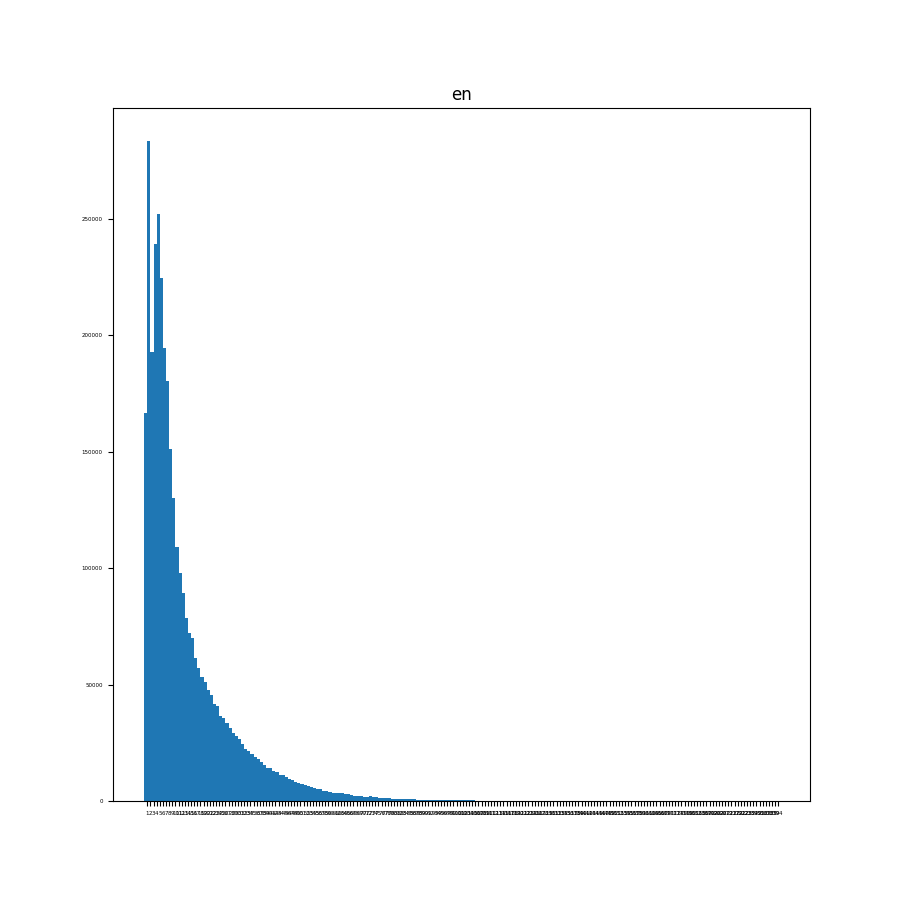

In [101]:
draw_bar_plot(EN, counters[EN])
    

<IPython.core.display.Javascript object>


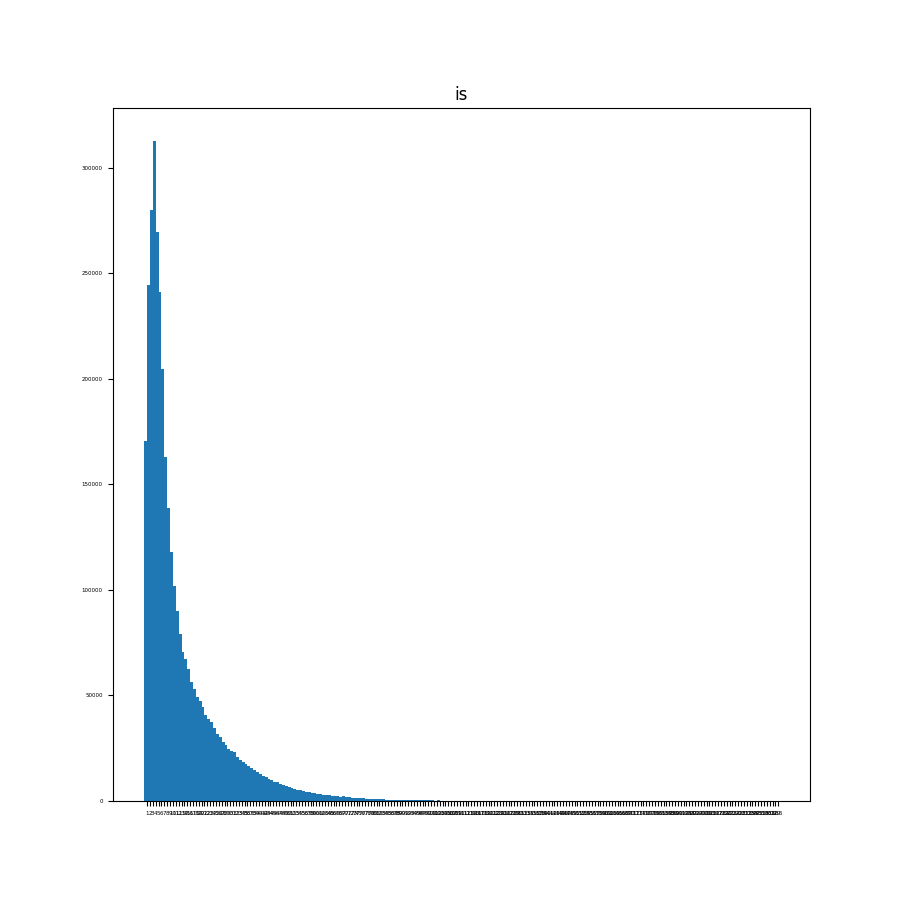

In [102]:
draw_bar_plot(IS, counters[IS])
    

### Laga há- og lágstafi
Við notum tól sem fylgir með Moses kerfinu til þess að laga há- og lágstafi. Tólið þjálfar fyrst á gögnunum til þess að læra rétt útlit og giskar svo á rétt útlit.

In [135]:
def train_truecase(corpus, lang_id):
    truecase_model = get_name(DATA_DIR, CORPUS_PREFIX, 'truecase_model', lang_id)
    !{MOSESDECODER}/scripts/recaser/train-truecaser.perl --model {truecase_model}  --corpus {corpus}
    return truecase_model

def apply_truecase(corpus, truecase_model, lang_id):
    result = get_name(DATA_DIR, CORPUS_PREFIX, 'true', lang_id)
    !{MOSESDECODER}/scripts/recaser/truecase.perl --model {truecase_model} <{corpus} >{result}
    return result

def truecase_sentence(sentence, truecase_model):
    escaped_sentence = sentence.replace(r'"', r'\"')
    result = !echo "{escaped_sentence}" | {MOSESDECODER}/scripts/recaser/truecase.perl --model {truecase_model}
    return result[0]

def truecase_corpora(corpora):
    result = {}
    for lang_id, corpus in corpora.items():
        truecase_model = train_truecase(corpus, lang_id)
        apply_truecase(corpus, truecase_model, lang_id)
        result[lang_id] = apply_truecase(corpus, truecase_model, lang_id)
    return result

In [136]:
true_para_corpus = truecase_corpora(tok_para_corpus)
peek_corpora(true_para_corpus)

they must not be performed on other fluids or secretions such as the aqueous or vitreous humour unless specifically justified clinically using a validated test for such a fluid .
temperature 273 K , pressure 101,3 kPa , 11 % oxygen or 9 % Co2 , dry gas .
there are no other ingredients .
contents of the pack and other information What Clopidogrel ratiopharm contains
leflunomide is indicated for the treatment of adult patients with active rheumatoid arthritis as a `` disease-modifying antirheumatic drug '' ( DMARD ) , active psoriatic arthritis .
hydrogen fluoride , expressed as HF ( 4 )
those things will come in force .
mandarins
• Many of the procedures appropriate for the application of the equity method are similar to the consolidation proce- dures described in IAS 27 .
Whereas it is desirable to adapt the contents of Item No 9 of Part B of the Annex to new scientific and botanical knowledge and to amend the subdivision of the Annex accordingly ;
ekki er leyfilegt að framkvæma þær í 

### Bæta við leppum
Við bætum við leppum í stað sumra stafa sem Moses skilur öðruvísi (og síðar í stað annarra sérstakra gilda eins og talna og nafna). Leppirnir eru markaðir með @-merki í byrjun og enda.

In [156]:
def add_placeholders(corpora):
    result = {}
    for lang_id, corpus in corpora.items():
        out_name = get_name(DATA_DIR, CORPUS_PREFIX, 'special', lang_id)
        with open(corpus) as file_in:
            lines = file_in.readlines()
            # u'\u007c' - |
            pipe_reg = re.compile(r"\u007c")
            # u'\u003c', u'\u003e' - <, >
            lt_reg = re.compile(r"\u003c")
            gt_reg = re.compile(r"\u003e")

            # u'\u005b', u'\u005d' - [, ]
            bracket_open_reg = re.compile(r"\u005b")
            bracket_close_reg = re.compile(r"\u005d")
            
            # We map these special characters to placeholders and keep their original form.
            regular_expressions = [
                (pipe_reg, '@pipe@'),
                (lt_reg, '@lt@'),
                (gt_reg, '@gt@'),
                (bracket_open_reg, '@brac_open@'),
                (bracket_close_reg, '@brac_close@'),
            ]
            
            processed_corpus = apply_regexp_to_corpus(lines, regular_expressions)
            with open(out_name, 'w') as file_out:
                file_out.write(''.join(processed_corpus))
                result[lang_id] = out_name
    return result

In [157]:
def add_placeholders_with_lookup(corpora):
    result = {}
    for lang_id, corpus in corpora.items():
        out_name = get_name(DATA_DIR, CORPUS_PREFIX, 'lookup', lang_id)
        with open(corpus) as file_in:
            lines = file_in.readlines()
            # u'\u007c' - |
            pipe_reg = re.compile(r"\u007c")
            # u'\u003c', u'\u003e' - <, >, with spaces around
            lt_reg = re.compile(r"\u003c")
            gt_reg = re.compile(r"\u003e")

            # u'\u005b', u'\u005d' - [, ]
            bracket_open_reg = re.compile(r"\u005b")
            bracket_close_reg = re.compile(r"\u005d")
            
            # We map these special characters to placeholders and keep their original form.
            regular_expressions = [
                (pipe_reg, '<special translation="@pipe@" entity="|">@pipe@</special>'),
                (lt_reg, '<special translation="@lt@" entity="\<">@lt@</special>'),
                (gt_reg, '<special translation="@gt@" entity="\>">@gt@</special>'),
                (bracket_open_reg, '<special translation="@brac_open@" entity="[">@brac_open@</special>'),
                (bracket_close_reg, '<special translation="@brac_close@" entity="]">@brac_close@</special>'),
            ]
            
            processed_corpus = apply_regexp_to_corpus(lines, regular_expressions)
            with open(out_name, 'w') as file_out:
                file_out.write(''.join(processed_corpus))
                result[lang_id] = out_name

In [158]:
place_para_corpus = add_placeholders(true_para_corpus)
peek_corpora(place_para_corpus)

they must not be performed on other fluids or secretions such as the aqueous or vitreous humour unless specifically justified clinically using a validated test for such a fluid .
temperature 273 K , pressure 101,3 kPa , 11 % oxygen or 9 % Co2 , dry gas .
there are no other ingredients .
contents of the pack and other information What Clopidogrel ratiopharm contains
leflunomide is indicated for the treatment of adult patients with active rheumatoid arthritis as a `` disease-modifying antirheumatic drug '' ( DMARD ) , active psoriatic arthritis .
hydrogen fluoride , expressed as HF ( 4 )
those things will come in force .
mandarins
• Many of the procedures appropriate for the application of the equity method are similar to the consolidation proce- dures described in IAS 27 .
Whereas it is desirable to adapt the contents of Item No 9 of Part B of the Annex to new scientific and botanical knowledge and to amend the subdivision of the Annex accordingly ;
ekki er leyfilegt að framkvæma þær í 

In [159]:
corpus = placeholders_para_corpus[EN]
!grep '@' -m 10 {corpus}

CSM_47 Vehicle units , tachograph cards and external GNSS facilities shall support the ECKA-EG key agreement algorithm , as specified in @brac_open@ TR 03111 @brac_close@ .
a more comprehensive description of the RSA function can be found in reference @brac_open@ PKCS1 @brac_close@ .
nadir platelets @lt@ 50,000/mm3
@brac_open@ a complex combination of hydrocarbons from distillation of the products from a hydrocracking process .
Yondelis monotherapy and combination regimens must not be used in patients with creatinine clearance @lt@ 30 ml/min and @lt@ 60 ml/min respectively ( see section 4.2 ) .
proactive skin treatment including skin moisturiser , sun screen ( SPF @gt@ 15 UVA and UVB ) , topical steroid cream ( not stronger than 1 % hydrocortisone ) and an oral antibiotic ( e.g . doxycycline ) may be useful in the management of dermatologic reactions .
there is evidence suggesting that all Grade ( US National Cancer Institute- Common Terminology Criteria for Adverse Events @brac_open@ 

### Tungumála módel
Við notum svo KenLM tungumála módelið til þess að gefa okkur líkindi setninga. Til að flýta uppflettingum þá tungumála módelið samtímis kjörsniðið.

In [4]:
!ls {DATA_DIR}

baekur.en	  full-para-clean-chars.en  full-para-truecase_model.en
baekur.is	  full-para-clean-chars.is  full-para-truecase_model.is
baekur.tmx	  full-para-clean.en	    full-para-val.en
biblian.en	  full-para-clean.is	    full-para-val.is
biblian.is	  full-para-lm_arpa.en	    hagstofan.en
biblian.tmx	  full-para-lm_arpa.is	    hagstofan.is
ees.en		  full-para-lm_blm.en	    hagstofan.tmx
ees.is		  full-para-lm_blm.is	    kde4.en
ees.tmx		  full-para-shuf.en	    kde4.is
ema.en		  full-para-shuf.is	    kde4.tmx
ema.is		  full-para-special.en	    opensubtitles.en
ema.tmx		  full-para-special.is	    opensubtitles.is
eso.en		  full-para-test.en	    opensubtitles.tmx
eso.is		  full-para-test.is	    tatoeba.en
eso.tmx		  full-para-tok.en	    tatoeba.is
fornritin.en	  full-para-tok.is	    tatoeba.tmx
fornritin.is	  full-para-train.en	    ubuntu.en
fornritin.tmx	  full-para-train.is	    ubuntu.is
full-para-cat.en  full-para-true.en	    ubuntu.tmx
full-para-cat.is  full-para-true.is


In [3]:
def create_lm(corpus, lang_id):
    lm_model_arpa = get_name(DATA_DIR, CORPUS_PREFIX, 'lm_arpa', lang_id)
    lm_model_blm = get_name(DATA_DIR, CORPUS_PREFIX, 'lm_blm', lang_id)
    !{MOSESDECODER}/bin/lmplz -o 3 < {corpus} > {lm_model_arpa}
    !{MOSESDECODER}/bin/build_binary {lm_model_arpa} {lm_model_blm}
    return lm_model_blm


In [10]:
# Hardcoded for runs not all the way from the top
place_para_corpus = {
    EN: f"{DATA_DIR}/full-para-special.{EN}",
    IS: f"{DATA_DIR}/full-para-special.{IS}"
}

In [5]:
LM = {
    EN: create_lm(place_para_corpus[EN], EN),
    IS: create_lm(place_para_corpus[IS], IS)
}

=== 1/5 Counting and sorting n-grams ===
Reading /mnt/scratch/smt/data/full-para-special.en
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 49583739 types 398980
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:4787760 2:37588959232 3:70479298560
Statistics:
1 398980 D1=0.70789 D2=1.03122 D3+=1.31659
2 3905106 D1=0.725258 D2=1.09249 D3+=1.38137
3 11902041 D1=0.678304 D2=1.15725 D3+=1.45193
Memory estimate for binary LM:
type     MB
probing 303 assuming -p 1.5
probing 327 assuming -r models -p 1.5
trie    129 without quantization
trie     74 assuming -q 8 -b 8 quantization 
trie    122 assuming -a 22 array pointer compression
trie     67 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:4787760 2:62481696 3:238040

In [6]:
pprint(LM)

{'en': '/mnt/scratch/smt/data/full-para-lm_blm.en',
 'is': '/mnt/scratch/smt/data/full-para-lm_blm.is'}


Prófa tungumála módel

In [7]:
def eval_sentence(lm_model, sentence):
   !echo "{sentence}" | {MOSESDECODER}/bin/query {lm_model}

In [8]:
eval_sentence(LM[IS], "þetta er flott íslensk setning , er það ekki ?")
eval_sentence(LM[EN], "this is a nice English sentence , right ?")

þetta=230 2 -1.9089104	er=4 3 -0.25080082	flott=642 3 -2.480758	íslensk=101858 1 -7.8264427	setning=25397 1 -5.0621104	,=14 2 -1.7306166	er=4 2 -2.1021233	það=137 3 -0.98709315	ekki=3 3 -0.76174337	?=165 3 -0.82030237	</s>=2 3 -0.010218243	Total: -23.94112 OOV: 0
Perplexity including OOVs:	150.12930288004378
Perplexity excluding OOVs:	150.12930288004378
OOVs:	0
Tokens:	11
Name:query	VmPeak:421144 kB	VmRSS:3888 kB	RSSMax:403756 kB	user:0	sys:0.056	CPU:0.056	real:0.0575499
this=133 2 -1.8217136	is=58 3 -0.66188765	a=24 3 -1.0184718	nice=3416 3 -2.860039	English=7099 1 -4.527742	sentence=5984 1 -5.0636005	,=33 2 -1.1142942	right=252 2 -3.7716594	?=160 3 -0.14599161	</s>=2 3 -0.034494855	Total: -21.019896 OOV: 0
Perplexity including OOVs:	126.47059313388736
Perplexity excluding OOVs:	126.47059313388736
OOVs:	0
Tokens:	10
Name:query	VmPeak:332148 kB	VmRSS:4096 kB	RSSMax:314968 kB	user:0	sys:0.048	CPU:0.048	real:0.047921


### Skipta gögnum
Núna skiptum við gögnunum í train/val/test. Við reynum að hafa um 2000 setningar í val og 3000 setningar í test. Þessir hlutar eru skilgreindir í kóðanum, subbulega. 

Train gögnin eru nýtt í þjálfun á Moses, val í fínpússun og loks test til þess að meta þýðingarnar. Til þess að ná fram þessari skiptingu þá tökum við fyrstu línurnar fyrir train gögnin, svo val gögnin og síðustu línurnar fara í test gögnin. Þess vegna er mikilvægt að það sé búið að stokka gögnin á þessum tímapunkti.

In [11]:
def split_corpus_by_fraction(corpus, fraction, lang_id):
    first_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{fraction}', lang_id)
    second_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{1-fraction}', lang_id)
    sentence_count = !wc -l {corpus}
    sentence_count = int((sentence_count.get_nlstr().split(' ')[0]))
    print(sentence_count)
    
    first, second = int(fraction * sentence_count), int((1 - fraction) * sentence_count)
    print(first, second, first + second)
    
    !head -n {first} {corpus} > {first_part}
    !tail -n {second} {corpus} > {second_part}
    return (first_part, second_part)

def split_corpus_by_count(corpus, count, lang_id):
    sentence_count = !wc -l {corpus}
    sentence_count = int((sentence_count.get_nlstr().split(' ')[0]))
    print(sentence_count)
    first = sentence_count - count
    second = count
    print(first, second)
    
    first_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{first}', lang_id)
    second_part = get_name(DATA_DIR, CORPUS_PREFIX, f'split_{second}', lang_id)
    
    !head -n {first} {corpus} > {first_part}
    !tail -n {second} {corpus} > {second_part}
    return (first_part, second_part)

def move(file_from, file_to):
    !mv {file_from} {file_to}
    return file_to

def split_corpora(corpora, val_count=2000, test_count=3000):
    result = defaultdict(dict)
    
    for lang_id, corpus in corpora.items():
        train, tmp = split_corpus_by_count(corpus, val_count + test_count, lang_id)
        val, test = split_corpus_by_count(tmp, test_count, lang_id)
        !rm {tmp}
        train = move(train, get_name(DATA_DIR, CORPUS_PREFIX, 'train', lang_id))
        val = move(val, get_name(DATA_DIR, CORPUS_PREFIX, 'val', lang_id))
        test = move(test, get_name(DATA_DIR, CORPUS_PREFIX, 'test', lang_id))
        result[lang_id]['train'] = train
        result[lang_id]['val'] = val
        result[lang_id]['test'] = test
    return result
        

In [12]:
split_para_corpus = split_corpora(place_para_corpus)

3543296
3538296 5000
5000
2000 3000
3543296
3538296 5000
5000
2000 3000


In [15]:
for lang_id, step_dict in split_para_corpus.items():
    for step in step_dict.keys():
        print_file_stats(split_para_corpus[lang_id][step])

/mnt/scratch/smt/data/full-para-train.en:		257M,		3538296
/mnt/scratch/smt/data/full-para-val.en:		152K,		2000
/mnt/scratch/smt/data/full-para-test.en:		216K,		3000
/mnt/scratch/smt/data/full-para-train.is:		278M,		3538296
/mnt/scratch/smt/data/full-para-val.is:		164K,		2000
/mnt/scratch/smt/data/full-para-test.is:		232K,		3000


In [16]:
for lang_id, step_dict in split_para_corpus.items():
    for step in step_dict.keys():
        !head -n 1 {split_para_corpus[lang_id][step]}
        !tail -n 1 {split_para_corpus[lang_id][step]}

they must not be performed on other fluids or secretions such as the aqueous or vitreous humour unless specifically justified clinically using a validated test for such a fluid .
diltiazem ( 180 to 360 mg once daily ) , a moderately potent CYP3A4 inhibitor , causes dose-dependent increases in average ranolazine steady-state concentrations of 1.5- to 2.4-fold .
E 920 L-CYSTEINE
• The examination procedure should be used for the adoption of implementing acts : determining whether certain categories of electrical or electronic products meet the definition of ‘ radio equipment ; laying down the opera tional rules for making the information on compliance available ; laying down the operational rules for registra tion and the operational rules for affixing the registration number on radio equipment ;
if you are male and your partner is pregnant or capable of becoming pregnant , you must use condoms during sexual intercourse while taking bexarotene and for at least one month after the last do

In [ ]:
def get_sentence_number(corpora, sentence_number):
    import linecache
    return (linecache.getline(corpora[EN], sentence_number), linecache.getline(corpora[EN], sentence_number))

In [ ]:
354, 352 oft endurtekin,
2743447 - 2 (3?) vs 23
alignment issue
2497429 - 1 vs 10
1582050
771881

## Moses þjálfunar föll
Næstu föll snúa að þjálfun Moses og annarra atriða sem þarf að hafa í huga. Síðasta skrefið metur þýðingar Moses.

In [17]:
def train_moses(model_dir, corpus, lang_from, lang_to, lang_to_lm):
    result = !{MOSESDECODER}/scripts/training/train-model.perl -root-dir {model_dir} \
        -corpus {corpus} \
        -f {lang_from} -e {lang_to} \
        -alignment grow-diag-final-and -reordering msd-bidirectional-fe \
        -lm 0:3:{lang_to_lm}:8 \
        -mgiza -mgiza-cpus {THREADS} \
        -cores {THREADS} \
        -external-bin-dir {MOSESDECODER_TOOLS} &> {model_dir}/training.out
    return model_dir

In [18]:
def tune_moses(model_dir, corpus_val_from, corpus_val_to):
    tuned_dir = f'{model_dir}/tuned_model'
    result = !{MOSESDECODER}/scripts/training/mert-moses.pl \
    {corpus_val_from} \
    {corpus_val_to} \
    {MOSESDECODER}/bin/moses {model_dir}/model/moses.ini \
        --mertdir {MOSESDECODER}/bin \
        --working-dir {tuned_dir} \
        --decoder-flags="-threads {THREADS}" &> `pwd`/{model_dir}/tune.out
    return tuned_dir

In [19]:
def prepare_binarisation(model_dir, moses_ini):
    binarised_dir = f'{model_dir}/binarised_model'
    !mkdir -p {binarised_dir}
    !cp {moses_ini} {binarised_dir}
    return binarised_dir
    
def binarise_phrase_table(model_dir, binarised_dir):
    binarised_phrase_table = f'{binarised_dir}/phrase-table'
    
    #Create the table
    !{MOSESDECODER}/bin/processPhraseTableMin \
        -in {model_dir}/model/phrase-table.gz \
        -nscores 4 \
        -out {binarised_phrase_table}
    
    # Adjust the path in the moses.ini file
    escaped_path = binarised_phrase_table.replace(r'/', '\/')
    !sed -i 's/PhraseDictionaryMemory/PhraseDictionaryCompact/' {binarised_dir}/moses.ini
    !sed -i 's/4 path=.*\.gz input-factor/4 path={escaped_path} input-factor/' {binarised_dir}/moses.ini

def binarise_reordering_table(model_dir, binarised_dir):
    binarised_reordering_table = f'{binarised_dir}/reordering-table'
    
    #Create the table
    !{MOSESDECODER}/bin/processLexicalTableMin \
        -in {model_dir}/model/reordering-table.wbe-msd-bidirectional-fe.gz \
        -out {binarised_reordering_table}
    
    # Adjust the path in the moses.ini file
    escaped_path = binarised_reordering_table.replace(r'/', '\/')
    !sed -i 's/0 path=.*\.gz$/0 path={escaped_path}/' {binarised_dir}/moses.ini


In [20]:
# It only makes sense to filter the model when you know what text the system needs to translate.
def filter_model(out_dir, moses_ini, corpus):
    !{MOSESDECODER}/scripts/training/filter-model-given-input.pl {out_dir} {moses_ini} {corpus}

def translate_corpus(moses_ini, corpus, corpus_translated):
    !{MOSESDECODER}/bin/moses -f {moses_ini} < {corpus} > {corpus_translated}
    
def eval_translation(corpus_gold, corpus_translated):
    result = !{MOSESDECODER}/scripts/generic/multi-bleu.perl -lc {corpus_gold} < {corpus_translated}
    return result 

### Þjálfun EN-IS

In [21]:
for lang_id, step_dict in split_para_corpus.items():
    for step in step_dict.keys():
        print_file_stats(split_para_corpus[lang_id][step])
pprint(LM)

/mnt/scratch/smt/data/full-para-train.en:		257M,		3538296
/mnt/scratch/smt/data/full-para-val.en:		152K,		2000
/mnt/scratch/smt/data/full-para-test.en:		216K,		3000
/mnt/scratch/smt/data/full-para-train.is:		278M,		3538296
/mnt/scratch/smt/data/full-para-val.is:		164K,		2000
/mnt/scratch/smt/data/full-para-test.is:		232K,		3000
{'en': '/mnt/scratch/smt/data/full-para-lm_blm.en',
 'is': '/mnt/scratch/smt/data/full-para-lm_blm.is'}


In [26]:
# without the lang extension
model_dir = f'{MODEL_DIR}/{CORPUS_PREFIX}_{EN}-{IS}'
!mkdir -p {model_dir}

In [ ]:
print(f'tail -f {model_dir}/training.out')
train_moses(model_dir, f'{DATA_DIR}/full-para-train', EN, IS, f'{DATA_DIR}/full-para-lm_blm.is')

tail -f /home/staff/haukurpj/SMT/full-para_en-is/training.out


Þjálfunin tekur allt frá 30 mín.
Til þess að sjá framgang þjálfunar - sjá útprent að ofan

### Fínpússun EN-IS

In [25]:
print(f'tail -f {model_dir}/training.out')
tuned_dir = tune_moses(model_dir, f'{DATA_DIR}/full-para-val.en', f'{DATA_DIR}/full-para-val.is')

tail -f /home/staff/haukurpj/SMT/full-para_en-is/training.out


Fínpússun getur tekið talsverðan tíma, allt frá 60 mín og meira.

### Pakka EN-IS
Við þjöppum töflunum sem við höfum lært. Við pössum okkur að vísa í fínpússuðu stillingarnar.

In [17]:
model_dir = 'baseline_en-is'
moses_ini = 'baseline_en-is/tuned_model/moses.ini'
binarised_dir = prepare_binarisation(model_dir, moses_ini)
binarise_phrase_table(model_dir, binarised_dir)
binarise_reordering_table(model_dir, binarised_dir)
!ls {binarised_dir}

Used options:
	Text phrase table will be read from: baseline_en-is/model/phrase-table.gz
	Output phrase table will be written to: /home/haukur-ubuntu/mt/baseline_en-is/binarised_model/phrase-table.minphr
	Step size for source landmark phrases: 2^10=1024
	Source phrase fingerprint size: 16 bits / P(fp)=1.52588e-05
	Selected target phrase encoding: Huffman + PREnc
	Maxiumum allowed rank for PREnc: 100
	Number of score components in phrase table: 4
	Single Huffman code set for score components: no
	Using score quantization: no
	Explicitly included alignment information: yes
	Running with 4 threads

Pass 1/3: Creating hash function for rank assignment
..............

Pass 2/3: Creating source phrase index + Encoding target phrases
..............

Intermezzo: Calculating Huffman code sets
	Creating Huffman codes for 53979 target phrase symbols
	Creating Huffman codes for 6584 scores
	Creating Huffman codes for 1316197 scores
	Creating Huffman codes for 6759 scores
	Creating Huffman codes fo

### Þýða texta og meta

In [18]:
#filter_model('out/filtered', 'out/model/run10.moses.ini', 'out/corpus.true.test.is')
translate_corpus(f'{binarised_dir}/moses.ini', 'data/baseline-test.en', f'{model_dir}/baseline-test-translated.is')
print(eval_translation('data/baseline-test.is', f'{model_dir}/baseline-test-translated.is'))


Defined parameters (per moses.ini or switch):
	config: /home/haukur-ubuntu/mt/baseline_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/haukur-ubuntu/mt/baseline_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/haukur-ubuntu/mt/baseline_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/home/haukur-ubuntu/mt/data/baseline-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 4 
	weight: LexicalReordering0= 0.0570255 0.0191635 0.0274093 0.0809359 0.0291009 0.0403635 Distortion0= 0.0650582 LM0= 0.197226 WordPenalty0= -0.18483 PhrasePenalty0= 0.0845231 TranslationModel0= 0.0753196 0.090337 -0.021085 0.0276221 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunct

Line 11: Collecting options took 0.176 seconds at moses/Manager.cpp Line 141
Line 7: Search took 0.852 seconds
BEST TRANSLATION: þessir tveir saman við þá til að mæla styrk þyngdarkraftsins . niðurstöðurnar var einmitt það sem almennt afstæði spáir fyrir um , eru aðeins fjögur prósent af 9 . [1111111111111111111111111111111]  [total=-30.620] core=(0.000,-29.000,22.000,-58.722,-70.873,-38.307,-62.326,-10.088,0.000,-9.807,-7.084,0.000,-8.869,-20.000,-116.739)  
BEST TRANSLATION: nú kúna gekk oft ofan til strandar . og er þar höfðu verið litten|UNK|UNK|UNK báli og licked|UNK|UNK|UNK grjót á þá er þeir voru var rekinn . [111111111111111111111111111111111]  [total=-238.158] core=(-200.000,-26.000,23.000,-72.438,-73.384,-36.815,-46.200,-5.532,-3.555,-8.761,-7.377,-3.555,-7.451,-26.000,-147.067)  
BEST TRANSLATION: Þorkell mælti að hann mundi vera að hann skyldi að spyrja þig bráðlega . [11111111111111]  [total=-11.293] core=(0.000,-14.000,11.000,-19.119,-21.233,-18.590,-27.171,-2.217,-3.747,

Translating: the programme makes use of telescope time that can not be used for science observations . 
Line 25: Initialize search took 0.000 seconds total
Line 23: Search took 0.363 seconds
Line 23: Decision rule took 0.000 seconds total
Line 23: Additional reporting took 0.000 seconds total
Line 23: Translation took 0.407 seconds total
Translating: whose is that notebook ? 
Line 26: Initialize search took 0.000 seconds total
Line 26: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 25: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 26: Search took 0.015 seconds
Line 26: Decision rule took 0.000 seconds total
Line 26: Additional reporting took 0.000 seconds total
Line 26: Translation took 0.017 seconds total
Translating: I carried the queens letter , and-well , I would have given much to have old Sapt or Rudolf Rassendyll by my side . 
Line 27: Initialize search took 0.001 seconds total
Line 27: Collecting options took 0.050 seconds at

Line 38: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 31: Search took 0.865 seconds
BEST TRANSLATION: allt þar til nokkurra ára UKS|UNK|UNK|UNK 1 ( sem sést á myndinni sést ) sem outshines|UNK|UNK|UNK nýju fyribærunum , var í raun dimmest|UNK|UNK|UNK kúluþyrpingum sem vitað er um í Vetrarbrautinni okkar . [1111111111111111111111111111111111]  [total=-332.216] core=(-300.000,-32.000,21.000,-40.585,-53.474,-39.589,-54.541,-4.266,-7.988,-3.179,-3.511,-6.736,-8.365,-26.000,-143.760)  
BEST TRANSLATION: Kozue|UNK|UNK|UNK þótti skipulagðri fyrirlestur róleg , og væri leiðinlegt endless|UNK|UNK|UNK . [1111111111111]  [total=-219.208] core=(-200.000,-11.000,11.000,-11.479,-16.927,-11.008,-14.908,-3.558,0.000,-4.170,-3.124,0.000,-6.193,-10.000,-91.907)  
BEST TRANSLATION: það tómt smjaður yfir skal fá þér hvergi . [111111111]  [total=-11.874] core=(0.000,-9.000,7.000,-14.135,-21.723,-8.450,-17.228,-2.234,-0.511,-3.555,-1.722,-1.609,-1.195,-6.000,-50.424)  
Line 31: D

Line 47: Search took 0.571 seconds
Line 47: Decision rule took 0.000 seconds total
Line 47: Additional reporting took 0.000 seconds total
Line 47: Translation took 0.624 seconds total
Translating: what will you have for lunch today ? 
Line 49: Initialize search took 0.000 seconds total
Line 49: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 45: Search took 0.809 seconds
BEST TRANSLATION: sagði Haraldur konungur að það mundi auðvelt því að þeir vissu að engi maður fríðari hafði út komið af Íslandi í dag . [111111111111111111111111111]  [total=-21.411] core=(0.000,-23.000,16.000,-27.443,-46.601,-22.541,-34.536,-7.372,-1.609,-2.865,-8.204,-3.417,-2.120,-4.000,-94.409)  
Line 45: Decision rule took 0.000 seconds total
Line 45: Additional reporting took 0.000 seconds total
Line 45: Translation took 0.899 seconds total
Translating: new registration and insolvencies 
Line 50: Initialize search took 0.000 seconds total
Line 50: Collecting options took 0.001 seconds at

Line 62: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 60: Search took 0.489 seconds
Line 60: Decision rule took 0.000 seconds total
Line 60: Additional reporting took 0.000 seconds total
Line 60: Translation took 0.514 seconds total
Translating: tell her Majesty that there is still a Rassendyll , if she has need of one . ” 
Line 63: Initialize search took 0.000 seconds total
Line 63: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 61: Search took 0.435 seconds
Line 61: Decision rule took 0.000 seconds total
Line 61: Additional reporting took 0.000 seconds total
Line 61: Translation took 0.450 seconds total
Translating: it was then about eight oclock ; we had arrived at a station of some importance and were not to stop again till mid-day . 
Line 64: Initialize search took 0.001 seconds total
Line 54: Search took 1.278 seconds
BEST TRANSLATION: „ Eins og ég var að segja , drotning mín , “ sagði hann , „ þá hélt villigeltinum , sem hafð

Line 72: Search took 0.166 seconds
Line 72: Decision rule took 0.000 seconds total
Line 72: Additional reporting took 0.000 seconds total
Line 72: Translation took 0.176 seconds total
Translating: Aeschylus is not beholden to the rules of North and Hillard . 
Line 74: Initialize search took 0.000 seconds total
Line 74: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 74: Search took 0.156 seconds
Line 74: Decision rule took 0.000 seconds total
Line 74: Additional reporting took 0.000 seconds total
Line 74: Translation took 0.159 seconds total
Translating: look up the word in the dictionary . 
Line 75: Initialize search took 0.000 seconds total
Line 75: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 70: Search took 0.461 seconds
BEST TRANSLATION: og er þeir voru þess varir við ferð þeirra fyrr en þeir privy|UNK|UNK|UNK skipti þar til að láta það . [1111111111111111111]  [total=-120.876] core=(-100.000,-20.000,16.000,-46.937,-45.119,-33.0

Line 87: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 84: Search took 0.306 seconds
Line 84: Decision rule took 0.000 seconds total
Line 84: Additional reporting took 0.000 seconds total
Line 84: Translation took 0.325 seconds total
Translating: why does one say `` Good day '' when the day is not good ? 
Line 88: Initialize search took 0.000 seconds total
Line 88: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 79: Search took 1.402 seconds
BEST TRANSLATION: „ CRIRES er eina mælitækið í heiminum sem hægt er að skýra litróf eru nógu nákvæmar til að ákvarða staðsetningu af kolmónoxíði línur með mikilli nákvæmni 1 í 100.000 , annar meðlimur í hópnum , “ segir Remco|UNK|UNK|UNK de Kok , meðhöfundur greinar um uppgötvunina . [111111111111111111111111111111111111111111111]  [total=-139.894] core=(-100.000,-46.000,30.000,-56.452,-70.613,-47.075,-99.879,-14.815,0.000,-4.249,-11.034,0.000,-6.920,-16.000,-179.286)  
BEST TRANSLATION: „ Jæja , 

Line 96: Search took 0.429 seconds
BEST TRANSLATION: þú ert ekki svo að það sem þú gafst út að skamma stund síðan ? “ [1111111111111111]  [total=-17.323] core=(0.000,-16.000,11.000,-39.910,-40.858,-21.758,-26.866,-9.448,0.000,0.000,-6.398,0.000,0.000,0.000,-66.794)  
Line 96: Decision rule took 0.000 seconds total
Line 96: Additional reporting took 0.000 seconds total
Line 96: Translation took 0.442 seconds total
Translating: it 's super easy ! 
Line 100: Initialize search took 0.000 seconds total
Line 100: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 100: Search took 0.067 seconds
Line 100: Decision rule took 0.000 seconds total
Line 100: Additional reporting took 0.000 seconds total
Line 100: Translation took 0.080 seconds total
Translating: so all went the same way and the house-carle vanished ; 
Line 101: Initialize search took 0.000 seconds total
Line 101: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 99: Search took 0.336 sec

Line 113: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 111: Search took 0.723 seconds
Line 111: Decision rule took 0.000 seconds total
Line 111: Additional reporting took 0.000 seconds total
Line 111: Translation took 0.757 seconds total
Translating: he was not in a good humor that day : 
Line 114: Initialize search took 0.000 seconds total
Line 114: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 109: Search took 1.098 seconds
Line 109: Decision rule took 0.000 seconds total
Line 109: Additional reporting took 0.000 seconds total
Line 109: Translation took 1.145 seconds total
Translating: the survey provides detailed information on earnings and structure of earnings in participating countries . 
Line 115: Initialize search took 0.000 seconds total
Line 115: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 106: Search took 1.653 seconds
BEST TRANSLATION: þennan ofurrisa hefur fundist til að mæla meira en 1300 

Line 124: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 123: Search took 0.350 seconds
Line 123: Decision rule took 0.000 seconds total
Line 123: Additional reporting took 0.000 seconds total
Line 123: Translation took 0.364 seconds total
Translating: the radius of a yellow supergiant was expected to be 400–700 times that of the Sun . 
Line 125: Initialize search took 0.000 seconds total
Line 125: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 122: Search took 0.530 seconds
Line 122: Decision rule took 0.000 seconds total
Line 122: Additional reporting took 0.000 seconds total
Line 122: Translation took 0.537 seconds total
Translating: “ Not tonight ! ” 
Line 126: Initialize search took 0.000 seconds total
Line 126: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 126: Search took 0.070 seconds
Line 126: Decision rule took 0.000 seconds total
Line 126: Additional reporting took 0.000 seconds total
Line 126: Tr

Translating: we answered none Translating: are you insane ? 
of us ; 
Line 138: Initialize search took Line 0.000 seconds total
137: Initialize search took 0.000 seconds total
Line 137: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 138: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 138: Search took 0.023 seconds
Line 138: Decision rule took 0.000 seconds total
Line 138: Additional reporting took 0.000 seconds total
Line 138: Translation took 0.045 seconds total
Translating: look it up in the dictionary . 
Line 139: Initialize search took 0.000 seconds total
Line 139: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 137: Search took 0.113 seconds
Line 137: Decision rule took 0.000 seconds total
Line 137: Additional reporting took 0.000 seconds total
Line 137: Translation took 0.118 seconds total
Translating: their mostly reddish hues contrast with the pale blue star clusters of the much closer object . 
Line 1

Line 143: Search took 1.764 seconds
BEST TRANSLATION: þessi mikla með mælingunum verður miklum , ekki aðeins meira um aðstæðurnar sem ríktu gasský [ 6 ] , heldur líka til að rannsaka svæðin nálægt svartholinu , sem ekki hafa verið rannsakaðar áður og áhrif þyngdarkraftsins super-strong|UNK|UNK|UNK . [1111111111111111111111111111111111111111111111]  [total=-143.729] core=(-100.000,-39.000,28.000,-65.721,-85.487,-51.365,-84.998,-17.223,-4.622,-8.324,-11.464,-5.953,-4.934,-16.000,-181.146)  
BEST TRANSLATION: nú er Örn einn nefndur með Ólafi er voru á ferð . [111111111111111]  [total=-12.652] core=(0.000,-12.000,10.000,-22.563,-27.026,-9.615,-16.354,-2.552,0.000,-7.786,-1.286,0.000,-6.248,-18.000,-47.859)  
BEST TRANSLATION: hann var höfðingi mikill og málafylgju og svo mikill lögmaður að laga judgments|UNK|UNK|UNK voru ekki nema hann hafði í hendi . [111111111111111111111111111111111]  [total=-126.232] core=(-100.000,-21.000,19.000,-50.519,-63.539,-21.850,-23.883,-8.289,-8.087,-4.700,-2.

Line 161: Search took 0.501 seconds
Line 161: Decision rule took 0.000 seconds total
Line 161: Additional reporting took 0.000 seconds total
Line 161: Translation took 0.511 seconds total
Translating: the VST delivers very sharp images because of its high quality optics and the excellent site . 
Line 164: Initialize search took 0.000 seconds total
Line 164: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 156: Search took 1.051 seconds
BEST TRANSLATION: „ Vera má , “ segir jarl , „ að þeir munu hverfa hans hefnt um okkur því að hann er svo reiður að einnhver mun fyrir honum að fara . “ [111111111111111111111111111111111]  [total=-26.115] core=(0.000,-32.000,23.000,-50.085,-58.211,-45.981,-52.832,-13.728,0.000,-6.506,-11.886,0.000,-6.527,-22.000,-105.642)  
BEST TRANSLATION: hún setti fyrir brjóst mitt í cutlass|UNK|UNK|UNK og var opin öllum leigu . kviðinn og tók kjarkaður og lét lítið um að koma í skóginn . [1111111111111111111111111111]  [total=-134.013] core=

Translating: then , carried away by the wild hope of immediate joy , and by her love for him and her pride in the place he was offered , she sprang up and threw herself at his feet , crying : 
Line 177: Initialize search took 0.001 seconds total
Line 177: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 168: Search took 1.291 seconds
BEST TRANSLATION: myndin var tekin fyrir ESO Cosmic Gems verkefnið [ 1 ] með Wide Field Imager á 2,2 metra MPG / ESO sjónaukanum í La Silla stjörnustöð ESO í Chile . [111111111111111111111111111111111]  [total=-4.507] core=(0.000,-30.000,15.000,-7.370,-43.740,-1.889,-34.617,-2.375,0.000,0.000,-2.165,0.000,0.000,0.000,-28.323)  
BEST TRANSLATION: finnst þér að spila körfubolta vel ? [111111]  [total=-5.221] core=(0.000,-7.000,5.000,-4.400,-5.569,-13.833,-13.841,-2.406,0.000,0.000,-1.962,0.000,0.000,0.000,-28.983)  
BEST TRANSLATION: síðan fór hann til að sjá hest Grettis . [1111111111]  [total=-7.095] core=(0.000,-9.000,8.000,-16.293

Translating: 165 Sea urchin 
Line 188: Initialize search took 0.000 seconds total
Line 188: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 188: Search took 0.000 seconds
Line 188: Decision rule took 0.000 seconds total
Line 188: Additional reporting took 0.000 seconds total
Line 188: Translation took 0.001 seconds total
Translating: she advised him not to use too much salt . 
Line 189: Initialize search took 0.000 seconds total
Line 189: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 187: Search took 0.202 seconds
Line 187: Decision rule took 0.000 seconds total
Line 187: Additional reporting took 0.000 seconds total
Line 187: Translation took 0.224 seconds total
Translating: why did he do such a thing ? 
Line 190: Initialize search took 0.000 seconds total
Line 190: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 189: Search took 0.276 seconds
Line 189: Decision rule took 0.000 seconds total
Line 189: Additio

Line 194: Search took 1.585 seconds
BEST TRANSLATION: um vorið spurði fyrir konungi Gunnlaugur orlof að fara burtu , en hann sagði : „ Það ætla eg að þú samir þér , maður minn , að fara burtu núna , er svo mikill í hernaði varir . [111111111111111111111111111111111111111111]  [total=-38.745] core=(0.000,-39.000,30.000,-69.452,-80.032,-61.017,-73.315,-9.300,-8.043,-11.220,-4.506,-12.931,-13.183,-46.000,-152.268)  
BEST TRANSLATION: „ Hvað er sjaldgæf og allrar disposition|UNK|UNK|UNK ! “ sagði hann og hélt dyrunum og laut henni . [111111111111111111111]  [total=-117.712] core=(-100.000,-18.000,15.000,-29.347,-33.835,-18.477,-20.623,-5.801,0.000,-1.237,-4.804,0.000,-2.099,-8.000,-78.597)  
BEST TRANSLATION: þess vegna er litrófsgreining , sá í litrófum þeirra , er mikilvægt verkfæri investigative|UNK|UNK|UNK í stjarnvísindum . [1111111111111111]  [total=-118.097] core=(-100.000,-17.000,13.000,-24.829,-28.437,-27.844,-38.712,-2.381,-6.094,-4.287,-3.066,-4.066,-3.243,-12.000,-79.952)  
BES

Line 210: Search took 1.152 seconds
BEST TRANSLATION: stjörnufræðingar sem notuðu Very Large Telescope ESO auk annarra sjónauka á jörðu niðri og í geimnum hafa uppgötvað nýja og framandi tegund stjarna í tvístirnakerfum . [1111111111111111111111111111]  [total=-14.045] core=(0.000,-26.000,16.000,-16.261,-30.946,-20.338,-50.543,-3.047,-5.371,-4.745,-2.133,-4.281,-8.703,-20.000,-65.201)  
Line 210: Decision rule took 0.000 seconds total
Line 210: Additional reporting took 0.000 seconds total
Line 210: Translation took 1.200 seconds total
Translating: Grettir asked for tidings , but Bardi told them fearlessly , even as they were . 
Line 214: Initialize search took 0.000 seconds total
Line 214: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 213: Search took 0.351 seconds
Line 213: Decision rule took 0.000 seconds total
Line 213: Additional reporting took 0.000 seconds total
Line 213: Translation took 0.364 seconds total
Translating: then came folk from the homeste

Line 224: Search took 0.290 seconds
Line 224: Decision rule took 0.000 seconds total
Line 224: Additional reporting took 0.000 seconds total
Line 224: Translation took 0.308 seconds total
Translating: Kent is a born leader . 
Line 226: Initialize search took 0.000 seconds total
Line 226: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 226: Search took 0.074 seconds
Line 226: Decision rule took 0.000 seconds total
Line 226: Additional reporting took 0.000 seconds total
Line 226: Translation took 0.078 seconds total
Translating: it is not to be hidden , kinsman Bardi , quoth he , that this had much to do with our guesting of thee , that we would have hereto thy helpfulness and comradeship . 
Line 227: Initialize search took 0.001 seconds total
Line 227: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 225: Search took 0.306 seconds
Line 225: Decision rule took 0.000 seconds total
Line 225: Additional reporting took 0.000 seconds total
Line

Translating: this astonishingly deep image also reveals a myriad of dim objects along with faint intracluster light . 
Line 237: Initialize search took 0.008 seconds total
Line 237: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 236: Search took 0.388 seconds
Line 236: Decision rule took 0.000 seconds total
Line 236: Additional reporting took 0.000 seconds total
Line 236: Translation took 0.412 seconds total
Translating: this is the first isolated planetary mass object ever identified in a moving group , and the association with this group makes it the most interesting free-floating planet candidate identified so far . 
Line 237: Search took Line 238: Initialize search took 0.298 seconds
0.001 seconds total
Line 237: Decision rule took 0.000 seconds total
Line 237: Additional reporting took 0.000 seconds total
Line 237: Translation took 0.317 seconds total
Translating: [ 2 ] The sensitivity of ALMA in this observation was about five times better than other sim

Line 249: Search took 0.190 seconds
Line 249: Decision rule took 0.000 seconds total
Line 249: Additional reporting took 0.000 seconds total
Line 249: Translation took 0.195 seconds total
Translating: do you mind of I do it later ? 
Line 250: Initialize search took 0.000 seconds total
Line 250: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 248: Search took 0.459 seconds
Line 248: Decision rule took 0.000 seconds total
Line 248: Additional reporting took 0.000 seconds total
Line 248: Translation took 0.469 seconds total
Translating: `` Then , '' continued Alcide Jolivet , `` you know that , in the middle of a fete given in his honor , it was announced to the Emperor Alexander that Napoleon had just crossed the Niemen with the vanguard of the French army . 
Line 251: Initialize search took 0.001 seconds total
Line 251: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 247: Search took 0.568 seconds
Line 247: Decision rule took 0.000 secon

Line 263: Search took 0.097 seconds
Line 263: Decision rule took 0.000 seconds total
Line 263: Additional reporting took 0.000 seconds total
Line 263: Translation took 0.105 seconds total
Translating: then Asgrim held his peace , and thought it would be hard work to win him over . 
Line 264: Initialize search took 0.000 seconds total
Line 264: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 262: Search took 0.322 seconds
Line 262: Decision rule took 0.000 seconds total
Line 262: Additional reporting took 0.000 seconds total
Line 262: Translation took 0.335 seconds total
Translating: he had crawled there , seeking for some place to rest , as we supposed . he did not move . 
Line 265: Initialize search took 0.001 seconds total
Line 265: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 261: Search took 0.606 seconds
Line 261: Decision rule took 0.000 seconds total
Line 261: Additional reporting took 0.000 seconds total
Line 261: Translation

Line 273: Search took 0.414 seconds
Line 273: Decision rule took 0.000 seconds total
Line 273: Additional reporting took 0.000 seconds total
Line 273: Translation took 0.434 seconds total
Translating: you were kind to help me . 
Line 276: Initialize search took 0.000 seconds total
Line 276: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 275: Search took 0.169 seconds
Line 275: Decision rule took 0.000 seconds total
Line 275: Additional reporting took 0.000 seconds total
Line 275: Translation took 0.172 seconds total
Translating: it was in 1980 that John was shot at this spot . 
Line 277: Initialize search took 0.000 seconds total
Line 277: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 276: Search took 0.171 seconds
Line 276: Decision rule took 0.000 seconds total
Line 276: Additional reporting took 0.000 seconds total
Line 276: Translation took 0.185 seconds total
Translating: “ Marshal , ” said I , with a laugh , “ what use are the 

Line 287: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 286: Search took 0.139 seconds
Line 286: Decision rule took 0.000 seconds total
Line 286: Additional reporting took 0.000 seconds total
Line 286: Translation took 0.142 seconds total
Translating: Blundketil thanked his men well for their helping , and so bade every man ride his ways home as he best might . 
Line 288: Initialize search took 0.001 seconds total
Line 288: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 284: Search took 1.202 seconds
Line 284: Decision rule took 0.000 seconds total
Line 284: Additional reporting took 0.000 seconds total
Line 284: Translation took 1.218 seconds total
Translating: why , you might become an ambassador ! ” 
Line 289: Initialize search took 0.000 seconds total
Line 289: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 288: Search took 0.599 seconds
Line 288: Decision rule took 0.000 seconds total
Line 288: Addition

Line 300: Search took 0.086 seconds
Line 300: Decision rule took 0.000 seconds total
Line 300: Additional reporting took 0.000 seconds total
Line 300: Translation took 0.089 seconds total
Translating: `` See thou to it alone . '' 
Line 301: Initialize search took 0.000 seconds total
Line 301: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 292: Search took 2.069 seconds
BEST TRANSLATION: hann spratt á land með oar|UNK|UNK|UNK hans í hendi og renna upp í brekkuna og skaut til Guðmundar hins ríka . það kom í skjöldinn og braut og á oar|UNK|UNK|UNK kom á brjóstið svo að hann féll meðvitundarlaus og fór fram hjá fjórir menn til búðar sinnar . [1111111111111111111111111111111111111111111111111111111111111]  [total=-254.030] core=(-200.000,-48.000,37.000,-94.181,-126.332,-54.838,-87.299,-20.211,-0.481,-1.208,-23.640,0.000,-1.543,-4.000,-217.196)  
BEST TRANSLATION: og þó að konungurinn ekki af stígur upp og niður á fætur og þeir synda á aðra hlið skipun , sem eru að 

Translating: take a bus . 
Line 311: Initialize search took 0.000 seconds total
Line 311: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 310: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 311: Search took 0.026 seconds
Line 311: Decision rule took 0.000 seconds total
Line 311: Additional reporting took 0.000 seconds total
Line 311: Translation took 0.027 seconds total
Translating: “ They cant see the kings body . ” 
Line 312: Initialize search took 0.000 seconds total
Line 312: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 307: Search took 0.801 seconds
BEST TRANSLATION: Large hafa eðlismassa í neðri hluta af alheiminum til að hafa áhrif á smærri og þéttari svæðum í amplitude|UNK|UNK|UNK hafa tvo er ekki hægt að greina þær með mælingum með veikur . [11111111111111111111111111111111111]  [total=-140.628] core=(-100.000,-32.000,27.000,-73.937,-77.603,-45.666,-56.616,-10.123,-2.398,-12.197,-5.646,-1.609,-14.01

Line 324: Search took 0.539 seconds
Line 324: Decision rule took 0.000 seconds total
Line 324: Additional reporting took 0.000 seconds total
Line 324: Translation took 0.557 seconds total
Translating: Yes , I have a good idea . 
Line 326: Initialize search took 0.000 seconds total
Line 326: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 325: Search took 0.552 seconds
Line 325: Decision rule took 0.000 seconds total
Line 325: Additional reporting took 0.000 seconds total
Line 325: Translation took 0.578 seconds total
Translating: what 's your favorite television program ? 
Line 327: Initialize search took 0.000 seconds total
Line 327: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 327: Search took 0.085 seconds
Line 327: Decision rule took 0.000 seconds total
Line 327: Additional reporting took 0.000 seconds total
Line 327: Translation took 0.095 seconds total
Translating: is he coming back ? ” 
Line 328: Initialize search took 0.000 s

Line 332: Search took 0.551 seconds
Line 332: Decision rule took 0.000 seconds total
Line 332: Additional reporting took 0.000 seconds total
Line 332: Translation took 0.579 seconds total
Translating: he was still `` the Man of Iron , '' 
Line 337: Initialize search took 0.000 seconds total
Line 337: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 330: Search took 0.772 seconds
Line 330: Decision rule took 0.000 seconds total
Line 330: Additional reporting took 0.000 seconds total
Line 330: Translation took 0.799 seconds total
Translating: exiled Asteroid Discovered in Outer Reaches of Solar System 
Line 338: Initialize search took 0.001 seconds total
Line 338: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 338: Search took 0.046 seconds
Line 338: Decision rule took 0.000 seconds total
Line 338: Additional reporting took 0.000 seconds total
Line 338: Translation took 0.048 seconds total
Translating: Ken kissed Tom 's girlfriend . 
Line

Line 345: Search took 1.097 seconds
Line 345: Decision rule took 0.000 seconds total
Line 345: Additional reporting took 0.000 seconds total
Line 345: Translation took 1.184 seconds total
Translating: she was a fair , courteous and gifted woman , and that was thought the best match in all the Rangrivervales . 
Line 348: Initialize search took 0.001 seconds total
Line 348: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 342: Search took 1.494 seconds
BEST TRANSLATION: þá mælti Ingjalds voru fáir slíkir sem Hreiðar sem þýðir að vera og það með þitt eigið framferði hans , en reynt skal ég gera þig að fara , því að ég er viss um að þú ættir að láta í ferð með honum en nokkur annar . [1111111111111111111111111111111111111111111111111]  [total=-45.534] core=(0.000,-48.000,35.000,-87.032,-92.220,-76.129,-93.208,-12.043,-3.747,-9.937,-15.711,-4.991,-11.498,-30.000,-185.802)  
BEST TRANSLATION: Bill kom með bókina handa mér . [111111]  [total=-4.396] core=(0.000,-7.000,

Line 360: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 359: Search took 0.429 seconds
Line 359: Decision rule took 0.000 seconds total
Line 359: Additional reporting took 0.001 seconds total
Line 359: Translation took 0.441 seconds total
Translating: notes 
Line 361: Initialize search took 0.000 seconds total
Line 361: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 361: Search took 0.000 seconds
Line 361: Decision rule took 0.000 seconds total
Line 361: Additional reporting took 0.000 seconds total
Line 361: Translation took 0.001 seconds total
Translating: I do n't drink much beer . 
Line 362: Initialize search took 0.000 seconds total
Line 362: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 358: Search took 0.537 seconds
Line 358: Decision rule took 0.000 seconds total
Line 358: Additional reporting took 0.000 seconds total
Line 358: Translation took 0.547 seconds total
Translating: Ah , thats a royal car

Translating: it was in all men 's mouths how far Kjartan surpassed other men . 
Line 371: Initialize search took 0.000 seconds total
Line 371: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 371: Search took 0.299 seconds
Line 371: Decision rule took 0.000 seconds total
Line 371: Additional reporting took 0.000 seconds total
Line 371: Translation took 0.326 seconds total
Translating: and ill dost thou reward Thorfinn , for that he took thee a needy man from shipwreck and has held thee through the winter as a free man . '' 
Line 372: Initialize search took 0.001 seconds total
Line 372: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 367: Search took 0.935 seconds
BEST TRANSLATION: það kann vera að þú ert ekki hrædd sumarbústaður , sem þér er mikill maður og Hrafn yfir lítið eitt . [1111111111111111111111111]  [total=-22.629] core=(0.000,-21.000,16.000,-39.715,-45.762,-32.165,-44.512,-6.482,-6.060,-5.209,-4.101,-4.642,-3.139,-18.000,-90.2

Line 384: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 383: Search took 0.726 seconds
Line 383: Decision rule took 0.000 seconds total
Line 383: Additional reporting took 0.000 seconds total
Line 383: Translation took 0.766 seconds total
Translating: please write to me from time to time . 
Line 385: Initialize search took 0.000 seconds total
Line 385: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 384: Search took 0.127 seconds
Line 384: Decision rule took 0.000 seconds total
Line 384: Additional reporting took 0.000 seconds total
Line 384: Translation took 0.142 seconds total
Translating: `` Yes ; of that the letter informs me . '' 
Line 386: Initialize search took 0.000 seconds total
Line 386: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 385: Search took 0.233 seconds
Line 385: Decision rule took 0.000 seconds total
Line 385: Additional reporting took 0.000 seconds total
Line 385: Translation took 0.245

Line 395: Collecting options took 0.053 seconds at moses/Manager.cpp Line 141
Line 394: Search took 0.305 seconds
Line 394: Decision rule took 0.000 seconds total
Line 394: Additional reporting took 0.000 seconds total
Line 394: Translation took 0.313 seconds total
Translating: as the observatory grows , the sharpness , efficiency , and quality of its observations will increase dramatically as more antennas become available and the array grows in size [ 1 ] . 
Line 396: Initialize search took 0.001 seconds total
Line 392: Search took 0.788 seconds
Line 392: Decision rule took 0.000 seconds total
Line 392: Additional reporting took 0.000 seconds total
Line 392: Translation took 0.842 seconds total
Translating: and now she would whiles run up to him and look , and whiles run back again to the goodman 's daughter , screaming and laughing ; 
Line 397: Initialize search took 0.001 seconds total
Line 396: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 397: Collectin

Line 408: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 405: Search took 0.741 seconds
Line 405: Decision rule took 0.000 seconds total
Line 405: Additional reporting took 0.000 seconds total
Line 405: Translation took 0.796 seconds total
Translating: and again spake Melkorka : 
Line 409: Initialize search took 0.000 seconds total
Line 409: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 409: Search took 0.046 seconds
Line 409: Decision rule took 0.000 seconds total
Line 409: Additional reporting took 0.000 seconds total
Line 409: Translation took 0.050 seconds total
Translating: then Thórðr answers : 
Line 410: Initialize search took 0.000 seconds total
Line 408: Search took 0.580 seconds
Line 408: Decision rule took 0.000 seconds total
Line 408: Additional reporting took 0.000 seconds total
Line 408: Translation took 0.618 seconds total
Line 410: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Translating: that '

Translating: emission nebulae like IC 2944 are composed mostly of hydrogen gas that glows in a distinctive shade of red , due to the intense radiation from the many brilliant newborn stars . 
Line 421: Initialize search took 0.001 seconds total
Line 420: Search took 0.225 seconds
Line 420: Decision rule took 0.000 seconds total
Line 420: Additional reporting took 0.000 seconds total
Line 420: Translation took 0.232 seconds total
Line 421: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Translating: Hauskuld , the bride 's father , sat on the middle of the bench over against Gunnar , but his sons sat on the inside away from him ; 
Line 422: Initialize search took 0.001 seconds total
Line 422: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 416: Search took 1.013 seconds
BEST TRANSLATION: með höfuðstöðva markar mikilvæg af þessum þekkingu á frumsólkerfisskífum , sem þær eru í hópum stepping|UNK|UNK|UNK nær okkur að skilja hvernig reikistjörnur

Line 432: Search took 0.107 seconds
Line 432: Decision rule took 0.000 seconds total
Line 432: Additional reporting took 0.000 seconds total
Line 432: Translation took 0.127 seconds total
Translating: `` The Father orders it ! '' answered Michael , for the first time invoking the all-powerful name of the Emperor . 
Line 434: Initialize search took 0.001 seconds total
Line 433: Collecting options took 0.094 seconds at moses/Manager.cpp Line 141
Line 434: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 431: Search took 0.232 seconds
Line 431: Decision rule took 0.000 seconds total
Line 431: Additional reporting took 0.000 seconds total
Line 431: Translation took 0.255 seconds total
Translating: European High-level Delegations visit Paranal 
Line 435: Initialize search took 0.000 seconds total
Line 435: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 435: Search took 0.029 seconds
Line 435: Decision rule took 0.000 seconds total
Line 435: 

Translating: “ Ill open the door and announce you . 
Line 446: Initialize search took 0.000 seconds total
Translating: “ 18O is produced more in massive stars , and 13C is produced more in low- to intermediate-mass stars . ” 
Line 447: Initialize search took 0.001 seconds total
Line 446: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 447: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 446: Search took 0.241 seconds
Line 446: Decision rule took 0.000 seconds total
Line 446: Additional reporting took 0.000 seconds total
Line 446: Translation took 0.247 seconds total
Translating: the fish bite well that day ; 
Line 448: Initialize search took 0.000 seconds total
Line 448: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 448: Search took 0.107 seconds
Line 448: Decision rule took 0.000 seconds total
Line 448: Additional reporting took 0.000 seconds total
Line 448: Translation took 0.110 seconds total
Translating: a

Line 460: Search took 0.089 seconds
Line 460: Decision rule took 0.000 seconds total
Line 460: Additional reporting took 0.000 seconds total
Line 460: Translation took 0.094 seconds total
Line 459: Search took 0.101 seconds
Line 459: Decision rule took 0.000 seconds total
Line 459: Additional reporting took 0.000 seconds total
Line 459: Translation took 0.104 seconds total
Translating: “ Ill send you all my heart every day , ” said I . 
Line 461: Initialize search took 0.000 seconds total
Translating: it was an excellent opportunity for representatives of the contractors producing many of the giant telescopes optical and mechanical components to get to know each other informally as they begin to help create the worlds biggest eye on the sky . 
Line 462: Initialize search took 0.001 seconds total
Line 461: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 454: Search took 0.854 seconds
BEST TRANSLATION: það var hlýtt um nóttina , en ég gat , líklega verið immersed

Line 467: Search took 1.069 seconds
BEST TRANSLATION: og einn dag er Gunnlaugur kom í Holt á leiðinni til Mávahlíðar og talaði mart við Kötlu en hún spurði hann hvort hann ætlaði einu sinni enn í Mávahlíð grár að lit , kerlingar kviðinn . [1111111111111111111111111111111111111111]  [total=-36.820] core=(0.000,-36.000,20.000,-54.818,-83.530,-33.308,-72.442,-16.449,0.000,0.000,-13.538,0.000,0.000,0.000,-152.905)  
BEST TRANSLATION: hann var mikill maður og slender|UNK|UNK|UNK , fríður sýnum . [11111111111111]  [total=-108.388] core=(-100.000,-10.000,5.000,-8.351,-18.991,-1.072,-15.161,-1.489,0.000,0.000,-2.507,0.000,0.000,0.000,-38.686)  
BEST TRANSLATION: Kafli 66 [11]  [total=-2.237] core=(0.000,-2.000,2.000,-0.539,-0.718,-0.399,-0.591,-0.229,0.000,0.000,-0.009,0.000,0.000,0.000,-13.429)  
BEST TRANSLATION: þá sendi hann mann til Þorfinns og stefndi til hans og var hann bæði Gretti . [111111111111111]  [total=-10.891] core=(0.000,-16.000,12.000,-16.518,-12.868,-23.605,-24.502,-8.601,0.

Line 486: Search took 0.006 seconds
Line 486: Decision rule took 0.000 seconds total
Line 486: Additional reporting took 0.000 seconds total
Line 486: Translation took 0.007 seconds total
Translating: “ Are you ready ? ” 
Line 487: Initialize search took 0.000 seconds total
Line 487: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 487: Search took 0.131 seconds
Line 487: Decision rule took 0.000 seconds total
Line 487: Additional reporting took 0.000 seconds total
Line 487: Translation took 0.136 seconds total
Translating: but as they grew hotter and brighter , their intense radiation and strong stellar winds swept the surrounding areas clear of gas and dust , allowing them to emerge gloriously from their gloomy nursery to shine brightly . 
Line 488: Initialize search took 0.001 seconds total
Line 488: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 481: Search took 1.013 seconds
BEST TRANSLATION: „ fyrst fanganna , hefði verið að hlaup

Translating: students who graduate with the journeyman 's examination are included as are graduates from the State Police School , professional pilots from the Icelandic Flight Academy and air traffic controllers . 
Line 499: Initialize search took 0.001 seconds total
Line 499: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 498: Search took 0.740 seconds
Line 498: Decision rule took 0.000 seconds total
Line 498: Additional reporting took 0.000 seconds total
Line 498: Translation took 0.780 seconds total
Translating: ESOs New Technology Telescope ( NTT ) has been used to find the first evidence that asteroids can have a highly varied internal structure . 
Line 500: Initialize search took 0.001 seconds total
Line 496: Search took 0.928 seconds
Line 496: Decision rule took 0.000 seconds total
Line 496: Additional reporting took 0.000 seconds total
Line 496: Translation took 0.955 seconds total
Translating: the most docile and patient of them all was undoubtedly M

Line 510: Search took 0.443 seconds
Line 510: Decision rule took 0.000 seconds total
Line 510: Additional reporting took 0.000 seconds total
Line 510: Translation took 0.456 seconds total
Translating: much like a zoom lens on a camera lets a photographer choose the most appropriate field of view when taking a picture , the dramatically different viewpoints offered by different telescopes can offer complementary data to scientists studying astronomical objects which cover an extended area of the sky . 
Line 513: Initialize search took 0.002 seconds total
Line 513: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 512: Search took 0.199 seconds
Line 512: Decision rule took 0.000 seconds total
Line 512: Additional reporting took 0.000 seconds total
Line 512: Translation took 0.212 seconds total
Translating: then Kol sprang on him , and said - `` More folk can hew great strokes than thou alone '' ; and so he laid the axe on his head , and smote him his death-blow , a

Line 520: Search took 0.395 seconds
Line 520: Decision rule took 0.000 seconds total
Line 520: Additional reporting took 0.000 seconds total
Line 520: Translation took 0.499 seconds total
Translating: it is my will that a woman be bidden for on my behalf . 
Line 524: Initialize search took 0.000 seconds total
Line 524: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 523: Search took 0.160 seconds
Line 523: Decision rule took 0.000 seconds total
Line 523: Additional reporting took 0.000 seconds total
Line 523: Translation took 0.162 seconds total
Translating: and the battle betwixt them was long and hard ; and suchwise it ended , that either was so wilful and eager , and so mighty of heart and hand , that they all lay dead at their parting . 
Line 525: Initialize search took 0.001 seconds total
Line 525: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 524: Search took 0.422 seconds
Line 524: Decision rule took 0.000 seconds total
Line 52

Line 535: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 528: Search took 1.411 seconds
BEST TRANSLATION: „ Eigi veit eg eigi , að þeir skyldu reyna hvor við aðra sakir , en mér þykir það mest réttum að Skeggi geri einn skyldu á aðstæðunum í friði , ef hann hefir verið að gera sér svívirðing . “ [1111111111111111111111111111111111111111111]  [total=-41.794] core=(0.000,-41.000,36.000,-78.661,-86.044,-70.346,-82.806,-11.690,-4.960,-12.879,-11.959,-2.372,-14.167,-54.000,-160.610)  
BEST TRANSLATION: stjörnufræðingarnir voru heldur kom í ljós að mun meira efni en búist var við kastast út í rauða risastjörnu . [111111111111111111111]  [total=-17.959] core=(0.000,-20.000,13.000,-25.629,-47.851,-27.254,-49.760,-6.220,-1.946,-1.252,-5.910,-2.886,-2.509,-6.000,-72.108)  
BEST TRANSLATION: hún hafði verið utan um skammbyssuna . [11111111]  [total=-8.428] core=(0.000,-7.000,7.000,-24.579,-22.959,-16.081,-13.752,-3.119,0.000,-2.000,-2.882,0.000,-3.850,-8.000,-26.395)  
L

Line 547: Search took 0.137 seconds
Line 547: Decision rule took 0.000 seconds total
Line 547: Additional reporting took 0.000 seconds total
Line 547: Translation took 0.143 seconds total
Translating: but when the folk from the south side of the heath rode south from the meeting , Thord Walleye asked Biorn how things had gone in the talk betwixt him and Thurid of Frodis-water . 
Line 548: Initialize search took 0.001 seconds total
Line 548: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 541: Search took 0.991 seconds
BEST TRANSLATION: „ Hafið þér þurfa minnar , drotning mín , eða hefi eg þig um leyfi til að vera burtu ? “ spurði ég . [11111111111111111111111111]  [total=-18.795] core=(0.000,-24.000,18.000,-38.361,-45.107,-29.953,-38.155,-9.513,0.000,-3.356,-8.909,0.000,-3.118,-8.000,-77.899)  
BEST TRANSLATION: þær sátu allar saman um búðina . [11111111]  [total=-7.062] core=(0.000,-7.000,7.000,-14.194,-14.911,-10.174,-11.896,-3.796,0.000,0.000,-4.052,0.000,0.

Line 560: Search took 0.108 seconds
Line 560: Decision rule took 0.000 seconds total
Line 560: Additional reporting took 0.000 seconds total
Line 560: Translation took 0.111 seconds total
Translating: she said that she was minded to think that she would not fall sick again . 
Line 561: Initialize search took 0.000 seconds total
Line 561: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 555: Search took 0.543 seconds
Line 555: Decision rule took 0.000 seconds total
Line 555: Additional reporting took 0.000 seconds total
Line 555: Translation took 0.575 seconds total
Translating: goodwife Asdis said that was true ; `` But I know not what rede thou art minded to take ? '' 
Line 562: Initialize search took 0.000 seconds total
Line 562: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 559: Search took 0.281 seconds
Line 559: Decision rule took 0.000 seconds total
Line 559: Additional reporting took 0.000 seconds total
Line 559: Translation too

Line 573: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 573: Search took 0.050 seconds
Line 573: Decision rule took 0.000 seconds total
Line 573: Additional reporting took 0.000 seconds total
Line 573: Translation took 0.056 seconds total
Translating: Spain has taken a significant role in the design studies for the forthcoming E-ELT and has also been awarded large contracts to build parts of ALMA , the Atacama Large Millimeter/submillimeter Array . 
Line 574: Initialize search took 0.001 seconds total
Line 574: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 566: Search took 1.087 seconds
BEST TRANSLATION: í framtíðinni mun ALMA skila betri myndum en í þetta sinn hluta , “ bætir Stuartt|UNK|UNK|UNK Corder umsjá Joint ALMA Observatory ( Chile ) , meðhöfundur greinarinnar . [1111111111111111111111111111111111111]  [total=-126.040] core=(-100.000,-28.000,21.000,-37.344,-56.139,-25.749,-31.775,-6.543,-4.424,-9.135,-5.761,-5.165,-9.690,-22

Line 584: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 582: Search took 0.627 seconds
Line 582: Decision rule took 0.000 seconds total
Line 582: Additional reporting took 0.000 seconds total
Line 582: Translation took 0.636 seconds total
Translating: he was in uniform . 
Line 585: Initialize search took 0.000 seconds total
Line 585: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 585: Search took 0.061 seconds
Line 585: Decision rule took 0.000 seconds total
Line 585: Additional reporting took 0.000 seconds total
Line 585: Translation took 0.064 seconds total
Translating: in a complete surprise , less gas was observed than expected , and correspondingly much more dust , making some GRBs appear as “ dark GRBs ” . 
Line 586: Initialize search took 0.001 seconds total
Line 586: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 584: Search took 0.433 seconds
Line 584: Decision rule took 0.000 seconds total
Line 584

Line 593: Search took 0.729 seconds
BEST TRANSLATION: Þorkell kveðst tók í hönd vísindakonunni og leiddi hana til að sitja við fyrir henni . [11111111111111111111]  [total=-17.131] core=(0.000,-16.000,11.000,-29.061,-40.822,-14.744,-28.102,-4.577,-3.219,-3.141,-2.917,-2.565,-1.868,-16.000,-65.103)  
BEST TRANSLATION: myndun segulstjarna , ráðgátu Solved|UNK|UNK|UNK ? [11111]  [total=-110.499] core=(-100.000,-6.000,5.000,-9.388,-11.382,-2.638,-8.507,-0.289,-1.609,-2.120,-0.511,-1.609,-1.609,-4.000,-48.660)  
Line 593: Decision rule took 0.000 seconds total
Line 593: Additional reporting took 0.000 seconds total
Line 593: Translation took 0.752 seconds total
Translating: her voice could hardly be heard over the noise . 
Line 599: Initialize search took 0.000 seconds total
Line 599: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 599: Search took 0.204 seconds
Line 599: Decision rule took 0.000 seconds total
Line 599: Additional reporting took 0.000 seconds total


Line 607: Search took 0.531 seconds
Line 607: Decision rule took 0.000 seconds total
Line 607: Additional reporting took 0.000 seconds total
Line 607: Translation took 0.544 seconds total
Translating: Thorgrim 's feet slipped from under him , and he dropped his shield , and down he toppled from the roof . 
Line 610: Initialize search took 0.000 seconds total
Line 610: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 610: Search took 0.555 seconds
Line 610: Decision rule took 0.000 seconds total
Line 610: Additional reporting took 0.000 seconds total
Line 610: Translation took 0.565 seconds total
Translating: “ It was to save the king . ” 
Line 611: Initialize search took 0.000 seconds total
Line 611: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 606: Search took 1.273 seconds
BEST TRANSLATION: um vorið reið Þórður upp í hérað því , sem fylgir Þorgrímur bóndi hét hafði sent honum orð að smíða skála sinn því að Þórður var manna mestur at

Line 619: Search took 0.905 seconds
Line 619: Decision rule took 0.000 seconds total
Line 619: Additional reporting took 0.000 seconds total
Line 619: Translation took 0.934 seconds total
Translating: “ Einstein predicted in his theory of general relativity that , given enough mass , light does not travel in a straight line but will be bent in a similar way to light refracted by a normal lens . ” 
Line 624: Initialize search took 0.001 seconds total
Line 624: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 622: Search took 0.450 seconds
Line 622: Decision rule took 0.000 seconds total
Line 622: Additional reporting took 0.000 seconds total
Line 622: Translation took 0.466 seconds total
Translating: “ A dramatic side-effect of this process is that it would wipe out any other smaller Earth-like planet in these systems , ” says Didier Queloz of Geneva Observatory . 
Line 625: Initialize search took 0.001 seconds total
Line 625: Collecting options took 0.014 second

Line 633: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 628: Search took 0.724 seconds
BEST TRANSLATION: Þórhallur var awfully|UNK|UNK|UNK óttaslegin , og hné niður við vegginn og kvað Þórð genginn upp í brekkuna og hafði við annan mann . [1111111111111111111111111]  [total=-122.267] core=(-100.000,-23.000,17.000,-26.283,-29.666,-37.738,-41.093,-7.409,0.000,-2.853,-6.239,0.000,-2.073,-10.000,-107.574)  
BEST TRANSLATION: þeir nú hestinn ofan á völlinn . [111111111]  [total=-7.994] core=(0.000,-7.000,6.000,-15.355,-17.105,-10.969,-13.513,-4.692,0.000,-2.120,-1.861,0.000,-1.783,-8.000,-29.827)  
Line 628: Decision rule took 0.000 seconds total
Line 628: Additional reporting took 0.000 seconds total
Line 628: Translation took 0.757 seconds total
Translating: this image was taken with the Wide Field Imager ( WFI ) installed on the MPG/ESO 2.2-metre telescope at ESOs La Silla Observatory in northern Chile . 
Line 634: Initialize search took 0.001 seconds total
Lin

Line 643: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 644: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 646: Search took 0.033 seconds
Line 646: Decision rule took 0.000 seconds total
Line 646: Additional reporting took 0.000 seconds total
Line 646: Translation took 0.036 seconds total
Translating: stand up ! 
Line 648: Initialize search took 0.000 seconds total
Line 648: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 648: Search took 0.012 seconds
Line 648: Decision rule took 0.000 seconds total
Line 648: Additional reporting took 0.000 seconds total
Line 648: Translation took 0.013 seconds total
Translating: `` We needed the sensitivity and capability of CRIRES to take very detailed spectra to look at the very tenuous atmosphere , '' says co-author Ulli Käufl . 
Line 649: Initialize search took 0.000 seconds total
Line 649: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 647: S

Line 658: Search took 0.631 seconds
Line 658: Decision rule took 0.000 seconds total
Line 658: Additional reporting took 0.000 seconds total
Line 658: Translation took 0.642 seconds total
Translating: that car is his . 
Line 661: Initialize search took 0.000 seconds total
Line 661: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 659: Search took 0.212 seconds
Line 659: Decision rule took 0.000 seconds total
Line 659: Additional reporting took 0.000 seconds total
Line 659: Translation took 0.218 seconds total
Translating: Chapter 85 - The battle with the Earls 
Line 662: Initialize search took 0.000 seconds total
Line 662: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 661: Search took 0.069 seconds
Line 661: Decision rule took 0.000 seconds total
Line 661: Additional reporting took 0.001 seconds total
Line 661: Translation took 0.072 seconds total
Translating: these include the preparatory work on the access roads to the telescope site

Line 663: Search took 1.182 seconds
BEST TRANSLATION: má þar nefna undirbúningsvinna á leiðir aðgang að sjónaukinn er staðsettur á Cerro Armazones , og að hefja vinnu um E - ELT ( M 4 aðlögunarsjóntæki . það fjórða spegli af fimm í sjónaukanum ) . [1111111111111111111111111111111111111111111]  [total=-40.338] core=(0.000,-37.000,29.000,-71.265,-88.422,-48.494,-72.412,-10.556,-3.555,-5.245,-11.236,-6.779,-7.058,-26.000,-159.198)  
BEST TRANSLATION: Vertu svo vænn að búa til mjólkurhristing fyrir mig . [1111111]  [total=-5.197] core=(0.000,-10.000,3.000,-2.944,-10.174,-6.755,-37.568,-3.730,0.000,0.000,-3.219,0.000,0.000,0.000,-24.283)  
BEST TRANSLATION: ég verð að hætta á því að halda áfram . [11111111111]  [total=-8.868] core=(0.000,-10.000,6.000,-20.718,-28.135,-14.801,-21.431,-4.028,0.000,0.000,-3.528,0.000,0.000,0.000,-32.078)  
BEST TRANSLATION: það eru til okkar skuldir á tíu þúsund dollurum . [111111111]  [total=-11.884] core=(0.000,-10.000,8.000,-19.527,-19.967,-11.467,-14.977,-

Line 684: Search took 0.161 seconds
Line 684: Decision rule took 0.000 seconds total
Line 684: Additional reporting took 0.001 seconds total
Line 684: Translation took 0.174 seconds total
Translating: I knocked on the door , but nobody answered . 
Line 686: Initialize search took 0.000 seconds total
Line 686: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 683: Search took 0.432 seconds
Line 683: Decision rule took 0.000 seconds total
Line 683: Additional reporting took 0.000 seconds total
Line 683: Translation took 0.443 seconds total
Translating: obtaining this image was only possible thanks to the VSTs specially designed 256-megapixel camera called OmegaCAM . 
Line 687: Initialize search took 0.000 seconds total
Line 682: Search took 0.618 seconds
BEST TRANSLATION: hann rétti mér hönd mér og leit upp og niður og upp . [1111111111111111]  [total=-11.907] core=(0.000,-13.000,12.000,-25.748,-23.771,-14.506,-12.633,-3.512,0.000,-6.757,-3.286,0.000,-7.311,-18.000

Line 697: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 694: Search took 0.638 seconds
BEST TRANSLATION: þetta var sett í skuggann í miðju Vetrarbrautarinnar er risasvarthol í höggfæri til frekari rannsókna . [1111111111111111111]  [total=-16.921] core=(0.000,-16.000,12.000,-26.503,-39.972,-27.831,-42.496,-6.566,0.000,0.000,-8.387,0.000,0.000,0.000,-69.185)  
Line 696: Search took Line 0.394 seconds
694: Decision rule took 0.211 seconds total
Line 696: Decision rule took 0.000 seconds total
Line 696: Additional reporting took 0.000 seconds total
Line 696: Translation took 0.402 seconds total
Line 694: Additional reporting took 0.211 seconds total
Line 694: Translation took 0.859 seconds total
Translating: but Mr. Rassendyll , Herbert , and ourselves remained here . ” 
Line 698: Initialize search took 0.000 seconds total
Line 698: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Translating: hydrogen is treasured by cosmic photographers beca

Line 706: Search took 0.645 seconds
Line 706: Decision rule took 0.000 seconds total
Line 706: Additional reporting took 0.000 seconds total
Line 706: Translation took 0.657 seconds total
Line 704: Search took 0.903 seconds
BEST TRANSLATION: hins vegar Ross 128 virðist sem er miklu heldur stjarna svo reikistjörnurnar hennar gætu verið nálægustu mögulegu comfortable|UNK|UNK|UNK sat um líf . [1111111111111111111111111111]  [total=-126.219] core=(-100.000,-22.000,17.000,-39.722,-52.115,-30.874,-44.458,-7.126,-2.507,-9.175,-4.751,-4.895,-6.994,-22.000,-103.934)  
BEST TRANSLATION: Gunnar Lambason hljóp upp á vegginn og sér Skarphéðin . [1111111111111]  [total=-7.590] core=(0.000,-10.000,8.000,-10.064,-18.263,-7.115,-12.113,-3.055,0.000,0.000,-4.348,0.000,0.000,0.000,-35.472)  
BEST TRANSLATION: Flosi leit upp um Waterfirther|UNK|UNK|UNK búðar og Þorgeir skorargeir mælti þá til Kára Sölmundarson : [11111111111111111111111]  [total=-118.527] core=(-100.000,-15.000,12.000,-27.559,-40.912,-15.

Line 719: Search took 1.027 seconds
Line 719: Decision rule took 0.000 seconds total
Line 719: Additional reporting took 0.000 seconds total
Line 719: Translation took 1.060 seconds total
Translating: he hit the mark . 
Line 725: Initialize search took 0.000 seconds total
Line 725: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 725: Search took 0.065 seconds
Line 725: Decision rule took 0.000 seconds total
Line 725: Additional reporting took 0.000 seconds total
Line 725: Translation took 0.066 seconds total
Translating: I kissed the Kings hand , and let Fritz lead me away . 
Line 726: Initialize search took 0.000 seconds total
Line 726: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 723: Search took 0.427 seconds
Line 723: Decision rule took 0.000 seconds total
Line 723: Additional reporting took 0.000 seconds total
Line 723: Translation took 0.438 seconds total
Translating: though I have decided to go to the party , I 'm not looking 

Line 732: Search took 0.449 seconds
BEST TRANSLATION: Detchard og læknirinn voru í herberginu . [1111111111111]  [total=-7.631] core=(0.000,-7.000,5.000,-13.398,-23.685,-4.319,-7.964,-4.527,0.000,0.000,-2.510,0.000,0.000,0.000,-28.439)  
Line 732: Decision rule took 0.000 seconds total
Line 732: Additional reporting took 0.000 seconds total
Line 732: Translation took 0.457 seconds total
Translating: Bauer had run into him before , and he was standing , as people will , staring in resentful astonishment at his first assailants retreating figure . 
Line 736: Initialize search took 0.001 seconds total
Line 736: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 736: Search took 0.700 seconds
Line 736: Decision rule took 0.000 seconds total
Line 736: Additional reporting took 0.000 seconds total
Line 736: Translation took 0.714 seconds total
Translating: could I help you ? 
Line 737: Initialize search took 0.000 seconds total
Line 737: Collecting options took 0.006 se

Line 749: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 746: Search took 0.546 seconds
Line 746: Decision rule took 0.003 seconds total
Line 746: Additional reporting took 0.003 seconds total
Line 746: Translation took 0.574 seconds total
Translating: [ 5 ] Unlike the TRAPPIST-1 system ( eso1706 ) , no other exoplanets around LHS 1140 have been found . 
Line 750: Initialize search took 0.001 seconds total
Line 750: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 748: Search took 0.529 seconds
Line 748: Decision rule took 0.000 seconds total
Line 748: Additional reporting took 0.000 seconds total
Line 748: Translation took 0.542 seconds total
Line 749: Search took 0.480 seconds
Line 749: Decision rule took 0.000 seconds total
Line 749: Additional reporting took 0.000 seconds total
Line 749: Translation took Translating: 0.490 seconds total
relics of the early years of the Universe , with ages of typically 12–13 billion years ( the Big 

Translating: I know that money is n't everything . 
Line 763: Initialize search took 0.000 seconds total
Line 763: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 759: Search took 1.032 seconds
BEST TRANSLATION: vel líkar þér lög , maður minn , og þakka minn og mun eg þiggja þína vináttu ef eg hefði við verið . “ [11111111111111111111111111111]  [total=-24.398] core=(0.000,-24.000,19.000,-57.015,-59.651,-42.434,-50.973,-5.032,-5.871,-7.051,-5.289,-7.676,-7.312,-22.000,-87.578)  
Line 759: Decision rule took 0.001 seconds total
Line 759: Additional reporting took 0.001 seconds total
Line 759: Translation took 1.052 seconds total
Translating: now they put to sea and have a short passage , and they got a fine fair breeze , and made the land at Eyrar . 
Line 764: Initialize search took 0.001 seconds total
Line 762: Search took 0.446 seconds
Line 762: Decision rule took 0.000 seconds total
Line 762: Additional reporting took 0.000 seconds total
Line 762: Translation

Line 768: Search took 1.196 seconds
BEST TRANSLATION: vildi eigi serfs|UNK|UNK|UNK og seigneurs|UNK|UNK|UNK plebeians|UNK|UNK|UNK , og patricians|UNK|UNK|UNK , sem þær hafa verið broadly|UNK|UNK|UNK í dag er menn og konur eru ? og vildi ekki lántöku en hér og þar með talið og hefur þá sérstöðu að vera mjög og unalterable|UNK|UNK|UNK raunhæfi í mannlegu ? [11111111111111111111111111111111111111111111111111]  [total=-656.437] core=(-600.000,-46.000,36.000,-62.764,-75.311,-50.403,-67.552,-10.289,-3.973,-8.928,-11.887,0.000,-14.011,-38.000,-257.271)  
BEST TRANSLATION: „ Já , “ sagði hann , „ hverjum manni að hans skal fá krónu , ef eg má veita honum það . “ [11111111111111111111111111]  [total=-17.750] core=(0.000,-24.000,17.000,-29.117,-38.183,-20.449,-34.277,-4.807,-4.557,-6.128,-3.126,-5.142,-4.294,-12.000,-78.989)  
BEST TRANSLATION: stjörnufræðingar að smíða líkön af alheiminum til að fara á borð við enn frekar þarf sophistication|UNK|UNK|UNK . “ [1111111111111111111111]  [total=-123

Line 786: Search took 0.388 seconds
Line 786: Decision rule took 0.000 seconds total
Line 786: Additional reporting took 0.000 seconds total
Line 786: Translation took 0.403 seconds total
Translating: in the centre of the nebula is a dark patch , which can be seen even more clearly in a well-known image from the NASA/ESA Hubble Space Telescope . 
Line 788: Initialize search took 0.001 seconds total
Line 788: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 787: Search took 0.296 seconds
Line 787: Decision rule took 0.000 seconds total
Line 787: Additional reporting took 0.000 seconds total
Line 787: Translation took 0.300 seconds total
Translating: but when the spring came , the brothers talked about their property , and Thorarin said - `` I will give up to you the house at Varmalek , for that is readiest to your hand , and I will go down south to Laugarness and live there , but Engey we will have both of us in common '' . 
Line 789: Initialize search took 0.002

Line 795: Search took 0.799 seconds
Line 795: Decision rule took 0.000 seconds total
Line 795: Additional reporting took 0.000 seconds total
Line 795: Translation took 0.810 seconds total
Translating: Rischenheim came , pale-faced and troubled ; 
Line 798: Initialize search took 0.000 seconds total
Line 798: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 798: Search took 0.143 seconds
Line 798: Decision rule took 0.000 seconds total
Line 798: Additional reporting took 0.001 seconds total
Line 798: Translation took 0.146 seconds total
Translating: this particular antenna is provided by Japan , the heavy-lift transporter by Europe , and the receiving electronics inside the antenna by North America , Europe , and Asia ” , said Wolfgang Wild , European ALMA Project Manager . 
Line 799: Initialize search took 0.001 seconds total
Line 796: Search took 0.440 seconds
Line 796: Decision rule took 0.000 seconds total
Line 796: Additional reporting took 0.000 seconds tot

Line 809: Search took 0.453 seconds
Line 809: Decision rule took 0.000 seconds total
Line 809: Additional reporting took 0.001 seconds total
Line 809: Translation took 0.465 seconds total
Translating: Hrut is of the bodyguard of Harald Gunnhildson the king , and had mickle worship of him ; 
Line 811: Initialize search took 0.001 seconds total
Line 811: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 802: Search took 1.600 seconds
BEST TRANSLATION: sjónaukinn mun gera stjörnufræðingum kleift að rannsaka heillandi í ótrúlegum smáatriðum fyrirbæri á borð við risasvarthol í miðju fjarlægra vetrarbrauta , stróka frá ungum stjörnum , kúluþyrpingar , sprengistjörnur , reikistjörnur og tungl þeirra í sólkerfinu okkar og miklu meira . [111111111111111111111111111111111111111111111]  [total=-26.761] core=(0.000,-41.000,28.000,-29.830,-53.931,-48.127,-80.064,-10.490,-2.195,-6.093,-9.244,-4.317,-4.495,-12.000,-130.546)  
BEST TRANSLATION: „ Þessi maður er . [111111]  [tota

Line 821: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 821: Search took 0.200 seconds
Line 821: Decision rule took 0.000 seconds total
Line 821: Additional reporting took 0.000 seconds total
Line 821: Translation took 0.229 seconds total
Translating: the NASA/ESA Hubble Space Telescope is already being used to search for atmospheres around the planets and team member Emmanuël Jehin is excited about the future possibilities : 
Line 822: Initialize search took 0.001 seconds total
Line 822: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 819: Search took 0.766 seconds
Line 819: Decision rule took 0.000 seconds total
Line 819: Additional reporting took 0.001 seconds total
Line 819: Translation took 0.819 seconds total
Translating: three ships lay there by the bridges , and Icelandmen owned them all . 
Line 823: Initialize search took 0.000 seconds total
Line 820: Search took 0.531 seconds
Line 820: Decision rule took 0.000 seconds total


Line 832: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 831: Search took 0.487 seconds
Line 831: Decision rule took 0.000 seconds total
Line 831: Additional reporting took 0.000 seconds total
Line 831: Translation took 0.499 seconds total
Translating: something in these clusters was dark , hidden and massive . 
Line 833: Initialize search took 0.000 seconds total
Line 833: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 829: Search took 0.697 seconds
BEST TRANSLATION: [ 1 ] Þessi hugsanlega protoplanet|UNK|UNK|UNK hringsólar um það bil 70 sinnum lengra frá sinni móðurstjörnu en Jörðin er frá sólinni . [1111111111111111111111]  [total=-113.225] core=(-100.000,-22.000,15.000,-20.556,-26.282,-21.476,-44.301,-3.191,0.000,-2.120,-3.992,-1.609,-0.619,-4.000,-65.765)  
Line 829: Decision rule took 0.000 seconds total
Line 829: Additional reporting took 0.000 seconds total
Line 829: Translation took 0.712 seconds total
Translating: still she 

Line 844: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 845: Search took 0.147 seconds
Line 845: Decision rule took 0.000 seconds total
Line 845: Additional reporting took 0.000 seconds total
Line 845: Translation took 0.164 seconds total
Translating: `` Those in the market at Nijni-Novgorod will be easily cleared off by the West ; but , unfortunately , it wo n't be the same with Bokhara carpets . '' 
Line 846: Initialize search took 0.001 seconds total
Line 846: Collecting options took 0.057 seconds at moses/Manager.cpp Line 141
Line 842: Search took 0.767 seconds
BEST TRANSLATION: einn dag spurði Arngrímur Steinólfur ef hann vildi fara með honum á Grund ofan til club-feast|UNK|UNK|UNK og verði tvær eða þrjár nætur . [1111111111111111111111111]  [total=-120.556] core=(-100.000,-23.000,20.000,-25.526,-24.278,-26.885,-27.106,-7.640,-1.846,-5.139,-7.402,-1.299,-4.823,-14.000,-100.623)  
Line 842: Decision rule took 0.000 seconds total
Line 842: Additional repor

Line 858: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 856: Search took 0.421 seconds
Line 856: Decision rule took 0.000 seconds total
Line 856: Additional reporting took 0.001 seconds total
Line 856: Translation took 0.442 seconds total
Translating: they were surprised to find that this cluster contains stars older than ten million years that are still unambiguously undergoing mass accretion and , therefore , must still be surrounded by discs . 
Line 859: Initialize search took 0.001 seconds total
Line 859: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 858: Search took 0.752 seconds
Line 858: Decision rule took 0.000 seconds total
Line 858: Additional reporting took 0.001 seconds total
Line 858: Translation took 0.790 seconds total
Translating: note that the activity of the star , which is linked to the variations of its magnetic field , could possibly mimic the signal that is interpreted as the signature of the planet . 
Line 860

Line 868: Search took 0.311 seconds
Line 868: Decision rule took 0.000 seconds total
Line 868: Additional reporting took 0.000 seconds total
Line 868: Translation took 0.316 seconds total
Translating: if all is well , why go to the lodge ? 
Line 871: Initialize search took 0.000 seconds total
Line 871: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 863: Search took 0.825 seconds
BEST TRANSLATION: og er það , sem er í stjörnumerkinu Myndhöggvaranum og er í um 280 000 ljósára fjarlægð frá Jörðinni . [11111111111111111111111111]  [total=-20.016] core=(0.000,-20.000,14.000,-50.058,-69.168,-14.820,-27.826,-5.782,-1.609,-1.373,-4.987,-3.660,-1.022,-6.000,-66.327)  
BEST TRANSLATION: með því að hann rétti hönd sína til Koran|UNK|UNK|UNK , sem honum var . [111111111111111]  [total=-113.763] core=(-100.000,-14.000,11.000,-28.286,-26.553,-21.449,-20.968,-2.014,-2.197,-5.736,-4.141,-3.196,-3.352,-14.000,-54.939)  
BEST TRANSLATION: gögnin eru líka að vera frá þeim og eru

Line 883: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 881: Search took 0.139 seconds
Line 881: Decision rule took 0.000 seconds total
Line 881: Additional reporting took 0.000 seconds total
Line 881: Translation took 0.155 seconds total
Translating: some of the most spectacular nebulae - including Fleming 1 - present point-symmetric structures [ 5 ] . 
Line 884: Initialize search took 0.000 seconds total
Line 884: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 882: Search took 0.537 seconds
Line 882: Decision rule took 0.000 seconds total
Line 882: Additional reporting took 0.001 seconds total
Line 882: Translation took 0.578 seconds total
Translating: but when he came to Hordaland , swarms of folk came thronging against him ; 
Line 885: Initialize search took 0.000 seconds total
Line 885: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 880: Search took 1.099 seconds
BEST TRANSLATION: „ Hér eru milli Ástral

Line 896: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 892: Search took 0.945 seconds
BEST TRANSLATION: það er að stórhertoginn er í fyrsta sinn , að Ogareff ber svívirðing og er í alvarlegri er , að þessi maður er ekki vitað að honum . [11111111111111111111111111111]  [total=-25.434] core=(0.000,-28.000,19.000,-48.255,-42.098,-44.199,-43.142,-5.689,-1.060,-3.437,-5.422,-2.398,-2.574,-16.000,-113.706)  
Line 892: Decision rule took 0.001 seconds total
Line 892: Additional reporting took 0.002 seconds total
Line 892: Translation took 0.982 seconds total
Translating: they could even detect changes in the cloud cover and amount of vegetation at different times as different parts of the Earth reflected light towards the Moon . 
Line 897: Initialize search took 0.001 seconds total
Line 897: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 893: Search took 0.866 seconds
BEST TRANSLATION: Hagstofa Íslands tók yfir sig og birta úr gagnasöfnun

Line 908: Search took 0.042 seconds
Line 908: Decision rule took 0.000 seconds total
Line 908: Additional reporting took 0.000 seconds total
Line 908: Translation took 0.046 seconds total
Translating: a little bit of background starlight , however , still manages to get through the Coalsack , as is evident in the new ESO image and in other observations made by modern telescopes . 
Line 909: Initialize search took 0.001 seconds total
Line 909: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 904: Search took 0.975 seconds
BEST TRANSLATION: í um 1200 ljósára fjarlægð frá Jörðinni í stjörnumerkinu Stjörnumerkið ( Ships|UNK|UNK|UNK Kjölu , Toby Jug þokunni , formlega þekkt sem IC 2220|UNK|UNK|UNK , er dæmi um endurskinsþoka . [11111111111111111111111111111111111111]  [total=-231.988] core=(-200.000,-29.000,20.000,-36.830,-62.041,-14.373,-31.774,-7.533,0.000,0.000,-9.400,0.000,0.000,0.000,-146.504)  
Line 904: Decision rule took 0.001 seconds total
Line 904: Addition

Translating: [ 6 ] Pulsars make up the most common class of observable neutron stars , but magnetars are thought to develop magnetic field strengths that are 100 to 1000 times greater than those seen in pulsars . 
Line 920: Initialize search took 0.001 seconds total
Line 920: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 918: Search took 0.451 seconds
Line 918: Decision rule took 0.000 seconds total
Line 918: Additional reporting took 0.001 seconds total
Line 918: Translation took 0.468 seconds total
Translating: calm down . 
Line 921: Initialize search took 0.000 seconds total
Line 921: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 921: Search took 0.009 seconds
Line 921: Decision rule took 0.000 seconds total
Line 921: Additional reporting took 0.000 seconds total
Line 921: Translation took 0.011 seconds total
Translating: beyond the village , Nadia Line 919: Search took sank down on a stone bench . 
Line 922: Initialize search to

Line 936: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 931: Search took 0.603 seconds
Line 931: Decision rule took 0.000 seconds total
Line 931: Additional reporting took 0.000 seconds total
Line 931: Translation took 0.637 seconds total
Translating: because HAWK-I can study galaxies stripped bare of the confusing effects of dust and glowing gas it is ideal for studying the vast numbers of stars that make up spiral arms . 
Line 937: Initialize search took 0.001 seconds total
Line 937: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 924: Search took 1.824 seconds
BEST TRANSLATION: en er þessi orð komu til Þórðar frá Höskuldi og þar með stórar gjafir af peningum , þá varð Þórðar gellis rólegur og kvaðst það hyggja að þeir þar fé að Höskuldi og varði , en hann tók við gjöfum og þaðan í frá var kyrrt um þetta mál og voru þeir þó nokkuð kaldari en í brott . [1111111111111111111111111111111111111111111111111111111111]  [total=-55.096] core

Line 944: Search took 0.280 seconds
Line 944: Decision rule took 0.000 seconds total
Line 944: Additional reporting took 0.000 seconds total
Line 944: Translation took 0.289 seconds total
Translating: folk got great hurt therefrom , so that many fell into swoons when they saw him , but others lost their wits thereby . 
Line 947: Initialize search took 0.001 seconds total
Line 947: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 946: Search took 0.141 seconds
Line 946: Decision rule took 0.000 seconds total
Line 946: Additional reporting took 0.000 seconds total
Line 946: Translation took 0.145 seconds total
Translating: how is it that you can speak this language ? 
Line 948: Initialize search took 0.000 seconds total
Line 948: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 948: Search took 0.241 seconds
Line 948: Decision rule took 0.000 seconds total
Line 948: Additional reporting took 0.000 seconds total
Line 948: Translation took 0.

Line 959: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 957: Search took 0.578 seconds
Line 957: Decision rule took 0.000 seconds total
Line 957: Additional reporting took 0.000 seconds total
Line 957: Translation took 0.599 seconds total
Translating: and when the message came in as to on what errand Skeggi had come there , Thórðr stood up and seized his weapons . 
Line 960: Initialize search took 0.000 seconds total
Line 960: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 959: Search took 0.257 seconds
Line 959: Decision rule took 0.000 seconds total
Line 959: Additional reporting took 0.001 seconds total
Line 959: Translation took 0.263 seconds total
Translating: the intriguing object depicted here - the Lagoon Nebula - is located four to five thousand light-years away towards the constellation of Sagittarius ( the Archer ) . 
Line 961: Initialize search took 0.001 seconds total
Line 961: Collecting options took 0.009 seconds at mo

Line 970: Search took 0.129 seconds
Line 970: Decision rule took 0.000 seconds total
Line 970: Additional reporting took 0.001 seconds total
Line 970: Translation took 0.133 seconds total
Translating: they were both at Count Fritzs . ” 
Line 971: Initialize search took 0.000 seconds total
Line 971: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 967: Search took 0.629 seconds
Line 967: Decision rule took 0.000 seconds total
Line 967: Additional reporting took 0.001 seconds total
Line 967: Translation took 0.667 seconds total
Translating: are you feeling OK ? 
Line 972: Initialize search took 0.000 seconds total
Line 972: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 972: Search took 0.059 seconds
Line 972: Decision rule took 0.000 seconds total
Line 972: Additional reporting took 0.000 seconds total
Line 972: Translation took 0.067 seconds total
Translating: and then Eyvind let himself be appeased . 
Line 973: Initialize search took 0

Line 983: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 979: Search took 0.646 seconds
BEST TRANSLATION: [ 4 ] GRAVITY miðar að því að mæla staðsetningu fyrirbæra á innan við tíu microarcseconds|UNK|UNK|UNK skipa sinna og myndir með fjögurra millíbogasekúnda upplausn . [11111111111111111111111111]  [total=-126.590] core=(-100.000,-25.000,21.000,-35.065,-45.303,-21.796,-45.566,-7.847,-3.913,-4.957,-6.651,-1.609,-3.028,-12.000,-118.170)  
BEST TRANSLATION: það er á rönd , öfugt við Messier 77 . [111111111111]  [total=-8.588] core=(0.000,-10.000,8.000,-23.299,-27.371,-7.748,-11.567,-4.483,0.000,0.000,-4.306,0.000,0.000,0.000,-31.055)  
Line 979: Decision rule took 0.000 seconds total
Line 979: Additional reporting took 0.000 seconds total
Line 979: Translation took 0.655 seconds total
Translating: once Sangarre , being implicated in a very serious affair , had been saved by the Russian officer . 
Line 984: Initialize search took 0.000 seconds total
Line 984: Col

Line 988: Search took 0.961 seconds
BEST TRANSLATION: til að ná í leit að eru fjórir bjartir einkafyrirtæki sjónauka sem verkefnisins dálkunum sterku 30 sentímetra breiðu í appelsínugulum ljósi til himins , natríum atóm hátt í lofthjúpnum og mynda tillöguð Laser Guide Stars . [111111111111111111111111111111111111111]  [total=-47.674] core=(0.000,-36.000,32.000,-57.687,-71.055,-51.903,-72.292,-14.185,-3.889,-10.579,-13.927,-1.609,-10.401,-28.000,-206.754)  
BEST TRANSLATION: „ Jæja , hvað ? “ [11111111]  [total=-5.612] core=(0.000,-6.000,5.000,-20.728,-19.540,-9.263,-5.049,-0.618,-2.197,-1.900,-0.026,-1.609,-1.861,-6.000,-16.374)  
BEST TRANSLATION: það er milli Shetland|UNK|UNK|UNK og Orkneyja . [11111111]  [total=-108.396] core=(-100.000,-7.000,7.000,-10.066,-9.728,-4.448,-5.930,-3.394,0.000,0.000,-2.739,0.000,0.000,0.000,-41.369)  
BEST TRANSLATION: hún horfði á eftir honum og brosti í hendur . [1111111111]  [total=-8.274] core=(0.000,-10.000,6.000,-15.757,-20.432,-12.195,-23.521,-3.

Translating: [ 3 ] The models used also consider alternative volatiles , such as carbon dioxide . 
Line 1007: Initialize search took 0.003 seconds total
Line 1007: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1007: Search took 0.357 seconds
Line 1007: Decision rule took 0.000 seconds total
Line 1007: Additional reporting took 0.001 seconds total
Line 1007: Translation took 0.371 seconds total
Translating: so just as the lads came to the sheep-house they saw how Liot came up from the sea shore ; then spake Grim to Thorstein his brother : 
Line 1008: Initialize search took 0.001 seconds total
Line 1008: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1005: Search took 0.582 seconds
Line 1005: Decision rule took 0.000 seconds total
Line 1005: Additional reporting took 0.000 seconds total
Line 1005: Translation took 0.598 seconds total
Translating: in the near future , the completed ALMA telescope will be powerful enough to make detailed

Line 1018: Search took 0.306 seconds
Line 1018: Decision rule took 0.000 seconds total
Line 1018: Additional reporting took 0.001 seconds total
Line 1018: Translation took 0.314 seconds total
Translating: ever had he store of housecarles ; 
Line 1020: Initialize search took 0.000 seconds total
Line 1020: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1020: Search took 0.090 seconds
Line 1020: Decision rule took 0.001 seconds total
Line 1020: Additional reporting took 0.001 seconds total
Line 1020: Translation took 0.094 seconds total
Translating: then spake Thorstein the Black : 
Line 1021: Initialize search took 0.000 seconds total
Line 1021: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1021: Search took 0.123 seconds
Line 1021: Decision rule took 0.000 seconds total
Line 1021: Additional reporting took 0.000 seconds total
Line 1021: Translation took 0.125 seconds total
Translating: she has a pretty doll . 
Line 1022: Initialize se

Line 1032: Collecting options took 0.070 seconds at moses/Manager.cpp Line 141
Line 1030: Search took 0.332 seconds
Line 1030: Decision rule took 0.000 seconds total
Line 1030: Additional reporting took 0.000 seconds total
Line 1030: Translation took 0.338 seconds total
Translating: `` I have good will , brother , to better our kinship ; but that only have I heard about those men whom thou hast brought out hither , that by taking them , one shall rather get trouble than furtherance or good luck from them ; 
Line 1033: Initialize search took 0.001 seconds total
Line 1033: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 1031: Search took 0.630 seconds
Line 1031: Decision rule took 0.000 seconds total
Line 1031: Additional reporting took 0.000 seconds total
Line 1031: Translation took 0.639 seconds total
Translating: the huge dust cloud in which the reflection nebula is embedded is here shown in impressively fine detail . 
Line 1034: Initialize search took 0.000 s

Translating: “ You may kill one , ” said she . 
Line 1043: Initialize search took 0.000 seconds total
Line 1043: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1038: Search took 0.677 seconds
BEST TRANSLATION: „ Fancy|UNK|UNK|UNK okkar , hefur farið á stað með þessum confounded|UNK|UNK|UNK vagninn , og fór með sestur á flossessum sínum . [111111111111111111111111111]  [total=-233.406] core=(-200.000,-21.000,16.000,-56.159,-86.085,-22.432,-48.000,-7.138,-3.995,-2.736,-8.135,-4.971,-3.459,-12.000,-119.145)  
BEST TRANSLATION: má ég fara á klósettið hjá þér ? [111111]  [total=-3.798] core=(0.000,-8.000,3.000,-0.465,-9.621,-1.236,-16.118,-0.856,0.000,0.000,-0.688,0.000,0.000,0.000,-20.803)  
Line 1038: Decision rule took 0.000 seconds total
Line 1038: Additional reporting took 0.000 seconds total
Line 1038: Translation took 0.714 seconds total
Translating: so as the big calf was bound upon the floor , he cried out on high , and when the carline heard that , she st

Line 1055: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Translating: Firstly , stellar winds - streams of charged particles from the very hot and massive stars in the central cluster - cleared out the central region . 
Line 1056: Initialize search took 0.001 seconds total
Line 1056: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1054: Search took 0.112 seconds
Line 1054: Decision rule took 0.000 seconds total
Line 1054: Additional reporting took 0.000 seconds total
Line 1054: Translation took 0.115 seconds total
Translating: thou knowest my mind , and that no good will hap if my will be thwarted . so he rode to the Thing ; 
Line 1057: Initialize search took 0.000 seconds total
Line 1057: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 1053: Search took 0.855 seconds
BEST TRANSLATION: niðurstöðurnar eru birtar í þeytt frá þrír hópar stjörnufræðinga sýna að háum reynir mikilvæga leið til að mynda reikistjörnur móta

Line 1068: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1067: Search took 0.311 seconds
Line 1067: Decision rule took 0.000 seconds total
Line 1067: Additional reporting took 0.000 seconds total
Line 1067: Translation took 0.326 seconds total
Translating: and then he hears a great clatter in the home-mead , and lo ! his father 's horses are being driven home , and the sheep , and the neat from the byre , and all the live-stock ' : 
Line 1069: Initialize search took 0.001 seconds total
Line 1069: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 1066: Search took 0.707 seconds
Line 1066: Decision rule took 0.000 seconds total
Line 1066: Additional reporting took 0.000 seconds total
Line 1066: Translation took 0.741 seconds total
Translating: the smallest acquaintance with human life in the middle ages , shows how supremely natural the dominion of the feudal nobility over men of low condition appeared to the nobility themselves , and how

Line 1081: Search took 0.131 seconds
Line 1081: Decision rule took 0.000 seconds total
Line 1081: Additional reporting took 0.001 seconds total
Line 1081: Translation took 0.140 seconds total
Translating: by astronomical standards this makes it a comparatively small cloud . 
Line 1083: Initialize search took 0.000 seconds total
Line 1083: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 1079: Search took 0.384 seconds
Line 1079: Decision rule took 0.000 seconds total
Line 1079: Additional reporting took 0.000 seconds total
Line 1079: Translation took 0.411 seconds total
Translating: how rarest thou me , that I give out my sundering from Aud here at the Thing , or in the countryside ? and shall I do it with other men 's aid , since the men are high-hearted who will belike deem themselves ill-used herein ? 
Line 1084: Initialize search took 0.001 seconds total
Line 1084: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 1078: Search took 0.5

Line 1094: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 1091: Search took 0.751 seconds
Line 1091: Decision rule took 0.000 seconds total
Line 1091: Additional reporting took 0.000 seconds total
Line 1091: Translation took 0.795 seconds total
Translating: Michael questioned Nicholas , who made the discouraging reply that the crossing appeared to him absolutely impracticable . 
Line 1095: Initialize search took 0.000 seconds total
Line 1095: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 1089: Search took 1.537 seconds
BEST TRANSLATION: það er tiltölulega Vetrarbrautinni - sem er miklu bjartari en massaminni og mörgum öðrum fyrirbærum sem rannsakaðar hafa verið fyrir á þessu stigi í árdaga alheimsins og þar af leiðandi fleiri dæmi um vetrarbraut í þann tíma . [11111111111111111111111111111111111111111]  [total=-33.805] core=(0.000,-38.000,26.000,-45.675,-73.794,-36.727,-72.164,-10.060,-3.555,-7.934,-6.192,-5.605,-8.479,-20.000,-144.6

Line 1105: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1103: Search took 0.406 seconds
Line 1103: Decision rule took 0.000 seconds total
Line 1103: Additional reporting took 0.000 seconds total
Line 1103: Translation took 0.413 seconds total
Translating: but after the death of King Magnus many of those who had been his friends were ill-content , for all men loved him ; 
Line 1106: Initialize search took 0.000 seconds total
Line 1106: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 1105: Search took 0.223 seconds
Line 1105: Decision rule took 0.000 seconds total
Line 1105: Additional reporting took 0.000 seconds total
Line 1105: Translation took 0.229 seconds total
Translating: the presence of water ice regulates the efficiency of the coagulation of dust grains - the first step in planet formation . 
Line 1107: Initialize search took 0.001 seconds total
Line 1107: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Li

Line 1118: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 1115: Search took 1.088 seconds
Line 1115: Decision rule took 0.000 seconds total
Line 1115: Additional reporting took 0.000 seconds total
Line 1115: Translation took 1.140 seconds total
Translating: “ Confound you ! ” said I ; and rising , I left the hapless Bertram in Georges hands and went home to bed . 
Line 1119: Initialize search took 0.000 seconds total
Line 1119: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 1112: Search took 1.522 seconds
BEST TRANSLATION: öfugt við eldri mælingar komust stjörnufræðingarnir að eigi munu rannsaka myndun reikistjarna , en í ryki sem myndast við árekstra lítilla reikistjarna í aðeins örfáir kílómetrar að stærð - fyrirbæri sem kallast eyðingu eru svipaðar smástirnum og halastjörnum í sólkerfinu okkar . [1111111111111111111111111111111111111111111111111]  [total=-43.190] core=(0.000,-42.000,29.000,-65.416,-98.477,-53.842,-89.395,-10.700,0.

Translating: this is written by a faithful friend . 
Line 1128: Initialize search took 0.000 seconds total
Line 1128: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1126: Search took 0.266 seconds
Line 1126: Decision rule took 0.000 seconds total
Line 1126: Additional reporting took 0.000 seconds total
Line 1126: Translation took 0.271 seconds total
Translating: Croatia 
Line 1129: Initialize search took 0.000 seconds total
Line 1129: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 1129: Search took 0.000 seconds
Line 1129: Decision rule took 0.000 seconds total
Line 1129: Additional reporting took 0.000 seconds total
Line 1129: Translation took 0.000 seconds total
Translating: I had a bad dream last night . 
Line 1130: Initialize search took 0.000 seconds total
Line 1125: Search took 0.274 seconds
BEST TRANSLATION: Börkur digri veitti honum mörg hundruð silfurs fyrir fimmtugt . [1111111111111]  [total=-12.357] core=(0.000,-10.000,8.00

Line 1136: Search took 1.070 seconds
BEST TRANSLATION: þessar vetrarbrautir í kjölfarið voru gerðar með Very Large Telescope ESO til að mæla fjarlægðir til vetrarbrautir [ 5 ] . [1111111111111111111111111]  [total=-13.762] core=(0.000,-21.000,16.000,-27.018,-41.648,-20.040,-33.166,-5.128,-2.734,-1.022,-5.544,-1.609,-2.458,-4.000,-58.193)  
BEST TRANSLATION: stjórnin hefur drógu þá ályktun að í því overriding|UNK|UNK|UNK drifkraftur ákvörðun um staðsetningu E - ELT verði vísindaleg gæði staðarins . [1111111111111111111111111]  [total=-123.807] core=(-100.000,-21.000,13.000,-24.988,-42.515,-19.674,-50.244,-5.598,0.000,-0.838,-5.966,0.000,-1.219,-8.000,-104.941)  
Line 1136: Decision rule took 0.000 seconds total
Line 1136: Additional reporting took 0.001 seconds total
Line 1136: Translation took 1.099 seconds total
Translating: it is owned by the UKs Science and Technology Facilities Council and operated by the staff of the Joint Astronomy Centre in Hilo , Hawaii . 
Line 1142: Initialize

Line 1152: Collecting options took 0.056 seconds at moses/Manager.cpp Line 141
Line 1150: Search took 0.746 seconds
Line 1150: Decision rule took 0.000 seconds total
Line 1150: Additional reporting took 0.001 seconds total
Line 1150: Translation took 0.762 seconds total
Translating: most wood in this business were the sons of Osvif , but Bolli rather lulled them . 
Line 1153: Initialize search took 0.000 seconds total
Line 1153: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1149: Search took 0.901 seconds
BEST TRANSLATION: ég hafði tekið í dag í skóginn , frá þeim tíma þegar Fritz hafði umsjón með mér , og skildi Sapt prinsessuna . [11111111111111111111111111]  [total=-24.175] core=(0.000,-23.000,19.000,-42.215,-43.959,-30.481,-37.523,-13.898,0.000,-3.159,-10.714,0.000,-3.241,-12.000,-100.542)  
BEST TRANSLATION: reynsla af fyrri könnunum hefur sýnt , að það er á svörun stórra í og tegund samkvæmt í bú sitt . [1111111111111111111111]  [total=-22.113] core=(0.

Line 1166: Search took 0.077 seconds
Line 1166: Decision rule took 0.000 seconds total
Line 1166: Additional reporting took 0.000 seconds total
Line 1166: Translation took 0.078 seconds total
Translating: `` No , not in the least . '' 
Line 1167: Initialize search took 0.000 seconds total
Line 1167: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1161: Search took 0.738 seconds
BEST TRANSLATION: VY Canis Majoris er rauður , sem goliath|UNK|UNK|UNK reginrisinn , eina stærstu þekktu stjörnurnar í Vetrarbrautinni okkar . [11111111111111111111111]  [total=-118.187] core=(-100.000,-18.000,13.000,-21.311,-29.980,-21.926,-31.569,-4.147,-3.973,-3.386,-5.594,-1.609,-1.786,-12.000,-81.795)  
BEST TRANSLATION: sitjið kyrr . [1111]  [total=-2.524] core=(0.000,-3.000,1.000,0.000,-4.533,-1.386,-5.794,-0.511,0.000,0.000,0.000,0.000,0.000,0.000,-13.150)  
Line 1161: Decision rule took 0.001 seconds total
Line 1161: Additional reporting took 0.001 seconds total
Line 1161: Trans

Line 1181: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1179: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1181: Search took 0.141 seconds
Line 1181: Decision rule took 0.000 seconds total
Line 1181: Additional reporting took 0.000 seconds total
Line 1181: Translation took 0.151 seconds total
Translating: now Gunnar sits at home that fall and winter , and had not many men with him . 
Line 1182: Initialize search took 0.000 seconds total
Line 1182: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1180: Search took 0.465 seconds
Line 1180: Decision rule took 0.000 seconds total
Line 1180: Additional reporting took 0.000 seconds total
Line 1180: Translation took 0.474 seconds total
Translating: Fjallabyggð on the one hand and Langanesbyggð on the other are included with Northeast region . 
Line 1183: Initialize search took 0.000 seconds total
Line 1183: Collecting options took 0.015 seconds at moses/Manager.cp

Line 1194: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1193: Search took 0.162 seconds
Line 1193: Decision rule took 0.000 seconds total
Line 1193: Additional reporting took 0.000 seconds total
Line 1193: Translation took 0.166 seconds total
Translating: `` Wilt thou to Iceland ? '' she asks . 
Line 1195: Initialize search took 0.000 seconds total
Line 1195: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1192: Search took 0.285 seconds
Line 1192: Decision rule took 0.000 seconds total
Line 1192: Additional reporting took 0.000 seconds total
Line 1192: Translation took 0.297 seconds total
Translating: that homestead he let make well arrayed , and he gave it afterwards to Thorstein the Swart , his kinsman , who dwelt there thenceforth , and was the wisest of men . 
Line 1196: Initialize search took 0.001 seconds total
Line 1196: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1187: Search took 0.892 seconds
B

Line 1200: Search took 1.188 seconds
BEST TRANSLATION: [ 2 ] Í Hidden Treasures 2010 ljósmyndakeppni ESO gafst stjörnuáhugafólki tækifæri til að kafa ofan í gagnasafn ESO gafst til að vel földum ljósmyndafjársjóði sem þurfti á myndvinnslu þátttakenda að halda . [111111111111111111111111111111111111]  [total=-14.881] core=(0.000,-33.000,18.000,-16.503,-77.869,-15.067,-61.524,-8.684,-2.708,-0.286,-4.283,-2.708,-0.286,-10.000,-56.786)  
BEST TRANSLATION: Ellen|UNK|UNK|UNK var svo þreitt að hún fór snemma að hátta . [11111111111]  [total=-107.932] core=(-100.000,-11.000,8.000,-5.865,-7.890,-11.323,-13.371,-1.428,0.000,-2.807,-1.050,0.000,-3.021,-6.000,-43.607)  
BEST TRANSLATION: „ En ég sá ekkert , “ sagði Nadía . [1111111111]  [total=-5.152] core=(0.000,-10.000,7.000,-5.315,-6.936,-5.246,-6.789,-1.144,0.000,0.000,-1.841,0.000,0.000,0.000,-31.811)  
Line 1200: Decision rule took 0.000 seconds total
Line 1200: Additional reporting took 0.000 seconds total
Line 1200: Translation took 1.229 

Line 1217: Search took 0.741 seconds
Line 1217: Decision rule took 0.000 seconds total
Line 1217: Additional reporting took 0.000 seconds total
Line 1217: Translation took 0.759 seconds total
Translating: but these tiny dust grains block our view of what lies within and behind the clouds - at least at visible wavelengths - making it difficult to observe the processes of star formation . 
Line 1221: Initialize search took 0.001 seconds total
Line 1221: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1216: Search took 1.127 seconds
BEST TRANSLATION: það segja menn að Ólafur hafði Howardson|UNK|UNK|UNK bear's-warmth|UNK|UNK|UNK , því að það var hvorki frost né kulda og er hann vildi fara í fleiri klæði en eina breeches|UNK|UNK|UNK með skyrtu girded|UNK|UNK|UNK thereinto|UNK|UNK|UNK . aldrei fór hann út úr húsinu í fleiri klæði en það . [1111111111111111111111111111111111111111111111]  [total=-550.300] core=(-500.000,-45.000,36.000,-69.561,-77.797,-56.425,-68.723,-

Translating: she advised him to take the medicine . 
Line 1235: Initialize search took 0.000 seconds total
Line 1235: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1231: Search took 1.005 seconds
BEST TRANSLATION: hann lét fyrst að lyfta upp bæinn að Helgafelli og færði þangað bú sitt og var það hin mesta temple-steads|UNK|UNK|UNK þeirra dögum . [11111111111111111111111111]  [total=-120.178] core=(-100.000,-23.000,15.000,-22.544,-34.554,-24.241,-43.978,-4.736,-1.099,-3.143,-6.918,-1.295,-1.331,-4.000,-95.753)  
Line 1231: Decision rule took 0.000 seconds total
Line 1231: Additional reporting took 0.000 seconds total
Line 1231: Translation took 1.036 seconds total
Translating: they are among the oldest known stellar systems in the Universe and date back to near the beginning of galaxy growth and evolution . 
Line 1236: Initialize search took 0.000 seconds total
Line 1236: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1235: Search too

Translating: he took wage with that man who hight Thorolf . 
Line 1249: Initialize search took 0.002 seconds total
Line 1249: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1248: Search took 0.142 seconds
Line 1248: Decision rule took 0.000 seconds total
Line 1248: Additional reporting took 0.010 seconds total
Line 1248: Translation took 0.155 seconds total
Translating: all the inhabitants of Miðfjörðr had chosen him as their chief . 
Line 1250: Initialize search took 0.000 seconds total
Line 1250: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1249: Search took 0.224 seconds
Line 1249: Decision rule took 0.003 seconds total
Line 1249: Additional reporting took 0.003 seconds total
Line 1249: Translation took 0.236 seconds total
Translating: private communications , ” thought I . then I said aloud : 
Line 1251: Initialize search took 0.000 seconds total
Line 1251: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line

Line 1259: Search took 0.473 seconds
Line 1259: Decision rule took 0.000 seconds total
Line 1259: Additional reporting took 0.000 seconds total
Line 1259: Translation took 0.486 seconds total
Translating: supposing he were not killed , I mean . ” 
Line 1263: Initialize search took 0.000 seconds total
Line 1263: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1255: Search took 1.145 seconds
BEST TRANSLATION: eina nótt nú mjög , þá er Grettir bjóst heim að hann sá eld mikinn rak upp á nesi norður af bæ Auðunar . [11111111111111111111111111111111]  [total=-30.185] core=(0.000,-24.000,19.000,-50.360,-72.867,-32.187,-51.180,-6.963,-2.944,-9.214,-9.044,-1.946,-8.489,-20.000,-111.435)  
BEST TRANSLATION: „ Var það her eða mannflokki ? “ [1111111111]  [total=-9.473] core=(0.000,-8.000,7.000,-7.100,-10.500,-4.360,-8.980,-3.921,0.000,0.000,-2.697,0.000,0.000,0.000,-47.973)  
BEST TRANSLATION: Hávarður hafði út með honum church-wood|UNK|UNK|UNK ákaflega mikil . [111111111

Line 1274: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 1272: Search took 0.752 seconds
Line 1272: Decision rule took 0.000 seconds total
Line 1272: Additional reporting took 0.000 seconds total
Line 1272: Translation took 0.762 seconds total
Translating: with a great effort I calmed myself . I lolled back in my seat ; 
Line 1275: Initialize search took 0.000 seconds total
Line 1275: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1275: Search took 0.308 seconds
Line 1275: Decision rule took 0.000 seconds total
Line 1275: Additional reporting took 0.000 seconds total
Line 1275: Translation took 0.313 seconds total
Translating: when the summer was far gone , he went out to Snowfellness to get him stockfish . 
Line 1276: Initialize search took 0.000 seconds total
Line 1276: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1273: Search took 1.088 seconds
Line 1273: Decision rule took 0.000 seconds total
Line 1273

Line 1282: Search took 0.485 seconds
Line 1282: Decision rule took 0.000 seconds total
Line 1282: Additional reporting took 0.000 seconds total
Line 1282: Translation took 0.498 seconds total
Translating: more technical details about the camera can be found in an earlier press release ( eso0736 ) . 
Line 1287: Initialize search took 0.000 seconds total
Line 1287: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1286: Search took 0.330 seconds
Line 1286: Decision rule took 0.000 seconds total
Line 1286: Additional reporting took 0.001 seconds total
Line 1286: Translation took 0.337 seconds total
Translating: Furthermore there are statistics on the sales value and consumption of drugs . 
Line 1288: Initialize search took 0.000 seconds total
Line 1288: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1281: Search took 1.010 seconds
BEST TRANSLATION: það er enn í björtu - bjartari en sólin okkar - og gefur frá sér nógu mikið útfjólublátt ljós

Line 1298: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 1297: Search took 0.839 seconds
Line 1297: Decision rule took 0.000 seconds total
Line 1297: Additional reporting took 0.001 seconds total
Line 1297: Translation took 0.867 seconds total
Translating: “ Indeed , Im ashamed to tell you , sir . ” 
Line 1299: Initialize search took 0.000 seconds total
Line 1299: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1296: Search took 1.281 seconds
Line 1296: Decision rule took 0.000 seconds total
Line 1296: Additional reporting took 0.000 seconds total
Line 1296: Translation took 1.328 seconds total
Translating: led by Gerd Weigelt from the Max Planck Institute for Radio Astronomy ( MPIfR ) in Bonn , a team of astronomers have used the Very Large Telescope Interferometer ( VLTI ) at ESOs Paranal Observatory to take a unique image of the Eta Carinae star system in the Carina Nebula . 
Line 1300: Initialize search took 0.001 seconds total
Li

Translating: John works hard . 
Line 1310: Initialize search took 0.000 seconds total
Line 1310: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1310: Search took 0.026 seconds
Line 1310: Decision rule took 0.000 seconds total
Line 1310: Additional reporting took 0.000 seconds total
Line 1310: Translation took 0.027 seconds total
Translating: in an instant he was across the path and by the trees . 
Line 1311: Initialize search took 0.000 seconds total
Line 1311: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 1308: Search took 0.643 seconds
Line 1308: Decision rule took 0.000 seconds total
Line 1308: Additional reporting took 0.000 seconds total
Line 1308: Translation took 0.658 seconds total
Line 1309: Search took 0.451 seconds
Line 1309: Decision rule took 0.000 seconds total
Line 1309: Additional reporting took 0.000 seconds total
Line 1309: Translation took 0.469 seconds total
Translating: both wore shooting costumes and carried gun

Line 1322: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 1318: Search took 0.997 seconds
BEST TRANSLATION: engin sérstök lest var til að vera á stöðinni . hann átti ég að bíða , og því bíða , og án þess að blása mér klár út . [1111111111111111111111111111111]  [total=-29.779] core=(0.000,-29.000,21.000,-64.206,-67.635,-47.775,-50.267,-9.801,-2.197,-5.817,-9.931,-1.609,-4.556,-18.000,-114.695)  
BEST TRANSLATION: eða hvað er í draum þýða ? [1111111]  [total=-7.194] core=(0.000,-7.000,6.000,-8.557,-10.802,-9.347,-13.482,-3.681,0.000,0.000,-4.153,0.000,0.000,0.000,-33.732)  
Line 1318: Decision rule took 0.000 seconds total
Line 1318: Additional reporting took 0.000 seconds total
Line 1318: Translation took 1.016 seconds total
Translating: and they were twenty-five men in all ; 
Line 1323: Initialize search took 0.000 seconds total
Line 1323: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1323: Search took 0.187 seconds
Line 1323: Decis

Translating: another new SPHERE observation is the discovery of an edge-on disc around the star GSC 07396-00759 , found by the SHINE ( SpHere INfrared survey for Exoplanets ) survey . 
Line 1334: Initialize search took 0.002 seconds total
Line 1334: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 1330: Search took 0.979 seconds
BEST TRANSLATION: en hvað um var löng leið fjögur þúsund mílur frá því að sendiboði keisarans , því að hann ? [11111111111111111111111]  [total=-22.648] core=(0.000,-19.000,16.000,-55.437,-58.939,-36.879,-44.774,-4.846,-2.708,-7.516,-1.638,-3.905,-9.483,-22.000,-75.843)  
Line 1330: Decision rule took 0.000 seconds total
Line 1330: Additional reporting took 0.000 seconds total
Line 1330: Translation took 1.054 seconds total
Translating: she hight Aud ; she was no fair quean nor valiant . 
Line 1335: Initialize search took 0.000 seconds total
Line 1335: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1331: Search 

Line 1345: Collecting options took 0.071 seconds at moses/Manager.cpp Line 141
Line 1340: Search took 0.898 seconds
BEST TRANSLATION: í tilviki VFTS 352 eru , þá mundi sennilega enda ævina sem sprengistjörnur og mynda þétt tvístirni í kerfi tveggja svarthola . [111111111111111111111111111]  [total=-19.542] core=(0.000,-22.000,14.000,-31.032,-51.666,-25.071,-59.080,-4.182,-1.609,-5.264,-4.260,-3.639,-3.772,-10.000,-76.136)  
BEST TRANSLATION: þú munt læra hvernig á að gera þetta fyrr eða síðar . [11111111111]  [total=-6.713] core=(0.000,-12.000,6.000,-6.751,-16.812,-11.304,-19.303,-1.945,0.000,0.000,-1.548,0.000,0.000,0.000,-34.884)  
BEST TRANSLATION: þessar reikistjörnur sem eru milli 1,4 sinnum massameiri en 6% af vegalengdinni milli jarðar og stjörnunnar í miðjunni . [11111111111111111]  [total=-16.946] core=(0.000,-19.000,14.000,-29.191,-28.475,-24.696,-31.939,-1.037,-7.888,-4.483,-0.375,-12.633,-4.643,-28.000,-69.810)  
BEST TRANSLATION: ofurlítið Rósa stóð og horfði á hana í hjál

Line 1358: Search took 0.052 seconds
Line 1358: Decision rule took 0.000 seconds total
Line 1358: Additional reporting took 0.000 seconds total
Line 1358: Translation took 0.055 seconds total
Translating: and so he turned round and followed Einar . 
Line 1359: Initialize search took 0.000 seconds total
Line 1359: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1357: Search took 0.301 seconds
Line 1357: Decision rule took 0.000 seconds total
Line 1357: Additional reporting took 0.000 seconds total
Line 1357: Translation took 0.307 seconds total
Translating: then Angle took the short-sword in both hands and smote at Grettir 's head , and a right great stroke that was , so that the short-sword might not abide it , and a shard was broken from the midst of the edge thereof ; 
Line 1360: Initialize search took 0.002 seconds total
Line 1360: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 1359: Search took 0.253 seconds
Line 1359: Decision rul

Line 1371: Collecting options took 0.067 seconds at moses/Manager.cpp Line 141
Line 1369: Search took 0.533 seconds
Line 1369: Decision rule took 0.000 seconds total
Line 1369: Additional reporting took 0.000 seconds total
Line 1369: Translation took 0.548 seconds total
Translating: he laid on his back . 
Line 1372: Initialize search took 0.000 seconds total
Line 1372: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1372: Search took 0.166 seconds
Line 1372: Decision rule took 0.000 seconds total
Line 1372: Additional reporting took 0.000 seconds total
Line 1372: Translation took 0.175 seconds total
Translating: this is why GRONDs ability to observe near-infrared radiation makes such a difference . 
Line 1373: Initialize search took 0.000 seconds total
Line 1373: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1368: Search took 0.724 seconds
BEST TRANSLATION: ef ég þarf að fara einu sinni til Kjótó mun ég hafa farið það fjórum sinnum á 

Translating: she seemed to pay little heed to what we said . 
Line 1384: Initialize search took 0.000 seconds total
Line 1384: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1382: Search took 0.714 seconds
Line 1382: Decision rule took 0.000 seconds total
Line 1382: Additional reporting took 0.000 seconds total
Line 1382: Translation took 0.735 seconds total
Translating: then , after gaining his confidence , when the Tartars have invested Irkutsk , he will betray the town , and with it my brother , whose life he seeks . 
Line 1385: Initialize search took 0.001 seconds total
Line 1385: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 1379: Search took 1.140 seconds
BEST TRANSLATION: lofthjúpur reikistjörnunnar gæti líka til þess að hægt sé að eða evaporating|UNK|UNK|UNK flóknu en við höfum Jarðar vegna sterkari útfjólublárrar geislunar og röntgengeislunar , sér í lagi fyrstu þúsund milljón árin í ævi stjarna . [11111111111111111111111111

Line 1394: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1395: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1393: Search took 0.220 seconds
Line 1393: Decision rule took 0.000 seconds total
Line 1393: Additional reporting took 0.000 seconds total
Line 1393: Translation took 0.223 seconds total
Translating: educational personnel in schools at upper secondary and tertiary level 
Line 1396: Initialize search took 0.000 seconds total
Line 1396: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1396: Search took 0.205 seconds
Line 1396: Decision rule took 0.000 seconds total
Line 1396: Additional reporting took 0.000 seconds total
Line 1396: Translation took 0.211 seconds total
Translating: my foot hurts . 
Line 1397: Initialize search took 0.000 seconds total
Line 1397: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1397: Search took 0.019 seconds
Line 1397: Decision rule took 0.000 seco

Line 1406: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 1407: Collecting options took 0.082 seconds at moses/Manager.cpp Line 141
Line 1401: Search took 1.470 seconds
BEST TRANSLATION: [ 1 ] Gammablossar 2010 VISTA Variables in the Via Lactea verkefnið ( VVV ) hefur verið scanning|UNK|UNK|UNK miðsvæði Vetrarbrautarinnar og í miðfleti skífuna í innrauðu ljósi . [111111111111111111111111111111111111111]  [total=-122.771] core=(-100.000,-28.000,24.000,-29.756,-46.853,-20.682,-31.944,-7.969,0.000,0.000,-10.204,0.000,0.000,0.000,-110.403)  
BEST TRANSLATION: [ 2 ] Ljós frá þessari sprengistjörnu kom til jarðar árið 1987 , eins og nafn . [11111111111111111111]  [total=-12.994] core=(0.000,-17.000,12.000,-9.084,-39.421,-17.284,-29.088,-3.158,0.000,0.000,-4.071,0.000,0.000,0.000,-60.622)  
BEST TRANSLATION: Jet Propulsion Laboratory National , þátttakandi í Kaliforníu skiptingu California Institute of Technology í manages|UNK|UNK|UNK National Science Mission|UNK|UNK

Line 1419: Search took 0.014 seconds
Line 1419: Decision rule took 0.000 seconds total
Line 1419: Additional reporting took 0.000 seconds total
Line 1419: Translation took 0.017 seconds total
Translating: the Tartars had been repulsed in their double attack on the town . 
Line 1420: Initialize search took 0.000 seconds total
Line 1420: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1416: Search took 0.731 seconds
Line 1416: Decision rule took 0.000 seconds total
Line 1416: Additional reporting took 0.000 seconds total
Line 1416: Translation took 0.742 seconds total
Line 1410: Search took 1.413 seconds
BEST TRANSLATION: samkvæmt nýjustu sitthvað um , að í sólkerfinu okkar , svo að conducive|UNK|UNK|UNK , voru gerðar með tilvist Júpíters og í því áttu hlut sem þetta gas í sólkerfinu okkar á formative|UNK|UNK|UNK ár . [11111111111111111111111111111111111111111111]  [total=-244.421] core=(-200.000,-34.000,24.000,-78.178,-106.830,-38.963,-60.671,-9.287,-2.565,-5.90

Line 1421: Search took 1.513 seconds
BEST TRANSLATION: Westerlund 1 er einstök náttúruleg tilraunastofa til að rannsaka eðlisfræði ofsafenginna stjarna . hún hjálpar stjörnufræðingum að finna út hvernig massamestu stjörnur Vetrarbrautarinnar lifa og deyja . [111111111111111111111111111111111]  [total=-15.054] core=(0.000,-27.000,10.000,-7.514,-48.003,-7.567,-49.899,-6.357,0.000,0.000,-4.283,0.000,0.000,0.000,-71.286)  
BEST TRANSLATION: „ Vitanlega . [1111]  [total=-2.387] core=(0.000,-3.000,3.000,-1.412,-3.623,-1.926,-3.965,-0.901,0.000,0.000,-0.594,0.000,0.000,0.000,-13.146)  
BEST TRANSLATION: Símon hló . [111]  [total=-2.411] core=(0.000,-3.000,2.000,-0.405,-1.162,-1.179,-2.211,-0.448,0.000,0.000,-0.379,0.000,0.000,0.000,-14.740)  
BEST TRANSLATION: án Improvement|UNK|UNK|UNK á stiga Jakobs Þinn í dag um morguninn eftir þetta sór á móti mér sexmenningarnir eið að því , að dvelja þá og hvíldu contentment|UNK|UNK|UNK í meira en ég hefði vitað um langan tíma . [11111111111111111111111

Line 1442: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1436: Search took 1.191 seconds
BEST TRANSLATION: evrópska hópsins sem reikistjarnan er að greina hárfín wobbles|UNK|UNK|UNK upp á hreyfingu stjörnunnar Alfa Centauri B sem myndast af völdum þyngdartogs reikistjarna á braut um [ 2 ] . [1111111111111111111111111111111111]  [total=-126.926] core=(-100.000,-29.000,25.000,-53.288,-58.453,-51.066,-63.536,-9.980,-4.592,-7.143,-9.939,-5.380,-4.497,-16.000,-108.456)  
BEST TRANSLATION: VLT Makes|UNK|UNK|UNK Mest af Precise|UNK|UNK|UNK Test|UNK|UNK|UNK Einsteins nálægt Outside|UNK|UNK|UNK Vetrarbrautarinnar . [111111111111]  [total=-420.770] core=(-400.000,-11.000,9.000,-7.047,-21.518,-10.518,-14.550,-1.702,0.000,-1.306,-1.912,0.000,-2.418,-6.000,-102.084)  
BEST TRANSLATION: „ Hverjir þá , sem var ungur maður sem þú bauðst Rudolf litlu fyrir son þinn og meðfylgjandi smán í ? “ [111111111111111111111111]  [total=-22.272] core=(0.000,-22.000,15.000,-22.072,-37.31

Line 1454: Search took 0.147 seconds
Line 1454: Decision rule took 0.000 seconds total
Line 1454: Additional reporting took 0.002 seconds total
Line 1454: Translation took 0.151 seconds total
Translating: it is one of the regions of star formation closest to us . 
Line 1455: Initialize search took 0.000 seconds total
Line 1455: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1453: Search took 0.215 seconds
Line 1453: Decision rule took 0.000 seconds total
Line 1453: Additional reporting took 0.007 seconds total
Line 1453: Translation took 0.229 seconds total
Translating: now Thormod Trefilson sang this song about the slaying of Vigfus : 
Line 1456: Initialize search took 0.000 seconds total
Line 1456: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1456: Search took 0.298 seconds
Line 1456: Decision rule took 0.000 seconds total
Line 1456: Additional reporting took 0.002 seconds total
Line 1456: Translation took 0.312 seconds total
Tran

Line 1466: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 1466: Search took 0.477 seconds
Line 1466: Decision rule took 0.000 seconds total
Line 1466: Additional reporting took 0.000 seconds total
Line 1466: Translation took 0.516 seconds total
Translating: here hast thou chosen a man thereto . 
Line 1467: Initialize search took 0.000 seconds total
Line 1467: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1467: Search took 0.167 seconds
Line 1467: Decision rule took 0.000 seconds total
Line 1467: Additional reporting took 0.000 seconds total
Line 1467: Translation took 0.173 seconds total
Translating: but some authors have considered that it may be some kind of oddly shaped planetary nebula - the remnants of a dying star [ 3 ] . 
Line 1468: Initialize search took 0.001 seconds total
Line 1468: Collecting options took 0.048 seconds at moses/Manager.cpp Line 141
Line 1459: Search took 1.853 seconds
BEST TRANSLATION: síðan bað hann um hu

Line 1478: Search took 0.121 seconds
Line 1478: Decision rule took 0.000 seconds total
Line 1478: Additional reporting took 0.000 seconds total
Line 1478: Translation took 0.125 seconds total
Translating: its very compact and low-cost design appears unassuming , but is innovative , flexible and highly reliable . 
Line 1479: Initialize search took 0.000 seconds total
Line 1477: Search took 0.146 seconds
Line 1477: Decision rule took 0.000 seconds total
Line 1477: Additional reporting took 0.000 seconds total
Line 1477: Translation took 0.174 seconds total
Translating: when Sapt had first uttered the queens name , he had drawn near and let his hand fall over the back of her chair . 
Line 1480: Initialize search took 0.000 seconds total
Line 1479: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1480: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1479: Search took 0.264 seconds
Line 1479: Decision rule took 0.000 seconds total
Line 1479: 

Line 1493: Search took 0.158 seconds
Line 1493: Decision rule took 0.000 seconds total
Line 1493: Additional reporting took 0.000 seconds total
Line 1493: Translation took 0.165 seconds total
Translating: the King came to Paranal on the last day of his official visit to South America , in which he visited Brazil and Chile , before returning to Spain . 
Line 1495: Initialize search took 0.001 seconds total
Line 1495: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 1491: Search took 0.382 seconds
Line 1491: Decision rule took 0.000 seconds total
Line 1491: Additional reporting took 0.000 seconds total
Line 1491: Translation took 0.408 seconds total
Translating: after that Geirmund betroths him to Thurid , and the wedding shall be at Herdholt at the end of winter . 
Line 1496: Initialize search took 0.000 seconds total
Line 1496: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 1481: Search took 2.144 seconds
BEST TRANSLATION: hann spratt u

Line 1503: Search took 0.180 seconds
Line 1503: Decision rule took 0.000 seconds total
Line 1503: Additional reporting took 0.000 seconds total
Line 1503: Translation took 0.197 seconds total
Translating: but when they came home all men were glad to see them . 
Line 1505: Initialize search took 0.000 seconds total
Line 1504: Search took 0.058 seconds
Line 1504: Decision rule took 0.000 seconds total
Line 1504: Additional reporting took 0.000 seconds total
Line 1504: Translation took 0.060 seconds total
Translating: [ 2 ] Beta Pictoris is one of the best-known examples of a star surrounded by a dusty debris disc . 
Line 1506: Initialize search took 0.000 seconds total
Line 1505: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 1506: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1500: Search took 0.936 seconds
BEST TRANSLATION: síðan hann kom til 'Þing|UNK|UNK|UNK , er hann fékk mikið af suppurated|UNK|UNK|UNK , og því hefur hann lítið s

Line 1514: Search took 0.947 seconds
Line 1514: Decision rule took 0.000 seconds total
Line 1514: Additional reporting took 0.000 seconds total
Line 1514: Translation took 0.978 seconds total
Translating: normally , objects on that scale would be difficult to distinguish at these cosmic distances , even with ALMAs amazing resolution . 
Line 1519: Initialize search took 0.000 seconds total
Line 1519: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1513: Search took 1.474 seconds
BEST TRANSLATION: [ 1 ] Margar stjörnur eru umluktar arma gas- og rykský sem kallast brakið discs.They|UNK|UNK|UNK eru leifar collisional|UNK|UNK|UNK flæða í braut bergs í kringum stjörnuna , eins og í geimnum á collisional|UNK|UNK|UNK breakup|UNK|UNK|UNK depicted|UNK|UNK|UNK kvikmyndinni Gravity|UNK|UNK|UNK ( en á miklu stærri á stærð ) . [11111111111111111111111111111111111111111111111111111111]  [total=-655.240] core=(-600.000,-45.000,39.000,-73.253,-79.701,-43.928,-66.230,-11.472,0.0

Line 1529: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1528: Search took 0.420 seconds
Line 1528: Decision rule took 0.000 seconds total
Line 1528: Additional reporting took 0.002 seconds total
Line 1528: Translation took 0.441 seconds total
Translating: I 'd like to turn some photos of mine into a calendar . how should I go about it ? 
Line 1530: Initialize search took 0.000 seconds total
Line 1530: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1526: Search took 0.724 seconds
BEST TRANSLATION: Þórður hét maður . hann var mikill maður og Hörða-Kári|UNK|UNK|UNK reputation|UNK|UNK|UNK . [111111111111111111]  [total=-213.757] core=(-200.000,-12.000,9.000,-22.883,-36.031,-11.390,-16.620,-1.911,-5.037,-1.609,-0.888,-9.136,-0.588,-18.000,-49.469)  
Line 1526: Decision rule took 0.000 seconds total
Line 1526: Additional reporting took 0.002 seconds total
Line 1526: Translation took 0.758 seconds total
Translating: Gizur said he would be 

Translating: or wilt thou perchance gainsay this at all ? 
Line 1544: Initialize search took 0.001 seconds total
Line 1544: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1540: Search took 0.925 seconds
BEST TRANSLATION: [ 1 ] Fyrsta sefítar sem sást á 18. öld og þau björtustu sjást leikandi orðið til úr breytst með berum augum . [11111111111111111111111111111111]  [total=-26.817] core=(0.000,-23.000,17.000,-25.629,-67.991,-20.470,-47.337,-7.073,-1.609,-2.457,-10.617,-1.609,-2.616,-10.000,-108.467)  
Line 1540: Decision rule took 0.002 seconds total
Line 1540: Additional reporting took 0.002 seconds total
Line 1540: Translation took 0.959 seconds total
Line 1544: Search took 0.149 seconds
Line 1544: Decision rule took 0.000 seconds total
Line 1544: Additional reporting took 0.000 seconds total
Line 1544: Translation took 0.171 seconds total
Translating: the protoplanetary disc around the young star TW Hydrae is the closest known example to Earth , at a distanc

Translating: but when a certain space had passed since the carline had put the sorcery into the root , she comes to talk with Thorbiorn , and asks if he were not minded to go see Grettir . 
Line 1556: Initialize search took 0.001 seconds total
Line 1556: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1555: Collecting options took 0.092 seconds at moses/Manager.cpp Line 141
Line 1553: Search took 0.680 seconds
BEST TRANSLATION: Kári dvaldist þar nokkura hríð og hann sagði Gissuri að hann vildi ríða ofan á Eyrar . [11111111111111111111]  [total=-13.829] core=(0.000,-17.000,13.000,-22.733,-31.369,-20.037,-24.718,-6.305,0.000,0.000,-6.158,0.000,0.000,0.000,-62.900)  
Line 1553: Decision rule took 0.208 seconds total
Line 1554: Search took 0.831 seconds
Line 1553: Additional reporting took 0.208 seconds total
Line 1553: Translation took 0.908 seconds total
BEST TRANSLATION: „ Það er enginn , “ segir Skarphéðinn , „ að vér eigi ætla að fara að nema upp á battlefield

Line 1563: Search took 1.363 seconds
Line 1563: Decision rule took 0.000 seconds total
Line 1563: Additional reporting took 0.000 seconds total
Line 1563: Translation took 1.407 seconds total
Translating: Michael saw the country through which they traveled with the eyes of Nicholas and the young girl . 
Line 1568: Initialize search took 0.000 seconds total
Line 1568: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1561: Search took 2.072 seconds
BEST TRANSLATION: „ Að svo mikið af brúna dvergnum við eigum von á að hafa mismunandi eiginleika sem eru frá áður þekktum brúnum dvergum og miklu nær þeim sem gæti jafnvel hafa exoplanets-it|UNK|UNK|UNK vatn í lofthjúpnum , “ sagði Michael Liu við Hawaiis|UNK|UNK|UNK Institute for Astronomy , aðalhöfundur greinar um mælingarnar á þessari nýju rannsókn . [11111111111111111111111111111111111111111111111111111111111111]  [total=-255.557] core=(-200.000,-54.000,42.000,-81.792,-120.082,-66.523,-98.240,-18.228,0.000,-7.712,-1

Translating: we were talking to each other all the time . 
Line 1578: Initialize search took 0.002 seconds total
Line 1578: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1576: Search took 0.652 seconds
Line 1576: Decision rule took 0.000 seconds total
Line 1576: Additional reporting took 0.002 seconds total
Line 1576: Translation took 0.677 seconds total
Translating: moreover he alone paid scat for all his fellows when they were at the taverns . 
Line 1579: Initialize search took 0.001 seconds total
Line 1579: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 1575: Search took 0.895 seconds
Line 1575: Decision rule took 0.000 seconds total
Line 1575: Additional reporting took 0.003 seconds total
Line 1575: Translation took 0.916 seconds total
Translating: after that Hrut rode home from the Thing , and his wife with him , and all went smoothly between them Line that summer ; 
Line 1580: Initialize search took 0.001 seconds total
1578: Se

Line 1590: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1586: Search took 0.688 seconds
Line 1586: Decision rule took 0.000 seconds total
Line 1586: Additional reporting took 0.002 seconds total
Line 1586: Translation took 0.714 seconds total
Translating: John was tired from working overtime . 
Line 1591: Initialize search took 0.000 seconds total
Line 1591: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1591: Search took 0.097 seconds
Line 1591: Decision rule took 0.000 seconds total
Line 1591: Additional reporting took 0.002 seconds total
Line 1591: Translation took 0.101 seconds total
Translating: `` We have left the road , '' said Michael , feeling that he was treading no longer on powdery soil but on short grass . 
Line 1592: Initialize search took 0.001 seconds total
Line 1590: Search took 0.334 seconds
Line 1590: Decision rule took 0.000 seconds total
Line 1590: Additional reporting took 0.000 seconds total
Line 1590: Transla

Translating: `` Follow them to my house , and treat them well . '' 
Line 1601: Initialize search took 0.000 seconds total
Line 1601: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1598: Search took 0.553 seconds
BEST TRANSLATION: Barnard var einstakur stórkostleg athuganda með eyesight|UNK|UNK|UNK gagna er í mörg stjarnvísinda seint á 19. öld og snemma 20th|UNK|UNK|UNK . [1111111111111111111111111]  [total=-229.064] core=(-200.000,-20.000,18.000,-29.647,-42.261,-15.605,-26.096,-6.634,-1.609,-8.424,-4.825,-1.609,-7.767,-24.000,-126.186)  
Line 1598: Decision rule took 0.002 seconds total
Line 1598: Additional reporting took 0.002 seconds total
Line 1598: Translation took 0.570 seconds total
Translating: he was called the Peace-maker . 
Line 1602: Initialize search took 0.006 seconds total
Line 1602: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1602: Search took 0.115 seconds
Line 1602: Decision rule took 0.000 seconds total
Line 1602

Line 1612: Search took 0.604 seconds
Line 1612: Decision rule took 0.000 seconds total
Line 1612: Additional reporting took 0.001 seconds total
Line 1612: Translation took 0.649 seconds total
Translating: I got up at six this morning . 
Line 1614: Initialize search took 0.000 seconds total
Line 1614: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1608: Search took 1.470 seconds
BEST TRANSLATION: en er þeir gengu til hans og var það , að Michael hafði verið að fleygja sér úr hnakknum var unhurt|UNK|UNK|UNK en hesturinn hafði tvo fætur miserable|UNK|UNK|UNK og var hann brotinn fyllilega gagnslaus . [1111111111111111111111111111111111111111111]  [total=-238.781] core=(-200.000,-34.000,27.000,-75.801,-82.554,-62.683,-58.226,-11.946,-3.555,-3.358,-11.291,-3.741,-3.352,-26.000,-153.139)  
BEST TRANSLATION: gerðu það sem þú vilt . [11111]  [total=-3.576] core=(0.000,-6.000,1.000,-0.693,-11.097,-1.099,-13.745,-0.511,0.000,0.000,0.000,0.000,0.000,0.000,-16.880)  
Line 

Line 1626: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1617: Search took 1.483 seconds
BEST TRANSLATION: nú konur sitja í slough|UNK|UNK|UNK , því að þar þóttust menn þá saurugri þvert yfir og er það staff-carle|UNK|UNK|UNK . húsfreyja sá að hún var betur búin en aðrar konur , mælti hann til hennar á þá leið : [111111111111111111111111111111111111111111111111]  [total=-245.660] core=(-200.000,-39.000,32.000,-95.184,-103.765,-64.395,-70.403,-14.614,-7.052,-5.489,-11.090,-3.219,-5.710,-16.000,-177.774)  
BEST TRANSLATION: tvær myndir overlapped|UNK|UNK|UNK . [1111]  [total=-105.363] core=(-100.000,-4.000,4.000,-3.883,-3.456,-4.001,-3.645,-1.078,0.000,0.000,-0.723,0.000,0.000,0.000,-28.897)  
BEST TRANSLATION: mælingarnar voru gerðar með Alvaro|UNK|UNK|UNK Hacar|UNK|UNK|UNK ( Observatorio Astronómico Nacional-IGN|UNK|UNK|UNK , Madríd á Spáni ) og samstarfsmanna hans . [1111111111111111111]  [total=-316.151] core=(-300.000,-19.000,14.000,-9.235,-13.065,-8.695,-

Line 1628: Search took 1.903 seconds
Line 1628: Decision rule took 0.000 seconds total
Line 1628: Additional reporting took 0.000 seconds total
Line 1628: Translation took 1.985 seconds total
Translating: this in turn is the basis for surveying the Universe out to the most distant galaxies that can be seen with current telescopes . 
Line 1639: Initialize search took 0.000 seconds total
Line 1639: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 1638: Search took 0.547 seconds
Line 1638: Decision rule took 0.000 seconds total
Line 1638: Additional reporting took 0.000 seconds total
Line 1638: Translation took 0.569 seconds total
Translating: then Thorhalla said - 
Line 1640: Initialize search took 0.000 seconds total
Line 1640: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1640: Search took 0.025 seconds
Line 1640: Decision rule took 0.000 seconds total
Line 1640: Additional reporting took 0.000 seconds total
Line 1640: Translation took

Line 1648: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1646: Search took 0.489 seconds
Line 1646: Decision rule took 0.000 seconds total
Line 1646: Additional reporting took 0.000 seconds total
Line 1646: Translation took 0.559 seconds total
Translating: the wonderful quality of the images is a testament to the splendour of the night sky at ESOs sites in Chile , which are the most productive astronomical observatories in the world . 
Line 1649: Initialize search took 0.001 seconds total
Line 1649: Collecting options took 0.154 seconds at moses/Manager.cpp Line 141
Line 1645: Search took 1.108 seconds
BEST TRANSLATION: það var rétt til ; en allir voru þeir vel , að þeir mundu hafa verið til svefns um kveldið í rekkjum . [1111111111111111111111111111111]  [total=-24.101] core=(0.000,-23.000,18.000,-63.085,-67.414,-34.090,-38.941,-11.833,-2.678,-1.900,-10.355,-2.833,-2.141,-6.000,-83.661)  
BEST TRANSLATION: það er einnig reshapes|UNK|UNK|UNK stjörnufræðingum 

Line 1662: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 1659: Search took 0.733 seconds
BEST TRANSLATION: myndin var tekin með Wide Field Imager á 2,2 metra MPG / ESO sjónaukanum í La Silla stjörnustöð ESO í Chile . [11111111111111111111111]  [total=-1.826] core=(0.000,-22.000,11.000,-10.235,-27.906,-4.689,-27.946,-1.590,0.000,0.000,-1.649,0.000,0.000,0.000,-13.348)  
Line 1659: Decision rule took 0.000 seconds total
Line 1659: Additional reporting took 0.000 seconds total
Line 1659: Translation took 0.755 seconds total
Translating: `` But our aid in the suit for Atli 's slaying we shall yield thee as we may . '' 
Line 1663: Initialize search took 0.001 seconds total
Line 1663: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 1661: Search took 0.325 seconds
Line 1661: Decision rule took 0.000 seconds total
Line 1661: Additional reporting took 0.000 seconds total
Line 1661: Translation took 0.331 seconds total
Translating: he answers :

Line 1675: Search took 0.126 seconds
Line 1675: Decision rule took 0.000 seconds total
Line 1675: Additional reporting took 0.000 seconds total
Line 1675: Translation took 0.129 seconds total
Translating: “ Thats not impossible , though I have had nearly enough riding . ” 
Line 1676: Initialize search took 0.000 seconds total
Line 1676: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 1672: Search took 0.608 seconds
Line 1672: Decision rule took 0.000 seconds total
Line 1672: Additional reporting took 0.000 seconds total
Line 1672: Translation took 0.615 seconds total
Translating: then they got them a passage with Bard the black , and Olaf Kettle 's son of Elda ; 
Line 1677: Initialize search took 0.001 seconds total
Line 1671: Search took 0.620 seconds
Line 1671: Decision rule took 0.000 seconds total
Line 1671: Additional reporting took 0.000 seconds total
Line 1671: Translation took 0.635 seconds total
Line 1677: Collecting options took 0.013 seconds at moses

Line 1687: Search took 0.009 seconds
Line 1687: Decision rule took 0.000 seconds total
Line 1687: Additional reporting took 0.000 seconds total
Line 1687: Translation took 0.010 seconds total
Translating: “ Well , my lord , to whom ? ” 
Line 1688: Initialize search took 0.000 seconds total
Line 1686: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1688: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1685: Search took 0.646 seconds
Line 1685: Decision rule took 0.000 seconds total
Line 1685: Additional reporting took 0.000 seconds total
Line 1685: Translation took 0.659 seconds total
Translating: just above the centre of the picture lies the bright star Eta Carinae ( eso0817 ) . 
Line 1689: Initialize search took 0.001 seconds total
Line 1689: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1688: Search took 0.369 seconds
Line 1688: Decision rule took 0.000 seconds total
Line 1688: Additional reporting took 0.00

Translating: hes upstairs in the counts room . 
Line 1701: Initialize search took 0.000 seconds total
Line 1701: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1701: Search took 0.127 seconds
Line 1701: Decision rule took 0.000 seconds total
Line 1701: Additional reporting took 0.001 seconds total
Line 1701: Translation took 0.134 seconds total
Translating: he carved a Buddhist image out of wood . 
Line 1702: Initialize search took 0.000 seconds total
Line 1702: Collecting options took Line 1700: Search took 0.004 seconds at moses/Manager.cpp Line 141
0.201 seconds
Line 1700: Decision rule took 0.000 seconds total
Line 1700: Additional reporting took 0.000 seconds total
Line 1700: Translation took 0.208 seconds total
Translating: then those namesakes thought they had been beguiled by Mord , and scolded him much , and said that this fine was all his doing . 
Line 1703: Initialize search took 0.000 seconds total
Line 1703: Collecting options took 0.037 seconds a

Line 1716: Search took 0.112 seconds
Line 1716: Decision rule took 0.000 seconds total
Line 1716: Additional reporting took 0.000 seconds total
Line 1716: Translation took 0.114 seconds total
Line 1715: Search took 0.220 seconds
Line 1715: Decision rule took 0.000 seconds total
Line 1715: Additional reporting took 0.000 seconds total
Line 1715: Translation took 0.224 seconds total
Translating: `` Whence came these treasures to thine hand ? '' said Thorfinn . 
Line 1717: Initialize search took 0.000 seconds total
Translating: studying the mass distribution of stars in these galaxies can tell us more about their own evolution , and also the evolution of the Universe more generally . 
Line 1718: Initialize search took 0.001 seconds total
Line 1717: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1718: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1713: Search took 0.632 seconds
Line 1713: Decision rule took 0.000 seconds total
Line 1713:

Translating: as for Jofrid , Gunnar 's daughter , she was wedded afterwards to Thorstein Egilson of Burg , and was the greatest-hearted of women . 
Line 1731: Initialize search took 0.001 seconds total
Line 1728: Search took 0.498 seconds
BEST TRANSLATION: en ef satt að segja , þá er það hið mesta eiginkonu . [111111111111111]  [total=-11.379] core=(0.000,-13.000,10.000,-19.723,-25.264,-18.105,-21.996,-3.770,-1.800,-1.343,-3.667,-3.834,-0.979,-4.000,-48.871)  
Line 1728: Decision rule took 0.000 seconds total
Line 1728: Additional reporting took 0.000 seconds total
Line 1728: Translation took 0.528 seconds total
Translating: today is my sister 's birthday . 
Line 1732: Initialize search took 0.000 seconds total
Line 1732: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1732: Search took 0.093 seconds
Line 1732: Decision rule took 0.000 seconds total
Line 1732: Additional reporting took 0.000 seconds total
Line 1732: Translation took 0.097 seconds total
Translat

Line 1737: Search took 1.273 seconds
BEST TRANSLATION: [ 3 ] Þetta þýðir að því að heildarmassa stjörnur myndast á hverju ári jafngildir um 20 sinnum massameiri en sólin okkar . [111111111111111111111111111]  [total=-14.095] core=(0.000,-23.000,18.000,-26.190,-38.732,-23.531,-38.957,-5.168,-2.197,-3.199,-4.904,-2.565,-3.106,-4.000,-63.555)  
BEST TRANSLATION: nýja vinnan hans gaf honum fínar tekjur . [111111111]  [total=-4.617] core=(0.000,-8.000,3.000,0.000,-6.342,-1.099,-23.422,-1.358,0.000,0.000,-1.022,0.000,0.000,0.000,-25.312)  
BEST TRANSLATION: strákurinn fór ekki breyta skoðun sína . [11111111]  [total=-7.568] core=(0.000,-7.000,6.000,-4.507,-12.735,-10.882,-14.181,-1.105,-0.710,-2.489,-1.693,-2.833,-1.383,-4.000,-35.676)  
BEST TRANSLATION: þú fengið stærð ? [11111]  [total=-6.308] core=(0.000,-4.000,4.000,-8.098,-7.293,-5.078,-5.451,-0.989,0.000,0.000,-0.717,0.000,0.000,0.000,-30.210)  
Line 1737: Decision rule took 0.000 seconds total
Line 1737: Additional reporting took 0.0

Line 1754: Search took 0.222 seconds
Line 1754: Decision rule took 0.000 seconds total
Line 1754: Additional reporting took 0.000 seconds total
Line 1754: Translation took 0.227 seconds total
Translating: we must be clear that when it comes to atoms , language can be used only as in poetry . 
Line 1757: Initialize search took 0.000 seconds total
Line 1757: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1747: Search took 1.279 seconds
BEST TRANSLATION: í hárri plateaus|UNK|UNK|UNK staðsetningu - 2100 metrum hærri en stjórnstöð sjónaukans , það er mjög þurrt sem eru nauðsynlegar til að rannsaka millímetra- og hálfsmillímetra bylgjulengdir sem eru þessi daufu merki um vatn í geimnum gleypir auðveldlega í lofthjúpi jarðar . [1111111111111111111111111111111111111111111]  [total=-146.054] core=(-100.000,-41.000,29.000,-63.868,-94.471,-43.480,-83.287,-11.833,-4.007,-8.278,-9.887,-7.200,-5.351,-26.000,-189.930)  
BEST TRANSLATION: talið er að fyrirbæri á flandri eins 

Line 1766: Search took 0.148 seconds
Line 1766: Decision rule took 0.000 seconds total
Line 1766: Additional reporting took 0.000 seconds total
Line 1766: Translation took 0.152 seconds total
Translating: the distinguished visitor was shown the technical installations at the observatory , and was present when the dome of one of the four 8.2-metre Unit Telescopes of ESOs Very Large Telescope opened for a nights observing at Cerro Paranal , the worlds most advanced visible-light observatory . 
Line 1769: Initialize search took 0.001 seconds total
Line 1768: Collecting options took 0.072 seconds at moses/Manager.cpp Line 141
Line 1769: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 1767: Search took 0.178 seconds
Line 1767: Decision rule took 0.000 seconds total
Line 1767: Additional reporting took 0.000 seconds total
Line 1767: Translation took 0.190 seconds total
Translating: Kjartan answers : 
Line 1770: Initialize search took 0.000 seconds total
Line 1770: Co

Line 1780: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1779: Search took 0.321 seconds
Line 1779: Decision rule took 0.000 seconds total
Line 1779: Additional reporting took 0.000 seconds total
Line 1779: Translation took 0.366 seconds total
Translating: all the selfish propensities , the self-worship , the unjust self-preference , which exist among mankind , have their source and root in , and derive their principal nourishment from , the present constitution of the relation between men and women . 
Line 1781: Initialize search took 0.001 seconds total
Line 1778: Search took 0.453 seconds
Line 1778: Decision rule took 0.000 seconds total
Line 1778: Additional reporting took 0.000 seconds total
Line 1778: Translation took 0.456 seconds total
Translating: Egil had taken into his house two Easterlings ; the one 's name was Thorir and the other 's Thorgrim . 
Line 1782: Initialize search took 0.000 seconds total
Line 1782: Collecting options took 0.008 seconds

Line 1792: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 1790: Search took 0.260 seconds
Line 1790: Decision rule took 0.000 seconds total
Line 1790: Additional reporting took 0.000 seconds total
Line 1790: Translation took 0.267 seconds total
Translating: Chapter 22 - Of the Peace made at the Thing 
Line 1793: Initialize search took 0.000 seconds total
Line 1793: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1793: Search took 0.192 seconds
Line 1793: Decision rule took 0.000 seconds total
Line 1793: Additional reporting took 0.000 seconds total
Line 1793: Translation took 0.196 seconds total
Translating: Glúmr hight their father . 
Line 1794: Initialize search took 0.000 seconds total
Line 1794: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1794: Search took 0.047 seconds
Line 1794: Decision rule took 0.000 seconds total
Line 1794: Additional reporting took 0.000 seconds total
Line 1794: Translation took 

Line 1802: Search took 0.601 seconds
Line 1802: Decision rule took 0.000 seconds total
Line 1802: Additional reporting took 0.000 seconds total
Line 1802: Translation took 0.613 seconds total
Translating: “ He may well wish it were . for , by Heaven , I believe I should let the rogue off , ” said Colonel Sapt , “ and I dont think his Judge will . ” 
Line 1806: Initialize search took 0.001 seconds total
Line 1806: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 1801: Search took 0.921 seconds
BEST TRANSLATION: tölfræðilega séð er lágmarksmassinn hins vegar oft nálægt raunmassa reikistjörnunnar . [1111111111111111111111]  [total=-7.153] core=(0.000,-11.000,4.000,-1.784,-35.934,-2.615,-24.137,-2.622,0.000,0.000,-2.793,0.000,0.000,0.000,-26.145)  
BEST TRANSLATION: tókust þeir þá með annarri hendi og gerði frið vel og skjótt . [1111111111111111]  [total=-13.685] core=(0.000,-13.000,9.000,-17.335,-22.949,-15.298,-22.594,-1.609,-1.871,-3.081,-1.735,-6.561,-1.742,-14.

Line 1816: Search took 0.489 seconds
Line 1816: Decision rule took 0.000 seconds total
Line 1816: Additional reporting took 0.000 seconds total
Line 1816: Translation took 0.499 seconds total
Translating: “ Well , then , you shall be allowed to repent . 
Line 1818: Initialize search took 0.000 seconds total
Line 1818: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1815: Search took 0.843 seconds
Line 1815: Decision rule took 0.000 seconds total
Line 1815: Additional reporting took 0.000 seconds total
Line 1815: Translation took 0.861 seconds total
Translating: her house is close to the park . 
Line 1819: Initialize search took 0.000 seconds total
Line 1819: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1819: Search took 0.211 seconds
Line 1819: Decision rule took 0.000 seconds total
Line 1819: Additional reporting took 0.001 seconds total
Line 1819: Translation took 0.216 seconds total
Translating: she drew herself away from me and s

Line 1830: Search took 0.172 seconds
Line 1830: Decision rule took 0.000 seconds total
Line 1830: Additional reporting took 0.000 seconds total
Line 1830: Translation took 0.174 seconds total
Translating: so they were bound and fettered . 
Line 1831: Initialize search took 0.000 seconds total
Line 1831: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1827: Search took 0.482 seconds
BEST TRANSLATION: Ingjaldur rakti þá spjótinu úr sárinu og mælti til Flosa : [111111111111111]  [total=-10.554] core=(0.000,-11.000,7.000,-7.028,-18.808,-4.463,-18.228,-1.235,0.000,-3.321,-1.424,0.000,-0.979,-6.000,-49.865)  
Line 1827: Decision rule took 0.000 seconds total
Line 1827: Additional reporting took 0.000 seconds total
Line 1827: Translation took 0.488 seconds total
Translating: for though Detchard was a cool man , relentless , and no coward , he had neither the dash nor the recklessness of Rupert . 
Line 1832: Initialize search took 0.001 seconds total
Line 1832: Collect

Line 1845: Search took 0.201 seconds
Line 1845: Decision rule took 0.000 seconds total
Line 1845: Additional reporting took 0.001 seconds total
Line 1845: Translation took 0.207 seconds total
Translating: you are n't a spy , are you ? 
Line 1846: Initialize search took 0.000 seconds total
Line 1846: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1844: Search took 0.472 seconds
Line 1844: Decision rule took 0.000 seconds total
Line 1844: Additional reporting took 0.000 seconds total
Line 1844: Translation took 0.482 seconds total
Translating: it 's too expensive ! 
Line 1847: Initialize search took 0.000 seconds total
Line 1847: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1836: Search took 1.673 seconds
BEST TRANSLATION: í því við liðið frá risasvartholinu í miðju , tætir sundur stjörnu sem líkist sólinni okkar , sem og mjög nálægt - svokallað verið flóðsundrun , svo langt sem er aðeins um tíu sinnum . [11111111111111111111111111111

Line 1854: Search took 0.959 seconds
Line 1854: Decision rule took 0.000 seconds total
Line 1854: Additional reporting took 0.000 seconds total
Line 1854: Translation took 0.984 seconds total
Line 1851: Search took 1.269 seconds
BEST TRANSLATION: við höfum nokkrar hugmyndir eru uppi - til dæmis að hitastigið sé háð grain|UNK|UNK|UNK stærð stærri og kaldari rykkorn en smærri . en það er of snemma til að vera viss um , meðhöfundur greinarinnar , “ segir Emmanuel di Folco|UNK|UNK|UNK ( Laboratoire dAstrophysique de Bordeaux ) . [111111111111111111111111111111111111111111111111]  [total=-237.818] core=(-200.000,-48.000,35.000,-61.806,-68.567,-44.774,-71.619,-12.597,-3.807,-7.218,-10.804,-5.694,-6.763,-20.000,-173.209)  
BEST TRANSLATION: Slóvenía [1]  [total=-2.611] core=(0.000,-1.000,1.000,-0.693,-0.693,0.000,-0.405,-0.511,0.000,0.000,0.000,0.000,0.000,0.000,-13.817)  
Line 1851: Decision rule took 0.000 seconds total
Line 1851: Additional reporting took 0.000 seconds total
Line 1851: Tra

Translating: it is an indicator of star-forming regions . stars are born from collapsing gas clouds and therefore abundant in regions with copious amounts of gas , like RCW 34 . 
Line 1870: Initialize search took 0.007 seconds total
Translating: but next morning early they saddled their horses and rode off on their way . 
Line 1871: Initialize search took 0.001 seconds total
Line 1871: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1870: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 1869: Search took 0.438 seconds
Line 1869: Decision rule took 0.000 seconds total
Line 1869: Additional reporting took 0.001 seconds total
Line 1869: Translation took 0.508 seconds total
Translating: ALMA Observes Most Distant Oxygen Ever 
Line 1872: Initialize search took 0.000 seconds total
Line 1872: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1872: Search took 0.015 seconds
Line 1872: Decision rule took 0.000 seconds total

Line 1883: Search took 0.584 seconds
Line 1883: Decision rule took 0.000 seconds total
Line 1883: Additional reporting took 0.000 seconds total
Line 1883: Translation took 0.606 seconds total
Translating: the double star system VFTS 352 is located about 160 000 light-years away in the Tarantula Nebula [ 1 ] . 
Line 1886: Initialize search took 0.000 seconds total
Line 1886: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1885: Search took 0.577 seconds
Line 1885: Decision rule took 0.000 seconds total
Line 1885: Additional reporting took 0.001 seconds total
Line 1885: Translation took 0.589 seconds total
Translating: it was careless of you to leave the door unlocked . 
Line 1887: Initialize search took 0.000 seconds total
Line 1887: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1884: Search took 0.931 seconds
Line 1884: Decision rule took 0.000 seconds total
Line 1884: Additional reporting took 0.000 seconds total
Line 1884: Translati

Line 1892: Search took 0.123 seconds
Line 1892: Decision rule took 0.000 seconds total
Line 1892: Additional reporting took 0.000 seconds total
Line 1892: Translation took 0.125 seconds total
Translating: `` Here let us bait , Thorgisl , and tarry and talk together , before we betake ourselves to quarters for the night . '' 
Line 1895: Initialize search took 0.000 seconds total
Line 1894: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 1895: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 1894: Search took 0.638 seconds
Line 1894: Decision rule took 0.000 seconds total
Line 1894: Additional reporting took 0.000 seconds total
Line 1894: Translation took 0.672 seconds total
Translating: there was nothing that Rudolf more desired than to be relieved of the excellent old fellows presence ; but , well aware of the supreme importance of keeping him in a good temper , he would not hear of his departure for a few minutes . 
Line 1896: Initializ

Line 1904: Search took 0.818 seconds
BEST TRANSLATION: þetta er í fyrsta sinn sem Manntal full af stjörnumyndunarsvæði í fyrirbæri af þessu tagi hefur verið hægt . [111111111111111111111]  [total=-15.665] core=(0.000,-19.000,12.000,-20.450,-32.688,-19.555,-44.509,-2.185,-3.455,-4.527,-1.744,-4.443,-5.285,-10.000,-68.104)  
Line 1904: Decision rule took 0.000 seconds total
Line 1904: Additional reporting took 0.000 seconds total
Line 1904: Translation took 0.838 seconds total
Translating: `` This I will not , '' said Thórðr , `` for I wish not to lead you into any difficulties with me , as you have had no share in the murders with me ; stay , therefore , here with my foster-son , until you hear some further news . '' 
Line 1908: Initialize search took 0.001 seconds total
Line 1908: Collecting options took 0.103 seconds at moses/Manager.cpp Line 141
Line 1907: Search took 0.191 seconds
Line 1907: Decision rule took 0.000 seconds total
Line 1907: Additional reporting took 0.000 seconds to

Translating: for things will go , '' says she , `` even as I say , though ye think there is little to be noted in me , and I deem it will avail but little to turn away from my behests ; 
Line 1921: Initialize search took 0.002 seconds total
Line 1921: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 1919: Search took 0.299 seconds
Line 1919: Decision rule took 0.000 seconds total
Line 1919: Additional reporting took 0.000 seconds total
Line 1919: Translation took 0.338 seconds total
Translating: I will not that thou sail from Norway this summer in such wise that thou art another man 's faring-guest . 
Line 1922: Initialize search took 0.000 seconds total
Line 1922: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1920: Search took 0.430 seconds
Line 1920: Decision rule took 0.000 seconds total
Line 1920: Additional reporting took 0.000 seconds total
Line 1920: Translation took 0.439 seconds total
Translating: Karlsefni was a man of good f

Translating: expenditure index per capita : 1980=100 . 
Line 1934: Initialize search took 0.000 seconds total
Line 1934: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1934: Search took 0.089 seconds
Line 1934: Decision rule took 0.000 seconds total
Line 1934: Additional reporting took 0.000 seconds total
Line 1934: Translation took 0.090 seconds total
Translating: his house is across from mine . 
Line 1935: Initialize search took 0.000 seconds total
Line 1935: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1935: Search took 0.152 seconds
Line 1935: Decision rule took 0.000 seconds total
Line 1935: Additional reporting took 0.000 seconds total
Line 1935: Translation took 0.155 seconds total
Translating: this man was great of growth , uncouth to look on ; his eyes were grey and glaring , and his hair was wolf-grey . 
Line 1936: Initialize search took 0.001 seconds total
Line 1936: Collecting options took 0.010 seconds at moses/Manager.

Translating: great was the throng there , and the feast of the fairest ; 
Line 1944: Initialize search took 0.000 seconds total
Line 1944: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1943: Search took 0.547 seconds
Line 1943: Decision rule took 0.000 seconds total
Line 1943: Additional reporting took 0.000 seconds total
Line 1943: Translation took 0.561 seconds total
Translating: Hrut wishes to become thy son-in-law , and buy thy daughter , and I , for my part , will not be sparing in the mattes '' . 
Line 1945: Initialize search took 0.001 seconds total
Line 1944: Search took 0.290 seconds
Line 1944: Decision rule took 0.000 seconds total
Line 1944: Additional reporting took 0.000 seconds total
Line 1944: Translation took 0.294 seconds total
Translating: `` Whither away ? '' said Thorhall . 
Line 1946: Initialize search took 0.000 seconds total
Line 1946: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1945: Collecting options took

Line 1956: Search took 0.299 seconds
Line 1956: Decision rule took 0.000 seconds total
Line 1956: Additional reporting took 0.000 seconds total
Line 1956: Translation took 0.311 seconds total
Translating: although the superbubble is shaped by destructive forces , new stars are forming around the edges where the gas is being compressed . 
Line 1958: Initialize search took 0.000 seconds total
Line 1958: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1957: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 1951: Search took 0.791 seconds
BEST TRANSLATION: það sama sumar er þeir feðgar skipti þeirra vist reið Þorbjörn til þings og æskti kvonbæna systur Gestur Oddleifsson . [111111111111111111111111111]  [total=-25.591] core=(0.000,-20.000,15.000,-32.654,-41.590,-19.818,-37.289,-4.702,0.000,-3.119,-9.411,0.000,-3.076,-8.000,-111.380)  
BEST TRANSLATION: byggingareiningar lífs í kringum unga stjörnu [11111111]  [total=-6.059] core=(0.000,-6.000

Translating: so they talked till either grew hot ; then Thor-biorn bade Brand not to champion Olaf : 
Line 1970: Initialize search took 0.000 seconds total
Line 1970: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1970: Search took 0.278 seconds
Line 1970: Decision rule took 0.000 seconds total
Line 1970: Additional reporting took 0.002 seconds total
Line 1970: Translation took 0.287 seconds total
Translating: Eiðr lived at Ás to a good old age , and he and his foster-father , Thórðr , were always in the habit of visiting each other , and to exchange fair gifts , nor was there ever a flaw in their friendship as long as they lived . 
Line 1971: Initialize search took 0.002 seconds total
Line 1971: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1962: Search took 0.946 seconds
BEST TRANSLATION: „ Það vildi eg ræddi við þetta eigi svo skjótt að eg hefði þetta vitað , að þér munuð þið hafið fengið saman við mig í viti og sigra mig með wile

Line 1981: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 1981: Search took 0.149 seconds
Line 1981: Decision rule took 0.000 seconds total
Line 1981: Additional reporting took 0.002 seconds total
Line 1981: Translation took 0.170 seconds total
Translating: the time women spend doing housework is now a lot less than it used to be . 
Line 1982: Initialize search took 0.000 seconds total
Line 1982: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1976: Search took 1.832 seconds
BEST TRANSLATION: niðri í kring , pink-reddish|UNK|UNK|UNK svæði sem er dæmigerð ljómþoka sem gasið í þokunni eru mjög heitar virkan kjarna sem er scorching|UNK|UNK|UNK mörg hundruð ungar stjörnur sem gefur frá sér rautt ummerki í ljósi frá glóandi vetni , einnig við í gasinu og heitt gas sem glóir á svipaðan hátt og neongas red-orange|UNK|UNK|UNK lýsir merki um allan heim . [111111111111111111111111111111111111111111111111111111111111]  [total=-365.837] core=(-300

Translating: figures showing proportions or rates per population total and/or by sex and age are sometimes used and published . 
Line 1992: Initialize search took 0.000 seconds total
Line 1992: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1988: Search took 0.790 seconds
BEST TRANSLATION: þessi nýja mun leita að fjarreikistjörnum með þvergönguaðferðinni út þegar þær ganga fyrir bjartar sínum móðurstjörnum og útbúa skrá yfir viðfangsefni til frekari rannsókna . [111111111111111111111111111111]  [total=-27.025] core=(0.000,-25.000,18.000,-25.116,-73.961,-27.449,-56.723,-5.776,-6.324,-5.158,-5.298,-5.728,-3.500,-12.000,-108.997)  
BEST TRANSLATION: „ Já , “ sagði hann . [1111111]  [total=-1.398] core=(0.000,-7.000,6.000,-4.801,-4.200,-2.936,-3.274,-1.175,0.000,0.000,-1.077,0.000,0.000,0.000,-11.537)  
Line 1988: Decision rule took 0.000 seconds total
Line 1988: Additional reporting took 0.000 seconds total
Line 1988: Translation took 0.812 seconds total
Translat

Line 2006: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 2004: Search took 0.833 seconds
Line 2004: Decision rule took 0.000 seconds total
Line 2004: Additional reporting took 0.000 seconds total
Line 2004: Translation took 0.843 seconds total
Translating: `` I am more like to go fight for Olaf against them , for I hold it shame for three to fall upon one man , they being as like to win the day as any four other ; 
Line 2007: Initialize search took 0.001 seconds total
Line 2007: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2005: Search took 0.807 seconds
Line 2005: Decision rule took 0.000 seconds total
Line 2005: Additional reporting took 0.000 seconds total
Line 2005: Translation took 0.841 seconds total
Translating: how this happensLine 1994: Search took 2.899 seconds
 is not well understood BEST TRANSLATION: „ Eg mun fara með þér bróðir en eigi veit eg að eg skal hverrar liðveislu þér , nema því að eg skal þér aldrei trúr og ei

Translating: as for Gunnar Lambi 's son , and Grani Gunnar 's son . Glum Hilldir 's son , and Kol Thorstein 's son , they were never to be allowed to come back . 
Line 2014: Initialize search took 0.001 seconds total
Line 2014: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 2012: Search took 0.506 seconds
Line 2012: Decision rule took 0.000 seconds total
Line 2012: Additional reporting took 0.000 seconds total
Line 2012: Translation took 0.528 seconds total
Translating: I 'm studying art history . 
Line 2015: Initialize search took 0.000 seconds total
Line 2015: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2011: Search took 0.686 seconds
BEST TRANSLATION: Barnard 59 er um tíu milljón sinnum lengra í burtu frá Jörðinni en þetta litla fyrirbæri [ 2 ] . [11111111111111111111]  [total=-10.464] core=(0.000,-20.000,17.000,-19.368,-21.504,-14.651,-21.083,-4.393,0.000,0.000,-3.464,0.000,0.000,0.000,-57.761)  
BEST TRANSLATION: franski þess 

Line 2028: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2024: Search took 0.638 seconds
Line 2024: Decision rule took 0.000 seconds total
Line 2024: Additional reporting took 0.000 seconds total
Line 2024: Translation took 0.655 seconds total
Translating: “ Where can you go ? ” 
Line 2029: Initialize search took 0.000 seconds total
Line 2029: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2029: Search took 0.136 seconds
Line 2029: Decision rule took 0.000 seconds total
Line 2029: Additional reporting took 0.000 seconds total
Line 2029: Translation took 0.146 seconds total
Translating: such clusters usually only live comparatively short lives , on the order of several hundred million years , before drifting apart . 
Line 2030: Initialize search took 0.000 seconds total
Line 2030: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2023: Search took 1.133 seconds
BEST TRANSLATION: á hinn bóginn eru massamiklar rei

Line 2040: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2038: Search took 0.519 seconds
Line 2038: Decision rule took 0.000 seconds total
Line 2038: Additional reporting took 0.000 seconds total
Line 2038: Translation took 0.534 seconds total
Translating: it was out of the ordinary for Chris to behave so roughly . 
Line 2041: Initialize search took 0.001 seconds total
Line 2041: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2039: Search took 0.409 seconds
Line 2039: Decision rule took 0.000 seconds total
Line 2039: Additional reporting took 0.001 seconds total
Line 2039: Translation took 0.417 seconds total
Translating: I am eating noodles . 
Line 2042: Initialize search took 0.000 seconds total
Line 2042: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2042: Search took 0.064 seconds
Line 2042: Decision rule took 0.000 seconds total
Line 2042: Additional reporting took 0.001 seconds total
Line 2042: Transl

Translating: now Hrut rides back to the ship , and stays by her during the summer , till she was ready to sail , and Hauskuld brought down all Hrut 's wares and money to the ship , and Hrut placed all his other property in Hauskuld 's hands to keep for him while he was away . 
Line 2054: Initialize search took 0.002 seconds total
Line 2054: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Line 2052: Search took 0.409 seconds
Line 2052: Decision rule took 0.000 seconds total
Line 2052: Additional reporting took 0.000 seconds total
Line 2052: Translation took 0.424 seconds total
Translating: I am just looking . 
Line 2055: Initialize search took 0.000 seconds total
Line 2055: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2055: Search took 0.068 seconds
Line 2055: Decision rule took 0.000 seconds total
Line 2055: Additional reporting took 0.000 seconds total
Line 2055: Translation took 0.070 seconds total
Translating: `` Jonny , that 's not th

Translating: he 's making a mountain out of a molehill . 
Line 2067: Initialize search took 0.000 seconds total
Line 2067: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2067: Search took 0.191 seconds
Line 2067: Decision rule took 0.000 seconds total
Line 2067: Additional reporting took 0.002 seconds total
Line 2067: Translation took 0.199 seconds total
Translating: the aggregated groups are : 
Line 2068: Initialize search took 0.000 seconds total
Line 2068: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2068: Search took 0.045 seconds
Line 2068: Decision rule took 0.000 seconds total
Line 2068: Additional reporting took 0.000 seconds total
Line 2068: Translation took 0.051 seconds total
Translating: field of study : Graduations are now classified by field of study according to ISCED97 instead of the classification of programmes of study made by Statistics Iceland . 
Line 2069: Initialize search took 0.001 seconds total
Line 2069: Co

Line 2078: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 2076: Search took 0.589 seconds
Line 2076: Decision rule took 0.000 seconds total
Line 2076: Additional reporting took 0.000 seconds total
Line 2076: Translation took 0.620 seconds total
Translating: since you have nothing to do with this matter , you do n't have to worry . 
Line 2079: Initialize search took 0.001 seconds total
Line 2079: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2077: Search took 0.546 seconds
Line 2077: Decision rule took 0.000 seconds total
Line 2077: Additional reporting took 0.000 seconds total
Line 2077: Translation took 0.559 seconds total
Translating: the Klaus Tschira Stiftung is a non-profit organisation established by the physicist Klaus Tschira in 1995 . 
Line 2080: Initialize search took 0.001 seconds total
Line 2080: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2080: Search took 0.234 seconds
Line 2080: Decision ru

Translating: [ 3 ] The GRB itself is thought to be powered by the relativistic jets produced by the star 's material collapsing onto the central compact object via a hot , dense accretion disc . 
Line 2089: Initialize search took 0.001 seconds total
Line 2089: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 2087: Search took 1.107 seconds
Line 2087: Decision rule took 0.000 seconds total
Line 2087: Additional reporting took 0.000 seconds total
Line 2087: Translation took 1.132 seconds total
Translating: astronomers using the HARPS planet-hunting machine at ESOs La Silla Observatory in Chile have made the first-ever spectroscopic detection of visible light reflected off an exoplanet . 
Line 2090: Initialize search took 0.001 seconds total
Line 2090: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2086: Search took 1.508 seconds
Line 2086: Decision rule took 0.000 seconds total
Line 2086: Additional reporting took 0.001 seconds total
Line

Line 2100: Search took 0.067 seconds
Line 2100: Decision rule took 0.000 seconds total
Line 2100: Additional reporting took 0.000 seconds total
Line 2100: Translation took 0.069 seconds total
Translating: [ 1 ] Originally developed for astronomical telescopes Line 2101: Collecting options took in the late 1960s , Zerodur® has almost no thermal expansion even when subjected to large temperature fluctuations , is highly chemically resistant , and can be polished to a high standard of finish . 
Line 2102: Initialize search took 0.003 seconds total
0.060 seconds at moses/Manager.cpp Line 141
Line 2102: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 2099: Search took 0.528 seconds
Line 2099: Decision rule took 0.000 seconds total
Line 2099: Additional reporting took 0.000 seconds total
Line 2099: Translation took 0.547 seconds total
Translating: you ca n't live without water . 
Line 2103: Initialize search took 0.002 seconds total
Line 2103: Collecting options took

Line 2113: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 2113: Search took 0.717 seconds
Line 2113: Decision rule took 0.000 seconds total
Line 2113: Additional reporting took 0.001 seconds total
Line 2113: Translation took 0.750 seconds total
Translating: yet we know how cruelly many Romans treated their slaves . 
Line 2114: Initialize search took 0.000 seconds total
Line 2114: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2108: Search took 1.290 seconds
BEST TRANSLATION: „ Svo líst mér sem sá maður er vel boðið þér af hina mestu sæmd því að mér þykir ef slíkir væru margir menn í body-guard|UNK|UNK|UNK , væri það vel af . “ [11111111111111111111111111111111111]  [total=-126.752] core=(-100.000,-33.000,20.000,-35.861,-63.181,-28.992,-74.167,-10.882,0.000,0.000,-12.364,0.000,0.000,0.000,-116.993)  
BEST TRANSLATION: „ Hvað er að oss ? [1111111]  [total=-4.627] core=(0.000,-6.000,6.000,-12.166,-5.942,-4.818,-4.385,-1.939,0.000,0.000,-

Line 2121: Search took 0.817 seconds
Line 2121: Decision rule took 0.000 seconds total
Line 2121: Additional reporting took 0.000 seconds total
Line 2121: Translation took 0.846 seconds total
Translating: Thórðr the Terror rode to the ship with eleven men , all well armed . 
Line 2126: Initialize search took 0.000 seconds total
Line 2126: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2125: Search took 0.543 seconds
Line 2125: Decision rule took 0.000 seconds total
Line 2125: Additional reporting took 0.000 seconds total
Line 2125: Translation took 0.555 seconds total
Translating: its gravity adds energy to the particles , pushing them outward . 
Line 2127: Initialize search took 0.003 seconds total
Line 2127: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2123: Search took 1.073 seconds
Line 2123: Decision rule took 0.000 seconds total
Line 2123: Additional reporting took 0.000 seconds total
Line 2123: Translation took 1.093 seconds 

Translating: they wanted to probe the dark side of star formation and find out how much of the star formation taking place in the Spiderweb Galaxy cluster was hidden from view behind dust . 
Line 2139: Initialize search took 0.002 seconds total
Line 2139: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 2134: Search took 1.084 seconds
Line 2134: Decision rule took 0.000 seconds total
Line 2134: Additional reporting took 0.001 seconds total
Line 2134: Translation took 1.115 seconds total
Translating: he stretched out his hand and pointed to their riding-boots . 
Line 2140: Initialize search took 0.000 seconds total
Line 2140: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2140: Search took 0.263 seconds
Line 2140: Decision rule took 0.000 seconds total
Line 2140: Additional reporting took 0.000 seconds total
Line 2140: Translation took 0.267 seconds total
Translating: Indriði rode from the ship as soon as he was ready . 
Line 2141: Initi

Line 2145: Search took 0.930 seconds
Line 2145: Decision rule took 0.000 seconds total
Line 2145: Additional reporting took 0.000 seconds total
Line 2145: Translation took 0.955 seconds total
Translating: Thorod Drapa-Stump sought tidings of this who might have slain Thorbiorn and his son , and when he came to Reeks , it was told him that Grettir had been there and given out the slayings as from his hand . 
Line 2148: Initialize search took 0.001 seconds total
Line 2147: Search took 0.460 seconds
Line 2147: Decision rule took 0.000 seconds total
Line 2147: Additional reporting took 0.000 seconds total
Line 2147: Translation took 0.472 seconds total
Translating: the friends of Thorkel now interfered to get him to compound the suit , and he took the course which was expedient , settled the matter , and conveyed the land to Glum . 
Line 2149: Initialize search took 0.001 seconds total
Line 2148: Collecting options took 0.074 seconds at moses/Manager.cpp Line 141
Line 2149: Collecting opti

Line 2159: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2155: Search took 0.342 seconds
Line 2155: Decision rule took 0.000 seconds total
Line 2155: Additional reporting took 0.001 seconds total
Line 2155: Translation took 0.472 seconds total
Translating: no doubt , said Hreidar , it is of some consequence how you have acted in this matter . 
Line 2160: Initialize search took 0.001 seconds total
Line 2160: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2159: Search took 0.098 seconds
Line 2159: Decision rule took 0.000 seconds total
Line 2159: Additional reporting took 0.000 seconds total
Line 2159: Translation took 0.101 seconds total
Translating: and so fast was he set in this mind herein , that to bring words to bear was of no avail . 
Line 2161: Initialize search took 0.000 seconds total
Line 2161: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 2160: Search took 0.575 seconds
Line 2160: Decision rule to

Line 2170: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 2171: Search took 0.047 seconds
Line 2171: Decision rule took 0.000 seconds total
Line 2171: Additional reporting took 0.000 seconds total
Line 2171: Translation took 0.049 seconds total
Translating: [ 6 ] Primordial nucleosynthesis refers to the production of chemical elements with more than one proton a few moments after the Big Bang . 
Line 2172: Initialize search took 0.001 seconds total
Line 2172: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 2172: Search took 0.681 seconds
Line 2172: Decision rule took 0.000 seconds total
Line 2172: Additional reporting took 0.001 seconds total
Line 2172: Translation took 0.710 seconds total
Translating: he had been before with Snorri the Priest , and was said to be not of one shape whiles he was heathen ; but the devilhood fell off from most men when they were christened . 
Line 2173: Initialize search took 0.001 seconds total
Line 2173

Line 2183: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 2180: Search took 0.620 seconds
BEST TRANSLATION: „ Hann er ekki að vera langt frá Streslau , “ sagði ég brosandi . [11111111111111111]  [total=-11.373] core=(0.000,-15.000,11.000,-34.307,-40.028,-16.733,-19.982,-3.979,0.000,0.000,-4.097,0.000,0.000,0.000,-41.156)  
Line 2180: Decision rule took 0.000 seconds total
Line 2180: Additional reporting took 0.000 seconds total
Line 2180: Translation took 0.632 seconds total
Translating: but when he and Biorn met , Biorn said to him , that he deemed that much had been done ; `` and no peace thou wilt have here in the long run : 
Line 2184: Initialize search took 0.001 seconds total
Line 2181: Search took 0.535 seconds
BEST TRANSLATION: þykir mér þú gerir kostur er þeim gegndi verr veita okkur . [11111111111111111]  [total=-17.781] core=(0.000,-12.000,8.000,-27.004,-59.560,-11.177,-26.679,-4.688,-1.609,-1.022,-4.995,-1.609,-1.022,-6.000,-58.565)  
Line 2181: De

Translating: and thereon they took up their own bark and bore it into the boat-stand . 
Line 2197: Initialize search took 0.000 seconds total
Line 2196: Search took 0.064 seconds
Line 2196: Decision rule took 0.000 seconds total
Line 2196: Additional reporting took 0.000 seconds total
Line 2196: Translation took 0.068 seconds total
Translating: I am without children , and it is well to make such men one 's friends , and help them with money , even if there should be a flaw in their affairs . 
Line 2198: Initialize search took 0.001 seconds total
Line 2197: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2198: Collecting options took 0.041 seconds at moses/Manager.cpp Line 141
Line 2191: Search took 0.794 seconds
BEST TRANSLATION: [ 5 ] Lífbeltið er annular|UNK|UNK|UNK mjóu svæði í kringum stjörnu þar sem vatn gæti verið á fljótandi formi ef aðstæður leyfa . [1111111111111111111111111111]  [total=-114.687] core=(-100.000,-23.000,13.000,-10.152,-37.992,-8.989,-44

Line 2212: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141
Line 2211: Search took 0.491 seconds
Line 2211: Decision rule took 0.000 seconds total
Line 2211: Additional reporting took 0.000 seconds total
Line 2211: Translation took 0.500 seconds total
Translating: the huge data volumes - typically 300 gigabytes per night or more than 100 terabytes per year - will flow back into the ESO digital archive and will be processed into images and catalogues at data centres in the United Kingdom at the Universities of Cambridge and Edinburgh . 
Line 2213: Initialize search took 0.001 seconds total
Line 2213: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2209: Search took 0.567 seconds
BEST TRANSLATION: Eyjólfur Bölverksson og vakti Flosi til við að finna í proceedings|UNK|UNK|UNK og gátu ekki að gert . [111111111111111111111]  [total=-117.812] core=(-100.000,-17.000,12.000,-26.243,-47.396,-15.220,-28.360,-3.846,-4.382,-4.004,-1.808,-2.120,-4.528,-10

Line 2218: Search took 1.181 seconds
BEST TRANSLATION: þriðju og ystu reikistjörnunnar , er þó ekki vel þekkt , en hún fær sennilega minna ljós en Jörðin , en þó má vera að vera innan lífbeltisins . [11111111111111111111111111111111111]  [total=-28.257] core=(0.000,-29.000,23.000,-60.242,-78.641,-43.708,-58.844,-5.385,-9.882,-8.320,-5.439,-11.421,-8.302,-16.000,-103.141)  
BEST TRANSLATION: hann gerði gerðina þá og var það hundrað silfurs . [11111111111111111]  [total=-12.137] core=(0.000,-10.000,9.000,-30.862,-41.043,-11.548,-18.118,-7.642,0.000,0.000,-7.821,0.000,0.000,0.000,-37.460)  
Line 2218: Decision rule took 0.000 seconds total
Line 2218: Additional reporting took 0.000 seconds total
Line 2218: Translation took 1.229 seconds total
Translating: “ Youre safe ! ” and wrung my hand . but a moment later he added : 
Line 2226: Initialize search took 0.000 seconds total
Line 2226: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2224: Search took 0.484 seconds

Line 2236: Search took 0.437 seconds
Line 2236: Decision rule took 0.000 seconds total
Line 2236: Additional reporting took 0.000 seconds total
Line 2236: Translation took 0.444 seconds total
Translating: determining the timing of this “ cosmic dawn ” is one of the holy grails of modern astronomy , and it can be indirectly probed through the study of early interstellar dust . 
Line 2238: Initialize search took 0.001 seconds total
Line 2238: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2237: Search took 0.641 seconds
Line 2237: Decision rule took 0.000 seconds total
Line 2237: Additional reporting took 0.002 seconds total
Line 2237: Translation took 0.653 seconds total
Translating: I 'll visit you tomorrow . 
Line 2239: Initialize search took 0.000 seconds total
Line 2239: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2239: Search took 0.071 seconds
Line 2239: Decision rule took 0.000 seconds total
Line 2239: Additional reporting to

Line 2249: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2244: Search took 1.001 seconds
BEST TRANSLATION: „ Að minsta kosti ekki að tala um konur fyr en eftir að snæða , og er þeir komu heim en þeir morgunmat klukkan fimm ekki enn um stundar sakir , “ sagði hann . [11111111111111111111111111111111]  [total=-31.083] core=(0.000,-35.000,24.000,-58.733,-77.117,-44.590,-70.925,-8.556,0.000,-9.396,-8.002,0.000,-9.528,-22.000,-121.498)  
BEST TRANSLATION: fór hann til verks , eins og maður , sem er vakandi . [1111111111111]  [total=-11.578] core=(0.000,-13.000,6.000,-19.955,-30.983,-14.811,-25.245,-5.869,0.000,0.000,-4.770,0.000,0.000,0.000,-46.041)  
BEST TRANSLATION: ekkert er eins hart og demantur . [11111111]  [total=-4.143] core=(0.000,-7.000,3.000,-0.398,-9.257,-0.888,-10.392,-1.187,0.000,0.000,-0.847,0.000,0.000,0.000,-22.409)  
Line 2244: Decision rule took 0.002 seconds total
Line 2244: Additional reporting took 0.003 seconds total
Line 2244: Translation 

Translating: the house went cheap . 
Line 2262: Initialize search took 0.000 seconds total
Line 2262: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2262: Search took 0.090 seconds
Line 2262: Decision rule took 0.000 seconds total
Line 2262: Additional reporting took 0.000 seconds total
Line 2262: Translation took 0.092 seconds total
Translating: Njal came to talk with his son Helgi , and said , `` I have thought of a match for thee , if thou wilt follow my advice '' . 
Line 2263: Initialize search took 0.001 seconds total
Line 2263: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 2260: Search took 0.474 seconds
Line 2260: Decision rule took 0.000 seconds total
Line 2260: Additional reporting took 0.000 seconds total
Line 2260: Translation took 0.512 seconds total
Line 2259: Search took 0.507 seconds
BEST TRANSLATION: „ Ég heiti eg og Kári Sölmundarson . “ [11111111111111]  [total=-8.031] core=(0.000,-9.000,7.000,-10.893,-22.261,-5.818

Line 2274: Collecting options took 0.053 seconds at moses/Manager.cpp Line 141
Line 2272: Search took 0.491 seconds
Line 2272: Decision rule took 0.000 seconds total
Line 2272: Additional reporting took 0.001 seconds total
Line 2272: Translation took 0.498 seconds total
Translating: John is as old as my brother . 
Line 2275: Initialize search took 0.000 seconds total
Line 2275: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2273: Search took 0.492 seconds
Line 2273: Decision rule took 0.000 seconds total
Line 2273: Additional reporting took 0.000 seconds total
Line 2273: Translation took 0.503 seconds total
Translating: this is why I say it right out , because I know that thou art Gunnar 's greatest foe , and he too thine . 
Line 2276: Initialize search took 0.000 seconds total
Line 2276: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2275: Search took 0.237 seconds
Line 2275: Decision rule took 0.000 seconds total
Line 2275: Addition

Line 2286: Search took 0.715 seconds
BEST TRANSLATION: „ Ætlar þú til símstöð ? “ spurði Harry Blount og japlaði vörum hans . [111111111111111111]  [total=-14.010] core=(0.000,-15.000,12.000,-15.800,-22.471,-11.566,-19.376,-6.530,0.000,0.000,-5.612,0.000,0.000,0.000,-68.243)  
BEST TRANSLATION: hann er hræddur um , að faðirinn . [111111]  [total=-4.809] core=(0.000,-8.000,4.000,-4.006,-6.623,-4.503,-11.156,-2.932,0.000,0.000,-2.230,0.000,0.000,0.000,-26.187)  
Line 2286: Decision rule took 0.000 seconds total
Line 2286: Additional reporting took 0.002 seconds total
Line 2286: Translation took 0.747 seconds total
Translating: mickle thought Gudrun of the loss of Thorkel , and yet she bare herself right stoutheartedly . 
Line 2292: Initialize search took 0.000 seconds total
Line 2292: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2291: Search took 0.435 seconds
Line 2291: Decision rule took 0.000 seconds total
Line 2291: Additional reporting took 0.000 seconds 

Line 2302: Search took 0.076 seconds
Line 2302: Decision rule took 0.000 seconds total
Line 2302: Additional reporting took 0.000 seconds total
Line 2302: Translation took 0.087 seconds total
Translating: young Bernenstein smiled at her ; 
Line 2303: Initialize search took 0.000 seconds total
Translating: “ The ratio of 18O to 13C was about 10 times higher in these starburst galaxies in the early Universe than it is in galaxies such as the Milky Way , meaning that there is a much higher proportion of massive stars within these starburst galaxies . ” 
Line 2304: Initialize search took 0.002 seconds total
Line 2303: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2301: Search took 0.600 seconds
Line 2301: Decision rule took 0.000 seconds total
Line 2301: Additional reporting took 0.000 seconds total
Line 2301: Translation took 0.622 seconds total
Translating: after that the king welcomed Hoskuld with mickle blitheness , and bade him come aboard his ship ; and abi

Line 2313: Search took 0.785 seconds
Line 2313: Decision rule took 0.000 seconds total
Line 2313: Additional reporting took 0.000 seconds total
Line 2313: Translation took 0.825 seconds total
Translating: in the house with Glum were Jöd , and Eyiolf , the son of Thorleif the tall , Thorvald Tafalld , Glums nephew , and two thralls . 
Line 2319: Initialize search took 0.004 seconds total
Line 2319: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 2317: Search took 0.648 seconds
Line 2317: Decision rule took 0.000 seconds total
Line 2317: Additional reporting took 0.002 seconds total
Line 2317: Translation took 0.669 seconds total
Translating: “ Id like to strike a blow for you and your crown . ” 
Line 2320: Initialize search took 0.000 seconds total
Line 2304: Search took 2.262 seconds
BEST TRANSLATION: „ Það er hlutfall 18O á 13C var um það bil tíu sinnum hærra á þessum hrinuvetrarbrautum í árdaga alheimsins en í vetrarbrautum eins og Vetrarbrautin okkar , sem þ

Line 2326: Search took 0.085 seconds
Line 2326: Decision rule took 0.000 seconds total
Line 2326: Additional reporting took 0.002 seconds total
Line 2326: Translation took Line 2327: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
0.104 seconds total
Translating: `` Hear a wonder ! '' says Hallgerda , `` thou makest thyself good , thou that hast been both thief and murderer ; but thou shalt not dare to do aught else than go , else will I let thee be slain . '' 
Line 2328: Initialize search took 0.001 seconds total
Line 2328: Collecting options took 0.080 seconds at moses/Manager.cpp Line 141
Line 2325: Search took 0.388 seconds
Line 2325: Decision rule took 0.000 seconds total
Line 2325: Additional reporting took 0.000 seconds total
Line 2325: Translation took 0.405 seconds total
Translating: further study may also provide information that might point to the locations of as yet unidentified additional planets . ” 
Line 2329: Initialize search took 0.000 seconds tota

Line 2339: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Translating: Hermann took out his watch . 
Line 2340: Initialize search took 0.000 seconds total
Line 2340: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2340: Search took 0.085 seconds
Line 2340: Decision rule took 0.000 seconds total
Line 2340: Additional reporting took 0.000 seconds total
Line 2340: Translation took 0.104 seconds total
Translating: “ The boar-hound attacked Rupert ; 
Line 2341: Initialize search took 0.000 seconds total
Line 2341: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2341: Search took 0.075 seconds
Line 2341: Decision rule took 0.000 seconds total
Line 2341: Additional reporting took 0.000 seconds total
Line 2341: Translation took 0.078 seconds total
Translating: Nadia immediately caught sight of this group , when Michael , carrying her in his arms , issued from the mountain pass . 
Line 2342: Initialize search took 0.000 seco

Line 2352: Search took 0.456 seconds
BEST TRANSLATION: ég ætlaði að líta á „ stiga Jakobs “ . [1111111111111]  [total=-7.363] core=(0.000,-10.000,5.000,-5.543,-21.648,-3.653,-12.075,-2.066,0.000,0.000,-1.528,0.000,0.000,0.000,-34.289)  
Line 2352: Decision rule took 0.000 seconds total
Line 2352: Additional reporting took 0.003 seconds total
Line 2352: Translation took 0.467 seconds total
Translating: the results are an important expansion of the range of observations that can be used to probe the physics of our nearest star . 
Line 2356: Initialize search took 0.001 seconds total
Line 2356: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 2355: Search took 0.133 seconds
Line 2355: Decision rule took 0.000 seconds total
Line 2355: Additional reporting took 0.000 seconds total
Line 2355: Translation took 0.137 seconds total
Translating: some of these stars cause it to glow and sculpt its shape , and it is these stars that will eventually destroy it . 
Line 2357: 

Line 2366: Search took 1.152 seconds
BEST TRANSLATION: í þyrpingum eru ungar og heitar stjörnur þannig nýrri kynslóð stjarna að myndast í NGC 6604 , sem er að safna star-making|UNK|UNK|UNK inn að þéttasta svæðinu með sterkum stjörnuvindum og geislun . [1111111111111111111111111111111111]  [total=-130.226] core=(-100.000,-32.000,24.000,-51.147,-50.071,-42.853,-59.699,-8.469,0.000,-5.104,-8.720,0.000,-4.778,-18.000,-133.632)  
Line 2366: Decision rule took 0.000 seconds total
Line 2366: Additional reporting took 0.000 seconds total
Line 2366: Translation took 1.170 seconds total
Translating: “ Youre an Elphberg , every inch of you , ” said he . 
Line 2370: Initialize search took 0.000 seconds total
Line 2370: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2368: Search took 0.380 seconds
Line 2368: Decision rule took 0.000 seconds total
Line 2368: Additional reporting took 0.002 seconds total
Line 2368: Translation took 0.401 seconds total
Translating: “ And at t

Translating: we have to make a close analysis of the accident . 
Line 2396: Initialize search took 0.000 seconds total
Line 2396: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2394: Search took 0.447 seconds
Line 2394: Decision rule took 0.000 seconds total
Line 2394: Additional reporting took 0.000 seconds total
Line 2394: Translation took 0.464 seconds total
Translating: this was both for that he had scant loose-fee , and moreover that he deemed hatred to be growing much betwixt men of that countryside , whereas he held either side dear to him . 
Line 2397: Initialize search took 0.001 seconds total
Line 2397: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 2396: Search took 0.354 seconds
Line 2396: Decision rule took 0.000 seconds total
Line 2396: Additional reporting took 0.000 seconds total
Line 2396: Translation took 0.367 seconds total
Translating: but so great trouble befell from this that no man durst feed his flocks up in th

Line 2409: Search took 0.015 seconds
Line 2409: Decision rule took 0.000 seconds total
Line 2409: Additional reporting took 0.000 seconds total
Line 2409: Translation took 0.020 seconds total
Translating: after that stood Unn up and said that she must go to that bower that she was wont to sleep in : she bade that each should have that for his disport that was most to his mind , but as for the common folk , ale should be their sport . 
Line 2410: Initialize search took 0.002 seconds total
Line 2408: Collecting options took 0.086 seconds at moses/Manager.cpp Line 141
Line 2407: Search took 0.491 seconds
Line 2407: Decision rule took 0.000 seconds total
Line 2407: Additional reporting took 0.000 seconds total
Line 2407: Translation took 0.529 seconds total
Translating: [ 3 ] Fleming 1 is named after Scottish astronomer Williamina Fleming , who discovered it in 1910 . 
Line 2411: Initialize search took 0.000 seconds total
Line 2410: Collecting options took 0.085 seconds at moses/Manager.cp

Line 2420: Search took 0.338 seconds
Line 2420: Decision rule took 0.000 seconds total
Line 2420: Additional reporting took 0.000 seconds total
Line 2420: Translation took 0.344 seconds total
Translating: as well as being a vigorous region of star birth , the LMC has also seen many spectacular stellar deaths in the form of brilliant supernova explosions . 
Line 2422: Initialize search took 0.001 seconds total
Translating: Bernenstein stood in soldierly rigidity by the door ; 
Line 2423: Initialize search took 0.000 seconds total
Line 2419: Search took 0.445 seconds
BEST TRANSLATION: [ 1 ] Í þessari hét önnur og í NGC 6705 , Villiandarþyrpingin , kom á 19. öld . [111111111111111111111111]  [total=-16.783] core=(0.000,-19.000,17.000,-29.985,-38.001,-13.374,-20.486,-5.847,0.000,-2.794,-5.122,0.000,-4.464,-8.000,-72.156)  
BEST TRANSLATION: „ Takshir , það er ekki tíma til unnecessary|UNK|UNK|UNK orð . [111111111111]  [total=-110.820] core=(-100.000,-11.000,8.000,-10.364,-13.376,-8.323,-11

Line 2433: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 2434: Search took 0.150 seconds
Line 2434: Decision rule took 0.000 seconds total
Line 2434: Additional reporting took 0.000 seconds total
Line 2434: Translation took 0.153 seconds total
Translating: none of the current theories predict these objects , ” says Benoît Epinat , another member of the team . 
Line 2435: Initialize search took 0.000 seconds total
Line 2435: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2432: Search took 0.775 seconds
Line 2432: Decision rule took 0.000 seconds total
Line 2432: Additional reporting took 0.000 seconds total
Line 2432: Translation took 0.796 seconds total
Translating: then answereth Olaf : 
Line 2436: Initialize search took 0.000 seconds total
Line 2436: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2436: Search took 0.029 seconds
Line 2436: Decision rule took 0.000 seconds total
Line 2436: Additional reporti

Line 2445: Search took 0.214 seconds
Line 2445: Decision rule took 0.000 seconds total
Line 2445: Additional reporting took 0.000 seconds total
Line 2445: Translation took 0.227 seconds total
Translating: and the passion still drove me in the same direction as the devices seduced me . 
Line 2448: Initialize search took 0.000 seconds total
Line 2448: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2443: Search took 0.737 seconds
BEST TRANSLATION: þessar myndir eru teknar með í ljósi sem ALMA sér hægt að kljúfa 32 sinnum meiri en finely|UNK|UNK|UNK í hönnun , til að geta stillt ranges|UNK|UNK|UNK finely|UNK|UNK|UNK . [111111111111111111111111111111111]  [total=-337.339] core=(-300.000,-28.000,25.000,-51.394,-64.918,-34.076,-52.630,-10.857,0.000,-8.578,-7.887,-4.292,-6.243,-22.000,-156.449)  
BEST TRANSLATION: þeir komu í einu og hrópaði : [1111111111]  [total=-7.231] core=(0.000,-7.000,5.000,-15.457,-22.735,-6.214,-11.487,-0.770,-2.197,-2.087,-0.786,-4.344,-2.197

Line 2459: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2459: Search took 0.281 seconds
Line 2459: Decision rule took 0.000 seconds total
Line 2459: Additional reporting took 0.000 seconds total
Line 2459: Translation took 0.294 seconds total
Translating: then took Howard such rede , that he arrayed a great feast , and his house was great and noble , and nought was lacking there : 
Line 2460: Initialize search took 0.001 seconds total
Line 2460: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2458: Search took 0.589 seconds
Line 2458: Decision rule took 0.000 seconds total
Line 2458: Additional reporting took 0.000 seconds total
Line 2458: Translation took 0.629 seconds total
Translating: the Grand Duke did not attempt to oppose the enemy in their passage . 
Line 2461: Initialize search took 0.000 seconds total
Line 2461: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2456: Search took 0.880 seconds
Line 245

Line 2471: Search took 0.055 seconds
Line 2471: Decision rule took 0.000 seconds total
Line 2471: Additional reporting took 0.000 seconds total
Line 2471: Translation took 0.059 seconds total
Translating: his son was Solmund , the father of Kari the Singed ; 
Line 2473: Initialize search took 0.000 seconds total
Line 2473: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2472: Search took 0.064 seconds
Line 2472: Decision rule took 0.000 seconds total
Line 2472: Additional reporting took 0.000 seconds total
Line 2472: Translation took 0.066 seconds total
Translating: both big and stark was Thorstein , and a deft man-at-arms , but when he fell fiercely on Snorri , Kiartan of Frodis-water , Snorri 's sister 's son , ran before him , and Thorstein and he fought long together , and their weapon-play was exceeding hard-fought . 
Line 2474: Initialize search took 0.001 seconds total
Line 2474: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 24

Line 2481: Search took 1.197 seconds
BEST TRANSLATION: þær eru notaðar til að fljúga um hvor aðra og berjast og þótti mikið mein að , en nú munu þeir ekki að gert og drepa hann , “ sagði hann og brosti . [1111111111111111111111111111111111111]  [total=-31.887] core=(0.000,-34.000,23.000,-67.077,-71.754,-43.256,-54.365,-15.784,0.000,-5.052,-13.978,0.000,-6.908,-22.000,-122.253)  
Line 2481: Decision rule took 0.000 seconds total
Line 2481: Additional reporting took 0.000 seconds total
Line 2481: Translation took 1.257 seconds total
Line 2482: Search took 0.840 seconds
BEST TRANSLATION: lög um auðmjúkum telja vetrarbrautaþyrpingarnar í XXL gögnunum hefur líka staðfest eldri niðurstöður undarlega - fjarlægar þyrpingar eru færri en búast mætti við út frá heimsfræðilegum frá spám frá Planck sjónauki Eftirlitsstofnun EFTA . [111111111111111111111111111111111111111]  [total=-41.413] core=(0.000,-34.000,29.000,-65.569,-84.249,-48.822,-70.539,-8.668,0.000,-19.222,-6.406,0.000,-13.233,-40.000,-1

Line 2496: Search took 0.241 seconds
Line 2496: Decision rule took 0.000 seconds total
Line 2496: Additional reporting took 0.000 seconds total
Line 2496: Translation took 0.246 seconds total
Translating: except for his groans-and they grew fainter and less frequent-our voices alone broke the silence of the little lodge . 
Line 2498: Initialize search took 0.000 seconds total
Line 2498: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2495: Search took 0.480 seconds
Line 2495: Decision rule took 0.000 seconds total
Line 2495: Additional reporting took 0.000 seconds total
Line 2495: Translation took 0.492 seconds total
Translating: dust appears to lie in a belt that extends a few hundred million kilometres from Proxima Centauri and has a total mass of about one hundredth of the Earths mass . 
Line 2499: Initialize search took 0.001 seconds total
Line 2499: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2494: Search took 0.724 seconds
BES

Line 2511: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2510: Search took 0.259 seconds
Line 2510: Decision rule took 0.000 seconds total
Line 2510: Additional reporting took 0.000 seconds total
Line 2510: Translation took 0.263 seconds total
Translating: I usually went to the movies on Sunday . 
Line 2512: Initialize search took 0.000 seconds total
Line 2512: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2512: Search took 0.141 seconds
Line 2512: Decision rule took 0.000 seconds total
Line 2512: Additional reporting took 0.000 seconds total
Line 2512: Translation took 0.144 seconds total
Translating: I ran full into a stout old gentleman ; 
Line 2513: Initialize search took 0.000 seconds total
Line 2513: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2511: Search took 0.319 seconds
Line 2511: Decision rule took 0.000 seconds total
Line 2511: Additional reporting took 0.000 seconds total
Line 2511: Transla

Line 2524: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2523: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 2524: Search took 0.351 seconds
Line 2524: Decision rule took 0.000 seconds total
Line 2524: Additional reporting took 0.000 seconds total
Line 2524: Translation took 0.367 seconds total
Translating: he does not have any relatives at all . 
Line 2525: Initialize search took 0.000 seconds total
Line 2525: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2519: Search took 0.760 seconds
BEST TRANSLATION: þá er Glúmur fastnaði sér Hallgerði og sína og riðu þeir suður heim en Höskuldur var að halda á brúðlaupsstefnu . [1111111111111111111111111111]  [total=-24.682] core=(0.000,-21.000,17.000,-51.718,-62.480,-22.580,-26.028,-5.201,-5.225,-7.187,-4.589,-8.798,-7.294,-26.000,-86.249)  
BEST TRANSLATION: ef þú hafa , svo að þú ættir að fá nóg af . [1111111111111]  [total=-11.379] core=(0.000,-13.000,7.000,-23.4

Line 2532: Search took 0.424 seconds
Line 2532: Decision rule took 0.000 seconds total
Line 2532: Additional reporting took 0.000 seconds total
Line 2532: Translation took 0.432 seconds total
Translating: remarkably , Goodricke was also the first to explain the light variations of another kind of variable star , eclipsing binaries . 
Line 2535: Initialize search took 0.001 seconds total
Line 2535: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2531: Search took 0.466 seconds
BEST TRANSLATION: í Hidden Treasures 2010 stjörnuljósmyndakeppni ESO , það er næstum 100 myndir bárust . og er hæstánægður að tilkynna um winners|UNK|UNK|UNK . [11111111111111111111]  [total=-117.978] core=(-100.000,-22.000,13.000,-28.069,-38.150,-29.853,-41.080,-9.861,0.000,0.000,-8.411,0.000,0.000,0.000,-80.285)  
BEST TRANSLATION: þegar svæði innan í þokunni safnar nógu mikið efni byrjar það að falla saman undan eigin þyngdarkrafti . [1111111111111111111]  [total=-15.052] core=(0.000,-1

Line 2548: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 2547: Search took 0.740 seconds
Line 2547: Decision rule took 0.000 seconds total
Line 2547: Additional reporting took 0.000 seconds total
Line 2547: Translation took 0.777 seconds total
Translating: star formation is common within regions that contain dense , molecular clouds , such as in dark nebulae . 
Line 2549: Initialize search took 0.000 seconds total
Line 2549: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2543: Search took 1.212 seconds
BEST TRANSLATION: nýju mælingar ALMA sýna að því að skín dauf fyrirbæri eru ekki eins og samanstendur af fjórtán eru í raun og tíu stakar , stórar vetrarbrautir sem eru innan við radíus fjarlægðin milli okkar og nágrönnum okkar Magellansskýjunum . [111111111111111111111111111111111111111111111111]  [total=-47.748] core=(0.000,-39.000,32.000,-106.982,-114.092,-58.594,-66.540,-9.533,-6.622,-16.625,-6.404,-6.640,-15.740,-52.000,-166.499) 

Line 2558: Search took 0.333 seconds
Line 2558: Decision rule took 0.000 seconds total
Line 2558: Additional reporting took 0.000 seconds total
Line 2558: Translation took 0.342 seconds total
Translating: sir , my brother is blind ! '' 
Line 2562: Initialize search took 0.000 seconds total
Line 2562: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2560: Search took 0.177 seconds
Line 2560: Decision rule took 0.000 seconds total
Line 2560: Additional reporting took 0.000 seconds total
Line 2560: Translation took 0.181 seconds total
Translating: the bill was passed by an overwhelming majority . 
Line 2563: Initialize search took 0.000 seconds total
Line 2563: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2553: Search took 0.892 seconds
BEST TRANSLATION: þær eru meðal hreiðra stjarna í bjartari vetrarbrautum , ekki aðeins í fyrstu , minnstu og dimmest|UNK|UNK|UNK vetrarbrautir sem eru svo daufar að sérstaklega erfitt er að læra . [111111

Line 2574: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 2571: Search took 0.343 seconds
Line 2571: Decision rule took 0.000 seconds total
Line 2571: Additional reporting took 0.000 seconds total
Line 2571: Translation took 0.350 seconds total
Translating: [ 3 ] When light is polarised , its component electric and magnetic fields have a specific orientation . 
Line 2576: Initialize search took 0.000 seconds total
Line 2576: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2575: Search took 0.050 seconds
Line 2575: Decision rule took 0.000 seconds total
Line 2575: Additional reporting took 0.000 seconds total
Line 2575: Translation took 0.052 seconds total
Translating: I 'm late , are n't I ? 
Line 2577: Initialize search took 0.000 seconds total
Line 2577: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2567: Search took 1.137 seconds
BEST TRANSLATION: það er nálægasta þekkta efnisskífu sem líkjast Jörðinni og 

Line 2587: Search took 0.406 seconds
Line 2587: Decision rule took 0.000 seconds total
Line 2587: Additional reporting took 0.000 seconds total
Line 2587: Translation took 0.413 seconds total
Translating: the United States is in the Northern Hemisphere . 
Line 2590: Initialize search took 0.000 seconds total
Line 2590: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2590: Search took 0.147 seconds
Line 2590: Decision rule took 0.000 seconds total
Line 2590: Additional reporting took 0.000 seconds total
Line 2590: Translation took 0.149 seconds total
Translating: “ We were really excited to discover the signatures of hydrogen peroxide with APEX . 
Line 2591: Initialize search took 0.000 seconds total
Line 2591: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2583: Search took 1.560 seconds
BEST TRANSLATION: „ Ger eigi þetta gleði óvinum þínum , “ segir Kolskeggur , „ og með þessu sætt þína því að engi maður mátti ætla að gera svo , að þú

Translating: the young girl led her companion to the extremity of the town . 
Line 2600: Initialize search took 0.000 seconds total
Line 2600: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2597: Search took 0.855 seconds
BEST TRANSLATION: ALMA hefur rannsakað stjörnur á borð við sólina okkar á myndun þeirra og fundu um metýl - ísósýanat - efnafræðilega byggingarefni lífs . [11111111111111111111111111111]  [total=-25.777] core=(0.000,-23.000,15.000,-43.420,-80.915,-25.463,-47.154,-7.009,-1.609,-1.006,-6.830,-0.619,-2.120,-6.000,-93.526)  
Line 2597: Decision rule took 0.000 seconds total
Line 2597: Additional reporting took 0.000 seconds total
Line 2597: Translation took 0.872 seconds total
Translating: she knew the voice for Rupert of Hentzaus , and it was the king who answered calmly , “ Nearly isnt quite . ” 
Line 2601: Initialize search took 0.000 seconds total
Line 2601: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2598: Search

Translating: in order to discover and understand the properties of this disc , astronomers employed ESOs Very Large Telescope Interferometer ( VLTI ) . 
Line 2611: Initialize search took 0.001 seconds total
Line 2611: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2610: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 2608: Search took 0.785 seconds
BEST TRANSLATION: Geir goði býður Gunnari að hlýða til eiðspjalls síns og tók hann þá eiður og síðan sagði hann . [111111111111111111111111]  [total=-15.934] core=(0.000,-19.000,13.000,-33.466,-41.415,-18.576,-30.428,-7.414,-0.193,-2.909,-7.826,-1.551,-1.171,-8.000,-61.254)  
Line 2608: Decision rule took 0.000 seconds total
Line 2608: Additional reporting took 0.000 seconds total
Line 2608: Translation took 0.812 seconds total
Translating: it was one of the motivations for building telescopes in the southern hemisphere , which led to the establishment of ESO over 50 years ago . 
Line 2612: 

Line 2622: Search took 0.412 seconds
Line 2622: Decision rule took 0.000 seconds total
Line 2622: Additional reporting took 0.000 seconds total
Line 2622: Translation took 0.424 seconds total
Translating: all data collected may also be suitable for scientific purposes , and are made available to astronomers through ESOs science archive . 
Line 2624: Initialize search took 0.000 seconds total
Line 2624: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2620: Search took 0.844 seconds
BEST TRANSLATION: Ásgrímur vaknaði eina nótt og heyrði að Kári vakti . Ásgrímur mælti : „ Er það sem þú mátt ekki sofið í gærkveldi ? “ [1111111111111111111111111111]  [total=-17.381] core=(0.000,-25.000,16.000,-20.709,-39.056,-19.215,-34.727,-6.050,0.000,0.000,-6.819,0.000,0.000,0.000,-85.259)  
Line 2620: Decision rule took 0.000 seconds total
Line 2620: Additional reporting took 0.000 seconds total
Line 2620: Translation took 0.865 seconds total
Translating: Flosi fared up Fleetdal

Line 2635: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 2633: Search took 0.192 seconds
Line 2633: Decision rule took 0.000 seconds total
Line 2633: Additional reporting took 0.000 seconds total
Line 2633: Translation took 0.197 seconds total
Translating: if they do find him , hes no worse off than if he isnt crowned today in Strelsau . ” 
Line 2636: Initialize search took 0.000 seconds total
Line 2636: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2634: Search took 0.523 seconds
Line 2634: Decision rule took 0.000 seconds total
Line 2634: Additional reporting took 0.000 seconds total
Line 2634: Translation took 0.533 seconds total
Translating: “ If your lordship wishes it , I will mention the matter to the police . ” 
Line 2637: Initialize search took 0.000 seconds total
Line 2637: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2632: Search took 0.838 seconds
BEST TRANSLATION: vil eg bjóða þér Hávarður hé

Line 2649: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 2646: Search took 0.674 seconds
BEST TRANSLATION: hann hafði komið til hugar , að hann þorði ekki að Ivan Ogareff meira en ferska tide|UNK|UNK|UNK af trúarþrætum stóð nú í hug . [111111111111111111111111]  [total=-124.157] core=(-100.000,-24.000,17.000,-36.515,-43.240,-31.585,-51.747,-9.110,-2.039,-1.503,-9.728,-1.190,-0.970,-4.000,-105.913)  
Line 2646: Decision rule took 0.000 seconds total
Line 2646: Additional reporting took 0.000 seconds total
Line 2646: Translation took 0.703 seconds total
Translating: this has been made possible thanks to new receivers installed at the telescopes antennas , which can detect radio waves with wavelengths from 1.4 to 1.8 millimetres - a range previously untapped by ALMA . 
Line 2650: Initialize search took 0.001 seconds total
Line 2650: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2648: Search took 0.548 seconds
Line 2648: Decision rule t

Line 2663: Search took 0.140 seconds
Line 2663: Decision rule took 0.000 seconds total
Line 2663: Additional reporting took 0.000 seconds total
Line 2663: Translation took 0.145 seconds total
Translating: Rannveig asked him to stay there some time , and he said he would . 
Line 2665: Initialize search took 0.000 seconds total
Line 2665: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2660: Search took 0.949 seconds
BEST TRANSLATION: hópurinn hefur þegar sagt að NGC 247 er meira en milljón ljósára fjarlægð í Vetrarbrautinni okkar en áður var talið og fjarlægðina til rétt rúmlega 11 milljón ljósára fjarlægð . [11111111111111111111111111111111111]  [total=-25.977] core=(0.000,-30.000,21.000,-52.927,-71.642,-25.747,-41.826,-8.269,-3.021,-1.955,-8.610,-4.111,-2.285,-4.000,-103.809)  
Line 2660: Decision rule took 0.000 seconds total
Line 2660: Additional reporting took 0.003 seconds total
Line 2660: Translation took 0.969 seconds total
Translating: “ This is like wh

Translating: that lad Thorstein gave to Thor , and said that he should be a Temple- Priest , and called him Thorgrim . 
Line 2681: Initialize search took 0.000 seconds total
Translating: Oh , no . 
Line 2682: Initialize search took 0.000 seconds total
Line 2682: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2681: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 2682: Search took 0.038 seconds
Line 2682: Decision rule took 0.000 seconds total
Line 2682: Additional reporting took 0.000 seconds total
Line 2682: Translation took 0.040 seconds total
Translating: this image was captured by ESOs Very Large Telescope , located on Cerro Paranal in the Atacama Desert of northern Chile , using the FORS instrument ( FOcal Reducer Spectrograph ) . 
Line 2683: Initialize search took 0.001 seconds total
Line 2683: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2677: Search took 0.520 seconds
BEST TRANSLATION: í þessu tilviki

Line 2691: Search took 0.296 seconds
Line 2691: Decision rule took 0.000 seconds total
Line 2691: Additional reporting took 0.002 seconds total
Line 2691: Translation took 0.304 seconds total
Translating: how do you say this word ? 
Line 2694: Initialize search took 0.000 seconds total
Line 2694: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2693: Search took 0.161 seconds
Line 2693: Decision rule took 0.000 seconds total
Line 2693: Additional reporting took 0.000 seconds total
Line 2693: Translation took 0.170 seconds total
Translating: as several of the highest ranked images were submitted by the same people , the jury decided to make awards to the ten most talented participants , so as to give more people the opportunity to win a prize and reward their hard work and talent . 
Line 2695: Initialize search took 0.001 seconds total
Line 2695: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 2689: Search took 0.707 seconds
BEST TRANSLAT

Translating: the daughter of Snorri , Karlsefni 's son , was Hallfrid , mother of Bishop Thorlak , the son of Runolf . 
Line 2707: Initialize search took 0.000 seconds total
Line 2707: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2706: Search took 0.055 seconds
Line 2706: Decision rule took 0.000 seconds total
Line 2706: Additional reporting took 0.000 seconds total
Line 2706: Translation took 0.058 seconds total
Translating: Thorfinn went up to Grettir and kissed him , and thanked him with many fair words for the great heart which he had shown to him ; `` And I will say to thee what few say to their friends , that I would thou shouldst be in need of men , that then thou mightest know if I were to thee in a man 's stead or not ; 
Line 2708: Initialize search took 0.002 seconds total
Line 2708: Collecting options took 0.068 seconds at moses/Manager.cpp Line 141
Line 2704: Search took 0.427 seconds
Line 2704: Decision rule took 0.000 seconds total
Line 2704: A

Line 2723: Search took 0.048 seconds
Line 2723: Decision rule took 0.000 seconds total
Line 2723: Additional reporting took 0.000 seconds total
Line 2723: Translation took 0.073 seconds total
Translating: Thorstein spake ill of this that they had in mind : 
Line 2724: Initialize search took 0.000 seconds total
Line 2724: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2708: Search took 2.428 seconds
BEST TRANSLATION: Þorfinnur gekk til Grettis og hvarf til hans og þakkar honum með mörgum fögrum orðum á það sem hann hafði sýnt við hann . „ Og hvað skal ég segja þér að fá að tala við vini sína og vildi eg að þú tækir við þá menn , sem þú mátt vita , að ef ég væri að þér í stað eða ekki . [1111111111111111111111111111111111111111111111111111111111111111111111]  [total=-53.575] core=(0.000,-64.000,43.000,-107.278,-136.034,-85.341,-116.791,-16.680,-1.046,-13.033,-20.222,-1.174,-10.194,-44.000,-207.729)  
Line 2724: Search took Line 0.342BEST TRANSLATION: en ef þeir 

Line 2731: Search took 0.244 seconds
Line 2731: Decision rule took 0.000 seconds total
Line 2731: Additional reporting took 0.000 seconds total
Line 2731: Translation took 0.253 seconds total
Translating: now spake Hallgrim to Howard his kinsman , saying : 
Line 2732: Initialize search took 0.000 seconds total
Line 2732: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2732: Search took 0.182 seconds
Line 2732: Decision rule took 0.000 seconds total
Line 2732: Additional reporting took 0.000 seconds total
Line 2732: Translation took 0.186 seconds total
Translating: “ Thats what I like , ” said he , “ and damn the moon , colonel ! ” 
Line 2733: Initialize search took 0.000 seconds total
Line 2733: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2729: Search took 1.021 seconds
Line 2729: Decision rule took 0.000 seconds total
Line 2729: Additional reporting took 0.000 seconds total
Line 2729: Translation took 1.046 seconds total
Translatin

Translating: and they spoke thus , word for word - `` Mord Valgard 's son summoned nine of us thanes on this inquest , but here we stand five of us , but four have been challenged and set aside , and now witness has been borne as to the absence of the four who ought to have uttered this finding along with us , and now we are bound by law to utter our finding . 
Line 2744: Initialize search took 0.003 seconds total
Line 2744: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 2743: Search took 0.290 seconds
Line 2743: Decision rule took 0.000 seconds total
Line 2743: Additional reporting took 0.003 seconds total
Line 2743: Translation took 0.297 seconds total
Translating: the queens eyes never left my face . 
Line 2745: Initialize search took 0.000 seconds total
Line 2745: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2738: Search took 0.845 seconds
Line 2738: Decision rule took 0.000 seconds total
Line 2738: Additional reporting took 0.0

Translating: now , a man who loiters on such a night , just because another ahead of him is fool enough to loiter , has a reason for his action other than what can at first sight be detected . 
Line 2758: Initialize search took 0.001 seconds total
Translating: the door was shut ; everything was still . 
Line 2759: Initialize search took 0.000 seconds total
Line 2759: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2759: Search took 0.209 seconds
Line 2759: Decision rule took 0.000 seconds total
Line 2759: Additional reporting took 0.003 seconds total
Line 2759: Translation took 0.227 seconds total
Translating: `` He spoke to me of his mother as I spoke to him of my father-often , always . 
Line 2760: Initialize search took 0.000 seconds total
Line 2760: Collecting options took 0.053 seconds at moses/Manager.cpp Line 141
Line 2758: Collecting options took 0.356 seconds at moses/Manager.cpp Line 141
Line 2756: Search took 0.863 seconds
BEST TRANSLATION: án dulsti

Line 2771: Collecting options took 0.124 seconds at moses/Manager.cpp Line 141
Line 2769: Search took 0.354 seconds
Line 2769: Decision rule took 0.000 seconds total
Line 2769: Additional reporting took 0.000 seconds total
Line 2769: Translation took 0.366 seconds total
Translating: Nadia also , if not completely silent , spoke little . 
Line 2772: Initialize search took 0.000 seconds total
Line 2772: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2772: Search took 0.212 seconds
Line 2772: Decision rule took 0.000 seconds total
Line 2772: Additional reporting took 0.000 seconds total
Line 2772: Translation took 0.217 seconds total
Translating: many of the observations of Centaurus A used to make this image were taken to see whether it was possible to use ground-based surveys to detect and study variable stars in galaxies like Centaurus A outside the local group [ 3 ] . 
Line 2773: Initialize search took 0.001 seconds total
Line 2773: Collecting options took 0.

Translating: while I yet spoke , Josef came and set before the King a marvellous old wicker-covered flagon . 
Line 2785: Initialize search took 0.000 seconds total
Line 2785: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2784: Search took 0.148 seconds
Line 2784: Decision rule took 0.000 seconds total
Line 2784: Additional reporting took 0.000 seconds total
Line 2784: Translation took 0.153 seconds total
Translating: these are people . 
Line 2786: Initialize search took 0.000 seconds total
Line 2786: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2782: Search took 0.237 seconds
BEST TRANSLATION: „ Hefir hann , hugrekki og þrek , ? “ [1111111111]  [total=-9.735] core=(0.000,-10.000,7.000,-12.598,-19.924,-6.433,-11.523,-0.687,0.000,-3.738,-0.026,0.000,-6.478,-10.000,-41.515)  
Line 2782: Decision rule took 0.000 seconds total
Line 2782: Additional reporting took 0.000 seconds total
Line 2782: Translation took 0.240 seconds total
Transl

Line 2798: Collecting options took 0.131 seconds at moses/Manager.cpp Line 141
Line 2794: Search took 0.692 seconds
Line 2794: Decision rule took 0.000 seconds total
Line 2794: Additional reporting took 0.000 seconds total
Line 2794: Translation took 0.706 seconds total
Translating: Karlsefni and his people sailed to the mouth of the river , and called the land Hop . 
Line 2799: Initialize search took 0.000 seconds total
Line 2799: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2796: Search took 0.874 seconds
Line 2796: Decision rule took 0.000 seconds total
Line 2796: Additional reporting took 0.003 seconds total
Line 2796: Translation took 0.901 seconds total
Line 2799: Search took 0.540 seconds
Line 2799: Decision rule took 0.000 seconds total
Line 2799: Additional reporting took 0.000 seconds total
Line 2799: Translation took 0.558 seconds total
Translating: with construction expected to be completed by the end of 2013 , the expanded ESO Headquarters will 

Line 2808: Search took 0.203 seconds
Line 2808: Decision rule took 0.000 seconds total
Line 2808: Additional reporting took 0.000 seconds total
Line 2808: Translation took 0.210 seconds total
Translating: notes 
Line 2811: Initialize search took 0.000 seconds total
Line 2811: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2811: Search took 0.000 seconds
Line 2811: Decision rule took 0.000 seconds total
Line 2811: Additional reporting took 0.000 seconds total
Line 2811: Translation took 0.001 seconds total
Translating: as to Nadia , she only asked herself how she could save them both , how come to the aid of son and mother . 
Line 2812: Initialize search took 0.000 seconds total
Line 2812: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 2802: Search took 1.141 seconds
BEST TRANSLATION: nú er málið hafði riotous|UNK|UNK|UNK og sneri Grettir um , að hann hélt á næsta burt frá þeim og er þeir ætluðu að minnsta kosti yfir skriðnar hann hvat

Line 2823: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Translating: Helmut Dannerbauer explains : “ The new APEX observations add the final piece needed to create a complete census of all inhabitants of this mega star city . 
Line 2824: Initialize search took 0.000 seconds total
Line 2824: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2823: Search took 0.081 seconds
Line 2823: Decision rule took 0.000 seconds total
Line 2823: Additional reporting took 0.000 seconds total
Line 2823: Translation took 0.100 seconds total
Translating: these suggest that it may have already swallowed a dust-rich spiral galaxy about three billion years ago . 
Line 2825: Initialize search took 0.000 seconds total
Line 2825: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2819: Search took 0.493 seconds
BEST TRANSLATION: hann leit framan í hana , . þar var queer|UNK|UNK|UNK brosið á andliti hans , weather-beaten|UNK|UNK|UNK mikil . [11

Translating: is not this pre-eminently a quality which fits a person for practice ? 
Line 2839: Initialize search took 0.000 seconds total
Line 2839: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2836: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2838: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 2839: Search took 0.195 seconds
Line 2839: Decision rule took 0.000 seconds total
Line 2839: Additional reporting took 0.000 seconds total
Line 2839: Translation took 0.201 seconds total
Translating: have you ever thought about what you want to do with your life ? 
Line 2840: Initialize search took 0.000 seconds total
Line 2840: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2837: Search took 0.449 seconds
Line 2837: Decision rule took 0.000 seconds total
Line 2837: Additional reporting took 0.000 seconds total
Line 2837: Translation took 0.457 seconds total
Translating: the only allevi

Line 2846: Search took 0.353 seconds
Line 2846: Decision rule took 0.000 seconds total
Line 2846: Additional reporting took 0.000 seconds total
Line 2846: Translation took 0.360 seconds total
Translating: they had left Ichim only a few hours after the departure of Michael Strogoff , and they had arrived at Kolyvan before him , by following the same road , in consequence of his losing three days on the banks of the Irtych . 
Line 2853: Initialize search took 0.001 seconds total
Line 2852: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 2853: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 2845: Search took 0.624 seconds
BEST TRANSLATION: „ En þú verður að koma og , “ sagði hann og laut henni og að tala blíðlega . [11111111111111111111]  [total=-16.803] core=(0.000,-19.000,15.000,-40.135,-52.679,-20.627,-30.202,-6.720,0.000,-2.206,-6.479,0.000,-3.421,-6.000,-60.360)  
BEST TRANSLATION: Þorgils var rammur að afli og græddi mikið fé með Ásm

Translating: “ Polarisation is an important property of light and is much used in daily life , for example in sun glasses or 3D glasses at the cinema , ” says Ivan Marti-Vidal , lead author of this work . 
Line 2862: Initialize search took 0.001 seconds total
Line 2862: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 2858: Search took 0.613 seconds
BEST TRANSLATION: Kjartan svarar og roðnaði mjög við það , að það var auðsætt að hann væri að ræða meir verður þetta : [111111111111111111111111]  [total=-22.278] core=(0.000,-21.000,15.000,-45.668,-61.791,-30.452,-41.140,-9.635,0.000,-1.509,-7.572,0.000,-3.029,-12.000,-80.132)  
BEST TRANSLATION: diamonds|UNK|UNK|UNK í Tail|UNK|UNK|UNK af Scorpion|UNK|UNK|UNK [1111111]  [total=-311.271] core=(-300.000,-5.000,5.000,-6.065,-6.099,-3.485,-3.839,-1.046,0.000,0.000,-0.791,0.000,0.000,0.000,-58.076)  
Line 2858: Decision rule took 0.000 seconds total
Line 2858: Additional reporting took 0.000 seconds total
Line 2858: Tran

Line 2873: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 2870: Search took 0.560 seconds
BEST TRANSLATION: þeir voru jostling|UNK|UNK|UNK og út til að vita , hvað gerðist og hvar konungurinn væri . [111111111111111111]  [total=-116.498] core=(-100.000,-16.000,13.000,-31.143,-34.092,-21.216,-24.997,-4.961,0.000,-3.982,-3.295,0.000,-2.364,-6.000,-69.672)  
BEST TRANSLATION: „ Enginn nema hálf ? [1111]  [total=-4.307] core=(0.000,-5.000,4.000,-1.827,-4.804,-5.400,-7.879,-1.129,0.000,0.000,-0.620,0.000,0.000,0.000,-24.235)  
Line 2870: Decision rule took 0.000 seconds total
Line 2870: Additional reporting took 0.000 seconds total
Line 2870: Translation took 0.603 seconds total
Translating: Fritz whistled a bar or two ; 
Line 2875: Initialize search took 0.000 seconds total
Line 2875: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2875: Search took 0.096 seconds
Line 2875: Decision rule took 0.000 seconds total
Line 2875: Additional repor

Line 2888: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2887: Search took 0.313 seconds
Line 2887: Decision rule took 0.000 seconds total
Line 2887: Additional reporting took 0.000 seconds total
Line 2887: Translation took 0.326 seconds total
Translating: [ 2 ] ALMA is able to detect the faint millimetre-wavelength radiation that is naturally emitted by molecules in space . 
Line 2889: Initialize search took 0.001 seconds total
Line 2889: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2886: Search took 0.723 seconds
Line 2886: Decision rule took 0.000 seconds total
Line 2886: Additional reporting took 0.000 seconds total
Line 2886: Translation took 0.764 seconds total
Translating: if some of these small galaxies still remain today , they should now contain many extremely old stars . 
Line 2890: Initialize search took 0.000 seconds total
Line 2890: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2888: Search 

Line 2899: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2900: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2900: Search took 0.347 seconds
Line 2900: Decision rule took 0.000 seconds total
Line 2900: Additional reporting took 0.000 seconds total
Line 2900: Translation took 0.358 seconds total
Translating: methodological changes introduced as soon as possible 
Line 2901: Initialize search took 0.000 seconds total
Line 2901: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2901: Search took 0.100 seconds
Line 2901: Decision rule took 0.000 seconds total
Line 2901: Additional reporting took 0.000 seconds total
Line 2901: Translation took 0.104 seconds total
Translating: how long has it been since you heard from him ? 
Line 2902: Initialize search took 0.000 seconds total
Line 2902: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2896: Search took 0.610 seconds
BEST TRANSLATION: með saf

Line 2907: Search took 1.104 seconds
BEST TRANSLATION: þótt þessi útstreymin séu líklega knúin áfram af því að massamikil svarthol í miðjunni , það er hugsanlegt að vindar knúnir áfram af sprengistjörnum í eru í kjarna sem ganga í gegnum stjörnumyndunarhrinu . [11111111111111111111111111111111111]  [total=-30.705] core=(0.000,-34.000,21.000,-46.219,-70.781,-38.330,-74.056,-7.916,-2.863,-8.113,-6.648,-5.541,-6.143,-24.000,-123.786)  
BEST TRANSLATION: „ Gott og vel og vil eg , “ segir hann . [111111111111]  [total=-5.647] core=(0.000,-12.000,8.000,-10.419,-15.007,-9.772,-18.807,-2.985,0.000,0.000,-2.532,0.000,0.000,0.000,-28.964)  
BEST TRANSLATION: eftir þetta andaðist Gestur . [11111]  [total=-2.487] core=(0.000,-5.000,2.000,0.000,-2.980,0.000,-4.096,-1.022,0.000,0.000,-0.511,0.000,0.000,0.000,-15.707)  
BEST TRANSLATION: Rischenheim beðið um viðtalsleyfi áður hann fór í Streslau . “ [11111111111]  [total=-8.885] core=(0.000,-11.000,8.000,-12.138,-14.901,-13.166,-20.000,-3.937,0.000,0

Line 2926: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2919: Search took 1.111 seconds
BEST TRANSLATION: en er þeir voru nighest|UNK|UNK|UNK þreif til hans og kippti honum og stóð yfir honum meðan hann lá í óvit . en þá var þar ekki varði . [1111111111111111111111111111111111]  [total=-127.425] core=(-100.000,-28.000,22.000,-47.483,-54.850,-29.546,-34.810,-8.467,-3.335,-4.516,-7.234,-3.861,-5.163,-14.000,-117.135)  
BEST TRANSLATION: við erum að saman ! “ svaraði stúlkan væri , og allar rödd hennar að hún mundi ekki svíkja af þreytu . [111111111111111111111111]  [total=-25.767] core=(0.000,-22.000,19.000,-49.472,-51.947,-33.703,-36.908,-7.740,-4.185,-5.592,-8.316,-1.609,-7.122,-24.000,-98.708)  
BEST TRANSLATION: Þorvaldur krókur á Grund átti Þorkötlu úr Þjórsárdal . [1111111111]  [total=-5.608] core=(0.000,-9.000,6.000,-11.817,-13.190,-8.224,-10.645,-4.655,0.000,0.000,-3.881,0.000,0.000,0.000,-25.337)  
BEST TRANSLATION: Litla Magellansskýinu er full af ry

Line 2934: Search took 0.674 seconds
Line 2934: Decision rule took 0.000 seconds total
Line 2934: Additional reporting took 0.000 seconds total
Line 2934: Translation took 0.689 seconds total
Translating: methinks I have not been wont to gainsay you brethren since the ties between us were made : 
Line 2938: Initialize search took 0.000 seconds total
Line 2938: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2929: Search took 1.460 seconds
BEST TRANSLATION: þegar Extremely Large Telescope ESO og kemur á HIRES|UNK|UNK|UNK tækið , sem er nú í conceptual|UNK|UNK|UNK hanna , eftir að finna og greina enn smærri fjarreikistjörnur , og að léttari reikistjörnur sem líkjast Jörðinni , ásamt rannsóknum á lofthjúpum fjarreikistjarna með prospect|UNK|UNK|UNK af því að ummerkjum lífs á bergreikistjörnur . [111111111111111111111111111111111111111111111111111111111111]  [total=-357.141] core=(-300.000,-50.000,33.000,-72.225,-137.731,-45.832,-104.497,-12.054,-2.708,-7.309,-11.2

Line 2946: Search took 0.641 seconds
BEST TRANSLATION: „ Studying|UNK|UNK|UNK þungum frumefnum og veitir okkur vísbending um að skilja hvernig vetrarbrautir urðu til í og hvað olli endurjónun alheimsins , “ sagði hann . [111111111111111111111111111]  [total=-120.718] core=(-100.000,-26.000,18.000,-32.508,-40.603,-19.832,-42.259,-6.820,0.000,-3.092,-7.032,0.000,-1.632,-8.000,-94.057)  
Line 2946: Decision rule took 0.000 seconds total
Line 2946: Additional reporting took 0.000 seconds total
Line 2946: Translation took 0.651 seconds total
Translating: Michael Strogoff and the mujik soon arrived in the mercantile quarter of the lower town . 
Line 2950: Initialize search took 0.000 seconds total
Line 2950: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2947: Search took 0.671 seconds
BEST TRANSLATION: þessi ungi maður , og rétti honum til borgarstjórans , er hann sótti fast að þeim window-frame|UNK|UNK|UNK . [111111111111111111111]  [total=-120.355] core=(-100.000

Translating: did you know that the neighbor 's daughter is already married ? '' 
Line 2961: Initialize search took 0.000 seconds total
Line 2960: Search took 0.816 seconds
Line 2960: Decision rule took 0.000 seconds total
Line 2960: Additional reporting took 0.000 seconds total
Line 2960: Translation took 0.847 seconds total
Translating: do n't worry about money so much . 
Line 2962: Initialize search took 0.000 seconds total
Line 2962: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2961: Collecting options took 0.045 seconds at moses/Manager.cpp Line 141
Line 2959: Search took 0.884 seconds
Line 2959: Decision rule took 0.000 seconds total
Line 2959: Additional reporting took 0.000 seconds total
Line 2959: Translation took 0.914 seconds total
Translating: “ Although there have been earlier observations indicating that this type of misaligned system existed , the new ALMA observations of HK Tauri show much more clearly what is really going on in one of these s

Line 2975: Search took 0.036 seconds
Line 2975: Decision rule took 0.000 seconds total
Line 2975: Additional reporting took 0.000 seconds total
Line 2975: Translation took 0.037 seconds total
Translating: then he advanced forth on the floor , and therewith they were driven doorward through the booth , and there fell another man of Gunnar 's ; then were Gunnar and his fellows fain of flight ; 
Line 2976: Initialize search took 0.001 seconds total
Line 2976: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 2972: Search took 0.204 seconds
BEST TRANSLATION: það eru til margar stjörnur sem eru stærri en sólina okkar . [111111111]  [total=-7.209] core=(0.000,-12.000,6.000,-5.611,-13.480,-8.590,-24.180,-1.129,-0.528,-2.874,-0.814,-1.609,-1.839,-4.000,-36.539)  
Line 2972: Decision rule took 0.000 seconds total
Line 2972: Additional reporting took 0.000 seconds total
Line 2972: Translation took 0.217 seconds total
Translating: at that time galaxies were closer together 

Line 2987: Collecting options took 0.098 seconds at moses/Manager.cpp Line 141
Line 2986: Search took 0.435 seconds
Line 2986: Decision rule took 0.000 seconds total
Line 2986: Additional reporting took 0.000 seconds total
Line 2986: Translation took 0.452 seconds total
Translating: but their religion , though it may be one of feeling , and of ceremonial observance , can not be a religion of action , unless in the form of charity . 
Line 2988: Initialize search took 0.001 seconds total
Line 2988: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2983: Search took 0.987 seconds
BEST TRANSLATION: þessar stjörnur gefa frá sér við talsvert magn orkuríkrar útfjólublárrar geislunar og veldur því að gasið í kring , eins og leif frá vetni í geimþokunni á ljósi móðurstjörnunnar er upp þokuna sem teygir sig niður í nokkur hundruð ljósára í hverja áttina . [111111111111111111111111111111111111111]  [total=-41.669] core=(0.000,-44.000,28.000,-71.780,-90.997,-60.880,-95.191,-

BEST TRANSLATION: við ætti að vera að elta hann fyrir miðjan dag . “ [111111111111]  [total=-11.690] core=(0.000,-12.000,8.000,-15.511,-28.856,-9.275,-18.288,-3.605,0.000,0.000,-4.373,0.000,0.000,0.000,-50.401)  
Line 2987: Decision rule took Line Line 0.177 seconds totalBEST TRANSLATION: stjörnufræðingar hafa lengi tilgáta tilvist fyrstu kynslóð stjarna - sem stjörnur úr stjörnubyggð III - sem stjörnur voru að myndast úr frumstæðu efni frá Miklahvelli [ 1 ] . [11111111111111111111111111111111111]  [total=-24.153] core=(0.000,-29.000,23.000,-29.574,-47.545,-30.355,-42.096,-7.644,0.000,-4.022,-8.187,0.000,-2.444,-6.000,-115.168)  
BEST TRANSLATION: ég að fara til Grænlands í sumar ef til vill vegna sem ég vildi óska að . “ [1111111111111111111]  [total=-16.695] core=(0.000,-18.000,14.000,-47.341,-49.933,-30.650,-30.917,-6.179,-1.609,-1.256,-5.529,-1.609,-1.609,-4.000,-59.242)  
BEST TRANSLATION: allt þetta þaut skap til Sapts , og það sem ég sá Sapt og James hafði aldrei gleymt . [11111

Line 3017: Search took 0.105 seconds
Line 3017: Decision rule took 0.000 seconds total
Line 3017: Additional reporting took 0.000 seconds total
Line 3017: Translation took 0.107 seconds total
Translating: what did you do then ? 
Line 3018: Initialize search took 0.000 seconds total
Line 3018: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 3018: Search took 0.116 seconds
Line 3018: Decision rule took 0.000 seconds total
Line 3018: Additional reporting took 0.000 seconds total
Line 3018: Translation took 0.125 seconds total
Translating: Chapter 15 - Of Hen Thorir 's Ending 
Line 3019: Initialize search took 0.000 seconds total
Line 3019: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 3019: Search took 0.087 seconds
Line 3019: Decision rule took 0.000 seconds total
Line 3019: Additional reporting took 0.000 seconds total
Line 3019: Translation took 0.089 seconds total
Translating: then went the king to the church , and the bishop and muc

Line 3024: Search took 1.272 seconds
BEST TRANSLATION: „ Þá skulum við koma okkur visors|UNK|UNK|UNK , og vér ríðum í flokkinn og aldrei meir en eitt í senn og munu þeir þá ekki að því að það sé . “ [11111111111111111111111111111111111111]  [total=-130.437] core=(-100.000,-32.000,23.000,-59.285,-88.759,-46.049,-64.322,-8.051,-4.772,-3.834,-7.738,-6.938,-3.665,-16.000,-113.239)  
BEST TRANSLATION: „ Þess varir óvenjulegt gæti verið að gerast í þessari vetrarbraut , “ sagði Inoue . [11111111111111]  [total=-12.000] core=(0.000,-16.000,12.000,-11.388,-15.740,-16.999,-25.361,-3.695,0.000,0.000,-4.622,0.000,0.000,0.000,-64.720)  
BEST TRANSLATION: á þessari ég stroked|UNK|UNK|UNK hárið á mér . [1111111]  [total=-109.151] core=(-100.000,-8.000,6.000,-11.200,-13.844,-7.962,-11.803,-3.831,0.000,0.000,-2.812,0.000,0.000,0.000,-42.784)  
BEST TRANSLATION: en þú hefir mér heitið Þráinn að þú munt standa hjá er þeir gerðu svo . “ [1111111111111111111]  [total=-15.488] core=(0.000,-17.000,10.000,-3

Line 3041: Search took 0.248 seconds
Line 3041: Decision rule took 0.000 seconds total
Line 3041: Additional reporting took 0.000 seconds total
Line 3041: Translation took 0.253 seconds total
Translating: the Gliese 667C system is the first example of a system where such a low-mass star is seen to host several potentially rocky planets in the habitable zone . 
Line 3043: Initialize search took 0.001 seconds total
Line 3043: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 3042: Search took 0.138 seconds
Line 3042: Decision rule took 0.000 seconds total
Line 3042: Additional reporting took 0.000 seconds total
Line 3042: Translation took 0.140 seconds total
Translating: `` Then Hrut will ask - 'Dost thou not think it was some disgrace to him when he could not get back his goods , though he set the suit on foot ? ' 
Line 3044: Initialize search took 0.001 seconds total
Line 3044: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 3039: Search 

Line 3054: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 3054: Search took 0.156 seconds
Line 3054: Decision rule took 0.000 seconds total
Line 3054: Additional reporting took 0.000 seconds total
Line 3054: Translation took 0.163 seconds total
Translating: Japan is in eastern Asia . 
Line 3055: Initialize search took 0.000 seconds total
Line 3055: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 3055: Search took 0.049 seconds
Line 3055: Decision rule took 0.000 seconds total
Line 3055: Additional reporting took 0.000 seconds total
Line 3055: Translation took 0.050 seconds total
Translating: my girlfriend is a good dancer . 
Line 3056: Initialize search took 0.000 seconds total
Line 3056: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 3056: Search took 0.067 seconds
Line 3056: Decision rule took 0.000 seconds total
Line 3056: Additional reporting took 0.000 seconds total
Line 3056: Translation took 0.069 secon

Line 3065: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 3064: Search took 0.396 seconds
Line 3064: Decision rule took 0.000 seconds total
Line 3064: Additional reporting took 0.000 seconds total
Line 3064: Translation took 0.408 seconds total
Translating: John accompanied Mary to the concert . 
Line 3066: Initialize search took 0.000 seconds total
Line 3066: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 3063: Search took 0.682 seconds
Line 3063: Decision rule took 0.000 seconds total
Line 3063: Additional reporting took 0.000 seconds total
Line 3063: Translation took 0.702 seconds total
Translating: will you fight now like a gentleman ? 
Line 3067: Initialize search took 0.000 seconds total
Line 3067: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 3066: Search took 0.088 seconds
Line 3066: Decision rule took 0.000 seconds total
Line 3066: Additional reporting took 0.000 seconds total
Line 3066: Translation

Line 3077: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 3077: Search took 0.153 seconds
Line 3077: Decision rule took 0.000 seconds total
Line 3077: Additional reporting took 0.000 seconds total
Line 3077: Translation took 0.168 seconds total
Translating: cheap sake makes you sick . 
Line 3078: Initialize search took 0.000 seconds total
Line 3078: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 3075: Search took 0.588 seconds
Line 3075: Decision rule took 0.000 seconds total
Line 3075: Additional reporting took 0.000 seconds total
Line 3075: Translation took 0.599 seconds total
Translating: Chapter 5 
Line 3079: Initialize search took 0.000 seconds total
Line 3079: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 3079: Search took 0.001 seconds
Line 3079: Decision rule took 0.000 seconds total
Line 3079: Additional reporting took 0.000 seconds total
Line 3079: Translation took 0.001 seconds total
Line 3078: Se

Line 3087: Search took 1.011 seconds
Line 3087: Decision rule took 0.000 seconds total
Line 3087: Additional reporting took 0.000 seconds total
Line 3087: Translation took 1.036 seconds total
Translating: in particular , observations coming up soon with the NASA/ESA Hubble Space Telescope will be able to assess exactly how much high-energy radiation is showered upon LHS 1140b , so that its capacity to support life can be further constrained . 
Line 3092: Initialize search took 0.001 seconds total
Line 3092: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 3086: Search took 1.216 seconds
Line 3086: Decision rule took 0.000 seconds total
Line 3086: Additional reporting took 0.000 seconds total
Line 3086: Translation took 1.273 seconds total
Translating: “ Ah , but it may be no nonsense . 
Line 3093: Initialize search took 0.000 seconds total
Line 3093: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 3091: Search took 0.351 seconds
Line 309

Line 3101: Search took 0.134 seconds
Line 3101: Decision rule took 0.000 seconds total
Line 3101: Additional reporting took 0.000 seconds total
Line 3101: Translation took 0.138 seconds total
Translating: he was in Micklegarth full many winters , and was deemed the hardiest of men in all trials of manhood , and he ever went with the foremost . 
Line 3103: Initialize search took 0.001 seconds total
Line 3103: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 3102: Search took 0.163 seconds
Line 3102: Decision rule took 0.000 seconds total
Line 3102: Additional reporting took 0.000 seconds total
Line 3102: Translation took 0.169 seconds total
Translating: the ticket for your return journey has been arranged for . 
Line 3104: Initialize search took 0.000 seconds total
Line 3104: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 3104: Search took 0.208 seconds
Line 3104: Decision rule took 0.000 seconds total
Line 3104: Additional reporting too

Line 3115: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 3107: Search took 1.098 seconds
BEST TRANSLATION: alþjóðlegur hópur stjörnufræðinga undir forystu Claudia Paladini|UNK|UNK|UNK ( ESO ) notaði PIONIER mælitækið á Very Large Telescope ESO til að rannsaka π 1 Gruis í meiri smáatriðum en nokkru sinni fyrr . [11111111111111111111111111111111]  [total=-112.101] core=(-100.000,-32.000,21.000,-13.185,-27.201,-15.039,-39.996,-4.700,0.000,0.000,-3.471,0.000,0.000,0.000,-76.074)  
BEST TRANSLATION: þeir fundu þar konur . [111111]  [total=-4.358] core=(0.000,-5.000,4.000,-7.427,-9.522,-3.151,-5.167,-2.837,0.000,0.000,-2.205,0.000,0.000,0.000,-19.186)  
BEST TRANSLATION: „ Já , ég veit það ! “ sagði Sapt . [1111111111]  [total=-5.710] core=(0.000,-11.000,5.000,-15.678,-23.289,-9.830,-18.110,-3.824,0.000,0.000,-3.890,0.000,0.000,0.000,-20.563)  
BEST TRANSLATION: hvert er hitastigið ? [11111]  [total=-3.838] core=(0.000,-4.000,3.000,-4.059,-6.754,-4.990,-7.064,-1.38

Line 3120Line 3119: Search took 0.943 seconds
BEST TRANSLATION: Jean-Philippe|UNK|UNK|UNK Beaulieu|UNK|UNK|UNK ( Institut dAstrophysique de Paris ) , forystumaður PLANET samstarfinu segir : „ PLANET samstarfinu sett var upp á að fara út með örlinsuhrifum atburðir round-the-world|UNK|UNK|UNK network|UNK|UNK|UNK sjónauka á suðurhveli Jarðar , í Ástralíu og Suður Afríku til Chile . [111111111111111111111111111111111111111111111111]  [total=-446.445] core=(-400.000,-42.000,37.000,-63.239,-72.430,-42.032,-48.767,-9.904,-3.021,-7.637,-9.279,-1.609,-11.678,-30.000,-210.496)  
Line 3119: Decision rule took 0.000 seconds total
Line 3119: Additional reporting took 0.000 seconds total
Line 3119: Translation took 0.981 seconds total
: Search took 0.570 seconds
BEST TRANSLATION: Sverðþokan í Óríon sjást margar af földu í nýju og glæsilegu mynd sem tekin var með VISTA kortlagningarsjónauka ESO . [111111111111111111111]  [total=-16.823] core=(0.000,-20.000,13.000,-24.480,-33.905,-20.893,-41.202,-3.87

Line 3135: Search took 0.442 seconds
BEST TRANSLATION: það er líklegt að sök á myndinni sjást í kringum . [1111111111111]  [total=-11.519] core=(0.000,-11.000,9.000,-28.829,-29.712,-14.913,-22.131,-3.611,0.000,-5.030,-3.939,0.000,-4.079,-14.000,-37.636)  
BEST TRANSLATION: ég næ þessu . [111111]  [total=-3.526] core=(0.000,-4.000,3.000,-0.653,-9.065,-1.719,-13.639,-1.191,0.000,0.000,-1.923,0.000,0.000,0.000,-15.653)  
Line 3135: Decision rule took 0.000 seconds total
Line 3135: Additional reporting took 0.000 seconds total
Line 3135: Translation took 0.448 seconds total
Translating: [ 3 ] CR7s nickname is an abbreviation of COSMOSRedshift 7 , a measure of its place in terms of cosmic time . 
Line 3140: Initialize search took 0.001 seconds total
Line 3140: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 3137: Search took 0.334 seconds
BEST TRANSLATION: þessar mælingar eru líka framúrskarandi efni dreifingu gassins í kringum þessar þyrpingar . [11111111111111]  [

Line 3151: Search took 0.540 seconds
Line 3151: Decision rule took 0.000 seconds total
Line 3151: Additional reporting took 0.003 seconds total
Line 3151: Translation took 0.558 seconds total
Translating: now the Scots had let some of their host go free from the main battle , and these took the Earl 's men in flank , and many men fell there till Njal 's sons turned against the foe , and fought with them and put them to flight ; 
Line 3153: Initialize search took 0.002 seconds total
Line 3153: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 3150: Search took 0.815 seconds
Line 3150: Decision rule took 0.000 seconds total
Line 3150: Additional reporting took 0.000 seconds total
Line 3150: Translation took 0.829 seconds total
Translating: “ Provided we settle the matter here and now , the manner is the same to me . ” 
Line 3154: Initialize search took 0.000 seconds total
Line 3154: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 3152: Sear

Line 3162: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 3161: Search took 0.320 seconds
Line 3161: Decision rule took 0.000 seconds total
Line 3161: Additional reporting took 0.000 seconds total
Line 3161: Translation took 0.335 seconds total
Translating: had the king not gone to the hunting-lodge , our design would have found the fulfilment we looked for ; 
Line 3163: Initialize search took 0.000 seconds total
Line 3158: Search took 1.338 seconds
BEST TRANSLATION: þá svarar Bolli Guðrúnu og bað hana ganga úr selinu í brott , kvað hann til fundar við þá menn er einn og er það verður ekki gaman að horfa á henni . [1111111111111111111111111111111111111111]  [total=-30.107] core=(0.000,-33.000,24.000,-56.546,-79.064,-43.679,-62.933,-8.964,-1.609,-8.650,-7.554,-4.246,-7.709,-26.000,-114.078)  
BEST TRANSLATION: þá mælti Einar , það er líklegt að mér að reykja sem þar eru margir menn í húsinu , og að steam|UNK|UNK|UNK höfðaði á loft mundi vera steam|UNK|UNK|UNK f

Line 3174: Collecting options took 0.077 seconds at moses/Manager.cpp Line 141
Line 3168: Search took 0.851 seconds
BEST TRANSLATION: Eiríkur jarl gerði þá alla í lengd og breidd þess af Noregi og voru þeir hinir áköfustu manna fyrir sekt sína , því að þeir þóttust þeir nú fram á að hann átti . [1111111111111111111111111111111111111]  [total=-39.190] core=(0.000,-34.000,26.000,-91.534,-100.918,-48.230,-65.920,-6.447,-4.241,-13.538,-5.934,-6.293,-9.671,-42.000,-133.101)  
BEST TRANSLATION: sá maður er nefndur er Þorkell hét Bald|UNK|UNK|UNK . [1111111111]  [total=-108.262] core=(-100.000,-9.000,6.000,-14.101,-17.092,-6.487,-13.087,-3.169,0.000,0.000,-2.094,0.000,0.000,0.000,-36.767)  
Line 3168: Decision rule took 0.000 seconds total
Line 3168: Additional reporting took 0.000 seconds total
Line 3168: Translation took 0.877 seconds total
Translating: [ 1 ] The VISION survey covers approximately 18.3 square degrees at a scale of about one-third of an arcsecond per pixel . 
Line 3175: Init

Line 3185: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 3185: Search took 0.099 seconds
Line 3185: Decision rule took 0.000 seconds total
Line 3185: Additional reporting took 0.000 seconds total
Line 3185: Translation took 0.102 seconds total
Translating: website : sigridur.vilhjalmsdottir @ statice.is 
Line 3186: Initialize search took 0.000 seconds total
Line 3186: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 3186: Search took 0.002 seconds
Line 3186: Decision rule took 0.000 seconds total
Line 3186: Additional reporting took 0.000 seconds total
Line 3186: Translation took 0.005 seconds total
Translating: `` Ah , my sons twain , there ye depart from me , and one death ye shall have together ; 
Line 3187: Initialize search took 0.000 seconds total
Line 3187: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 3183: Search took 0.397 seconds
Line 3183: Decision rule took 0.000 seconds total
Line 3183: Addition

### Demo
Þýða einhvern texta.

In [18]:
def translate_en_is(moses_ini, sentence):
    tokenized_sentence = tokenize_sentence(sentence, EN)
    truecased_sentence = truecase_sentence(tokenized_sentence, 'data/baseline-truecase_model.en')
    !echo "{truecased_sentence}" | {MOSESDECODER}/bin/moses -f {moses_ini}

In [19]:
sentence = "I can't remember any good movies recently"

print(translate_en_is(f'baseline_en-is/binarised_model/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: baseline_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/haukur-ubuntu/mt/baseline_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/haukur-ubuntu/mt/baseline_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/home/haukur-ubuntu/mt/data/baseline-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 4 
	weight: LexicalReordering0= 0.0570255 0.0191635 0.0274093 0.0809359 0.0291009 0.0403635 Distortion0= 0.0650582 LM0= 0.197226 WordPenalty0= -0.18483 PhrasePenalty0= 0.0845231 TranslationModel0= 0.0753196 0.090337 -0.021085 0.0276221 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty

In [20]:
sentence = "The event was created by Matty Roberts,[1] who confirmed it was comedic and disavowed responsibility for any casualties if people actually attempt to raid the military base."

print(translate_en_is(f'baseline_en-is/binarised_model/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: baseline_en-is/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/haukur-ubuntu/mt/baseline_en-is/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/haukur-ubuntu/mt/baseline_en-is/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/home/haukur-ubuntu/mt/data/baseline-lm_blm.is order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 4 
	weight: LexicalReordering0= 0.0570255 0.0191635 0.0274093 0.0809359 0.0291009 0.0403635 Distortion0= 0.0650582 LM0= 0.197226 WordPenalty0= -0.18483 PhrasePenalty0= 0.0845231 TranslationModel0= 0.0753196 0.090337 -0.021085 0.0276221 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty

### Þjálfun IS-EN

In [74]:
# without the lang extension
model_dir = f'{CORPUS_PREFIX}_{IS}-{EN}'
!mkdir -p {model_dir}
print(f'tail -f {model_dir}/training.out')
train_moses(model_dir, 'data/baseline-train', IS, EN, 'data/baseline-lm_blm.en')

tail -f baseline_is-en/training.out


'baseline_is-en'

### Fínpússun IS-EN

In [75]:
print(f'tail -f {model_dir}/tune.out')
tuned_dir = tune_moses(model_dir, 'data/baseline-val.is', 'data/baseline-val.en')

tail -f baseline_is-en/tune.out


In [77]:
model_dir = 'baseline_is-en'
moses_ini = 'baseline_is-en/tuned_model/moses.ini'
binarised_dir = prepare_binarisation(model_dir, moses_ini)
binarise_phrase_table(model_dir, binarised_dir)
binarise_reordering_table(model_dir, binarised_dir)
!ls {binarised_dir}

Used options:
	Text phrase table will be read from: baseline_is-en/model/phrase-table.gz
	Output phrase table will be written to: /home/haukur-ubuntu/mt/baseline_is-en/binarised_model/phrase-table.minphr
	Step size for source landmark phrases: 2^10=1024
	Source phrase fingerprint size: 16 bits / P(fp)=1.52588e-05
	Selected target phrase encoding: Huffman + PREnc
	Maxiumum allowed rank for PREnc: 100
	Number of score components in phrase table: 4
	Single Huffman code set for score components: no
	Using score quantization: no
	Explicitly included alignment information: yes
	Running with 4 threads

Pass 1/3: Creating hash function for rank assignment
.............

Pass 2/3: Creating source phrase index + Encoding target phrases
.............

Intermezzo: Calculating Huffman code sets
	Creating Huffman codes for 32125 target phrase symbols
	Creating Huffman codes for 6818 scores
	Creating Huffman codes for 1231682 scores
	Creating Huffman codes for 6582 scores
	Creating Huffman codes for 

In [78]:
#filter_model('out/filtered', 'out/model/run10.moses.ini', 'out/corpus.true.test.is')
translate_corpus(f'{binarised_dir}/moses.ini', 'data/baseline-test.is', f'{model_dir}/baseline-test-translated.en')
print(eval_translation('data/baseline-test.en', f'{model_dir}/baseline-test-translated.en'))

Defined parameters (per moses.ini or switch):
	config: /home/haukur-ubuntu/mt/baseline_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/haukur-ubuntu/mt/baseline_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/haukur-ubuntu/mt/baseline_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/home/haukur-ubuntu/mt/data/baseline-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 4 
	weight: LexicalReordering0= 0.0453153 -0.0266589 0.0502391 0.055429 0.0635684 0.0676367 Distortion0= 0.0553985 LM0= 0.154532 WordPenalty0= -0.247576 PhrasePenalty0= 0.0703726 TranslationModel0= 0.0791357 0.0531607 0.0137896 0.0171881 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFun

Line 13: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 12: Collecting options took 0.199 seconds at moses/Manager.cpp Line 141
Line 7: Search took 0.667 seconds
BEST TRANSLATION: these observations , together with bárum|UNK|UNK|UNK to find out the strength of gravity , the new results are just what general relativity predicts , but I think of only 9 % . [11111111111111111111111111111]  [total=-119.948] core=(-100.000,-32.000,21.000,-43.636,-62.729,-40.697,-53.172,-10.977,0.000,-3.834,-10.488,0.000,-1.634,-16.000,-121.769)  
BEST TRANSLATION: found went often down to the foreshore whereas the , and had been sleikti|UNK|UNK|UNK steinana|UNK|UNK|UNK askan|UNK|UNK|UNK where the snow had drifted . [11111111111111111111]  [total=-318.177] core=(-300.000,-22.000,14.000,-25.271,-38.410,-12.333,-34.672,-5.245,-9.791,-1.558,-4.524,-3.398,-2.648,-12.000,-119.297)  
BEST TRANSLATION: Thorkel said that he would fain that he knew it soon . [11111111111]  [total=-5.758] cor

Line 24: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 22: Search took 0.307 seconds
Line 22: Decision rule took 0.000 seconds total
Line 22: Additional reporting took 0.000 seconds total
Line 22: Translation took 0.327 seconds total
Translating: verkefnið fær eingöngu úthlutuðum þeim tíma í sjónaukunum þegar aðstæður bjóða ekki upp á nákvæmar vísindalegar mælingar en eru nógu góðar til að taka fallegar myndir af áhugaverðum , forvitnilegum og fallegum fyrirbærum í geimnum . 
Line 25: Initialize search took 0.002 seconds total
Line 25: Collecting options took 0.197 seconds at moses/Manager.cpp Line 141
Line 23: Search took 0.425 seconds
Line 23: Decision rule took 0.000 seconds total
Line 23: Additional reporting took 0.000 seconds total
Line 23: Translation took 0.440 seconds total
Translating: hvers er þessi stílabók ? 
Line 26: Initialize search took 0.000 seconds total
Line 26: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 26: S

Line 37: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 37: Search took 0.277 seconds
Line 37: Decision rule took 0.000 seconds total
Line 37: Additional reporting took 0.000 seconds total
Line 37: Translation took 0.309 seconds total
Translating: en er þeir komu heim að bænum tók Grettir í hönd Þóri og leidd hann til stofu . 
Line 38: Initialize search took 0.000 seconds total
Line 38: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 31: Search took 0.688 seconds
BEST TRANSLATION: it was well and long , UKS|UNK|UNK|UNK 1 ( seen in image a ) , the globular cluster , which is a spectrum of the image , dimmasta|UNK|UNK|UNK known globular star cluster of the Milky Way . [1111111111111111111111111]  [total=-217.540] core=(-200.000,-37.000,17.000,-29.140,-50.795,-25.895,-55.374,-10.518,-2.833,-1.609,-5.902,-1.609,-1.735,-6.000,-130.848)  
BEST TRANSLATION: Kozue|UNK|UNK|UNK thought to be a lecture kennarans|UNK|UNK|UNK leiðinlegur|UNK|UNK|UN

Translating: nýskráningar og gjaldþrot 
Line 50: Initialize search took 0.000 seconds total
Line 50: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 50: Search took 0.000 seconds
Line 50: Decision rule took 0.000 seconds total
Line 50: Additional reporting took 0.000 seconds total
Line 50: Translation took 0.001 seconds total
Translating: „ Við biðjum hann ekki að gera neitt , sem frænda hans verði til meinsemdar . 
Line 51: Initialize search took 0.000 seconds total
Line 51: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 42: Search took 1.102 seconds
BEST TRANSLATION: Colonel Sapt , here , if he will not do me a rascal purkunarlausum|UNK|UNK|UNK - if you are not the King morkni|UNK|UNK|UNK in Zenda , while Michael , we are to be in our horses out of the Castle - the follow me ! '' [11111111111111111111111111111111111111111]  [total=-231.967] core=(-200.000,-45.000,29.000,-73.557,-90.453,-42.829,-59.240,-13.935,-5.989,-7.822,-10.462,-6

Line 60: Collecting options took 0.071 seconds at moses/Manager.cpp Line 141
Line 54: Search took 0.794 seconds
BEST TRANSLATION: “ As I was to be told e'en now , madam , then eltum|UNK|UNK|UNK villigöltinn|UNK|UNK|UNK with a long way , but at last found hundarnir|UNK|UNK|UNK him , and his Majesty dealt him his death-blow . [111111111111111111111111111111111]  [total=-322.556] core=(-300.000,-35.000,22.000,-34.756,-63.736,-24.272,-40.958,-9.588,-3.559,-1.036,-11.049,0.000,-1.263,-4.000,-157.127)  
BEST TRANSLATION: the color is mældur|UNK|UNK|UNK by comparing how bright objects appear through different filters . [11111111111111111]  [total=-110.784] core=(-100.000,-14.000,12.000,-13.794,-26.653,-6.356,-16.305,-4.155,0.000,0.000,-4.403,0.000,0.000,0.000,-76.270)  
BEST TRANSLATION: I 'll buy you a beer . [1111111]  [total=-1.755] core=(0.000,-7.000,2.000,0.000,-9.891,0.000,-10.056,-1.022,0.000,0.000,-0.511,0.000,0.000,0.000,-18.480)  
BEST TRANSLATION: landmæranna|UNK|UNK|UNK meant to h

Line 72: Search took 0.198 seconds
Line 72: Decision rule took 0.000 seconds total
Line 72: Additional reporting took 0.000 seconds total
Line 72: Translation took 0.211 seconds total
Translating: slíkar reikistjörnur gætu orðið viðfangsefni agnarsmárra geimkanna Breakthrough Starshot verkefnisins . 
Line 73: Initialize search took 0.000 seconds total
Line 73: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 70: Search took 0.507 seconds
Line 70: Decision rule took 0.000 seconds total
Line 70: Additional reporting took 0.000 seconds total
Line 70: Translation took 0.523 seconds total
Translating: Æskýlos er ekki bundinn reglum North og Hillard . 
Line 74: Initialize search took 0.000 seconds total
Line 74: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 74: Search took 0.065 seconds
Line 74: Decision rule took 0.000 seconds total
Line 74: Additional reporting took 0.000 seconds total
Line 74: Translation took 0.068 seconds total
Translat

Line 81: Search took 0.451 seconds
Line 81: Decision rule took 0.000 seconds total
Line 81: Additional reporting took 0.000 seconds total
Line 81: Translation took 0.466 seconds total
Translating: „ Til þess munum vér ráða að bera þetta mál upp . “ 
Line 85: Initialize search took 0.000 seconds total
Line 85: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 84: Search took 0.201 seconds
Line 84: Decision rule took 0.000 seconds total
Line 84: Additional reporting took 0.000 seconds total
Line 84: Translation took 0.207 seconds total
Translating: skýringar 
Line 86: Initialize search took 0.000 seconds total
Line 86: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 86: Search took 0.000 seconds
Line 86: Decision rule took 0.000 seconds total
Line 86: Additional reporting took 0.000 seconds total
Line 86: Translation took 0.000 seconds total
Translating: hann kom aðeins fyrr en hann var vanur að gera . 
Line 87: Initialize search took 0.000

Line 100: Search took 0.029 seconds
Line 100: Decision rule took 0.000 seconds total
Line 100: Additional reporting took 0.000 seconds total
Line 100: Translation took 0.034 seconds total
Translating: fór þar allt á sömu leið sem fyrr að húskarl var horfinn . 
Line 101: Initialize search took 0.000 seconds total
Line 101: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 98: Search took 0.213 seconds
Line 98: Decision rule took 0.000 seconds total
Line 98: Additional reporting took 0.000 seconds total
Line 98: Translation took 0.230 seconds total
Translating: Næringarríkur jarðvegur er ómissandi fyrir góða uppskeru . 
Line 102: Initialize search took 0.000 seconds total
Line 102: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 102: Search took 0.056 seconds
Line 102: Decision rule took 0.000 seconds total
Line 102: Additional reporting took 0.000 seconds total
Line 102: Translation took 0.058 seconds total
Translating: Lónþokan dregur naf

Line 114: Search took 0.196 seconds
Line 114: Decision rule took 0.000 seconds total
Line 114: Additional reporting took 0.000 seconds total
Line 114: Translation took 0.204 seconds total
Translating: Könnunin gefur sundurliðaðar og samræmdar upplýsingar um laun og launasamsetningu í aðildarríkjum Evrópusambandsins og annarra þátttökuþjóða . 
Line 115: Initialize search took 0.000 seconds total
Line 115: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 111: Search took 0.637 seconds
Line 111: Decision rule took 0.000 seconds total
Line 111: Additional reporting took 0.000 seconds total
Line 111: Translation took 0.683 seconds total
Translating: mér fór líkt og manni , sem víma rennur af alt í einu og kom yfir mig nokkurskonar tilfinngaleysi . 
Line 116: Initialize search took 0.001 seconds total
Line 109: Search took 0.824 seconds
BEST TRANSLATION: then Flosi said - `` To fall on thee , father-in-law , for I will that thou art as to ask me any honour be greater 

Translating: „ Ekki í kveld ! “ 
Line 126: Initialize search took 0.000 seconds total
Line 126: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 122: Search took 0.427 seconds
BEST TRANSLATION: that 's why I told you not to go alone . [1111111111111]  [total=-3.112] core=(0.000,-11.000,4.000,-6.013,-24.386,-1.095,-16.564,-2.367,0.000,0.000,-0.929,0.000,0.000,0.000,-25.147)  
BEST TRANSLATION: a servant came out to Iceland , and I can , and lightly leapt off their horses . [1111111111111]  [total=-8.935] core=(0.000,-18.000,10.000,-17.091,-25.454,-19.559,-36.316,-1.052,-7.563,-2.728,-2.077,-9.275,-3.937,-16.000,-56.005)  
Line 122: Decision rule took 0.000 seconds total
Line 122: Additional reporting took 0.000 seconds total
Line 122: Translation took 0.439 seconds total
Translating: þegar sáralæknirinn kom hjálpuðum við Sapt honum til að skoða Rúdolf . 
Line 127: Initialize search took 0.000 seconds total
Line 127: Collecting options took 0.011 seconds at moses/

Line 140: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 136: Search took 0.085 seconds
Line 136: Decision rule took 0.000 seconds total
Line 136: Additional reporting took 0.000 seconds total
Line 136: Translation took 0.089 seconds total
Translating: helsta markmið SPHERE er að rannsaka risasreikistjörnur í kringum nálægar stjörnur með því að taka myndir af þeim . 
Line 141: Initialize search took 0.000 seconds total
Line 141: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 139: Search took 0.063 seconds
Line 139: Decision rule took 0.000 seconds total
Line 139: Additional reporting took 0.000 seconds total
Line 139: Translation took 0.065 seconds total
Translating: ég greip sundtökin og fór að synda umhverfis rammgeru veggina , er teygðust upp úr vatninu andspænis mér . 
Line 142: Initialize search took 0.000 seconds total
Line 142: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 135: Search took 0.549 secon

Line 150: Search took 0.099 seconds
Line 150: Decision rule took 0.000 seconds total
Line 150: Additional reporting took 0.000 seconds total
Line 150: Translation took 0.104 seconds total
Translating: brátt mun himinninn verða bjartur . 
Line 152: Initialize search took 0.000 seconds total
Line 152: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 152: Search took 0.061 seconds
Line 152: Decision rule took 0.000 seconds total
Line 152: Additional reporting took 0.000 seconds total
Line 152: Translation took 0.064 seconds total
Translating: spegill endurvarpar ljósi . 
Line 153: Initialize search took 0.000 seconds total
Line 153: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 153: Search took 0.016 seconds
Line 153: Decision rule took 0.000 seconds total
Line 153: Additional reporting took 0.000 seconds total
Line 153: Translation took 0.018 seconds total
Translating: hann spratt á fætur og starði á okkur undrandi . 
Line 154: Initializ

Line 168: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 167: Search took 0.078 seconds
Line 167: Decision rule took 0.000 seconds total
Line 167: Additional reporting took 0.000 seconds total
Line 167: Translation took 0.082 seconds total
Translating: Spilarðu körfubolta vel ? 
Line 169: Initialize search took 0.000 seconds total
Line 169: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 169: Search took 0.010 seconds
Line 169: Decision rule took 0.000 seconds total
Line 169: Additional reporting took 0.000 seconds total
Line 169: Translation took 0.013 seconds total
Translating: fór hann þá að sjá hest Grettis . 
Line 170: Initialize search took 0.000 seconds total
Line 170: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 163: Search took 0.331 seconds
BEST TRANSLATION: `` What wilt thou with him ? '' says Gunnar . [1111111111]  [total=-1.492] core=(0.000,-11.000,7.000,-3.038,-4.587,-3.735,-10.678,-1.822,0.000

Line 181: Search took 0.081 seconds
Line 181: Decision rule took 0.000 seconds total
Line 181: Additional reporting took 0.000 seconds total
Line 181: Translation took 0.083 seconds total
Translating: hulduefni áhrifaminna í árdaga alheimsins 
Line 182: Initialize search took 0.000 seconds total
Line 182: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 182: Search took 0.049 seconds
Line 182: Decision rule took 0.000 seconds total
Line 182: Additional reporting took 0.000 seconds total
Line 182: Translation took 0.052 seconds total
Translating: um vorið setti Þórður bú á Miklabæ en þeir bræður hans Eyjólfur og Steingrímur bjuggu á Ósi í Miðfirði . 
Line 183: Initialize search took 0.000 seconds total
Line 183: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 177: Search took 0.619 seconds
BEST TRANSLATION: so she sprang up , in incredibly intense fagnaðarvon|UNK|UNK|UNK , the love of him , and the dedication of tignarstöðunni|UNK|UNK|UNK

Line 191: Search took 0.565 seconds
Line 191: Decision rule took 0.000 seconds total
Line 191: Additional reporting took 0.000 seconds total
Line 191: Translation took 0.581 seconds total
Translating: þess vegna er litrófsgreining afar mikilvægt verkfæri stjörnufræðinga . 
Line 196: Initialize search took 0.000 seconds total
Line 196: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 195: Search took 0.554 seconds
Line 195: Decision rule took 0.000 seconds total
Line 195: Additional reporting took 0.000 seconds total
Line 195: Translation took 0.573 seconds total
Translating: Kissoff hershöfðingi hafði komið með annað skeyti frá Tomsk , hafði fengið það öðrum hershöfðingja og beið svo eftir vísbendingu frá honum , að hann mætti fara . 
Line 197: Initialize search took 0.001 seconds total
Line 196: Search took 0.132 seconds
Line 196: Decision rule took 0.000 seconds total
Line 196: Additional reporting took 0.000 seconds total
Line 196: Translation took 0.139 seco

Line 207: Search took 0.174 seconds
Line 207: Decision rule took 0.000 seconds total
Line 207: Additional reporting took 0.000 seconds total
Line 207: Translation took 0.180 seconds total
Translating: ég skal gera heimavinnuna . 
Line 208: Initialize search took 0.000 seconds total
Line 208: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 208: Search took 0.042 seconds
Line 208: Decision rule took 0.000 seconds total
Line 208: Additional reporting took 0.000 seconds total
Line 208: Translation took 0.044 seconds total
Translating: mun þá eigi öðrum dælt ef eg hræðist og ekki bregð eg vist minni fyrir það . “ 
Line 209: Initialize search took 0.000 seconds total
Line 209: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 205: Search took 0.401 seconds
Line 205: Decision rule took 0.000 seconds total
Line 205: Additional reporting took 0.000 seconds total
Line 205: Translation took 0.410 seconds total
Translating: stjörnufræðingar sem notuð

Line 220: Search took 0.084 seconds
Line 220: Decision rule took 0.000 seconds total
Line 220: Additional reporting took 0.000 seconds total
Line 220: Translation took 0.087 seconds total
Translating: Flosi spurði Hall hvað hann legði til ráðs með honum , hversu hann skyldi nú með fara eða breyta högum sínum . 
Line 222: Initialize search took 0.001 seconds total
Line 222: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 216: Search took 0.513 seconds
BEST TRANSLATION: to ensure the quality of the service of official statistics and Statistics Iceland provides , needs to know the expectations of the use of these results , and this work . [11111111111111111111111111]  [total=-20.944] core=(0.000,-31.000,21.000,-54.642,-69.634,-36.732,-45.964,-8.858,0.000,-6.188,-8.419,0.000,-4.181,-14.000,-119.953)  
BEST TRANSLATION: it was to obey , not to þrátta|UNK|UNK|UNK . [11111111111]  [total=-106.551] core=(-100.000,-9.000,7.000,-17.162,-18.479,-9.638,-8.392,-4.279,0.000,

Line 233: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 228: Search took 0.868 seconds
BEST TRANSLATION: these very detailed observations were made possible by the ALMA antennas were brought far apart , up to 15 kilometres , which allows it to increase upplausnina|UNK|UNK|UNK and resolve finer details . [11111111111111111111111111111111]  [total=-120.078] core=(-100.000,-32.000,18.000,-25.689,-69.256,-18.089,-48.103,-11.184,0.000,0.000,-10.551,0.000,0.000,0.000,-138.384)  
BEST TRANSLATION: NGC 1365 and its long spiral arms extending more than 200 000 light-years . [111111111111111]  [total=-7.220] core=(0.000,-14.000,8.000,-9.449,-35.339,-7.188,-24.825,-1.950,-1.609,-0.713,-0.832,-0.456,-2.120,-4.000,-49.024)  
Line 228: Decision rule took 0.000 seconds total
Line 228: Additional reporting took 0.000 seconds total
Line 228: Translation took 0.916 seconds total
Translating: Filippus Belgíuprins í fararbroddi viðskiptasendinefndar sem heimsækir ESO í Chile 
Li

Line 238: Search took 0.727 seconds
BEST TRANSLATION: this is the first einangraði|UNK|UNK|UNK massamikill|UNK|UNK|UNK , similar to that of the planet , which have been discovered in hreyfihópi|UNK|UNK|UNK , but his connection with the group makes it possible that the most exciting free-floating planet ever found . [111111111111111111111111111111111]  [total=-325.819] core=(-300.000,-39.000,26.000,-48.885,-75.081,-47.399,-68.536,-5.156,-8.118,-10.325,-4.308,-1.624,-8.842,-32.000,-157.661)  
Line Line BEST TRANSLATION: [ 2 ] ALMAs sensitivity of these observations , was about five times better than other similar telescopes . [111111111111111111]  [total=-8.220] core=(0.000,-19.000,14.000,-13.706,-26.397,-15.913,-18.813,-6.142,0.000,0.000,-6.761,0.000,0.000,0.000,-66.170)  
245BEST TRANSLATION: we have few opportunities to speak German . [111111111]  [total=-3.588] core=(0.000,-8.000,6.000,-9.569,-13.248,-9.108,-11.055,-3.244,0.000,0.000,-2.913,0.000,0.000,0.000,-25.271)  
243BEST TRANSL

Line 257: Search took 0.057 seconds
Line 257: Decision rule took 0.000 seconds total
Line 257: Additional reporting took 0.000 seconds total
Line 257: Translation took 0.060 seconds total
Translating: Bill , farðu til dyra . 
Line 258: Initialize search took 0.000 seconds total
Line 258: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 254: Search took 0.553 seconds
Line 254: Decision rule took 0.000 seconds total
Line 254: Additional reporting took 0.000 seconds total
Line 254: Translation took 0.587 seconds total
Translating: hann hafði þá togast við að draga Gretti að sér og því kiknaði Glámur á bak aftur og rauk öfugur út á dyrnar svo að herðarnar námu af dyrið og rjáfrið gekk í sundur , bæði viðirnir og þekjan frerin , féll svo opinn og öfugur út úr húsunum en Grettir á hann ofan . Tunglskin var mikið úti og gluggaþykkn . 
Line 259: Initialize search took 0.003 seconds total
Line 258: Search took 0.079 seconds
Line 258: Decision rule took 0.000 seconds tota

Translating: Þórður hopaði út úr búðinni og hljóp á einn raftabulung og varðist þaðan vel og skörulega . 
Line 272: Initialize search took 0.000 seconds total
Line 272: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 270: Search took 0.334 seconds
Line 270: Decision rule took 0.000 seconds total
Line 270: Additional reporting took 0.000 seconds total
Line 270: Translation took 0.364 seconds total
Translating: „ Hvaða mánaðardag átti þessi orusta að Krasnoiarsk sér stað ? “ spurði stórhertoginn . 
Line 273: Initialize search took 0.000 seconds total
Line 273: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 271: Search took 0.359 seconds
Line 271: Decision rule took 0.000 seconds total
Line 271: Additional reporting took 0.000 seconds total
Line 271: Translation took 0.367 seconds total
Translating: en nú er sá maður hér kominn er í nótt reið sunnan úr Borgarfirði er eg sendi suður í þessi viku að vita tíðindin í hérað og kann sá mér gerl

Line 285: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 284: Collecting options took 0.033 seconds at moses/Manager.cpp Line 141
Line 279: Search took 1.399 seconds
BEST TRANSLATION: the NGTS discoveries , and future studies follow-up observations with other telescopes on the ground and in space , will be vital to study the atmospheres and composition of small planets such as the Earth , ” said Peter Wheatley|UNK|UNK|UNK , one of the leaders of the University of Warwick NGTS project . [11111111111111111111111111111111111111111111]  [total=-127.395] core=(-100.000,-53.000,27.000,-37.152,-85.538,-38.690,-71.074,-12.203,-2.565,-8.485,-12.488,-1.609,-5.721,-12.000,-196.836)  
BEST TRANSLATION: observations of the GRB 020819B revealed unusually acquired their dusty environments hýsilvetrarbrautarinnar|UNK|UNK|UNK , but in the outer parts of the molecular gas , were found only around it . [111111111111111111111]  [total=-118.483] core=(-100.000,-29.000,15.000,-23.8

Line 295: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 294: Search took 0.537 seconds
Line 294: Decision rule took 0.000 seconds total
Line 294: Additional reporting took 0.000 seconds total
Line 294: Translation took 0.579 seconds total
Translating: hún var sextán ára gömul . 
Line 296: Initialize search took 0.000 seconds total
Line 296: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 296: Search took 0.080 seconds
Line 296: Decision rule took 0.000 seconds total
Line 296: Additional reporting took 0.000 seconds total
Line 296: Translation took 0.083 seconds total
Translating: ég skal gera það . 
Line 297: Initialize search took 0.000 seconds total
Line 297: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 297: Search took 0.076 seconds
Line 297: Decision rule took 0.000 seconds total
Line 297: Additional reporting took 0.000 seconds total
Line 297: Translation took 0.081 seconds total
Translating: ef konur 

Line 308: Collecting options took 0.038 seconds at moses/Manager.cpp Line 141
Line 305: Search took 0.402 seconds
Line 305: Decision rule took 0.000 seconds total
Line 305: Additional reporting took 0.000 seconds total
Line 305: Translation took 0.409 seconds total
Translating: Köln liggur á bökkum Rínar . 
Line 309: Initialize search took 0.000 seconds total
Line 309: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 309: Search took 0.037 seconds
Line 309: Decision rule took 0.000 seconds total
Line 309: Additional reporting took 0.000 seconds total
Line 309: Translation took 0.039 seconds total
Translating: svo bar hér til að það var einn dag á jólunum að komu til Einars bónda illvirkjar margir saman . hét sá Snækollur sem fyrir þeim var . hann var berserkur mikill . 
Line 310: Initialize search took 0.001 seconds total
Line 310: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 304: Search took 0.545 seconds
BEST TRANSLATION: Rudolf was

Line 318: Search took 0.318 seconds
Line 318: Decision rule took 0.000 seconds total
Line 318: Additional reporting took 0.000 seconds total
Line 318: Translation took 0.325 seconds total
Translating: hún ráðlagði honum að koma aftur undir eins . 
Line 322: Initialize search took 0.000 seconds total
Line 322: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 322: Search took 0.214 seconds
Line 322: Decision rule took 0.000 seconds total
Line 322: Additional reporting took 0.000 seconds total
Line 322: Translation took 0.220 seconds total
Translating: vígsla ALMA markar upphaf nýrra tíma í stjarnvísindum 
Line 323: Initialize search took 0.000 seconds total
Line 323: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 323: Search took 0.102 seconds
Line 323: Decision rule took 0.000 seconds total
Line 323: Additional reporting took 0.000 seconds total
Line 323: Translation took 0.108 seconds total
Translating: samruni stjarna , sem stjörnufræð

Line 331: Search took 0.127 seconds
Line 331: Decision rule took 0.000 seconds total
Line 331: Additional reporting took 0.000 seconds total
Line 331: Translation took 0.137 seconds total
Translating: „ Hafið þér ekki hitt hann ? “ 
Line 333: Initialize search took 0.000 seconds total
Line 333: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 330: Search took 0.339 seconds
Line 330: Decision rule took 0.000 seconds total
Line 330: Additional reporting took 0.000 seconds total
Line 330: Translation took 0.347 seconds total
Translating: land 
Line 334: Initialize search took 0.000 seconds total
Line 334: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 334: Search took 0.000 seconds
Line 334: Decision rule took 0.000 seconds total
Line 334: Additional reporting took 0.000 seconds total
Line 334: Translation took 0.001 seconds total
Translating: en er á líður daginn mælti Guðrún : 
Line 335: Initialize search took 0.000 seconds total
Line 33

Line 346: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 345: Search took 0.398 seconds
Line 345: Decision rule took 0.000 seconds total
Line 345: Additional reporting took 0.000 seconds total
Line 345: Translation took 0.421 seconds total
Line 344: Search took 0.459 seconds
Line 344: Decision rule took 0.000 seconds total
Line 344: Additional reporting took 0.000 seconds total
Line 344: Translation took 0.493 seconds total
Translating: okkur , sem ekki gátum gert okkur fulla grein fyrir tilfinningum hennar , fanst bréfið samt mjög innilegt , en þó satt að segja gáleysislegt . 
Line 347: Initialize search took 0.000 seconds total
Translating: hún var væn kona og kurteis og vel að sér og þótti sá bestur kostur á Rangárvöllum . nú víkur sögunni vestur til Breiðafjarðardala . 
Line 348: Initialize search took 0.001 seconds total
Line 347: Collecting options took 0.034 seconds at moses/Manager.cpp Line 141
Line 348: Collecting options took 0.053 seconds at moses/M

Translating: svo laut hann mjög virðulega og lét Rúdolf fara út . 
Line 359: Initialize search took 0.000 seconds total
Line 358: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 359: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 355: Search took 0.470 seconds
Line 355: Decision rule took 0.000 seconds total
Line 355: Additional reporting took 0.000 seconds total
Line 355: Translation took 0.489 seconds total
Translating: „ Nei , þér hefðuð þá verið glataður “ , svaraði stórhertoginn . „ En á hvern hátt tókzt yður að sleppa ? “ 
Line 360: Initialize search took 0.001 seconds total
Line 360: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 351: Search took 0.964 seconds
BEST TRANSLATION: although the inner two planets are very close to its parent star , they have only four times and twice the more light than the Earth , because it is much fainter than the Sun . [111111111111111111111111111111111]  [total=-18.579]

Line 365: Search took 0.670 seconds
BEST TRANSLATION: “ This augljósi|UNK|UNK|UNK halli|UNK|UNK|UNK has provided us with a unique insight into a young binary star system , ” said Rachel|UNK|UNK|UNK Akeson of the NASA Exoplanet Science Institute of the California Institute of Technology , USA . [1111111111111111111111111111111111]  [total=-315.857] core=(-300.000,-37.000,21.000,-16.991,-62.004,-24.795,-52.766,-7.857,0.000,0.000,-7.893,0.000,0.000,0.000,-128.206)  
Line 365: Decision rule took 0.000 seconds total
Line 365: Additional reporting took 0.000 seconds total
Line 365: Translation took 0.683 seconds total
Translating: Gross National Income Inventory ( Eftirlitsstofnun EFTA 95 ) Iceland ; Statistics Iceland , March 2004 ; birt á heimasíðu Hagstofunnar . 
Line 370: Initialize search took 0.001 seconds total
Line 370: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 366: Search took 0.611 seconds
BEST TRANSLATION: he had not lock the key , which was opnaður|

Line 381: Search took 0.083 seconds
Line 381: Decision rule took 0.000 seconds total
Line 381: Additional reporting took 0.000 seconds total
Line 381: Translation took 0.085 seconds total
Translating: svo , hvaðan kom það og hvers vegna er það þarna enn ? 
Line 382: Initialize search took 0.000 seconds total
Line 382: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 382: Search took 0.341 seconds
Line 382: Decision rule took 0.000 seconds total
Line 382: Additional reporting took 0.000 seconds total
Line 382: Translation took 0.351 seconds total
Translating: vera má að hann hafi jafnvel búist við því að ég kynni að hafa hann með mér til Vintenberg , en það er þó naumast líklegt . 
Line 383: Initialize search took 0.001 seconds total
Line 378: Search took 0.769 seconds
Line 378: Decision rule took 0.000 seconds total
Line 378: Additional reporting took 0.000 seconds total
Line 378: Translation took 0.801 seconds total
Translating: ég klæðist jakkafötum með bindi 

Translating: Kafli 64 
Line 393: Initialize search took 0.000 seconds total
Line 393: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 393: Search took 0.000 seconds
Line 393: Decision rule took 0.000 seconds total
Line 393: Additional reporting took 0.000 seconds total
Line 393: Translation took 0.001 seconds total
Translating: „ Já , og þú ætlar að reka mig í gegn á meðan . “ 
Line 394: Initialize search took 0.000 seconds total
Line 394: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 390: Search took 0.738 seconds
BEST TRANSLATION: the new observations help to explain the unravelled fasaskipti|UNK|UNK|UNK methanol of ice , in the gas [ 2 ] , as well as the chemical processes in stjarneðlisfræðilegu|UNK|UNK|UNK environments [ 3 ] . [1111111111111111111111111111]  [total=-218.742] core=(-200.000,-33.000,21.000,-24.528,-41.966,-23.967,-44.879,-4.970,-1.609,-0.377,-5.185,-2.875,-2.959,-4.000,-142.512)  
Line 390: Decision rule took 0.000

Line 402: Search took 0.497 seconds
Line 402: Decision rule took 0.000 seconds total
Line 402: Additional reporting took 0.000 seconds total
Line 402: Translation took 0.506 seconds total
Line 399: Search took 0.886 seconds
BEST TRANSLATION: a team of astronomers from the University of Arizona , USA ) , has used ESOs Very Large Telescope ( VLT ) in Chile to obtain an image of the planet . [1111111111111111111111]  [total=-5.689] core=(0.000,-32.000,13.000,-12.542,-34.290,-25.108,-47.869,-5.621,0.000,0.000,-7.036,0.000,0.000,0.000,-64.048)  
BEST TRANSLATION: [ 3 ] Grenndarhópurinn|UNK|UNK|UNK vetrarbrautahópur|UNK|UNK|UNK is a small , which includes the Milky Way and Andrómeduvetrarbrautina|UNK|UNK|UNK Magellanskýin|UNK|UNK|UNK , and many other smaller galaxies . [111111111111111111111]  [total=-412.861] core=(-400.000,-24.000,15.000,-5.665,-20.032,-6.793,-18.889,-2.091,-6.309,-1.247,-2.312,0.000,-1.865,-10.000,-110.847)  
BEST TRANSLATION: so , too , that I will look at the framarla|U

Line 413: Search took 0.720 seconds
BEST TRANSLATION: and when he was come thither , he saw three men there in skógarþykkninu|UNK|UNK|UNK , one of them , and covered his gun at him . [1111111111111111111111111]  [total=-115.356] core=(-100.000,-26.000,17.000,-31.145,-41.870,-18.503,-27.958,-6.181,-6.752,-5.242,-5.552,-1.277,-4.106,-10.000,-103.404)  
BEST TRANSLATION: she fell in love with her friend 's brother . [11111111]  [total=-3.607] core=(0.000,-10.000,4.000,-2.459,-25.078,-0.789,-16.541,-0.511,-0.362,-1.770,0.000,-0.511,-1.030,-6.000,-25.910)  
Line 413: Decision rule took 0.000 seconds total
Line 413: Additional reporting took 0.000 seconds total
Line 413: Translation took 0.745 seconds total
Translating: Ogareff hafði þannig að orsakalausu sært hjarta Feodórs . 
Line 418: Initialize search took 0.000 seconds total
Line 418: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 415: Search took 0.456 seconds
BEST TRANSLATION: `` I was going to the palace to 

Line 429: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 425: Search took 0.451 seconds
BEST TRANSLATION: she asked him to help her father clean the garage . [1111111111111]  [total=-2.597] core=(0.000,-11.000,3.000,-4.236,-23.391,-0.552,-23.816,-2.170,0.000,0.000,-1.659,0.000,0.000,0.000,-21.648)  
Line 425: Decision rule took 0.004 seconds total
Line 425: Additional reporting took 0.005 seconds total
Line 425: Translation took 0.467 seconds total
Translating: Bill fer oft í garðinn . 
Line 430: Initialize search took 0.000 seconds total
Line 430: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 430: Search took 0.097 seconds
Line 430: Decision rule took 0.000 seconds total
Line 430: Additional reporting took 0.000 seconds total
Line 430: Translation took 0.101 seconds total
Translating: innan skamms þurfti konungurinn á hjálp hennar að halda . 
Line 431: Initialize search took 0.000 seconds total
Line 431: Collecting options took 0.00

Line 442: Search took 0.744 seconds
Line 442: Decision rule took 0.000 seconds total
Line 442: Additional reporting took 0.000 seconds total
Line 442: Translation took 0.759 seconds total
Translating: alþjóðlegur hópur stjörnufræðinga fann „ risajörð “ í lífbelti daufu stjörnunnar LHS 1140 með HARPS mælitæki ESO á La Silla og öðrum sjónaukum víða um heim . 
Line 444: Initialize search took 0.001 seconds total
Line 444: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 433: Search took 2.714 seconds
BEST TRANSLATION: it was one summer , when they rode from the Thing , and the brothers Gudmund and Einar , that he bade men to him , and sent men up to the Öxnadalsheiðar|UNK|UNK|UNK to bid those brethren home , and said that now they compounded the matter by a lasting peace , `` for now I am ready to go to the age of the Gangpass-mouth , and I will not invite them only to meat . '' [1111111111111111111111111111111111111111111111111111111111111111]  [total=-140.474] co

Line 445: Search took 0.625 seconds
BEST TRANSLATION: it may be that this discovery is a result of Neptune in the 19th century , when the astronomers Adams|UNK|UNK|UNK and Le Verrier|UNK|UNK|UNK predicted by the presence of her from observations of the orbit of Uranus . [111111111111111111111111111111]  [total=-222.955] core=(-200.000,-37.000,25.000,-66.216,-75.950,-46.206,-55.342,-12.721,-2.037,-2.187,-15.098,-2.398,-0.091,-4.000,-136.928)  
BEST TRANSLATION: I 'm going to open and announce you may come . [11111111111]  [total=-7.454] core=(0.000,-11.000,6.000,-17.979,-22.379,-7.148,-16.121,-3.958,0.000,0.000,-3.304,0.000,0.000,0.000,-46.910)  
BEST TRANSLATION: “ Meira|UNK|UNK|UNK of 18O to 13C form massive stars , but rather to be in a low or meðalmassastjörnum|UNK|UNK|UNK . '' [1111111111111111111]  [total=-216.624] core=(-200.000,-21.000,18.000,-26.684,-27.794,-23.093,-22.645,-3.931,0.000,-8.128,-2.886,0.000,-7.872,-18.000,-106.885)  
BEST TRANSLATION: will bite well that day . [1

Line 466: Search took 0.220 seconds
Line 466: Decision rule took 0.000 seconds total
Line 466: Additional reporting took 0.000 seconds total
Line 466: Translation took 0.225 seconds total
Translating: hann var hár maður , mjór og fríður sýnum . 
Line 468: Initialize search took 0.007 seconds total
Line 468: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 462: Search took 0.501 seconds
Line 462: Decision rule took 0.000 seconds total
Line 462: Additional reporting took 0.000 seconds total
Line 462: Translation took 0.582 seconds total
Translating: Kafli 66 
Line 469: Initialize search took 0.000 seconds total
Line 469: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 469: Search took 0.000 seconds
Line 469: Decision rule took 0.000 seconds total
Line 469: Additional reporting took 0.000 seconds total
Line 469: Translation took 0.001 seconds total
Translating: sendi hann þá mann til Þorfinns og stefndi þeim Gretti báðum á sinn fund . 
Line

Line 476: Search took 0.273 seconds
BEST TRANSLATION: I held out my hand to him out of the carriage , and said : [1111111111]  [total=-5.792] core=(0.000,-15.000,7.000,-10.184,-24.058,-10.194,-25.589,-4.708,0.000,0.000,-3.786,0.000,0.000,0.000,-44.714)  
Line 476: Decision rule took 0.000 seconds total
Line 476: Additional reporting took 0.000 seconds total
Line 476: Translation took 0.280 seconds total
Translating: hefðu fangarnir mátt ráða hefðu þeir allir hlaupið til árinnar í einni þvögu , en þeim var ekki leyft að rjúfa fylkinguna , nema eftir röð og reglu og ekki fyr en allir voru stanzaðir . 
Line 481: Initialize search took 0.001 seconds total
Line 481: Collecting options took 0.027 seconds at moses/Manager.cpp Line 141
Line 480: Search took 0.149 seconds
Line 480: Decision rule took 0.000 seconds total
Line 480: Additional reporting took 0.000 seconds total
Line 480: Translation took 0.152 seconds total
Translating: nýju niðurstöðr okkar sýna hvernig hægt er að leysa þessa , a

Line 488: Search took 0.757 seconds
BEST TRANSLATION: when they were hotter and brighter , was the intense radiation and stjörnuvindarnir|UNK|UNK|UNK such gas and dust , it may be said it was sundered from the stars that have been driven out of the nebula and uncover himself . [111111111111111111111111111111111]  [total=-127.597] core=(-100.000,-40.000,23.000,-67.949,-95.036,-38.412,-63.369,-14.456,-4.039,-2.795,-10.573,-2.809,-3.787,-16.000,-158.385)  
BEST TRANSLATION: he said he would fain out to Iceland . [111111]  [total=-2.821] core=(0.000,-9.000,4.000,-5.832,-10.129,-8.847,-14.867,-2.394,0.000,0.000,-2.680,0.000,0.000,0.000,-23.916)  
Line 488: Decision rule took 0.000 seconds total
Line 488: Additional reporting took 0.000 seconds total
Line 488: Translation took 0.773 seconds total
Translating: Glúmur spurði Hallgerði hvað heita skyldi . 
Line 494: Initialize search took 0.000 seconds total
Line 494: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 494:

Line 498: Search took 0.693 seconds
BEST TRANSLATION: `` For one fate shall now you come , '' said Angle , `` that we have every trust . '' [11111111111111111111]  [total=-10.248] core=(0.000,-21.000,14.000,-18.666,-30.110,-12.292,-20.149,-4.483,-3.761,-3.555,-4.508,-1.609,-2.614,-8.000,-74.969)  
BEST TRANSLATION: as the sveinsprófi|UNK|UNK|UNK students in apprenticeship programmes are included , as well as the Lögregluskóla|UNK|UNK|UNK ríksins|UNK|UNK|UNK , in the atvinnuflugmannsnámi|UNK|UNK|UNK Flugskóla|UNK|UNK|UNK in Iceland , and in their studies flugumferðarstjóra|UNK|UNK|UNK . [1111111111111111111111111]  [total=-622.815] core=(-600.000,-30.000,18.000,-27.739,-45.610,-19.957,-42.673,-5.017,-3.288,-5.153,-7.036,0.000,-1.789,-12.000,-157.287)  
BEST TRANSLATION: the first observational evidence that asteroids may have been found to be highly variable inner made using the New Technology Telescope ( VLT ) . [11111111111111111111]  [total=-13.333] core=(0.000,-25.000,13.000,-25.786

Line 511: Search took 1.431 seconds
BEST TRANSLATION: I asked Gizur who should plead it , and set on foot , but he said that Mord should plead it whether he thought it good or ill , '' said he , `` I shall have þungast|UNK|UNK|UNK of him that he has all gone to the worst . [111111111111111111111111111111111111111]  [total=-125.819] core=(-100.000,-49.000,31.000,-62.142,-79.666,-56.661,-93.566,-12.115,-1.609,-9.592,-9.991,-2.700,-15.199,-36.000,-154.359)  
BEST TRANSLATION: Michael Strogoff had been ordered to look on of all . [111111111111]  [total=-7.465] core=(0.000,-11.000,8.000,-31.641,-31.655,-16.518,-15.495,-3.491,-3.129,-1.022,-2.132,-1.609,-1.744,-6.000,-34.126)  
BEST TRANSLATION: in the same way as aðdráttarlinsa|UNK|UNK|UNK ljósmyndara|UNK|UNK|UNK allows them to choose from the field of view of the most myndatöku|UNK|UNK|UNK , to see the different telescopes different perspective . both of them , and provide vital information to astronomers as a complement each other up as l

Line 528: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 526: Search took 0.318 seconds
Line 526: Decision rule took 0.000 seconds total
Line 526: Additional reporting took 0.000 seconds total
Line 526: Translation took 0.331 seconds total
Translating: það kom stjörnufræðingum einnig á óvart að sjá að risastjarnan hafði varpað frá sér mun meira efni búist var við . 
Line 529: Initialize search took 0.001 seconds total
Line 529: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 527: Search took 0.263 seconds
Line 527: Decision rule took 0.000 seconds total
Line 527: Additional reporting took 0.000 seconds total
Line 527: Translation took 0.274 seconds total
Translating: hún hafði heyrt skammbyssuskotið úti fyrir ; 
Line 530: Initialize search took 0.000 seconds total
Line 530: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 530: Search took 0.153 seconds
Line 530: Decision rule took 0.000 seconds total
Line 530: A

Line 539: Search took 0.273 seconds
Line 539: Decision rule took 0.000 seconds total
Line 539: Additional reporting took 0.000 seconds total
Line 539: Translation took 0.292 seconds total
Translating: þær sátu allar saman um þvera búðina . 
Line 542: Initialize search took 0.000 seconds total
Line 542: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 541: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 542: Search took 0.142 seconds
Line 542: Decision rule took 0.000 seconds total
Line 542: Additional reporting took 0.000 seconds total
Line 542: Translation took 0.146 seconds total
Translating: ég komst að því að ég get ekki fundið upp á áhugaverðum setningum um kjarnorkuvopn . 
Line 543: Initialize search took 0.000 seconds total
Line 537: Search took 0.660 seconds
BEST TRANSLATION: they Eiðr and Ásbjörn went between , so that they could not to fight . [111111111111111]  [total=-7.392] core=(0.000,-15.000,11.000,-18.570,-24.049,-13.524,

Line 554: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 550: Search took 0.453 seconds
Line 553BEST TRANSLATION: I 'm alsæll|UNK|UNK|UNK to see the VST in operation , ” adds Tommaso|UNK|UNK|UNK Maccacaro|UNK|UNK|UNK , the President of the Italian stjarneðlisfræðistofnunarinnar|UNK|UNK|UNK ( INAF ) . [111111111111111111111]  [total=-412.539] core=(-400.000,-25.000,17.000,-18.059,-22.005,-20.793,-30.085,-7.767,0.000,0.000,-5.354,0.000,0.000,0.000,-102.715)  
: Search took BEST TRANSLATION: he is very þunglyndur|UNK|UNK|UNK . [11111]  [total=-103.134] core=(-100.000,-5.000,3.000,-0.194,-1.683,-1.500,-2.588,-0.676,0.000,0.000,-0.336,0.000,0.000,0.000,-28.238)  
Line 550: Decision rule took 0.188 seconds
0.000 seconds total
Line 550: Additional reporting took Line 553: Decision rule took 0.001 seconds total
Line 550: Translation took 0.466 seconds total
0.000 seconds total
Line 553: Additional reporting took 0.000 seconds total
Line 553: Translation took 0.196 sec

Translating: „ Og efast þeir þá ekki um , að ég sé konungurinn ? “ 
Line 570: Initialize search took 0.000 seconds total
Line 570: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 567: Search took 0.423 seconds
Line 567: Decision rule took 0.000 seconds total
Line 567: Additional reporting took 0.000 seconds total
Line 567: Translation took 0.432 seconds total
Translating: mælingar Atacama Large Millimeter / submillimeter Array ( ALMA ) hafa leitt í ljós að öflugustu hrinur stjörnumyndunar í alheiminum urðu mun fyrr en áður var talið . 
Line 571: Initialize search took 0.001 seconds total
Line 571: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 566: Search took 0.892 seconds
BEST TRANSLATION: in the future ALMA will be much better images than this in still less exposure time , ” says Stuart|UNK|UNK|UNK Cordoer|UNK|UNK|UNK ( Joint|UNK|UNK|UNK ALMA Observatory in Chile ) , co-author of the paper . [111111111111111111111111111111]  [total=

Line 577: Search took 0.586 seconds
BEST TRANSLATION: after this money was all brought together in the Court of Laws , and then men gave so much to have no money was . [1111111111111111111111]  [total=-14.859] core=(0.000,-25.000,17.000,-44.342,-44.399,-23.979,-34.379,-4.492,-5.784,-4.311,-4.785,-5.073,-5.342,-16.000,-86.408)  
BEST TRANSLATION: reports wrongly færðar|UNK|UNK|UNK [111]  [total=-106.205] core=(-100.000,-3.000,3.000,-4.094,-4.171,-0.693,-3.045,-3.219,0.000,0.000,-1.022,0.000,0.000,0.000,-41.083)  
BEST TRANSLATION: have you safe to the door is locked ? [1111111]  [total=-4.421] core=(0.000,-9.000,5.000,-7.193,-18.796,-4.346,-9.699,-2.241,0.000,0.000,-1.522,0.000,0.000,0.000,-32.485)  
BEST TRANSLATION: they came to Bergthorsknoll at twelve o'clock the day . [11111111]  [total=-4.351] core=(0.000,-10.000,5.000,-5.894,-15.115,-10.096,-14.627,-2.298,0.000,0.000,-2.067,0.000,0.000,0.000,-34.291)  
Line 577: Decision rule took 0.000 seconds total
Line 577: Additional reportin

Line 595: Search took 0.362 seconds
BEST TRANSLATION: then he let bear the notice , then he bade the neighbours on the inquest to take their seats , and to challenge the inquest , . [111111111111111111]  [total=-10.723] core=(0.000,-27.000,13.000,-11.851,-33.696,-23.305,-52.771,-8.843,0.000,0.000,-10.956,0.000,0.000,0.000,-86.431)  
BEST TRANSLATION: it was barnalegt|UNK|UNK|UNK of him , so that the pasture . [1111111111]  [total=-107.787] core=(-100.000,-11.000,8.000,-16.002,-18.119,-14.831,-14.329,-1.991,0.000,-2.455,-2.080,0.000,-2.237,-8.000,-48.337)  
Line 595: Decision rule took 0.000 seconds total
Line 595: Additional reporting took 0.000 seconds total
Line 595: Translation took 0.369 seconds total
Translating: þeir segja þá víg Ljóts og það að þeir hefðu drepið hann . 
Line 600: Initialize search took 0.000 seconds total
Line 600: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 599: Search took 0.237 seconds
Line 599: Decision rule took 0.000 seconds to

Line 606: Search took 0.728 seconds
BEST TRANSLATION: in the spring Thórðr rode up the district , for the bonder who was called Thorgrim had sent him word to build his hall , that Thórðr was the stead there . [11111111111111111111111111111]  [total=-16.921] core=(0.000,-32.000,18.000,-26.019,-65.479,-24.722,-44.489,-10.420,-2.312,-2.061,-8.830,-0.573,-1.527,-4.000,-117.124)  
BEST TRANSLATION: these events that may help to stýra|UNK|UNK|UNK rate of star formation in the risasameindaskýum|UNK|UNK|UNK , as they can be tortímt|UNK|UNK|UNK clouds . [11111111111111111111]  [total=-317.141] core=(-300.000,-22.000,13.000,-23.754,-47.017,-7.895,-27.523,-5.251,-1.609,-2.986,-4.308,-2.476,-1.609,-6.000,-112.331)  
Line 606: Decision rule took 0.000 seconds total
Line 606: Additional reporting took 0.000 seconds total
Line 606: Translation took 0.744 seconds total
Translating: enginn er fullkominn . 
Line 612: Initialize search took 0.000 seconds total
Line 612: Collecting options took 0.001 seco

Line 622: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 619: Search took 0.618 seconds
BEST TRANSLATION: `` I have Veitt|UNK|UNK|UNK gisting|UNK|UNK|UNK before him , for I haye had words , and I will not take back , though he could not by his friends , not all . '' [1111111111111111111111111]  [total=-218.096] core=(-200.000,-33.000,17.000,-29.257,-36.023,-25.509,-57.666,-1.677,-10.281,-6.823,-1.509,-6.378,-7.252,-36.000,-121.465)  
Line 619: Decision rule took 0.000 seconds total
Line 619: Additional reporting took 0.000 seconds total
Line 619: Translation took 0.633 seconds total
Translating: „ Eigi veit eg það , “ segir Eyjólfur , „ en veita skal eg yður til laga svo að það sé mál manna að eigi sé von framar . 
Line 623: Initialize search took 0.001 seconds total
Line 623: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 621: Search took 0.360 seconds
Line 621: Decision rule took 0.000 seconds total
Line 621: Additional reporting to

Translating: Unnur heldur skipinu í Orkneyjar þegar er hún var búin . 
Line 636: Initialize search took 0.000 seconds total
Line 636: Collecting options took 0.111 seconds at moses/Manager.cpp Line 141
Line 635: Search took 0.360 seconds
Line 635: Decision rule took 0.000 seconds total
Line 635: Additional reporting took 0.000 seconds total
Line 635: Translation took 0.368 seconds total
Translating: það eru margir fiskar í þessu vatni . 
Line 637: Initialize search took 0.000 seconds total
Line 637: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 636: Search took 0.298 seconds
Line 636: Decision rule took 0.000 seconds total
Line 636: Additional reporting took 0.000 seconds total
Line 636: Translation took 0.410 seconds total
Translating: þeir dæmdu fyrir þrælana tólf aura fyrir hvern , gjaldist féið þegar á þinginu . 
Line 638: Initialize search took 0.001 seconds total
Line 638: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 632: Sea

Line 650: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 644: Search took 0.721 seconds
Line 644: Decision rule took 0.000 seconds total
Line 644: Additional reporting took 0.000 seconds total
Line 644: Translation took 0.743 seconds total
Translating: „ Nú mun vera mannamót , “ segir Þórarinn , „ á milli Hóps og Húnavatns þar sem heitir Þingeyrar en eg hefi því ráðið er engi voru hér til . 
Line 651: Initialize search took 0.001 seconds total
Line 651: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 643: Search took 0.981 seconds
BEST TRANSLATION: [ 3 ] This picture comes from the ESO Cosmic Gems programme , an outreach initiative to produce images of the purposes of education and public outreach . [111111111111111111111111111111]  [total=-4.097] core=(0.000,-28.000,12.000,-10.094,-63.782,-3.196,-47.145,-6.766,0.000,0.000,-2.646,0.000,0.000,0.000,-41.260)  
BEST TRANSLATION: there they took much goods , and had with them two ships , a

Line 656: Search took 1.129 seconds
BEST TRANSLATION: [ 1 ] This galaxy had been seen before in images from the Hubblessjónaukanum|UNK|UNK|UNK , and was expected to be distant , but it was not possible to measure the distance to her at the time . [11111111111111111111111111111111]  [total=-117.952] core=(-100.000,-37.000,20.000,-33.557,-64.286,-30.629,-53.252,-7.391,-2.640,-2.120,-5.420,-1.609,-2.057,-4.000,-129.261)  
Line 656: Decision rule took 0.000 seconds total
Line 656: Additional reporting took 0.000 seconds total
Line 656: Translation took 1.160 seconds total
Translating: þessi bíll tilheyrir honum . 
Line 661: Initialize search took 0.000 seconds total
Line 661: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 657: Search took 0.883 seconds
BEST TRANSLATION: the man who had not been able to observe the hæfileikum|UNK|UNK|UNK , when he is something in practice , as it had gone , and he had not this business . [1111111111111111111111111111111]  [total=-1

Line 675: Search took 0.257 seconds
Line 675: Decision rule took 0.000 seconds total
Line 675: Additional reporting took 0.000 seconds total
Line 675: Translation took 0.266 seconds total
Translating: mörg pör í Ameríku vinna bæði úti til að láta enda ná saman . 
Line 677: Initialize search took 0.000 seconds total
Line 677: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 676: Search took 0.282 seconds
Line 676: Decision rule took 0.000 seconds total
Line 676: Additional reporting took 0.000 seconds total
Line 676: Translation took 0.286 seconds total
Translating: Ástríður af Djúpárbakka mælti við Helga Njálsson : 
Line 678: Initialize search took 0.000 seconds total
Line 678: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 663: Search took 1.309 seconds
BEST TRANSLATION: there is preparatory work on the road to the summit of Cerro Armazones , where it will be sited , and working with a challenge for the adaptive optics system of mirror

Line 686: Search took 0.132 seconds
Line 686: Decision rule took 0.000 seconds total
Line 686: Additional reporting took 0.000 seconds total
Line 686: Translation took 0.134 seconds total
Translating: myndin var tekin með 256 megapixla myndavélinni OmegaCAM á VST . 
Line 687: Initialize search took 0.000 seconds total
Line 687: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 682: Search took 0.300 seconds
BEST TRANSLATION: so he took my hand , and carefully aðgætti|UNK|UNK|UNK me , but . [111111111111111]  [total=-110.765] core=(-100.000,-13.000,9.000,-19.067,-43.342,-11.673,-10.229,-4.356,0.000,-1.609,-5.370,0.000,-3.133,-6.000,-60.485)  
Line 682: Decision rule took 0.000 seconds total
Line 682: Additional reporting took 0.000 seconds total
Line 682: Translation took 0.340 seconds total
Translating: var þá farið til Þorbjarnar og hann að spurður . þrætti Þorbjörn ekki að synir hans hefðu drepið hann . 
Line 688: Initialize search took 0.000 seconds total
Line

Translating: vetnið skín skært og geislar rauðum lit sem greinir margar þokur í sundur og gerir stjörnuljósmyndurum kleift að útbúa fallegar myndir af sérkennilegum mynstrum . 
Line 699: Initialize search took 0.001 seconds total
Line 699: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 698: Search took 0.229 seconds
Line 698: Decision rule took 0.000 seconds total
Line 698: Additional reporting took 0.000 seconds total
Line 698: Translation took 0.238 seconds total
Translating: Þorleikur kvaðst ekki mundu hafa mikið fé „ því að ósýnt er hversu mér gætist til . 
Line 700: Initialize search took 0.000 seconds total
Line 700: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 695: Search took 0.496 seconds
BEST TRANSLATION: unlike the Sun , most of the stars in pairs - two stars , or more in orbit around each other . [1111111111111111111]  [total=-9.313] core=(0.000,-22.000,11.000,-20.068,-35.739,-16.319,-27.818,-4.415,0.000,0.000,-5.048,0.0

Line 711: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 710: Search took 0.253 seconds
Line 710: Decision rule took 0.000 seconds total
Line 710: Additional reporting took 0.000 seconds total
Line 710: Translation took 0.261 seconds total
Translating: það þótti óhugsandi þar til nýlega . 
Line 712: Initialize search took 0.000 seconds total
Line 712: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 709: Search took 0.357 seconds
Line 709: Decision rule took 0.000 seconds total
Line 709: Additional reporting took 0.000 seconds total
Line 709: Translation took 0.382 seconds total
Translating: að rannsaka lausþyrpingar er góð aðferð til að prófa kenningar um þróun stjarna , þar sem stjörnur úr sama gas- og rykskýi eru mjög svipaðar - allar nokkurn veginn jafngamlar og með svipaða efnasamsetningu . 
Line 713: Initialize search took 0.001 seconds total
Line 712: Search took 0.112 seconds
Line 712: Decision rule took 0.000 seconds total
Line

Line 718: Search took 0.738 seconds
BEST TRANSLATION: then gave ESO the chance to their parent star and industry pólskum|UNK|UNK|UNK fyrirhuguð|UNK|UNK|UNK stórverkefni|UNK|UNK|UNK facilities , including the construction of the European Extremely Large Telescope ( E-ELT ) . [11111111111111111111111111111]  [total=-316.554] core=(-300.000,-29.000,18.000,-21.723,-42.718,-17.026,-39.351,-3.462,-2.398,-4.477,-1.716,-5.316,-3.405,-26.000,-114.397)  
Line 718: Decision rule took 0.000 seconds total
Line 718: Additional reporting took 0.000 seconds total
Line 718: Translation took 0.751 seconds total
Translating: hann hitti markið . 
Line 725: Initialize search took 0.000 seconds total
Line 725: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 725: Search took 0.016 seconds
Line 725: Decision rule took 0.000 seconds total
Line 725: Additional reporting took 0.000 seconds total
Line 725: Translation took 0.017 seconds total
Translating: ég kyssti á hönd konungsins og sv

Line 736: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 733: Search took 0.458 seconds
BEST TRANSLATION: it was then ever tíðhjalað|UNK|UNK|UNK Breiðafjarðardölum|UNK|UNK|UNK in the dealings of Hrut and Thorleik , that Hrut had won Kotkatli|UNK|UNK|UNK of it , and his sons . [111111111111111111111111]  [total=-318.352] core=(-300.000,-26.000,17.000,-28.450,-41.622,-24.512,-29.265,-6.546,-4.898,-2.508,-6.381,-3.675,-2.125,-14.000,-122.184)  
Line 733: Decision rule took 0.000 seconds total
Line 733: Additional reporting took 0.000 seconds total
Line 733: Translation took 0.473 seconds total
Translating: get ég hjálpað þér ? 
Line 737: Initialize search took 0.000 seconds total
Line 737: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 734: Search took 0.455 seconds
BEST TRANSLATION: Steinthor was , on behalf of Howard , and bade him , and made peace for them to Guest Oddleifson , and said that he known the truth about the matter . [1111

Line 746: Search took 0.326 seconds
Line 746: Decision rule took 0.000 seconds total
Line 746: Additional reporting took 0.000 seconds total
Line 746: Translation took 0.334 seconds total
Translating: [ 5 ] Ólíkt TRAPPIST - 1 kerfinu ( eso 1706 ) hafa engar aðrar reikistjörnur fundist í kringum LHS 1140 . 
Line 750: Initialize search took 0.001 seconds total
Line 750: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 749: Search took 0.286 seconds
Line 749: Decision rule took 0.000 seconds total
Line 749: Additional reporting took 0.000 seconds total
Line 749: Translation took 0.292 seconds total
Translating: í kringum Vetrarbrautina okkar eru rúmlega 150 kúluþyrpingar en þær eru venjulega 12 - 13 milljarða ára og því leifar frá árdögum alheimsins ( Miklihvellur varð fyrir um 13,7 milljörðum ára ) og geyma þess vegna margar af elstu stjörnum Vetrarbrautarinnar . 
Line 751: Initialize search took 0.001 seconds total
Line 751: Collecting options took 0.020 seconds 

Line 762: Search took 0.265 seconds
Line 762: Decision rule took 0.000 seconds total
Line 762: Additional reporting took 0.000 seconds total
Line 762: Translation took 0.274 seconds total
Translating: láta þeir nú í haf . þeir hafa útivist skamma og gaf þeim vel byri og komu við Eyrar . 
Line 764: Initialize search took 0.000 seconds total
Line 764: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 763: Search took 0.147 seconds
Line 763: Decision rule took 0.000 seconds total
Line 763: Additional reporting took 0.000 seconds total
Line 763: Translation took 0.151 seconds total
Translating: hafði Arnbjörn þá góða peninga út haft og keypti hann þegar um sumarið er hann kom út land á Bakka í Hraunhöfn og gerði þar bú um vorið eftir . 
Line 765: Initialize search took 0.001 seconds total
Line 765: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 759: Search took 0.693 seconds
BEST TRANSLATION: well , but you will , master , and thanks therefo

Translating: á þessu svæði , sem er að miklu leyti hulið ryki , er fjöldi massamikilla stjarna að myndast skammt frá hjarta Vetrarbrautarinnar . 
Line 777: Initialize search took 0.001 seconds total
Line 777: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 773: Search took 0.710 seconds
Line 773: Decision rule took 0.000 seconds total
Line 773: Additional reporting took 0.000 seconds total
Line 773: Translation took 0.725 seconds total
Translating: Bernenstein hristi höfuðið og brosti . 
Line 778: Initialize search took 0.000 seconds total
Line 778: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 778: Search took 0.170 seconds
Line 778: Decision rule took 0.000 seconds total
Line 778: Additional reporting took 0.000 seconds total
Line 778: Translation took 0.176 seconds total
Line 768: Search took 1.656 seconds
BEST TRANSLATION: they íhuganir|UNK|UNK|UNK , which we have now been made , are sufficient to reveal how out , and that some in

Line 782: Search took 0.862 seconds
BEST TRANSLATION: it was that the bargain betwixt them , that Olaf should be on the other three marks of silver for the land , and it was not jafnaðarkaup|UNK|UNK|UNK , because there were wide about , and mould the lands , and much gainful . [111111111111111111111111111111111]  [total=-122.714] core=(-100.000,-44.000,23.000,-45.525,-67.196,-44.144,-75.486,-13.638,0.000,-3.393,-13.046,0.000,-2.631,-6.000,-156.103)  
BEST TRANSLATION: I knelt down beside him , and laid his ear to listen andardrætti|UNK|UNK|UNK after him . [11111111111111111111]  [total=-110.254] core=(-100.000,-16.000,12.000,-23.578,-33.952,-12.244,-25.954,-5.113,-3.969,-1.511,-6.015,0.000,-1.713,-4.000,-64.071)  
Line 782: Decision rule took 0.000 seconds total
Line 782: Additional reporting took 0.000 seconds total
Line 782: Translation took 0.910 seconds total
Line 787: Search took 0.253 seconds
Line 787: Decision rule took 0.000 seconds total
Line 787: Additional reporting took 0.0

Translating: þetta tiltekna loftnet er japanskt , flutningabíllin evrópskur og rafkerfið í loftnetinu norður amerískt , evrópskt og asískt “ sagði Wolfang Wild , verkefnastjóri evrópska hluta ALMA . 
Line 799: Initialize search took 0.001 seconds total
Line 799: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 798: Search took 0.136 seconds
Line 798: Decision rule took 0.000 seconds total
Line 798: Additional reporting took 0.000 seconds total
Line 798: Translation took 0.139 seconds total
Translating: þú verður að stunda hann . “ 
Line 800: Initialize search took 0.000 seconds total
Line 800: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 800: Search took 0.154 seconds
Line 800: Decision rule took 0.000 seconds total
Line 800: Additional reporting took 0.000 seconds total
Line 800: Translation took 0.158 seconds total
Translating: Þorbrandssynir vörðust vel og drengilega . höfðu þeir og vígi gott því að jakarnir voru hallir út af skeri

Line 812: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 813: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 811: Search took 0.263 seconds
Line 811: Decision rule took 0.000 seconds total
Line 811: Additional reporting took 0.000 seconds total
Line 811: Translation took 0.267 seconds total
Translating: þá kvað Grettir vísu þessa : 
Line 814: Initialize search took 0.000 seconds total
Line 814: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 814: Search took 0.087 seconds
Line 814: Decision rule took 0.000 seconds total
Line 814: Additional reporting took 0.000 seconds total
Line 814: Translation took 0.095 seconds total
Translating: stjörnufræðingar sem notuðu Atacama Large Millimeter / submillimeter Array ( ALMA ) og Very Large Telescope ( VLT ) ESO hafa fundið óvænt merki um að stjörnur hafi byrjar að myndast mjög snemma , aðeins 250 milljónum ára eftir Miklahvell , í vetrarbrautinni MACS 1149 - JD 1 . 
Lin

Line 815: Search took 1.548 seconds
BEST TRANSLATION: astronomers using the Atacama Large Millimeter/submillimeter Array ( ALMA ) and ESOs Very Large Telescope ( VLT ) have discovered a surprising find evidence that stars have begins to form a very early , only 250 million years after the Big Bang , in a distant galaxy MACS1149-JD1 . [1111111111111111111111111111111111111111111111111]  [total=-11.730] core=(0.000,-49.000,25.000,-17.809,-61.683,-22.899,-53.360,-7.751,0.000,0.000,-6.876,0.000,0.000,0.000,-122.740)  
BEST TRANSLATION: as ljósblossans|UNK|UNK|UNK was one of the start of the umfangsmesta|UNK|UNK|UNK mæliherferð|UNK|UNK|UNK ESO and also monitored the behaviour of the ESO telescopes with these bubbles fade away as the weeks following [ 2 ] . [11111111111111111111111111111]  [total=-326.180] core=(-300.000,-34.000,22.000,-55.655,-80.578,-25.116,-61.951,-6.554,-1.609,-4.937,-8.577,-4.575,-3.962,-16.000,-152.872)  
BEST TRANSLATION: “ Tókstu|UNK|UNK|UNK after Michael ? ” [111111

Line 837: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 836: Search took 0.153 seconds
Line 836: Decision rule took 0.000 seconds total
Line 836: Additional reporting took 0.000 seconds total
Line 836: Translation took 0.156 seconds total
Translating: Hláka mikil var úti og áin í leysingum . 
Line 838: Initialize search took 0.000 seconds total
Line 838: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 835: Search took 0.236 seconds
Line 835: Decision rule took 0.000 seconds total
Line 835: Additional reporting took 0.000 seconds total
Line 835: Translation took 0.247 seconds total
Translating: í Englandi má stundum hitta líkan mismun , þegar oftrúar - kona er gipt manni , sem hefur aðra lífsskoðun . 
Line 839: Initialize search took 0.000 seconds total
Line 839: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 838: Search took 0.133 seconds
Line 838: Decision rule took 0.000 seconds total
Line 838: Additional r

Line 850: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 850: Search took 0.018 seconds
Line 850: Decision rule took 0.000 seconds total
Line 850: Additional reporting took 0.000 seconds total
Line 850: Translation took 0.022 seconds total
Translating: takast nú af heimboðin . 
Line 851: Initialize search took 0.000 seconds total
Line 851: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 851: Search took 0.053 seconds
Line 851: Decision rule took 0.000 seconds total
Line 851: Additional reporting took 0.000 seconds total
Line 851: Translation took 0.054 seconds total
Translating: það varð samt ekkert af þessari fyrirætlun Strogoffs , Hann horfði ekki á Ogareff , þegar hann var blindaður . 
Line 852: Initialize search took 0.000 seconds total
Line 852: Collecting options took 0.060 seconds at moses/Manager.cpp Line 141
Line 847: Search took 0.400 seconds
BEST TRANSLATION: [ 1 ] SPHERE had first light in June 2014 and . [1111111111111]  [

Line 860: Search took 0.652 seconds
Line 860: Decision rule took 0.000 seconds total
Line 860: Additional reporting took 0.000 seconds total
Line 860: Translation took 0.671 seconds total
Translating: verkefnið fær eingöngu úthlutuðum þeim tíma í sjónaukunum þegar aðstæður bjóða ekki upp á nákvæmar vísindalegar mælingar en eru nógu góðar til að taka fallegar myndir af áhugaverðum , forvitnilegum og fallegum fyrirbærum í geimnum . 
Line 862: Initialize search took 0.001 seconds total
Line 862: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 859: Search took 1.047 seconds
Line 859: Decision rule took 0.000 seconds total
Line 859: Additional reporting took 0.000 seconds total
Line 859: Translation took 1.094 seconds total
Translating: líkt og nafnið bendir til er hún í stjörnumerkinu Myndhöggvaranum í um 280.000 ljósára fjarlægð frá Jörðinni . 
Line 863: Initialize search took 0.000 seconds total
Line 863: Collecting options took 0.020 seconds at moses/Manager.cpp

Translating: Vakur gekk upp í annað sinn og hafði hlaðið á bak sér skjöldum en stálhúfum hafði hann hlaðið á handlegg sér . 
Line 876: Initialize search took 0.003 seconds total
Line 875: Search took 0.016 seconds
Line 875: Decision rule took 0.000 seconds total
Line 875: Additional reporting took 0.000 seconds total
Line 875: Translation took 0.018 seconds total
Translating: með tímanum ættu að myndast stórar bungur í miðju þyrilþoka af þeim sökum . 
Line 877: Initialize search took 0.000 seconds total
Line 877: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 876: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 872: Search took 0.453 seconds
BEST TRANSLATION: it is important to try to let him lynda|UNK|UNK|UNK with people from abroad . [11111111111111]  [total=-107.872] core=(-100.000,-14.000,9.000,-10.715,-19.955,-9.334,-15.177,-2.454,0.000,0.000,-2.717,0.000,0.000,0.000,-60.902)  
BEST TRANSLATION: so they lay there in the evening al

Line 886: Search took 0.451 seconds
Line 886: Decision rule took 0.000 seconds total
Line 886: Additional reporting took 0.000 seconds total
Line 886: Translation took 0.461 seconds total
Translating: Takeshi vonast til að fara til London til að læra ensku . 
Line 889: Initialize search took 0.000 seconds total
Line 889: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 888: Search took 0.302 seconds
Line 888: Decision rule took 0.000 seconds total
Line 888: Additional reporting took 0.000 seconds total
Line 888: Translation took 0.322 seconds total
Translating: „ Vilt þú að eg segi þér það , “ segir Njáll , „ er eigi er fram komið ? 
Line 890: Initialize search took 0.000 seconds total
Line 883: Search took 1.018 seconds
BEST TRANSLATION: `` So it well that thou hast fared to my father in this matter , and then will I give thee Hrut to this rede , and I will do your kaupmáli|UNK|UNK|UNK this be taken , that ye have . '' [11111111111111111111111111111111111]  [to

Line 899: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Translating: og Flavía greip um hönd mína , kyssti hana og sagði í hálfum hljóðum : 
Line 900: Initialize search took 0.000 seconds total
Line 897: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 900: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 898: Search took 0.081 seconds
Line 898: Decision rule took 0.000 seconds total
Line 898: Additional reporting took 0.000 seconds total
Line 898: Translation took 0.083 seconds total
Translating: hann er kominn heim til sín , til að vera viðstaddur krýninguna . ég þori samt að segja , að hann er ekkert ánægður yfir þeirri athöfn . 
Line 901: Initialize search took 0.001 seconds total
Line 901: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 899: Search took 0.198 seconds
Line 899: Decision rule took 0.000 seconds total
Line 899: Additional reporting took 0.000 seconds total
Line 899: Transla

Line 913: Search took 0.026 seconds
Line 913: Decision rule took 0.000 seconds total
Line 913: Additional reporting took 0.000 seconds total
Line 913: Translation took 0.031 seconds total
Translating: varð af þessu öllu saman háreysti til þeirra að heyra . eigi fýsti heimamenn til þeirra að koma . 
Line 914: Initialize search took 0.000 seconds total
Line 914: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 914: Search took 0.473 seconds
Line 914: Decision rule took 0.000 seconds total
Line 914: Additional reporting took 0.000 seconds total
Line 914: Translation took 0.483 seconds total
Translating: það var hvorki meira né minna , en að þetta var frú Helsing kanzlara . 
Line 915: Initialize search took 0.000 seconds total
Line 915: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 909: Search took 0.888 seconds
Line 909: Decision rule took 0.000 seconds total
Line 909: Additional reporting took 0.000 seconds total
Line 909: Translation to

Line 923: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 924: Collecting options took 0.047 seconds at moses/Manager.cpp Line 141
Line 920: Search took 0.430 seconds
BEST TRANSLATION: [ 6 ] Tifstjörnur|UNK|UNK|UNK are algengasti|UNK|UNK|UNK mældra|UNK|UNK|UNK of neutron stars , but magnetars are thought to have magnetic fields , which is about 100 and 1000 times stronger than the typical tifstjörnum|UNK|UNK|UNK . [1111111111111111111111111111]  [total=-420.190] core=(-400.000,-33.000,22.000,-27.684,-50.741,-17.807,-35.775,-7.814,-2.398,-2.833,-6.169,0.000,-0.452,-4.000,-149.698)  
BEST TRANSLATION: cool off . [111]  [total=-2.184] core=(0.000,-3.000,2.000,-0.194,-9.297,-0.401,-2.278,-0.850,0.000,0.000,-0.511,0.000,0.000,0.000,-15.828)  
Line 920: Decision rule took 0.002 seconds total
Line 920: Additional reporting took 0.002 seconds total
Line 920: Translation took 0.450 seconds total
Line 922: Search took 0.211 seconds
BEST TRANSLATION: when they came into t

Line 934: Search took 0.846 seconds
BEST TRANSLATION: “ This is an example of collaboration of astronomers from around the world , which make merkar|UNK|UNK|UNK discoveries with state-of-the-art instruments , '' said Daniel Marrone|UNK|UNK|UNK ( University of Arizona , USA ) , the team member . [111111111111111111111111111111111111]  [total=-215.922] core=(-200.000,-38.000,21.000,-20.207,-60.179,-23.697,-45.863,-7.488,0.000,0.000,-7.138,0.000,0.000,0.000,-130.456)  
BEST TRANSLATION: Skeggi answered : [111]  [total=-1.050] core=(0.000,-3.000,1.000,-1.099,-4.256,-1.099,-5.062,-0.336,0.000,0.000,0.000,0.000,0.000,0.000,-9.268)  
BEST TRANSLATION: she rose and went to the window . [11111111]  [total=-2.152] core=(0.000,-8.000,4.000,-1.821,-7.726,-1.497,-7.793,-2.076,0.000,0.000,-1.295,0.000,0.000,0.000,-22.901)  
Line 934: Decision rule took 0.000 seconds total
Line 934: Additional reporting took 0.000 seconds total
Line 934: Translation took 0.865 seconds total
Translating: hann ríður fy

Line 950: Search took 0.405 seconds
Line 950: Decision rule took 0.000 seconds total
Line 950: Additional reporting took 0.001 seconds total
Line 950: Translation took 0.411 seconds total
Translating: sjónaukarnir eiga að fylgjast með þvergöngum reikistjarna og mæla birtustig stjarna með meiri nákvæmni en nokkru sinni fyrr - niður í þúsundasta hluta úr birtustigi . slík nákvæmni hefur aldrei náðst áður í sambærilegu verkefni [ 2 ] . 
Line 952: Initialize search took 0.001 seconds total
Line 952: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 951: Search took 0.119 seconds
Line 951: Decision rule took 0.000 seconds total
Line 951: Additional reporting took 0.000 seconds total
Line 951: Translation took 0.125 seconds total
Translating: þeir Arnkell hljópu inn í dyrnar og sáu hvar Katla var og lék að hafri sínum og jafnaði topp hans og skegg og greiddi flóka hans . 
Line 953: Initialize search took 0.001 seconds total
Line 953: Collecting options took 0.011 secon

Translating: má ég leggja það hérna ? 
Line 965: Initialize search took 0.000 seconds total
Line 965: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 965: Search took 0.081 seconds
Line 965: Decision rule took 0.000 seconds total
Line 965: Additional reporting took 0.000 seconds total
Line 965: Translation took 0.084 seconds total
Translating: Ross 128 er í aðeins 11 ljósára fjarlægð frá Jörðinni er stjarnan er að nálgast okkur og verður nálægasta stjarnan við sólkerfið okkar eftir aðeins 79.000 ár - augnablik á stjarnfræðilegan mælikvarða . 
Line 966: Initialize search took 0.001 seconds total
Line 966: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 961: Search took 0.621 seconds
BEST TRANSLATION: the object - the Lagoon Nebula - is located four to five thousand light-years away in the constellation of Sagittarius ( The Archer ) . [1111111111111111111]  [total=-5.681] core=(0.000,-25.000,11.000,-10.230,-36.630,-9.361,-33.387,-2.997,0.

Line 980: Search took 0.186 seconds
Line 980: Decision rule took 0.000 seconds total
Line 980: Additional reporting took 0.000 seconds total
Line 980: Translation took 0.195 seconds total
Translating: konan sagði mér að henda þessum gamla hatti . 
Line 982: Initialize search took 0.000 seconds total
Line 982: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 977: Search took 0.513 seconds
BEST TRANSLATION: it is really thanks to the dog is more than to me , ” said Rupert carelessly . [1111111111111111]  [total=-8.631] core=(0.000,-18.000,11.000,-20.358,-26.514,-21.847,-26.799,-3.243,-7.070,-0.924,-3.666,-7.539,-1.299,-12.000,-55.907)  
BEST TRANSLATION: berserkir|UNK|UNK|UNK came in , '' said Grettir . [111111111]  [total=-106.141] core=(-100.000,-8.000,6.000,-13.798,-20.260,-5.998,-7.749,-1.920,-8.537,-0.018,-0.527,-1.924,-0.511,-7.000,-37.044)  
Line 977: Decision rule took 0.000 seconds total
Line 977: Additional reporting took 0.000 seconds total
Line 977: Tr

Line 995: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 992: Search took 0.193 seconds
Line 992: Decision rule took 0.000 seconds total
Line 992: Additional reporting took 0.000 seconds total
Line 992: Translation took 0.215 seconds total
Translating: hann var góðgjarn maður og forvitri . 
Line 996: Initialize search took 0.000 seconds total
Line 996: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 987: Search took 0.753 seconds
BEST TRANSLATION: it is further evidence that this is the gas in the cluster , but not gravity rænir|UNK|UNK|UNK as the gas [ 3 ] . [1111111111111111111111]  [total=-113.101] core=(-100.000,-24.000,17.000,-27.792,-36.624,-20.628,-24.385,-6.519,-3.837,-0.747,-8.397,0.000,-2.077,-4.000,-92.738)  
BEST TRANSLATION: therefore the four bright leisigeislar|UNK|UNK|UNK suspended on Unit Telescope 4 are where the intense light 30 centimetres in diameter appelsínugulu|UNK|UNK|UNK in the sky . [111111111111111111111]  [

Line 1005: Search took 0.402 seconds
Line 1005: Decision rule took 0.000 seconds total
Line 1005: Additional reporting took 0.000 seconds total
Line 1005: Translation took 0.418 seconds total
Translating: það var í þann tíma er sveinarnir voru komnir að húsinu þá sjá þeir að Ljótur gengur neðan frá sjónum . 
Line 1008: Initialize search took 0.001 seconds total
Line 1008: Collecting options took 0.067 seconds at moses/Manager.cpp Line 141
Line 1004: Search took 0.856 seconds
BEST TRANSLATION: “ For sixteen years ago , when we laid to the construction of the MUSE instrument byltingarkennda|UNK|UNK|UNK , was of the associated with the other a sophisticated system , the AOF , ” concludes Roland Bacon , project MUSE . [111111111111111111111111111111111111]  [total=-126.467] core=(-100.000,-40.000,26.000,-49.809,-76.168,-28.192,-48.611,-13.714,-3.468,-1.914,-11.085,-3.975,-1.989,-4.000,-175.602)  
BEST TRANSLATION: astronomers studying star formation in LDN 483 have found many very young st

Line 1020: Search took 0.038 seconds
Line 1020: Decision rule took 0.000 seconds total
Line 1020: Additional reporting took 0.000 seconds total
Line 1020: Translation took 0.044 seconds total
Translating: þá svarar Þorsteinn svarti : 
Line 1021: Initialize search took 0.000 seconds total
Line 1021: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1021: Search took 0.050 seconds
Line 1021: Decision rule took 0.000 seconds total
Line 1021: Additional reporting took 0.000 seconds total
Line 1021: Translation took 0.052 seconds total
Translating: hún á fallega dúkku . 
Line 1022: Initialize search took 0.000 seconds total
Line 1022: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1018: Search took 0.320 seconds
Line 1018: Decision rule took 0.000 seconds total
Line 1018: Additional reporting took 0.000 seconds total
Line 1018: Translation took 0.331 seconds total
Translating: stjörnufræðingar þurfa þrennt til að rannsaka barnæsku vetrarbraut

Translating: Kári spratt upp og sá út . 
Line 1035: Initialize search took 0.000 seconds total
Line 1035: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 1034: Search took 0.178 seconds
Line 1034: Decision rule took 0.000 seconds total
Line 1034: Additional reporting took 0.000 seconds total
Line 1034: Translation took 0.181 seconds total
Translating: hann sagði einnig og með meira en lítilli nákvæmni og tilfinningu frá því , hvaða þátt Nadía átti í því , að hann var kominn alla leið . 
Line 1036: Initialize search took 0.001 seconds total
Line 1036: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 1035: Search took 0.168 seconds
Line 1035: Decision rule took 0.000 seconds total
Line 1035: Additional reporting took 0.000 seconds total
Line 1035: Translation took 0.180 seconds total
Translating: hafði hann þá spurn af nær þeirra væri sunnan von og reið hann þá ofan til Þóreyjargnúps og ætlaði að sitja þar fyrir þeim Barða þá þeir riðu sun

Line 1048: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1046: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1047: Collecting options took 0.050 seconds at moses/Manager.cpp Line 141
Line 1047: Search took 0.155 seconds
Line 1047: Decision rule took 0.000 seconds total
Line 1047: Additional reporting took 0.000 seconds total
Line 1047: Translation took 0.205 seconds total
Translating: aftur var hurð en öngvir menn úti . 
Line 1049: Initialize search took 0.000 seconds total
Line 1049: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1049: Search took 0.112 seconds
Line 1049: Decision rule took 0.000 seconds total
Line 1049: Additional reporting took 0.000 seconds total
Line 1049: Translation took 0.136 seconds total
Translating: Ólafur setur upp skip sitt en fé hans er norðan flutt . 
Line 1050: Initialize search took 0.000 seconds total
Line 1050: Collecting options took 0.010 seconds at moses/Manager.cpp Li

Line 1056: Search took 0.533 seconds
BEST TRANSLATION: in the first place , we must send a very hot and massive stars in the middle of the cluster strauma|UNK|UNK|UNK hlaðinna|UNK|UNK|UNK particles of stellar winds swept - as well as the central region . [11111111111111111111111111]  [total=-219.775] core=(-200.000,-35.000,19.000,-33.970,-54.757,-31.792,-64.286,-6.253,-8.446,-3.287,-6.205,-4.637,-4.670,-18.000,-132.395)  
Line 1056: Decision rule took 0.000 seconds total
Line 1056: Additional reporting took 0.000 seconds total
Line 1056: Translation took 0.555 seconds total
Translating: GRAVITY mælitækið hefur nú verið tekið í notkun á Very Large Telescope ( VLT ) ESO . fyrstu tilraunir sýna að glöggt að tækið mun fljótlega afla gagna á heimsælikvarða . 
Line 1060: Initialize search took 0.001 seconds total
Line 1060: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1059: Search took 0.191 seconds
Line 1059: Decision rule took 0.000 seconds total
Line 1059: Addi

Translating: síðan riðu þeir til Breiðafjarðardala og er nú ekki fyrr frá að segja en þeir koma á Höskuldsstaði . 
Line 1072: Initialize search took 0.001 seconds total
Line 1072: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1069: Search took 0.734 seconds
BEST TRANSLATION: then he heard a great noise and clatter in the town , and now are those horses driven home , and all his father had owned , and Bárd fjósi|UNK|UNK|UNK of all , and livestock . [1111111111111111111111111111111111]  [total=-126.249] core=(-100.000,-36.000,24.000,-73.050,-90.719,-31.273,-52.747,-3.484,-19.131,-10.435,-1.597,-9.365,-10.564,-38.000,-137.405)  
Line 1069: Decision rule took 0.000 seconds total
Line 1069: Additional reporting took 0.000 seconds total
Line 1069: Translation took 0.878 seconds total
Translating: hið sama er ekki hægt að segja um gamlar stjörnur með samsvarandi skífur . 
Line 1073: Initialize search took 0.000 seconds total
Line 1073: Collecting options took 0.033 

Translating: áhrif hans í nefndinni minnkuðu og minnkuðu . 
Line 1086: Initialize search took 0.000 seconds total
Line 1086: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1085: Collecting options took 0.081 seconds at moses/Manager.cpp Line 141
Line 1086: Search took 0.083 seconds
Line 1086: Decision rule took 0.000 seconds total
Line 1086: Additional reporting took 0.000 seconds total
Line 1086: Translation took 0.092 seconds total
Translating: við komum á stöðina klukkan sex . 
Line 1087: Initialize search took 0.000 seconds total
Line 1087: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1082: Search took 0.511 seconds
BEST TRANSLATION: they also suggest that the planets , such as the Earth are considered it less likely the system of hot Jupiters innihala|UNK|UNK|UNK svonefnda|UNK|UNK|UNK . [111111111111111111111]  [total=-216.590] core=(-200.000,-24.000,16.000,-32.967,-55.097,-27.589,-37.966,-10.314,0.000,-1.793,-6.495,0.000,-1.81

Translating: Halldór dró þá heldur fyrir þeim en þeir sóttu eftir því fastara og þar kom um síðir að þess firr var er þeir gengu nær . 
Line 1097: Initialize search took 0.001 seconds total
Line 1097: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 1093: Search took 0.832 seconds
BEST TRANSLATION: Njal thanked her , and said that she had done well , `` for that he would be the most misgert|UNK|UNK|UNK to go to me of all men . '' [11111111111111111111111111]  [total=-113.822] core=(-100.000,-30.000,15.000,-22.544,-44.523,-17.108,-37.360,-3.696,-2.555,-4.885,-8.248,-2.659,-2.204,-10.000,-100.960)  
Line 1093: Decision rule took 0.000 seconds total
Line 1093: Additional reporting took 0.000 seconds total
Line 1093: Translation took 0.914 seconds total
Translating: SPHERE er nýlegt mælitæki í VLT sem beitir nýstárlegri tækni við að taka myndir í miklum smáatriðum af frumsólkerfisskífum [ 1 ] . 
Line 1098: Initialize search took 0.000 seconds total
Line 1098: Collec

Line 1113: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1111: Search took 0.133 seconds
Line 1111: Decision rule took 0.000 seconds total
Line 1111: Additional reporting took 0.000 seconds total
Line 1111: Translation took 0.141 seconds total
Translating: hann gekk á seiðinn og féll þegar dauður niður . 
Line 1114: Initialize search took 0.000 seconds total
Line 1114: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1114: Search took 0.161 seconds
Line 1114: Decision rule took 0.000 seconds total
Line 1114: Additional reporting took 0.000 seconds total
Line 1114: Translation took 0.171 seconds total
Translating: en þeir bræður riðu síðan til skips og sagði Höskuldur Hrúti fjárhagi hans og hafði mikið á aflast síðan Hrútur fór í braut . 
Line 1115: Initialize search took 0.000 seconds total
Line 1109: Search took 0.413 seconds
BEST TRANSLATION: “ I bid Renzi|UNK|UNK|UNK prime Minister of welcome to the Paranal Observatory , ” said Tim 

Line 1124: Search took 0.268 seconds
Line 1124: Decision rule took 0.000 seconds total
Line 1124: Additional reporting took 0.000 seconds total
Line 1124: Translation took 0.283 seconds total
Translating: hún spurði hann hvernig ætti að kveikja á vélinni . 
Line 1126: Initialize search took 0.000 seconds total
Line 1126: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1119: Search took 1.539 seconds
BEST TRANSLATION: “ You should be ashamed , ” said I , and stood up and went , leaving behind in the hands of George garminn|UNK|UNK|UNK Bertram , and went home , and háttaði|UNK|UNK|UNK . [1111111111111111111111111111111]  [total=-217.725] core=(-200.000,-33.000,21.000,-21.888,-36.205,-21.379,-38.832,-7.625,-1.466,-1.726,-7.574,0.000,-3.456,-14.000,-135.449)  
BEST TRANSLATION: but still I will therefore ask you , that we etjum|UNK|UNK|UNK horses , so that we realize the other game of us , but no trouble , and ye make me no shame . [1111111111111111111111111111]  [

Line 1135: Search took 0.605 seconds
Line 1135: Decision rule took 0.000 seconds total
Line 1135: Additional reporting took 0.000 seconds total
Line 1135: Translation took 0.635 seconds total
Translating: „ Eigi nenni eg nú lengur hér að standa . “ Eftir þetta hlaupa þeir Þórarinn út og vilja hleypa upp dóminum . 
Line 1138: Initialize search took 0.001 seconds total
Line 1138: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1137: Search took 0.357 seconds
Line 1137: Decision rule took 0.000 seconds total
Line 1137: Additional reporting took 0.000 seconds total
Line 1137: Translation took 0.368 seconds total
Translating: þið hafið bæði rangt fyrir ykkur . 
Line 1139: Initialize search took 0.000 seconds total
Line 1139: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1136: Search took 0.660 seconds
Line 1136: Decision rule took 0.000 seconds total
Line 1136: Additional reporting took 0.000 seconds total
Line 1136: Translation took 0.675

Translating: reynsla af fyrri könnunum hefur leitt í ljós að mikill munur er á svörun eftir því um hvers konar heimili er að ræða . 
Line 1150: Initialize search took 0.001 seconds total
Line 1150: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1147: Search took 0.781 seconds
BEST TRANSLATION: in the galaxies that we see today are relatively close to the heavier chemical elements [ 1 ] in greater say , near the centre . [11111111111111111111111]  [total=-12.322] core=(0.000,-26.000,17.000,-18.647,-37.772,-21.413,-33.041,-4.442,0.000,-4.828,-5.339,0.000,-4.343,-12.000,-90.017)  
Line 1147: Decision rule took 0.000 seconds total
Line 1147: Additional reporting took 0.000 seconds total
Line 1147: Translation took 0.798 seconds total
Translating: Rúdolf mintist þess , að Luzau - Rischenheim greifi hafði furðað sig á því , hve fastmæltur hann hefði verið ; 
Line 1151: Initialize search took 0.000 seconds total
Line 1151: Collecting options took 0.015 seconds at mos

Line 1166: Search took 0.052 seconds
Line 1166: Decision rule took 0.000 seconds total
Line 1166: Additional reporting took 0.000 seconds total
Line 1166: Translation took 0.055 seconds total
Translating: „ Nei , ekki vitund “ . 
Line 1167: Initialize search took 0.000 seconds total
Line 1167: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1154: Search took 1.030 seconds
Line 1154: Decision rule took 0.000 seconds total
Line 1154: Additional reporting took 0.000 seconds total
Line 1154: Translation took 1.049 seconds total
Translating: „ Er erindi yðar svo heimullegt ? “ spurði hann . 
Line 1168: Initialize search took 0.000 seconds total
Line 1168: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1167: Search took 0.126 seconds
Line 1167: Decision rule took 0.000 seconds total
Line 1167: Additional reporting took 0.000 seconds total
Line 1167: Translation took 0.129 seconds total
Translating: á árinu verða ljósmyndasýningar settar upp 

Line 1174: Search took 0.521 seconds
Line 1174: Decision rule took 0.000 seconds total
Line 1174: Additional reporting took 0.000 seconds total
Line 1174: Translation took 0.538 seconds total
Translating: hver er hún , sú ungfrú ? “ 
Line 1178: Initialize search took 0.000 seconds total
Line 1178: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1172: Search took 0.765 seconds
BEST TRANSLATION: I would that thou wouldst afloat with me , that thou art a skyggn|UNK|UNK|UNK frár|UNK|UNK|UNK , and I think that thou shouldst safe and daring . '' [111111111111111111111111111]  [total=-217.635] core=(-200.000,-27.000,15.000,-29.312,-52.243,-22.579,-41.616,-5.001,-3.801,-0.847,-8.637,0.000,-0.486,-4.000,-118.746)  
BEST TRANSLATION: then sendeth men straightway to draw stores , so that it should be no lack . [111111111111111]  [total=-10.892] core=(0.000,-16.000,9.000,-27.411,-32.229,-17.604,-29.035,-4.026,0.000,-2.032,-5.339,0.000,-2.884,-6.000,-63.119)  
BEST TRANSLAT

Translating: með því að skoða gas á mismunandi hraða getum við sneitt kúluna eins og í sneiðmyndatöku á mannslíkamanum . 
Line 1189: Initialize search took 0.001 seconds total
Line 1189: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 1188: Search took 0.327 seconds
Line 1188: Decision rule took 0.000 seconds total
Line 1188: Additional reporting took 0.000 seconds total
Line 1188: Translation took 0.339 seconds total
Translating: Júpíter bíður komu Junos 
Line 1190: Initialize search took 0.000 seconds total
Line 1190: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1190: Search took 0.011 seconds
Line 1190: Decision rule took 0.000 seconds total
Line 1190: Additional reporting took 0.000 seconds total
Line 1190: Translation took 0.012 seconds total
Translating: „ Hve trútt mun það ? “ segir Flosi . 
Line 1191: Initialize search took 0.000 seconds total
Line 1191: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line

Line 1201: Search took 0.241 seconds
Line 1201: Decision rule took 0.000 seconds total
Line 1201: Additional reporting took 0.000 seconds total
Line 1201: Translation took 0.247 seconds total
Line 1200: Search took 0.678 seconds
BEST TRANSLATION: [ 2 ] ESOs Hidden Treasures 2010 competition gave amateur astronomers the opportunity to search through ESOs vast archives of astronomical data , hoping to find a well-hidden gem that needed . [11111111111111111111111111]  [total=-1.723] core=(0.000,-32.000,12.000,-2.592,-55.273,-7.511,-89.283,-1.585,-1.609,-0.677,-2.697,-0.839,-0.286,-8.000,-32.223)  
BEST TRANSLATION: Ellen|UNK|UNK|UNK was so tired that she went early to bed . [11111111111]  [total=-105.088] core=(-100.000,-11.000,7.000,-9.078,-13.165,-3.863,-7.692,-2.322,0.000,0.000,-2.872,0.000,0.000,0.000,-41.645)  
Line 1200: Decision rule took 0.000 seconds total
Line 1200: Additional reporting took 0.000 seconds total
Line 1200: Translation took 0.693 seconds total
Translating: Rúpert 

Line 1217: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 1214: Search took 0.616 seconds
Line 1214: Decision rule took 0.000 seconds total
Line 1214: Additional reporting took 0.000 seconds total
Line 1214: Translation took 0.629 seconds total
Translating: nýja Narrow Field Mode frá GALACSI nær yfir mun þrengra sjónsvið , 7,5 bogasekúndur , með miklu smærri pixlum , aðeins 0,025 “ sinnum 0,025 “ til að nýta upplausnina alveg . 
Line 1218: Initialize search took 0.001 seconds total
Line 1218: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1210: Search took 0.949 seconds
BEST TRANSLATION: `` That is well offered , so , '' says he , `` and I will take it . [11111111111111111]  [total=-5.540] core=(0.000,-19.000,9.000,-11.422,-23.024,-13.704,-22.169,-1.174,-5.571,-5.387,-0.167,-5.110,-6.739,-8.000,-43.818)  
BEST TRANSLATION: Thórðr said that he fully ready . [11111]  [total=-3.440] core=(0.000,-7.000,4.000,-5.085,-13.625,-2.589,-8.368,-

Line 1221: Search took 1.116 seconds
BEST TRANSLATION: these small dust particles of the what lies within and behind the clouds - at least at visible wavelengths - and makes them difficult to study the mechanisms of star formation . [111111111111111111111111111111111]  [total=-16.279] core=(0.000,-32.000,14.000,-21.113,-97.279,-14.515,-64.824,-9.280,0.000,0.000,-5.940,0.000,0.000,0.000,-105.352)  
Line 1221: Decision rule took 0.000 seconds total
Line 1221: Additional reporting took 0.000 seconds total
Line 1221: Translation took 1.152 seconds total
Translating: hann lét fyrst reisa bæinn að Helgafelli og færði þangað bú sitt og var þar hinn mesti hofstaður í það mund . 
Line 1231: Initialize search took 0.000 seconds total
Line 1231: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1222: Search took 1.006 seconds
BEST TRANSLATION: Sigmund had a helm on his head , and a shield at his side , and a sword , and had a spear in his hand , and now turns against Skarph

Line 1241: Search took 0.038 seconds
Line 1241: Decision rule took 0.000 seconds total
Line 1241: Additional reporting took 0.000 seconds total
Line 1241: Translation took 0.041 seconds total
Translating: sál mannsins er ódauðleg . 
Line 1242: Initialize search took 0.000 seconds total
Line 1242: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1242: Search took 0.026 seconds
Line 1242: Decision rule took 0.000 seconds total
Line 1242: Additional reporting took 0.000 seconds total
Line 1242: Translation took 0.028 seconds total
Translating: „ Lítt hefi eg það hugfest hér til . 
Line 1243: Initialize search took 0.000 seconds total
Line 1243: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1237: Search took 0.476 seconds
Line 1237: Decision rule took 0.000 seconds total
Line 1237: Additional reporting took 0.001 seconds total
Line 1237: Translation took 0.491 seconds total
Translating: stjörnufræðingarnir fundu út vetrarbrautavindarnir ei

Line 1254: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 1252: Search took 0.529 seconds
Line 1252: Decision rule took 0.000 seconds total
Line 1252: Additional reporting took 0.000 seconds total
Line 1252: Translation took 0.545 seconds total
Translating: það var eitt kveld harðla síð er Grettir bjóst heim að ganga að hann sá eld mikinn gjósa upp á nesi því er niður var frá bæ Auðunar . 
Line 1255: Initialize search took 0.001 seconds total
Line 1255: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1253: Search took 0.520 seconds
Line 1253: Decision rule took 0.000 seconds total
Line 1253: Additional reporting took 0.000 seconds total
Line 1253: Translation took 0.532 seconds total
Translating: „ Var það herdeild , eða lítill flokkur ? “ 
Line 1256: Initialize search took 0.000 seconds total
Line 1256: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1254: Search took 0.420 seconds
Line 1254: Decision rule too

Line 1266: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1263: Search took 0.514 seconds
BEST TRANSLATION: I mean , if he should not have been slain . '' [11111111111111]  [total=-5.826] core=(0.000,-12.000,10.000,-17.530,-23.025,-7.979,-14.595,-3.849,0.000,0.000,-4.582,0.000,0.000,0.000,-39.475)  
Line 1263: Decision rule took 0.000 seconds total
Line 1263: Additional reporting took 0.000 seconds total
Line 1263: Translation took 0.535 seconds total
Translating: „ Frændi minn telur það skyldu sína , “ mælti hann , „ að fá Yðar Hátign bréfið í hendur . 
Line 1267: Initialize search took 0.001 seconds total
Line 1267: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1265: Search took 0.352 seconds
Line 1265: Decision rule took 0.000 seconds total
Line 1265: Additional reporting took 0.000 seconds total
Line 1265: Translation took 0.381 seconds total
Translating: vísitala byggingarkostnaðar fyrir júlí 2017 
Line 1268: Initialize search t

Line 1271: Search took 1.585 seconds
BEST TRANSLATION: this may well have been , as well as for the faint-hearted , but ill , and his men , and this happasælu|UNK|UNK|UNK effects would geymast|UNK|UNK|UNK styrkjast|UNK|UNK|UNK , and we jafnaðarlögmál|UNK|UNK|UNK , they are not arrive at servitude of women , they réna|UNK|UNK|UNK to meet with the lack of respect , as well as the men of the whole time to find always at heart , to those who are their . [11111111111111111111111111111111111111111111111111111111111111111111111]  [total=-561.483] core=(-500.000,-72.000,54.000,-158.690,-214.517,-91.756,-129.485,-27.182,-6.752,-10.142,-30.350,-1.609,-8.450,-26.000,-325.490)  
BEST TRANSLATION: errors due to the sample frame is updated ófullkomins|UNK|UNK|UNK , and made is updated launarannsóknarinnar|UNK|UNK|UNK has been tried to keep úrtaksskekkju|UNK|UNK|UNK and errors due to the ófullkomins|UNK|UNK|UNK is updated through . [1111111111111111111111111]  [total=-425.814] core=(-400.000,-31.000,

Line 1281: Search took 0.964 seconds
BEST TRANSLATION: she still shining brightly - as bright as the Sun - and of great enough ultraviolet light to all the nebula glow [ 2 ] . [1111111111111111111111111111]  [total=-16.977] core=(0.000,-26.000,20.000,-39.971,-67.712,-18.377,-35.039,-5.142,-7.105,-5.254,-2.998,-8.535,-5.645,-12.000,-97.975)  
BEST TRANSLATION: the man was there half of the house , who was called Thorstein . [11111111111]  [total=-7.590] core=(0.000,-14.000,10.000,-22.564,-25.101,-23.546,-23.561,-4.561,-2.790,-1.711,-3.616,-0.573,-2.451,-4.000,-45.733)  
BEST TRANSLATION: I am married and have two children . [11111111]  [total=-1.929] core=(0.000,-8.000,4.000,-4.170,-12.197,-2.420,-11.803,-1.631,0.000,0.000,-1.007,0.000,0.000,0.000,-18.421)  
BEST TRANSLATION: now it came to nought that summer in Hound-dale , that nytjaðist|UNK|UNK|UNK ill , but a woman watched the sheep , and there . [111111111111111111]  [total=-113.552] core=(-100.000,-24.000,13.000,-25.029,-39.111,-2

Line 1302: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1299: Search took 0.495 seconds
BEST TRANSLATION: “ Indeed , sir , to tell the truth , I skammast|UNK|UNK|UNK for me to be told of it , sire . ” [111111111111111111]  [total=-108.843] core=(-100.000,-23.000,11.000,-7.887,-26.813,-16.182,-35.926,-2.034,-2.646,-3.144,-1.470,-4.646,-2.390,-8.000,-72.862)  
Line 1299: Decision rule took 0.000 seconds total
Line 1299: Additional reporting took 0.000 seconds total
Line 1299: Translation took 0.506 seconds total
Translating: og er Grímur varð þessa var tók hann öxi er hann átti . 
Line 1303: Initialize search took 0.000 seconds total
Line 1303: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1301: Search took 0.246 seconds
Line 1301: Decision rule took 0.000 seconds total
Line 1301: Additional reporting took 0.001 seconds total
Line 1301: Translation took 0.259 seconds total
Translating: vísitala framleiðsluverðs er reiknuð sem afburða

Translating: krækt er saman rifjum í þér og eigi þykist eg slíkar tengur séð hafa sem þú berð eftir og varla ætla eg þig kvenstyrkan . “ 
Line 1316: Initialize search took 0.001 seconds total
Line 1316: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1313: Search took 0.271 seconds
BEST TRANSLATION: then many men , and took up the word and said that it was much spoken of . [11111111111]  [total=-6.787] core=(0.000,-18.000,8.000,-13.099,-21.648,-27.583,-43.224,-1.436,-5.900,-4.142,-2.120,-2.376,-2.665,-10.000,-47.737)  
Line 1313: Decision rule took 0.000 seconds total
Line 1313: Additional reporting took 0.000 seconds total
Line 1313: Translation took 0.278 seconds total
Translating: skífurnar eru jafnan litlar og óralangt í burtu frá Jörðinni svo beita þurfti ALMA til að kafa djúpt inn í þær . 
Line 1317: Initialize search took 0.000 seconds total
Line 1317: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 1315: Search took 0.599 second

Line 1322: Search took 0.866 seconds
BEST TRANSLATION: “ Skífurnar|UNK|UNK|UNK myndunarstaðir|UNK|UNK|UNK planets are so far , but lack observations revealed young planets in them , ” explains Miriam|UNK|UNK|UNK Keppler|UNK|UNK|UNK , who led the observing . [11111111111111111111111111111]  [total=-418.724] core=(-400.000,-27.000,18.000,-20.573,-53.723,-25.740,-38.424,-4.008,-4.722,-4.408,-6.194,-1.609,-3.307,-14.000,-125.890)  
BEST TRANSLATION: then they fared to Holy fell . [11111]  [total=-1.716] core=(0.000,-7.000,2.000,-2.303,-6.435,-5.396,-12.590,-0.847,0.000,0.000,-0.511,0.000,0.000,0.000,-17.521)  
Line 1322: Decision rule took 0.000 seconds total
Line 1322: Additional reporting took 0.000 seconds total
Line 1322: Translation took 0.880 seconds total
Translating: kannski ætti ég ekki að segja þér þetta , en ég er algerlega dáleiddur af fegurð þinni . 
Line 1328: Initialize search took 0.000 seconds total
Line 1328: Collecting options took 0.030 seconds at moses/Manager.cpp Line

Line 1337: Search took 0.228 seconds
Line 1337: Decision rule took 0.000 seconds total
Line 1337: Additional reporting took 0.000 seconds total
Line 1337: Translation took 0.233 seconds total
Translating: báðar myndu þá sennilega enda ævina sem sprengistjörnur og mynda þétt kerfi tveggja svarthola . 
Line 1340: Initialize search took 0.000 seconds total
Line 1340: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1334: Search took 0.558 seconds
BEST TRANSLATION: the observations SPHERE unexpected edge-on disc around the star GSC|UNK|UNK|UNK 07396|UNK|UNK|UNK - 00759|UNK|UNK|UNK discovered in the survey SHINE ( SpHere INfrared survey for Exoplanets ) . [111111111111111111111111111111]  [total=-319.408] core=(-300.000,-26.000,19.000,-24.604,-56.071,-17.437,-23.946,-5.388,-3.555,-7.679,-6.252,-4.443,-6.774,-10.000,-125.710)  
BEST TRANSLATION: she was not a fair woman and gervileg|UNK|UNK|UNK . [11111111]  [total=-106.279] core=(-100.000,-9.000,6.000,-10.536,-14.389

Line 1351: Search took 0.088 seconds
Line 1351: Decision rule took 0.000 seconds total
Line 1351: Additional reporting took 0.000 seconds total
Line 1351: Translation took 0.112 seconds total
Translating: „ Hann elti annan riddara , frú mín góð , og barðist þangað til Fritz greifa bar að , og hinn riddarinn tók hest föður míns frá mér og reið á brott , en konungurinn er hér hjá Fritz greifa . 
Line 1353: Initialize search took 0.001 seconds total
Line 1353: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1348: Search took 0.299 seconds
Line 1348: Decision rule took 0.000 seconds total
Line 1348: Additional reporting took 0.000 seconds total
Line 1348: Translation took 0.315 seconds total
Translating: þú hefðir átt að koma að hitta mig í gær . 
Line 1354: Initialize search took 0.000 seconds total
Line 1354: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1345: Search took 0.838 seconds
BEST TRANSLATION: it is often said , that in the cl

Translating: „ Um ekkert annað en þá miklu og innilegu ást , sem hann bar til mín , “ sagði hún aftur . 
Line 1364: Initialize search took 0.001 seconds total
Line 1364: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1361: Search took 0.552 seconds
Line 1361: Decision rule took 0.000 seconds total
Line 1361: Additional reporting took 0.000 seconds total
Line 1361: Translation took 0.561 seconds total
Translating: „ Þakka þér fyrir , Símon , þakka þér fyrir ; 
Line 1365: Initialize search took 0.000 seconds total
Line 1365: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1363: Search took 0.553 seconds
Line 1363: Decision rule took 0.000 seconds total
Line 1363: Additional reporting took 0.001 seconds total
Line 1363: Translation took 0.567 seconds total
Translating: en Rúdolf var ekki á því að hraða sér á brott frá henni þá strax . 
Line 1366: Initialize search took 0.000 seconds total
Line 1360: Search took 0.685 seconds
BEST TRANSLAT

Line 1376: Search took 0.302 seconds
Line 1376: Decision rule took 0.000 seconds total
Line 1376: Additional reporting took 0.001 seconds total
Line 1376: Translation took 0.311 seconds total
Translating: ég verð að skrifa . 
Line 1378: Initialize search took 0.000 seconds total
Line 1378: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1375: Search took 0.506 seconds
Line 1375: Decision rule took 0.000 seconds total
Line 1375: Additional reporting took 0.000 seconds total
Line 1375: Translation took 0.522 seconds total
Translating: lofthjúpur reikistjörnunnar gæti líka smám saman verið að gufa upp eða haft flóknari efnasamsetningu en lofthjúpur Jarðar vegna sterkari útfjólublárrar geislunar og röntgengeislunar , sér í lagi fyrstu þúsund milljón árin í ævi stjörnunnar . 
Line 1379: Initialize search took 0.001 seconds total
Line 1379: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1378: Search took 0.059 seconds
Line 1378: Decision rul

Line 1384: Search took 0.422 seconds
BEST TRANSLATION: she seemed to take a little after , who was about to say . [1111111111111]  [total=-7.147] core=(0.000,-14.000,10.000,-23.294,-22.440,-20.156,-23.775,-7.447,0.000,0.000,-7.236,0.000,0.000,0.000,-44.360)  
Line 1384: Decision rule took 0.000 seconds total
Line 1384: Additional reporting took 0.000 seconds total
Line 1384: Translation took 0.432 seconds total
Translating: „ Tvær kirkjur eru í báli . 
Line 1388: Initialize search took 0.000 seconds total
Line 1388: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1388: Search took 0.068 seconds
Line 1388: Decision rule took 0.000 seconds total
Line 1388: Additional reporting took 0.000 seconds total
Line 1388: Translation took 0.070 seconds total
Translating: hann var fámálugur og ósiðblendur . þá er aðrir menn drukku eða höfðu aðra gleði þá lá hann og hafði feld á höfði sér . hann þótti þar fól eitt . 
Line 1389: Initialize search took 0.001 seconds total
Line

Line 1399: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1397: Search took 0.093 seconds
Line 1397: Decision rule took 0.000 seconds total
Line 1397: Additional reporting took 0.000 seconds total
Line 1397: Translation took 0.100 seconds total
Translating: það er frá sagt að þeir Gunnlaugur og Auðun festargramur gengu tólf menn saman inn á Hlaðir . 
Line 1400: Initialize search took 0.000 seconds total
Line 1400: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1395: Search took 0.275 seconds
BEST TRANSLATION: once it happened that Gunnar was not at home . [1111111111]  [total=-3.155] core=(0.000,-10.000,5.000,-4.789,-13.074,-2.453,-13.936,-2.475,0.000,0.000,-2.145,0.000,0.000,0.000,-28.499)  
BEST TRANSLATION: personnel in upper secondary and tertiary level [11111]  [total=-2.868] core=(0.000,-7.000,4.000,-5.444,-8.555,-5.974,-10.146,-1.860,0.000,0.000,-2.063,0.000,0.000,0.000,-22.915)  
BEST TRANSLATION: I am evil in his leg . [11111

Line 1408: Search took 0.631 seconds
Line 1408: Decision rule took 0.000 seconds total
Line 1408: Additional reporting took 0.001 seconds total
Line 1408: Translation took 0.642 seconds total
Line 1407: Search took Translating: hann samhrygðist mér , en hvað gat hann gert ? 
Line 1411: Initialize search took 0.000 seconds total
0.725 seconds
BEST TRANSLATION: the distance between it and its host star is only one - tuttugasti|UNK|UNK|UNK of the distance between the Earth and the Sun and is therefore yfirborðshitastigið|UNK|UNK|UNK very high surface temperature of about 1.000|UNK|UNK|UNK daghliðinni|UNK|UNK|UNK . [111111111111111111111111111111]  [total=-421.736] core=(-400.000,-35.000,20.000,-24.935,-50.280,-25.199,-50.485,-8.867,0.000,-0.847,-7.742,0.000,-1.630,-10.000,-157.956)  
BEST TRANSLATION: the team ákváðu|UNK|UNK|UNK to take their hands , together with the goal of come up with a large telescope that gave them access to the glæstum|UNK|UNK|UNK objects in the southern hemisphere

Line 1415: Search took 0.669 seconds
BEST TRANSLATION: [ 6 ] This process is very þyngdarhjálpinni|UNK|UNK|UNK , which is used to change the direction and speed gervitungla|UNK|UNK|UNK with them to fly close to the planet . [111111111111111111111111111]  [total=-216.827] core=(-200.000,-28.000,19.000,-34.125,-45.638,-30.908,-38.837,-7.152,0.000,-2.370,-7.681,0.000,-1.821,-6.000,-113.580)  
BEST TRANSLATION: `` Here is now come into the foster-mother of Melkorka , and she will fain have tíðindasögn|UNK|UNK|UNK of thee for her . '' [11111111111111111111]  [total=-113.916] core=(-100.000,-23.000,16.000,-26.412,-33.249,-25.193,-35.065,-11.859,0.000,0.000,-11.197,0.000,0.000,0.000,-95.582)  
BEST TRANSLATION: [ 1 ] VVV stands for Vista|UNK|UNK|UNK Variables in the Via Lactea Survey . [11111111111111]  [total=-103.097] core=(-100.000,-14.000,11.000,-0.726,-7.586,-1.743,-6.262,-1.495,0.000,0.000,-0.854,0.000,0.000,0.000,-42.903)  
BEST TRANSLATION: but I will are much fain of this . '' [11111

Line 1437: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1433: Search took 0.787 seconds
Line 1433: Decision rule took 0.000 seconds total
Line 1433: Additional reporting took 0.000 seconds total
Line 1433: Translation took 0.801 seconds total
Translating: „ Hver var þá þessi ungi maður , sem þú kallaðir son þinn áðan á póststöðinni ? “ 
Line 1438: Initialize search took 0.000 seconds total
Line 1438: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1437: Search took 0.163 seconds
Line 1437: Decision rule took 0.000 seconds total
Line 1437: Additional reporting took 0.000 seconds total
Line 1437: Translation took 0.167 seconds total
Translating: leið nú fram að tvímánuði sumars . 
Line 1439: Initialize search took 0.000 seconds total
Line 1439: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1439: Search took 0.098 seconds
Line 1439: Decision rule took 0.000 seconds total
Line 1439: Additional reporting took 0.

Line 1450: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1448: Collecting options took 0.043 seconds at moses/Manager.cpp Line 141
Line 1450: Search took 0.091 seconds
Line 1450: Decision rule took 0.000 seconds total
Line 1450: Additional reporting took 0.000 seconds total
Line 1450: Translation took 0.096 seconds total
Translating: brúður sat á miðjum palli en til annarrar handar henni Þorgerður dóttir hennar . 
Line 1451: Initialize search took 0.000 seconds total
Line 1451: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1449: Search took 0.392 seconds
Line 1449: Decision rule took 0.000 seconds total
Line 1449: Additional reporting took 0.001 seconds total
Line 1449: Translation took 0.398 seconds total
Line 1451: Search took 0.264 seconds
Line 1451: Decision rule took 0.000 seconds total
Line 1451: Additional reporting took 0.000 seconds total
Line 1451: Translation took 0.274 seconds total
Translating: að þekkja hlutfall mismas

Line 1462: Search took 0.231 seconds
Line 1462: Decision rule took 0.000 seconds total
Line 1462: Additional reporting took 0.000 seconds total
Line 1462: Translation took 0.238 seconds total
Translating: þetta bendir til að massamiklu stjörnurnar sem sprungu sem gammablossar hafi breytt umhverfinu í stjörnumyndunarsvæðum sínum áður en þær sprungu . 
Line 1466: Initialize search took 0.002 seconds total
Line 1466: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 1466: Search took 0.526 seconds
Line 1466: Decision rule took 0.000 seconds total
Line 1466: Additional reporting took 0.000 seconds total
Line 1466: Translation took 0.539 seconds total
Translating: „ Hér hefir þú kyrið mann til . “ 
Line 1467: Initialize search took 0.000 seconds total
Line 1467: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1465: Search took 0.784 seconds
Line 1465: Decision rule took 0.000 seconds total
Line 1465: Additional reporting took 0.000 seconds tot

Line 1472: Search took 1.050 seconds
BEST TRANSLATION: `` So it shall be , '' says Njal , `` if thou geldur|UNK|UNK|UNK nought else . '' [1111111111111111111]  [total=-106.777] core=(-100.000,-18.000,14.000,-17.658,-21.605,-16.882,-20.801,-5.581,0.000,0.000,-5.373,0.000,0.000,0.000,-55.208)  
BEST TRANSLATION: “ Seinni|UNK|UNK|UNK station is now arrived at the La Silla , and we can monitor almost all the brighter stars in the sky . ” [111111111111111111111111]  [total=-114.369] core=(-100.000,-25.000,16.000,-26.938,-44.497,-23.117,-30.800,-5.593,-1.609,-1.763,-3.893,-2.464,-3.219,-8.000,-97.112)  
Line 1472: Decision rule took 0.000 seconds total
Line 1472: Additional reporting took 0.000 seconds total
Line 1472: Translation took 1.097 seconds total
Translating: nóttin var dimm og veður hvasst . 
Line 1477: Initialize search took 0.000 seconds total
Line 1477: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1477: Search took 0.058 seconds
Line 1477: Decision ru

Line 1484: Search took 0.768 seconds
Line 1484: Decision rule took 0.000 seconds total
Line 1484: Additional reporting took 0.000 seconds total
Line 1484: Translation took 0.871 seconds total
Translating: hún hjálpaði föður sínum með vinnuna í garðinum . 
Line 1491: Initialize search took 0.000 seconds total
Line 1490: Search took 0.316 seconds
Line 1490: Decision rule took 0.000 seconds total
Line 1490: Additional reporting took 0.001 seconds total
Line 1490: Translation took 0.328 seconds total
Translating: barnið er sofnað . 
Line 1492: Initialize search took 0.000 seconds total
Line 1492: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1491: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1492: Search took 0.020 seconds
Line 1492: Decision rule took 0.000 seconds total
Line 1492: Additional reporting took 0.000 seconds total
Line 1492: Translation took 0.022 seconds total
Translating: „ Viltu líta við heima hja mér ? “ 
Line 1493: I

Line 1502: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1503: Search took 0.083 seconds
Line 1503: Decision rule took 0.000 seconds total
Line 1503: Additional reporting took 0.000 seconds total
Line 1503: Translation took 0.085 seconds total
Translating: ég er ekki syfjuð . 
Line 1504: Initialize search took 0.000 seconds total
Line 1504: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1504: Search took 0.046 seconds
Line 1504: Decision rule took 0.000 seconds total
Line 1504: Additional reporting took 0.000 seconds total
Line 1504: Translation took 0.056 seconds total
Translating: en er þeir komu heim urðu menn þeim fegnir . 
Line 1505: Initialize search took 0.000 seconds total
Line 1505: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1495: Search took 1.027 seconds
BEST TRANSLATION: the king came to Paranal on the last day of his official on a private visit to South America , in which he visited Brazil a

Line 1514: Collecting options took 0.042 seconds at moses/Manager.cpp Line 141
Line 1514: Search took 0.433 seconds
Line 1514: Decision rule took 0.000 seconds total
Line 1514: Additional reporting took 0.000 seconds total
Line 1514: Translation took 0.476 seconds total
Translating: þú dirfist ekki að borða mig ! 
Line 1515: Initialize search took 0.000 seconds total
Line 1515: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1515: Search took 0.092 seconds
Line 1515: Decision rule took 0.000 seconds total
Line 1515: Additional reporting took 0.000 seconds total
Line 1515: Translation took 0.098 seconds total
Translating: „ Ég vissi svo mikið um það , að ég gat minnst á það í bréfi til „ frænku “ , svaraði Frakkinn . 
Line 1516: Initialize search took 0.001 seconds total
Line 1516: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 1513: Search took 0.673 seconds
Line 1513: Decision rule took 0.000 seconds total
Line 1513: Additional report

Line 1524: Search took 0.190 seconds
Line 1524: Decision rule took 0.000 seconds total
Line 1524: Additional reporting took 0.001 seconds total
Line 1524: Translation took 0.199 seconds total
Translating: „ Því fjarlægari sem vetrarbraut er , því lengra aftur í tímann horfum við . með því að mæla fjarlægðina til þeirra , getum við sett upp tímaás sem sýnir hve ört nýjar stjörnur urðu til í alheiminum á mismunandi stigum í 13,7 milljarða ára sögu hans , “ sagði Joaquin Vieira ( California Institute of Technology í Bandaríkjunum ) , forystumaður hópsins og aðalhöfundur greinarinnar í Nature . 
Line 1527: Initialize search took 0.006 seconds total
Line 1527: Collecting options took 0.052 seconds at moses/Manager.cpp Line 141
Line 1526: Search took 0.227 seconds
Line 1526: Decision rule took 0.000 seconds total
Line 1526: Additional reporting took 0.000 seconds total
Line 1526: Translation took 0.231 seconds total
Translating: þú ert ábyrgur fyrir því sem þú hefur gert . 
Line 1528: Initia

Line 1537: Search took 0.584 seconds
BEST TRANSLATION: the observations show that the event to take place in three different stages , over the 10 months of the observations were obtained . [11111111111111111111]  [total=-13.298] core=(0.000,-24.000,13.000,-24.671,-57.294,-29.730,-54.337,-10.725,0.000,0.000,-7.561,0.000,0.000,0.000,-83.524)  
BEST TRANSLATION: then spake Olaf : [1111]  [total=-0.757] core=(0.000,-4.000,2.000,-0.618,-2.090,-0.959,-3.674,-0.370,0.000,0.000,-0.034,0.000,0.000,0.000,-10.566)  
BEST TRANSLATION: so Otkell said , `` Hvikið|UNK|UNK|UNK you all but Skamkell . '' [11111111111]  [total=-108.156] core=(-100.000,-12.000,9.000,-9.794,-17.111,-8.286,-11.938,-3.931,0.000,0.000,-2.973,0.000,0.000,0.000,-60.911)  
Line 1537: Decision rule took 0.000 seconds total
Line 1537: Additional reporting took 0.000 seconds total
Line 1537: Translation took 0.599 seconds total
Translating: en hvorki ég eða neinn annar , sem þekti hann , varð þess nokkurn tíma var , að hann brysti 

Line 1556: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 1554: Search took 0.552 seconds
Line 1554: Decision rule took 0.000 seconds total
Line 1554: Additional reporting took 0.001 seconds total
Line 1554: Translation took 0.569 seconds total
Translating: hann tók kornkippu og sverð í aðra hönd og fer til gerðisins og sáir niður korninu . 
Line 1557: Initialize search took 0.001 seconds total
Line 1557: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1546: Search took 1.674 seconds
BEST TRANSLATION: but they were in akri|UNK|UNK|UNK Vigdis , and Sigmund , and when she saw him Vigdis , she went to meet him , and bade him come of it , and said , `` we deem it ill that so it is in our friendship , and we will have the whole thing that there is no more , ” he answered : [11111111111111111111111111111111111111111111111111111]  [total=-133.346] core=(-100.000,-63.000,36.000,-86.079,-114.850,-68.666,-107.942,-12.177,-7.873,-7.819,-11.489,-5

Line 1564: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1564: Search took 0.490 seconds
Line 1564: Decision rule took 0.000 seconds total
Line 1564: Additional reporting took 0.000 seconds total
Line 1564: Translation took 0.511 seconds total
Translating: haltu bátnum stöðugum svo við komumst örugglega um borð . 
Line 1565: Initialize search took 0.000 seconds total
Line 1565: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1561: Search took 1.126 seconds
BEST TRANSLATION: “ We væntum|UNK|UNK|UNK on this brown dwarf , this is the temperature is quite unlike previously known brown dwarfs , rather like them risareikistjörnum|UNK|UNK|UNK detected outside the Solar System - he could even have vatnsský|UNK|UNK|UNK in the atmosphere of his brother 's son , '' said Michael Liu , and lead author of the paper . [11111111111111111111111111111111111111111111111111]  [total=-337.936] core=(-300.000,-56.000,36.000,-90.371,-121.074,-58.377,-97.360

Line 1573: Search took 0.402 seconds
BEST TRANSLATION: even higher spatial resolution has been the VLTI , but the interferometer does not create images directly . [11111111111111]  [total=-6.629] core=(0.000,-18.000,4.000,-0.310,-38.510,-3.244,-46.003,-0.511,-3.219,-1.022,-0.511,-1.609,-1.273,-10.000,-49.833)  
Line 1573: Decision rule took 0.000 seconds total
Line 1573: Additional reporting took 0.000 seconds total
Line 1573: Translation took 0.415 seconds total
Translating: maður heitir Egill . hann er 
Line 1577: Initialize search took 0.000 seconds total
Line 1577: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1577: Search took 0.095 seconds
Line 1577: Decision rule took 0.000 seconds total
Line 1577: Additional reporting took 0.000 seconds total
Line 1577: Translation took 0.100 seconds total
Translating: við töluðum við hvern annan sí og æ . 
Line 1578: Initialize search took 0.000 seconds total
Line 1578: Collecting options took 0.003 seconds at moses/

Line 1590: Search took 0.220 seconds
Line 1590: Decision rule took 0.000 seconds total
Line 1590: Additional reporting took 0.000 seconds total
Line 1590: Translation took 0.226 seconds total
Translating: John var þreyttur af yfirvinnu . 
Line 1591: Initialize search took 0.000 seconds total
Line 1591: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1591: Search took 0.057 seconds
Line 1591: Decision rule took 0.000 seconds total
Line 1591: Additional reporting took 0.000 seconds total
Line 1591: Translation took 0.059 seconds total
Translating: „ Við erum komin út af brautinni ! “ sagði Strogoff , sem nú fann , að hann gekk á sléttu grasi , en ekki harðri og sléttri mold . 
Line 1592: Initialize search took 0.001 seconds total
Line 1592: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1586: Search took 0.563 seconds
Line 1586: Decision rule took 0.000 seconds total
Line 1586: Additional reporting took 0.000 seconds total
Line 1586: Tra

Line 1597: Search took 0.391 seconds
BEST TRANSLATION: ALMA is currently under construction and has not yet reached its full capabilities . [11111111111111]  [total=-6.088] core=(0.000,-14.000,8.000,-13.031,-31.444,-9.770,-27.124,-5.405,0.000,0.000,-6.625,0.000,0.000,0.000,-40.132)  
Line 1597: Decision rule took 0.000 seconds total
Line 1597: Additional reporting took 0.001 seconds total
Line 1597: Translation took 0.413 seconds total
Translating: hann var kallaður mannasættir . 
Line 1602: Initialize search took 0.000 seconds total
Line 1602: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1601: Search took 0.276 seconds
Line 1601: Decision rule took 0.000 seconds total
Line 1601: Additional reporting took 0.000 seconds total
Line 1601: Translation took 0.289 seconds total
Translating: „ Í hverju er breski sendiherrann að vasast hér ? “ sagði ég kæruleysislega . 
Line 1603: Initialize search took 0.000 seconds total
Line 1602: Search took 0.046 seconds
Line 1

Translating: ég vaknaði klukkan sex í morgun . 
Line 1614: Initialize search took 0.000 seconds total
Translating: Rúdolf þagði og hreyfði sig ekki . 
Line 1615: Initialize search took 0.000 seconds total
Line 1614: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1615: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1613: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1614: Search took 0.116 seconds
Line 1614: Decision rule took 0.000 seconds total
Line 1614: Additional reporting took 0.000 seconds total
Line 1614: Translation took 0.119 seconds total
Translating: skífan nær 130 stjarnfræðieiningar út í geiminn - 130 sinnum fjarlægðin milli jarðar og sólar - og er álíka massamikil og stjarnan sjálf , eða um 20 sólmassar . 
Line 1616: Initialize search took 0.001 seconds total
Line 1615: Search took 0.121 seconds
Line 1615: Decision rule took 0.000 seconds total
Line 1615: Additional reporting took 0.000 seconds

Line 1624: Search took 0.239 seconds
Line 1624: Decision rule took 0.000 seconds total
Line 1624: Additional reporting took 0.000 seconds total
Line 1624: Translation took 0.247 seconds total
Translating: þá var lestin stöðvuð , mér til ósegjanlegrar gremju , og tuttugu mínútna eða hálfrar stundar viðstaða varð ; 
Line 1626: Initialize search took 0.000 seconds total
Line 1626: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1625: Search took 0.144 seconds
Line 1625: Decision rule took 0.000 seconds total
Line 1625: Additional reporting took 0.000 seconds total
Line 1625: Translation took 0.146 seconds total
Translating: og er Grettir hafði þetta spurt bað hann þær vel lifa og reið á burt og fram á veginn til Reykja . þar gengur ein mýri ofan úr hálsinum og var þar á slátta mikil og hafði Þorbjörn látið slá þar mikið hey og var þá fullþurrt . ætlaði hann það heim að binda og sveininn með honum en kona tók rökin . 
Line 1627: Initialize search took 0.002 seconds

Line 1640: Search took 0.009 seconds
Line 1640: Decision rule took 0.000 seconds total
Line 1640: Additional reporting took 0.000 seconds total
Line 1640: Translation took 0.010 seconds total
Translating: hann vissi ekkert um hann . 
Line 1641: Initialize search took 0.000 seconds total
Line 1641: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1638: Search took 0.365 seconds
Line 1638: Decision rule took 0.000 seconds total
Line 1638: Additional reporting took 0.000 seconds total
Line 1638: Translation took 0.383 seconds total
Translating: „ Það má eg gera að fara með yður en það er sannlegt að þeir selji sem til hafa . “ 
Line 1642: Initialize search took 0.001 seconds total
Line 1642: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 1641: Search took 0.141 seconds
Line 1641: Decision rule took 0.000 seconds total
Line 1641: Additional reporting took 0.000 seconds total
Line 1641: Translation took 0.144 seconds total
Translating: Grímu

Line 1645: Search took 1.039 seconds
BEST TRANSLATION: they had been dubbed the greatest snappishly . it was , of course , would be a thing to say , then , and had drawn , though they had gotten to bed kyrrir|UNK|UNK|UNK at home in their seats . [111111111111111111111111111111111111]  [total=-125.647] core=(-100.000,-40.000,25.000,-41.401,-84.867,-35.460,-70.024,-14.566,0.000,0.000,-14.739,0.000,0.000,0.000,-170.529)  
BEST TRANSLATION: the new ALMA observations also change of ideas about how supermassive Black Holes Feed through a process known as accretion . [11111111111111111]  [total=-11.602] core=(0.000,-21.000,12.000,-15.872,-27.481,-15.509,-51.556,-3.245,-4.007,-2.479,-2.726,-3.551,-3.528,-8.000,-81.573)  
BEST TRANSLATION: he had a long in his bathing Bakaðist|UNK|UNK|UNK that night , and then went into the chamber . [1111111111111]  [total=-109.009] core=(-100.000,-18.000,8.000,-4.434,-16.641,-8.171,-24.393,-2.509,0.000,-1.557,-2.478,0.000,-1.609,-10.000,-72.923)  
BEST TRANSL

Line 1665: Search took 0.168 seconds
Line 1665: Decision rule took 0.000 seconds total
Line 1665: Additional reporting took 0.002 seconds total
Line 1665: Translation took 0.172 seconds total
Translating: var hann nafnfrægur maður bæði í Noregi og á Íslandi . 
Line 1667: Initialize search took 0.000 seconds total
Line 1667: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1660: Search took 0.866 seconds
BEST TRANSLATION: now is this næma|UNK|UNK|UNK experience for it , which is in thy hands , and saw aðaleiginlegleiki|UNK|UNK|UNK gáfan|UNK|UNK|UNK , as to be the real ( praktiska|UNK|UNK|UNK ) , who lives , on the gagnstætt|UNK|UNK|UNK hugmyndalífið|UNK|UNK|UNK . [111111111111111111111111111111111111111]  [total=-633.155] core=(-600.000,-36.000,28.000,-57.981,-87.537,-37.622,-53.771,-8.402,-9.906,-3.275,-6.715,-6.120,-3.655,-26.000,-198.172)  
BEST TRANSLATION: the girl went with Rupert up the ladders hrörlegu|UNK|UNK|UNK in this háreista|UNK|UNK|UNK old house . 

Line 1679: Search took 0.040 seconds
Line 1679: Decision rule took 0.000 seconds total
Line 1679: Additional reporting took 0.000 seconds total
Line 1679: Translation took 0.044 seconds total
Translating: hvernig hún hefði reynt að hlúa að henni og hvernig svo gamla konan hefði endurgoldið sér það með hughreystandi orðum . 
Line 1680: Initialize search took 0.000 seconds total
Line 1680: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 1677: Search took 0.366 seconds
Line 1677: Decision rule took 0.000 seconds total
Line 1677: Additional reporting took 0.000 seconds total
Line 1677: Translation took 0.370 seconds total
Translating: ég mun gera það með öllum tiltækum ráðum . 
Line 1681: Initialize search took 0.000 seconds total
Line 1681: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1678: Search took 0.370 seconds
Line 1678: Decision rule took 0.000 seconds total
Line 1678: Additional reporting took 0.000 seconds total
Line 1678: Tran

Line 1693: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1693: Search took 0.507 seconds
Line 1693: Decision rule took 0.000 seconds total
Line 1693: Additional reporting took 0.000 seconds total
Line 1693: Translation took 0.524 seconds total
Translating: Glúmur mælti : „ Um kaup við föður þinn höfum við Þórarinn bróðir minn talað að eg mundi fá þín Hallgerður ef það er þinn vilji sem þeirra . 
Line 1694: Initialize search took 0.001 seconds total
Line 1686: Search took 1.238 seconds
BEST TRANSLATION: “ This discovery is very exciting , ” says Rainer|UNK|UNK|UNK Klement|UNK|UNK|UNK Max-Planck Institute at the Max-Planck-Institut für Astronomie ( MPIA ) in Germany , and there he saw that choice of the stars that were studied . [111111111111111111111111111111111111]  [total=-215.156] core=(-200.000,-37.000,22.000,-24.483,-51.218,-24.612,-56.980,-7.315,-4.540,-3.864,-6.352,-4.977,-4.134,-14.000,-114.910)  
BEST TRANSLATION: Chapter II . astonishment in trouble 

Translating: [ 2 ] Gögnin voru fengin frá litrófsritunum KMOS og SINFONI á Very Large Telescope ESO í Chile úr KMOS 3D og SINS / zC - SINF kortlagningunum . 
Line 1707: Initialize search took 0.000 seconds total
Line 1707: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 1704: Search took 0.618 seconds
BEST TRANSLATION: “ But Rischenheim has not come ? ” asked Rupert . [11111111111]  [total=-3.822] core=(0.000,-11.000,8.000,-5.273,-7.309,-6.774,-7.622,-0.787,-1.946,-2.187,-0.903,-2.737,-2.391,-6.000,-34.079)  
Line 1704: Decision rule took 0.000 seconds total
Line 1704: Additional reporting took 0.003 seconds total
Line 1704: Translation took 0.627 seconds total
Translating: og klukkan sló hálf-þrjú ! 
Line 1708: Initialize search took 0.000 seconds total
Line 1708: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1708: Search took 0.067 seconds
Line 1708: Decision rule took 0.000 seconds total
Line 1708: Additional reporting took 0.001 s

Line 1721: Search took 0.052 seconds
Line 1721: Decision rule took 0.000 seconds total
Line 1721: Additional reporting took 0.000 seconds total
Line 1721: Translation took 0.054 seconds total
Translating: síðan fór jarl suður með herinn og var Kári í för með honum og svo Njálssynir . 
Line 1723: Initialize search took 0.000 seconds total
Line 1710: Search took 2.250 seconds
BEST TRANSLATION: `` Now is the case for thee here , having beiddust|UNK|UNK|UNK ; and now I will beg thee , Thorgeir Craggeir , that thou come to me when thou ridest to the Thing , and by then ride both together with their band , and we are both or either of them together , the best , for my band shall be ready when wilt treat , and I shall be true to you in all things . '' [1111111111111111111111111111111111111111111111111111111111111111]  [total=-141.812] core=(-100.000,-79.000,42.000,-65.661,-129.452,-73.903,-124.696,-8.076,-12.558,-20.253,-7.718,-10.348,-19.564,-58.000,-274.475)  
BEST TRANSLATION: `` What rede

Line 1731: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 1732: Search took 0.093 seconds
Line 1732: Decision rule took 0.000 seconds total
Line 1732: Additional reporting took 0.000 seconds total
Line 1732: Translation took 0.095 seconds total
Translating: hún hlustaði á mig stundarkorn með starandi augum og alveg forviða . 
Line 1733: Initialize search took 0.000 seconds total
Line 1733: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1729: Search took 0.457 seconds
BEST TRANSLATION: now wears the winter , and when the spring comes to see , men make up his mind , and each of which was minded to do . [111111111111111111]  [total=-12.618] core=(0.000,-28.000,12.000,-19.404,-41.514,-31.894,-58.862,-3.658,-1.609,-2.609,-5.440,-0.268,-5.234,-14.000,-87.354)  
Line 1729: Decision rule took 0.000 seconds total
Line 1729: Additional reporting took 0.000 seconds total
Line 1729: Translation took 0.473 seconds total
Translating: Gunnar sér þet

Line 1744: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 1743: Search took 0.180 seconds
Line 1743: Decision rule took 0.000 seconds total
Line 1743: Additional reporting took 0.000 seconds total
Line 1743: Translation took 0.183 seconds total
Translating: „ Eg skal skipa húskörlum mínum annað en bóndum annað . 
Line 1745: Initialize search took 0.000 seconds total
Line 1745: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1745: Search took 0.238 seconds
Line 1745: Decision rule took 0.000 seconds total
Line 1745: Additional reporting took 0.000 seconds total
Line 1745: Translation took 0.243 seconds total
Translating: nýjar mælingar ALMA hafa nú svarað einni stærstu spurningunni : 
Line 1746: Initialize search took 0.000 seconds total
Line 1746: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1746: Search took 0.266 seconds
Line 1746: Decision rule took 0.000 seconds total
Line 1746: Additional reporting took

Line 1758: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1758: Search took 0.130 seconds
Line 1758: Decision rule took 0.000 seconds total
Line 1758: Additional reporting took 0.000 seconds total
Line 1758: Translation took 0.146 seconds total
Translating: færri nemendur læra mörg tungumál 
Line 1759: Initialize search took 0.000 seconds total
Line 1759: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1756: Search took 0.696 seconds
Line 1756: Decision rule took 0.000 seconds total
Line 1756: Additional reporting took 0.000 seconds total
Line 1756: Translation took 0.717 seconds total
Translating: þær innihalda aðeins efni sem varð til við Miklahvell og innihalda engin þung frumefni . 
Line 1760: Initialize search took 0.000 seconds total
Line 1760: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1759: Search took 0.066 seconds
Line 1759: Decision rule took 0.000 seconds total
Line 1759: Additional reporting t

Line 1771: Search took 0.330 seconds
Line 1771: Decision rule took 0.000 seconds total
Line 1771: Additional reporting took 0.002 seconds total
Line 1771: Translation took 0.338 seconds total
Translating: HAWK - I er á VLT sjónauka 4 ( Yepun ) og mælir nær - innrauðar bylgjulengdir . 
Line 1773: Initialize search took 0.000 seconds total
Line 1773: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1768: Search took 0.622 seconds
BEST TRANSLATION: “ Sínu|UNK|UNK|UNK is more importantly , though few answer the question - why it is so small amounts of lithium ? '' [1111111111111111111111]  [total=-117.382] core=(-100.000,-22.000,17.000,-37.395,-52.108,-25.801,-33.084,-3.158,-4.317,-3.463,-4.903,-5.252,-2.381,-8.000,-103.275)  
Line 1768: Decision rule took 0.000 seconds total
Line 1768: Additional reporting took 0.002 seconds total
Line 1768: Translation took 0.633 seconds total
Translating: ég var heima . 
Line 1774: Initialize search took 0.000 seconds total
Line 

Line 1780: Search took 0.430 seconds
BEST TRANSLATION: both my hands were teigðar|UNK|UNK|UNK close down , and Ruperts left hand kverkarnar|UNK|UNK|UNK for me . [111111111111111111]  [total=-215.458] core=(-200.000,-16.000,14.000,-26.766,-37.082,-12.616,-14.918,-4.360,-5.289,-2.346,-3.331,-1.099,-3.461,-8.000,-95.631)  
Line 1780: Decision rule took 0.000 seconds total
Line 1780: Additional reporting took 0.001 seconds total
Line 1780: Translation took 0.451 seconds total
Translating: settust þeir við eldinn en heimamenn stukku úr eldaskálanum en þeir Þóroddur sátu þar eftir þar til er eldurinn var fölskaður . þá hurfu þeir á brott . 
Line 1784: Initialize search took 0.001 seconds total
Line 1784: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 1782: Search took 0.453 seconds
Line 1782: Decision rule took 0.000 seconds total
Line 1782: Additional reporting took 0.000 seconds total
Line 1782: Translation took 0.469 seconds total
Translating: hann hefir spora á 

Line 1792: Search took 0.675 seconds
Line 1792: Decision rule took 0.000 seconds total
Line 1792: Additional reporting took 0.000 seconds total
Line 1792: Translation took 0.697 seconds total
Translating: megi Guð vera með okkur . 
Line 1797: Initialize search took 0.000 seconds total
Line 1797: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1796: Search took 0.374 seconds
Line 1796: Decision rule took 0.000 seconds total
Line 1796: Additional reporting took 0.000 seconds total
Line 1796: Translation took 0.380 seconds total
Translating: loksins náðu þau fjallstindinum . 
Line 1798: Initialize search took 0.000 seconds total
Line 1798: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 1795: Search took 0.538 seconds
Line 1795: Decision rule took 0.000 seconds total
Line 1795: Additional reporting took 0.000 seconds total
Line 1795: Translation took 0.583 seconds total
Translating: iðnaðarvörur , aðallega ál og álafurðir , vógu þyngst í v

Line 1808: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 1805: Search took 0.736 seconds
BEST TRANSLATION: the astronomers think that in the Milky Way has been skífulaga|UNK|UNK|UNK than a few billion years ago , formed a flat closer to her [ 5 ] . [111111111111111111111111]  [total=-116.180] core=(-100.000,-28.000,19.000,-36.328,-52.386,-24.036,-36.000,-4.252,-4.635,-5.794,-4.361,-2.708,-5.747,-10.000,-104.333)  
Line 1805: Decision rule took 0.000 seconds total
Line 1805: Additional reporting took 0.000 seconds total
Line 1805: Translation took 0.750 seconds total
Line 1807: Search took 0.626 seconds
Line 1807: Decision rule took 0.000 seconds total
Line 1807: Additional reporting took 0.000 seconds total
Line 1807: Translation took 0.665 seconds total
Translating: Kjartan svarar og heldur seint : 
Line 1809: Initialize search took 0.002 seconds total
Line 1809: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Translating: laus störf 
Lin

Line 1819: Search took 0.086 seconds
Line 1819: Decision rule took 0.000 seconds total
Line 1819: Additional reporting took 0.000 seconds total
Line 1819: Translation took 0.091 seconds total
Translating: þá þutu upp allir og kváðust það gjarna vilja . 
Line 1821: Initialize search took 0.000 seconds total
Line 1821: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1820: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 1821: Search took 0.251 seconds
Line 1821: Decision rule took 0.000 seconds total
Line 1821: Additional reporting took 0.002 seconds total
Line 1821: Translation took 0.257 seconds total
Translating: átta tóku þeir til áður en lauk og fengu eigi að gert að heldur . þá mælti Öngull : 
Line 1822: Initialize search took 0.000 seconds total
Line 1822: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1818: Search took 0.650 seconds
Line 1818: Decision rule took 0.000 seconds total
Line 1818: Additional re

Line 1833: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 1828: Search took 0.448 seconds
BEST TRANSLATION: he lay in Gautelfi|UNK|UNK|UNK east , and had five ships , and a great host . [1111111111111]  [total=-107.037] core=(-100.000,-16.000,7.000,-2.340,-11.794,-3.427,-17.730,-2.878,0.000,0.000,-2.277,0.000,0.000,0.000,-65.162)  
Line 1828: Decision rule took 0.000 seconds total
Line 1828: Additional reporting took 0.000 seconds total
Line 1828: Translation took 0.460 seconds total
Translating: Danny hefur ekkert fegurðarskyn . 
Line 1834: Initialize search took 0.000 seconds total
Line 1834: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 1834: Search took 0.050 seconds
Line 1834: Decision rule took 0.000 seconds total
Line 1834: Additional reporting took 0.000 seconds total
Line 1834: Translation took 0.051 seconds total
Translating: ekki breyta svona oft um skoðun . 
Line 1835: Initialize search took 0.000 seconds total
Line 1835:

Line 1845: Search took 0.141 seconds
Line 1845: Decision rule took 0.000 seconds total
Line 1845: Additional reporting took 0.000 seconds total
Line 1845: Translation took 0.149 seconds total
Translating: það er of dýrt ! 
Line 1847: Initialize search took 0.000 seconds total
Translating: þér tókst loksins að finna vinnu . 
Line 1848: Initialize search took 0.000 seconds total
Line 1848: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 1847: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1847: Search took 0.095 seconds
Line 1847: Decision rule took 0.000 seconds total
Line 1847: Additional reporting took 0.000 seconds total
Line 1847: Translation took 0.102 seconds total
Translating: meira að segja þú skalt fara og segja konunginum að þú hryggist af þeim . 
Line 1849: Initialize search took 0.000 seconds total
Line 1849: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1848: Search took 0.141 seconds
Line 1848: D

Translating: mælingar sem gerðar voru með Very Large Telescope ( VLT ) ESO hafa , í fyrsta sinn , leitt i ljós snúningshraða reikistjörnu utan okkar sólkerfis . 
Line 1861: Initialize search took 0.001 seconds total
Line 1861: Collecting options took 0.049 seconds at moses/Manager.cpp Line 141
Line 1859: Search took 0.449 seconds
Line 1859: Decision rule took 0.000 seconds total
Line 1859: Additional reporting took 0.000 seconds total
Line 1859: Translation took 0.469 seconds total
Translating: ég heyrði að mannauminginn varð hvað eftir annað að væta varirnar með tungunni . 
Line 1862: Initialize search took 0.000 seconds total
Line 1862: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1862: Search took 0.279 seconds
Line 1862: Decision rule took 0.000 seconds total
Line 1862: Additional reporting took 0.000 seconds total
Line 1862: Translation took 0.283 seconds total
Translating: þegar stærri agnirnar rekast aftur á móti saman á miklum hraða , sundrast þær og

Translating: en um morguninn snemma tóku þeir hesta sína og riðu fram á leið . 
Line 1871: Initialize search took 0.000 seconds total
Line 1871: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 1869: Search took 0.299 seconds
Line 1869: Decision rule took 0.000 seconds total
Line 1869: Additional reporting took 0.000 seconds total
Line 1869: Translation took 0.303 seconds total
Translating: ALMA nemur fjarlægasta súrefni sem fundist hefur 
Line 1872: Initialize search took 0.000 seconds total
Line 1872: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 1872: Search took 0.141 seconds
Line 1872: Decision rule took 0.000 seconds total
Line 1872: Additional reporting took 0.002 seconds total
Line 1872: Translation took 0.152 seconds total
Translating: Arnkell kvaðst engi segja og spyr hvar Oddur sé . 
Line 1873: Initialize search took 0.000 seconds total
Line 1873: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1873:

Translating: tvístirnið VFTS 352 er í um 160.000 ljósára fjarlægð frá Jörðinni í Tarantúluþokunni í Stóra Magellansskýinu [ 1 ] . 
Line 1886: Initialize search took 0.000 seconds total
Line 1886: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1875: Search took 1.636 seconds
BEST TRANSLATION: [ 5 ] ESPRESSO on the VLT , and later even more powerful instruments on larger telescopes such as the E-ELT will have a greater sensitivity and discoveries significantly raise the number of smaller exoplanets , in the same time , and the quality of the planets similar to 51 Pegasi b and grow . [11111111111111111111111111111111111111111111111]  [total=-24.446] core=(0.000,-55.000,33.000,-53.908,-81.608,-47.492,-70.447,-13.833,-11.381,-4.593,-11.377,-9.223,-4.691,-20.000,-172.902)  
BEST TRANSLATION: Sapt was sitting at the same skorðum|UNK|UNK|UNK , and before his revolver . [11111111111]  [total=-108.002] core=(-100.000,-13.000,7.000,-9.715,-17.661,-6.988,-15.701,-1.283,-1

Line 1894: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Translating: „ Þorgils , “ segir hann , „ hér viljum vér æja og eiga dvöl og hjalast við áður vér skipum oss á gistingar . “ 
Line 1895: Initialize search took 0.000 seconds total
Line 1895: Collecting options took 0.024 seconds at moses/Manager.cpp Line 141
Line 1894: Search took 0.543 seconds
Line 1894: Decision rule took 0.000 seconds total
Line 1894: Additional reporting took 0.000 seconds total
Line 1894: Translation took 0.560 seconds total
Translating: Rúdolf langaði heldur til einskis meira en að losna við þennan gamla góða mann ; en vegna þess að hann vissi að það var afar - áríðandi að halda honum í góðu skapi , þóttist hann ekki mega heyra það nefnt að hann færi strax á stað . 
Line 1896: Initialize search took 0.001 seconds total
Line 1896: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 1895: Search took 0.781 seconds
Line 1895: Decision rule took 0.000 seconds total
Lin

Line 1908: Collecting options took 0.069 seconds at moses/Manager.cpp Line 141
Line 1904: Search took 0.846 seconds
BEST TRANSLATION: this is the first time a team of astronomers has been able to see all star-forming region in this type of object . [1111111111111111111]  [total=-8.707] core=(0.000,-23.000,9.000,-15.339,-37.908,-20.349,-39.810,-3.589,-0.511,-1.770,-3.723,-0.511,-2.120,-8.000,-63.269)  
Line 1904: Decision rule took 0.000 seconds total
Line 1904: Additional reporting took 0.000 seconds total
Line 1904: Translation took 0.862 seconds total
Translating: „ Hér eru nú höfðingjar margir á þingi og er gott um að velja en þó hefi eg í einum stað á stofnað fyrir þína hönd . 
Line 1910: Initialize search took 0.001 seconds total
Line 1910: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 1905: Search took 0.954 seconds
BEST TRANSLATION: he was a man of high lineage , and then was the old age ; and he had been a great viking , the last part of its life , an

Line 1923: Search took 0.138 seconds
Line 1923: Decision rule took 0.000 seconds total
Line 1923: Additional reporting took 0.000 seconds total
Line 1923: Translation took 0.143 seconds total
Line 1918: Search took 0.940 seconds
BEST TRANSLATION: Rischenheim looked at her , and was about to ávarpa|UNK|UNK|UNK her , and so he turned to me , and said in a low tone : [11111111111111111111111111]  [total=-110.992] core=(-100.000,-26.000,13.000,-12.796,-51.356,-13.886,-33.848,-6.900,0.000,0.000,-5.433,0.000,0.000,0.000,-85.507)  
BEST TRANSLATION: `` That shall not be , '' says Gunnar . [111111111]  [total=-1.203] core=(0.000,-10.000,5.000,-1.268,-11.632,-2.546,-11.538,-0.939,0.000,0.000,-0.717,0.000,0.000,0.000,-19.386)  
BEST TRANSLATION: how this startling brightness varies depends in complex objects such as these stars . [1111111111111]  [total=-11.715] core=(0.000,-14.000,9.000,-29.651,-36.441,-10.321,-20.970,-6.500,0.000,0.000,-5.866,0.000,0.000,0.000,-67.356)  
Line 1918: Decision ru

Translating: þessi maður var mikill vexti og undarlegur í yfirbragði , bláeygður og opineygður , úlfgrár á hárslit . 
Line 1936: Initialize search took 0.000 seconds total
Line 1936: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 1928: Search took 1.788 seconds
BEST TRANSLATION: Mr. Rassendylls ; and so long as we are faced with there , I must mean to rúritansku|UNK|UNK|UNK , because it is like this snáða|UNK|UNK|UNK more like playing that tinsoldátum|UNK|UNK|UNK , but read latínu|UNK|UNK|UNK - letrið|UNK|UNK|UNK myndastyttunni|UNK|UNK|UNK on it , but the queen wrote with their own hand , and said that it should be letrað|UNK|UNK|UNK on þróttmiklu|UNK|UNK|UNK language Rómverja|UNK|UNK|UNK over his grave . [1111111111111111111111111111111111111111111111111111111111111111]  [total=-953.999] core=(-900.000,-64.000,50.000,-94.866,-118.057,-65.106,-82.468,-18.069,-14.287,-5.748,-16.601,-7.390,-7.154,-22.000,-345.849)  
BEST TRANSLATION: Vigfuss said that they would

Line 1943: Search took 0.598 seconds
Line 1943: Decision rule took 0.000 seconds total
Line 1943: Additional reporting took 0.003 seconds total
Line 1943: Translation took 0.620 seconds total
Translating: Flavía hafði borið hana um kveldið og þegar við skildum hafði hún kysst hana og gefið mér . 
Line 1947: Initialize search took 0.001 seconds total
Line 1947: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 1946: Search took 0.332 seconds
Line 1946: Decision rule took 0.000 seconds total
Line 1946: Additional reporting took 0.002 seconds total
Line 1946: Translation took 0.338 seconds total
Translating: þær sjóða fisk niður í dósir . 
Line 1948: Initialize search took 0.000 seconds total
Line 1948: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 1948: Search took 0.021 seconds
Line 1948: Decision rule took 0.001 seconds total
Line 1948: Additional reporting took 0.001 seconds total
Line 1948: Translation took 0.027 seconds total
Transla

Line 1956: Search took 0.241 seconds
Line 1956: Decision rule took 0.000 seconds total
Line 1956: Additional reporting took 0.002 seconds total
Line 1956: Translation took 0.254 seconds total
Translating: það er miklu minni munur á heilastærð manna en á líkamsstærð eða jafnvel höfuðstærð og hvorugt er unnt að ráða af öðru . 
Line 1959: Initialize search took 0.002 seconds total
Line 1959: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 1958: Search took 0.405 seconds
Line 1958: Decision rule took 0.000 seconds total
Line 1958: Additional reporting took 0.002 seconds total
Line 1958: Translation took 0.436 seconds total
Translating: Þorgils var mikill maður og vænn og hinn mesti ofláti . 
Line 1960: Initialize search took 0.000 seconds total
Line 1960: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 1960: Search took 0.328 seconds
Line 1960: Decision rule took 0.000 seconds total
Line 1960: Additional reporting took 0.002 seconds total
L

Line 1972: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 1965: Search took 1.421 seconds
BEST TRANSLATION: `` I will ask you to say nothing against me , but it , that ye have in his breast , and utter my name is only me . '' [11111111111111111111111111111]  [total=-16.433] core=(0.000,-30.000,22.000,-43.308,-60.833,-38.557,-52.981,-8.041,-7.219,-1.501,-9.683,-4.407,-2.469,-12.000,-99.715)  
BEST TRANSLATION: he sat up , and sang a stave : [11111111]  [total=-3.333] core=(0.000,-9.000,4.000,-8.458,-11.208,-5.684,-12.410,-1.665,0.000,0.000,-1.202,0.000,0.000,0.000,-26.816)  
BEST TRANSLATION: suddenly a voice inst|UNK|UNK|UNK inside out of the hall . [1111111111]  [total=-108.395] core=(-100.000,-10.000,7.000,-15.503,-22.789,-12.664,-15.245,-6.636,0.000,0.000,-5.255,0.000,0.000,0.000,-51.100)  
Line 1965: Decision rule took 0.002 seconds total
Line 1965: Additional reporting took 0.002 seconds total
Line 1965: Translation took 1.480 seconds total
Translating: v

Line 1983: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 1982: Search took 0.363 seconds
Line 1982: Decision rule took 0.000 seconds total
Line 1982: Additional reporting took 0.000 seconds total
Line 1982: Translation took 0.374 seconds total
Translating: þú ættir að eyða meiri tíma úti og minni tíma inni . 
Line 1985: Initialize search took 0.000 seconds total
Line 1985: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 1984: Search took 0.121 seconds
Line 1984: Decision rule took 0.000 seconds total
Line 1984: Additional reporting took 0.000 seconds total
Line 1984: Translation took 0.131 seconds total
Translating: líkaði nú hvorumtveggja allvel og skildu með vináttu . 
Line 1986: Initialize search took 0.000 seconds total
Line 1986: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 1986: Search took 0.148 seconds
Line 1986: Decision rule took 0.000 seconds total
Line 1986: Additional reporting took 0.000 secon

Line 1996: Collecting options took 0.064 seconds at moses/Manager.cpp Line 141
Line 1993: Search took 0.917 seconds
BEST TRANSLATION: [ 1 ] ESOs Hidden Treasures 2010 competition gave amateur astronomers the opportunity to search through ESOs vast archives of astronomical data , hoping to find a well-hidden gem that needed . [11111111111111111111111111]  [total=-1.820] core=(0.000,-32.000,12.000,-2.593,-55.246,-7.526,-89.212,-1.591,-1.609,-0.677,-2.712,-0.839,-0.286,-8.000,-32.859)  
Line 1993: Decision rule took 0.000 seconds total
Line 1993: Additional reporting took 0.000 seconds total
Line 1993: Translation took 0.975 seconds total
Translating: „ Vel líkar mér að þú farir enn utan í sumar . sjáum þá hvað við ber . “ 
Line 1997: Initialize search took 0.002 seconds total
Line 1997: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 1996: Search took 0.586 seconds
Line 1996: Decision rule took 0.000 seconds total
Line 1996: Additional reporting took 0.000 second

Line 2003: Search took 0.831 seconds
BEST TRANSLATION: “ his Royal Highness , the Czar , '' answered Ogareff ; `` and let him above all , directly to your Highness , '' said Ivan Ogareff 's fengjuð|UNK|UNK|UNK stranger plans to avenge you on his own way . '' [1111111111111111111111111111111111111]  [total=-128.303] core=(-100.000,-41.000,26.000,-58.226,-83.162,-44.040,-79.062,-13.785,-1.609,-4.082,-14.334,-2.753,-3.634,-18.000,-170.121)  
BEST TRANSLATION: [ 5 ] Tæknin|UNK|UNK|UNK aðferðar|UNK|UNK|UNK similar to that was to find Neptune in the nineteenth century . [1111111111111111111]  [total=-212.752] core=(-200.000,-17.000,12.000,-21.733,-36.215,-11.140,-13.306,-2.995,0.000,-0.762,-5.604,0.000,-0.511,-8.000,-82.929)  
BEST TRANSLATION: so far as I have to explore the rýrnun|UNK|UNK|UNK on the pleasures and the quality of the hjúskaparins|UNK|UNK|UNK , which is the result of a mismuninum|UNK|UNK|UNK between serving-folk there ; [111111111111111111111111]  [total=-322.184] core=(-300.

Line 2017: Search took 0.409 seconds
BEST TRANSLATION: figures are published in October for both competitions is 31 August útskriftarárið|UNK|UNK|UNK which ended in the previous year . [111111111111111]  [total=-110.362] core=(-100.000,-19.000,10.000,-8.421,-23.961,-12.357,-55.788,-2.974,0.000,-3.219,-2.065,0.000,-3.261,-10.000,-74.512)  
Line 2017: Decision rule took 0.000 seconds total
Line 2017: Additional reporting took 0.000 seconds total
Line 2017: Translation took 0.416 seconds total
Translating: hættu að berja á hurðina ! 
Line 2021: Initialize search took 0.000 seconds total
Line 2021: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2019: Search took 0.414 seconds
Line 2019: Decision rule took 0.000 seconds total
Line 2019: Additional reporting took 0.000 seconds total
Line 2019: Translation took 0.432 seconds total
Translating: má eg þá enn vendilegar sjá yfir híbýli mínúta “ 
Line 2022: Initialize search took 0.000 seconds total
Line 2022: Collecting

Line 2033: Search took 0.039 seconds
Line 2033: Decision rule took 0.000 seconds total
Line 2033: Additional reporting took 0.000 seconds total
Line 2033: Translation took 0.041 seconds total
Translating: hópurinn prófaði tilgáturnar tvær með því að mæla hvort ljós frá hnoðranum væri skautað eða ekki . 
Line 2034: Initialize search took 0.000 seconds total
Line 2032: Search took 0.071 seconds
Line 2032: Decision rule took 0.000 seconds total
Line 2032: Additional reporting took 0.000 seconds total
Line 2032: Translation took 0.073 seconds total
Translating: stærsta kort af köldu ryki birt 
Line 2035: Initialize search took 0.000 seconds total
Line 2035: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2034: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 2035: Search took 0.078 seconds
Line 2035: Decision rule took 0.000 seconds total
Line 2035: Additional reporting took 0.000 seconds total
Line 2035: Translation took 0.081 seconds total

Translating: aftur á móti var ekki vitað fyrr en nú hversu hratt þetta gerðist [ 4 ] . 
Line 2047: Initialize search took 0.000 seconds total
Line 2047: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2044: Search took 0.595 seconds
Line 2044: Decision rule took 0.000 seconds total
Line 2044: Additional reporting took 0.000 seconds total
Line 2044: Translation took 0.619 seconds total
Translating: í flestum tilfellum eru verðmælingar tengdar vörunúmerum í rekstrarkerfum verslana og dregur það úr hættu á að sótt sé rangt verð vöru . 
Line 2048: Initialize search took 0.001 seconds total
Line 2048: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2046: Search took 0.623 seconds
Line 2046: Decision rule took 0.000 seconds total
Line 2046: Additional reporting took 0.000 seconds total
Line 2046: Translation took 0.639 seconds total
Translating: þar var bakkinn hafinn um hundrað fet yfir yfirborð fljótsins og mátti því þaðan sjá yfir allt flj

Line 2055: Search took 0.254 seconds
Line 2055: Decision rule took 0.000 seconds total
Line 2055: Additional reporting took 0.000 seconds total
Line 2055: Translation took 0.264 seconds total
Translating: „ Hans Hátign er í þungu skapi , “ sagði Sapt . 
Line 2058: Initialize search took 0.000 seconds total
Line 2058: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2056: Search took 0.571 seconds
Line 2056: Decision rule took 0.000 seconds total
Line 2056: Additional reporting took 0.000 seconds total
Line 2056: Translation took 0.587 seconds total
Translating: Eyjólfur Bölverksson gekk til búðar með Flosa . 
Line 2059: Initialize search took 0.000 seconds total
Line 2059: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2058: Search took 0.544 seconds
Line 2058: Decision rule took 0.000 seconds total
Line 2058: Additional reporting took 0.000 seconds total
Line 2058: Translation took 0.550 seconds total
Translating: síðan færði Þjóstólfu

Line 2069: Search took 0.283 seconds
Line 2069: Decision rule took 0.000 seconds total
Line 2069: Additional reporting took 0.000 seconds total
Line 2069: Translation took 0.301 seconds total
Translating: „ Ég veit ekkert frekar , “ mælti hún , „ en að Fritz skrifaði mér það , að ég mætti búast við konungi og sér hér um bil kl. 5 , og að ég skyldi vera við því búin að taka á móti honum inn um gluggann , vegna þess að konungi væri ekki um að þjónarnir vissu um ferðir sínar . “ 
Line 2072: Initialize search took 0.011 seconds total
Line 2071: Search took 0.195 seconds
Line 2071: Decision rule took 0.000 seconds total
Line 2071: Additional reporting took 0.000 seconds total
Line 2071: Translation took 0.199 seconds total
Translating: Rassendyll komst klaklaust frá Zenda til Streslau , og var kominn þangað kl. 9 sama daginn , sem óhappið varð í skothúsinu . 
Line 2073: Initialize search took 0.001 seconds total
Line 2072: Collecting options took 0.059 seconds at moses/Manager.cpp Line 141


Line 2082: Search took 0.262 seconds
Line 2082: Decision rule took 0.000 seconds total
Line 2082: Additional reporting took 0.000 seconds total
Line 2082: Translation took 0.266 seconds total
Translating: „ Vertu þolinmóður , litli faðir ! “ sagði Nikulás . „ Þokan og móðan eru óðum að hverfa . 
Line 2084: Initialize search took 0.000 seconds total
Line 2084: Collecting options took Line 2081: Search took 0.010 seconds at moses/Manager.cpp Line 141
0.551 seconds
Line 2081: Decision rule took 0.000 seconds total
Line 2081: Additional reporting took 0.000 seconds total
Line 2081: Translation took 0.567 seconds total
Translating: en þar var úr vöndu að ráða . 
Line 2085: Initialize search took 0.000 seconds total
Line 2085: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2083: Collecting options took 0.183 seconds at moses/Manager.cpp Line 141
Line 2085: Search took 0.262 seconds
Line 2085: Decision rule took 0.000 seconds total
Line 2085: Additional reporting too

Translating: Tófi kom að Gunnari eftir bardagann og bauð að fylgja honum til fjár þess er víkingar höfðu fólgið , kvað það vera bæði meira og betra en hitt er þeir höfðu áður fengið . Gunnar kveðst það vilja . gekk hann á land með Tófa . 
Line 2092: Initialize search took 0.001 seconds total
Line 2091: Search took 0.075 seconds
Line 2091: Decision rule took 0.000 seconds total
Line 2091: Additional reporting took 0.000 seconds total
Line 2091: Translation took 0.079 seconds total
Translating: Kleppur hét sonur Snorra goða , og vita menn eigi bústað hans og eigi vitum vér manna frá honum komið svo að sögur gangi frá . 
Line 2093: Initialize search took 0.001 seconds total
Line 2092: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2093: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2089: Search took 0.709 seconds
BEST TRANSLATION: [ 3 ] It is thought to be powered by gamma-ray himself forward with afstæðilegum|UNK|UNK|UNK jets that are 

Line 2104: Search took 0.105 seconds
Line 2104: Decision rule took 0.000 seconds total
Line 2104: Additional reporting took 0.000 seconds total
Line 2104: Translation took 0.107 seconds total
Translating: Flavía drotning stóð í dyrunum hvítklædd frá hvirfli til ilja , og fölnaði nú svo að hún varð jafnhvít í framan eins og búningurinn sem hún var í . 
Line 2105: Initialize search took 0.001 seconds total
Line 2105: Collecting options took 0.057 seconds at moses/Manager.cpp Line 141
Line 2098: Search took 0.983 seconds
BEST TRANSLATION: “ Is the King here ? ” I asked , and caught him by the arm , and stood in the race . [1111111111111111111]  [total=-6.144] core=(0.000,-23.000,10.000,-5.852,-23.199,-7.192,-29.645,-3.509,0.000,0.000,-4.108,0.000,0.000,0.000,-63.745)  
BEST TRANSLATION: bygginganna|UNK|UNK|UNK construction started in January 2012 and is the handover of the her one step forward in the evolution of ESO . [11111111111111111111]  [total=-114.734] core=(-100.000,-22.000,11.000

Line 2116: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2112: Search took 1.072 seconds
Line 2112: Decision rule took 0.000 seconds total
Line 2112: Additional reporting took 0.000 seconds total
Line 2112: Translation took 1.130 seconds total
Translating: [ 2 ] NACO er aðlögunarsjóntæki á Very Large Telescope ESO í Chile . 
Line 2117: Initialize search took 0.000 seconds total
Line 2117: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2115: Search took 0.496 seconds
Line 2115: Decision rule took 0.000 seconds total
Line 2115: Additional reporting took 0.000 seconds total
Line 2115: Translation took 0.518 seconds total
Translating: stjörnufræðingarnir geta ekki sagt fyrir með vissu hvað olli þessum dularfulu gárum í skífunni . 
Line 2118: Initialize search took 0.000 seconds total
Line 2110: Search took 1.179 seconds
BEST TRANSLATION: [ 1 ] Reikistjarna|UNK|UNK|UNK efnislitla|UNK|UNK|UNK in orbit around nearby red dwarf star has incre

Translating: ef ég hefði farið þannig að , og haft augun hjá mér , veitt nákvæmar gætur skóginum til beggja handa og brautinni fram undan mér , í stað þess að sökkva mér ofan í gagnslaust grufl , þá hefði ég kannske haft tóm til að forðast gildruna , eða að minsta kosti til að ná í skammbyssuna mína og verja mig , eða að eyðileggja það , sem ég hafði meðferðis , áður en tjón hlytist af . 
Line 2128: Initialize search took 0.003 seconds total
Line 2127: Search took 0.187 seconds
Line 2127: Decision rule took 0.000 seconds total
Line 2127: Additional reporting took 0.000 seconds total
Line 2127: Translation took 0.198 seconds total
Translating: Þorgils þakkar mönnum vel ferðina og slíkt hið sama mæltu þeir bræður Bollasynir . 
Line 2129: Initialize search took 0.000 seconds total
Line 2123: Search took 0.971 seconds
BEST TRANSLATION: the astronomers collected since the new observations with ALMA [ 3 ] and found light from ionised oxygen in SXDF-NB1006-2 is , never before has been oxygen 

Translating: vil eg að þú vitir það Höskuldur áður við sláum kaupi þessu . “ 
Line 2143: Initialize search took 0.000 seconds total
Line 2143: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2141: Search took 0.359 seconds
Line 2141: Decision rule took 0.003 seconds total
Line 2141: Additional reporting took 0.003 seconds total
Line 2141: Translation took 0.418 seconds total
Translating: land með neyslumynstur sem er frábrugðið mynstri í öðrum ríkjum getur átt í erfiðleikum með að finna einkennandi vörur sem til eru annars staðar því nauðsynlegt er að að minnsta kosti eitt annað land geti verðlagt sömu vöru . 
Line 2144: Initialize search took 0.001 seconds total
Line 2144: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 2143: Search took 0.343 seconds
Line 2143: Decision rule took 0.000 seconds total
Line 2143: Additional reporting took 0.000 seconds total
Line 2143: Translation took 0.354 seconds total
Translating: „ Það er líkara um 

Line 2149: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 2147: Search took 0.400 seconds
Line 2147: Decision rule took 0.000 seconds total
Line 2147: Additional reporting took 0.000 seconds total
Line 2147: Translation took 0.409 seconds total
Translating: ein matskeið af efni úr hvítum dverg vegi álíka mikið og fíll á Jörðinni . 
Line 2150: Initialize search took 0.000 seconds total
Line 2150: Collecting options took 0.065 seconds at moses/Manager.cpp Line 141
Line 2146: Search took 0.520 seconds
BEST TRANSLATION: Ogareff gave a silent , Sangarre , and then she went to the class of the prisoners , is it to Marfa Strogoff and Nadia . [111111111111111111111111]  [total=-19.298] core=(0.000,-26.000,17.000,-52.578,-68.023,-27.648,-34.160,-2.966,-5.953,-4.630,-5.698,-6.464,-7.269,-24.000,-99.848)  
BEST TRANSLATION: Olaf let take the horses , and he rode against Guest with some men . [11111111111111]  [total=-6.882] core=(0.000,-15.000,8.000,-13.090,-21.906,-10.1

Line 2163: Collecting options took 0.030 seconds at moses/Manager.cpp Line 141
Line 2160: Search took 0.542 seconds
Line 2160: Decision rule took 0.000 seconds total
Line 2160: Additional reporting took 0.000 seconds total
Line 2160: Translation took 0.608 seconds total
Translating: „ Nú munum vér fara að finna Þráin félaga minn og mun hann selja fram manninn ef hann veit nokkuð til . “ 
Line 2164: Initialize search took 0.000 seconds total
Line 2164: Collecting options took 0.044 seconds at moses/Manager.cpp Line 141
Line 2158: Search took 0.688 seconds
Line 2158: Decision rule took 0.000 seconds total
Line 2158: Additional reporting took 0.000 seconds total
Line 2158: Translation took 0.706 seconds total
Translating: „ Já , ég heyri . 
Line 2165: Initialize search took 0.000 seconds total
Line 2165: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2165: Search took 0.106 seconds
Line 2165: Decision rule took 0.000 seconds total
Line 2165: Additional reporting 

Line 2174: Search took 0.227 seconds
Line 2174: Decision rule took 0.000 seconds total
Line 2174: Additional reporting took 0.000 seconds total
Line 2174: Translation took 0.232 seconds total
Translating: Þorsteinn sonur Snorra goða bjó að Laugarbrekku og eru frá honum komnir Ásbirningar í Skagafirði og mikil ætt . 
Line 2176: Initialize search took 0.000 seconds total
Line 2176: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2175: Collecting options took 0.040 seconds at moses/Manager.cpp Line 141
Line 2170: Search took 0.940 seconds
BEST TRANSLATION: [ 1 ] The habitable zone ( the habitable|UNK|UNK|UNK zone|UNK|UNK|UNK ) , it is a region around a star in which water may be continuously on the surface of the planet present in liquid form if conditions are right . [1111111111111111111111111111111]  [total=-213.839] core=(-200.000,-40.000,18.000,-11.252,-53.886,-19.566,-52.523,-4.645,-1.609,-1.105,-5.969,-1.609,-2.197,-12.000,-120.438)  
BEST TRANSLATION: skerp

Line 2186: Search took 0.123 seconds
Line 2186: Decision rule took 0.000 seconds total
Line 2186: Additional reporting took 0.000 seconds total
Line 2186: Translation took 0.143 seconds total
Translating: en þegar leið undir morguninn sofnaði ég fast , og vissi þá ekki hvað hann hafðist að . 
Line 2188: Initialize search took 0.000 seconds total
Line 2184: Search took 0.892 seconds
Line 2184: Decision rule took 0.000 seconds total
Line 2184: Additional reporting took 0.000 seconds total
Line 2184: Translation took 0.911 seconds total
Translating: gæti ég í staðinn skilað þér því ? 
Line 2189: Initialize search took 0.000 seconds total
Line 2189: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2188: Collecting options took 0.090 seconds at moses/Manager.cpp Line 141
Line 2189: Search took 0.227 seconds
Line 2189: Decision rule took 0.000 seconds total
Line 2189: Additional reporting took 0.002 seconds total
Line 2189: Translation took 0.238 seconds total
Transla

Line 2200: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 2197: Search took 0.429 seconds
Line 2197: Decision rule took 0.000 seconds total
Line 2197: Additional reporting took 0.000 seconds total
Line 2197: Translation took 0.435 seconds total
Translating: en er þeim varð síð aftur farið bauð Katla Gunnlaugi oft þar að vera en hann fór jafnan heim . 
Line 2201: Initialize search took 0.000 seconds total
Line 2201: Collecting options took 0.020 seconds at moses/Manager.cpp Line 141
Line 2198: Search took 0.683 seconds
Line 2198: Decision rule took 0.000 seconds total
Line 2198: Additional reporting took 0.003 seconds total
Line 2198: Translation took 0.711 seconds total
Translating: nú lýstur þeim saman og eftir högg þetta hið mikla stýrir hann þegar í mót Þóroddi og eigast þeir við . 
Line 2202: Initialize search took 0.001 seconds total
Line 2202: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2201: Search took 0.766 seconds
Line 22

Line 2211: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2208: Search took 0.290 seconds
BEST TRANSLATION: I wish it were more varieties of my work . [111111111111]  [total=-7.481] core=(0.000,-10.000,8.000,-18.743,-25.724,-10.118,-13.403,-2.423,-2.197,-1.559,-2.767,-0.681,-1.829,-4.000,-42.890)  
Line 2208: Decision rule took 0.000 seconds total
Line 2208: Additional reporting took 0.000 seconds total
Line 2208: Translation took 0.302 seconds total
Translating: [ 4 ] Heitir gasrisar eru reikistjörnur á braut um aðrar sólir sem eru álíka massamiklir eða massameiri en Júpíter en mun nær sinni sólstjörnu en nokkur reikistjarna í sólkerfinu okkar . 
Line 2212: Initialize search took 0.001 seconds total
Line 2212: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2209: Search took 0.481 seconds
BEST TRANSLATION: then Eyjolf Bolverk 's son , and Flosi and his folk sat to be shaken but could get nothing done . [111111111111111]  [total=-8.063

Line 2224: Search took 0.240 seconds
Line 2224: Decision rule took 0.000 seconds total
Line 2224: Additional reporting took 0.000 seconds total
Line 2224: Translation took 0.245 seconds total
Translating: „ Þér eruð þá heill á húfi ! “ og svo hristi hann hönd mína í ákafa . 
Line 2226: Initialize search took 0.002 seconds total
Line 2226: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2225: Search took 0.415 seconds
Line 2225: Decision rule took 0.000 seconds total
Line 2225: Additional reporting took 0.000 seconds total
Line 2225: Translation took 0.429 seconds total
Translating: gögnin eru síðan gerð aðgengileg stjörnufræðingum í gagnasafni ESO . 
Line 2227: Initialize search took 0.000 seconds total
Line 2227: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2218: Search took 0.925 seconds
BEST TRANSLATION: the third , outer planets orbit is not known it probably receives less radiation than the Earth , but it probably enough to lie 

Translating: hann lét þegar um haustið taka ofan skála og varð upp ger að vetri og var hann mikill og risulegur . 
Line 2237: Initialize search took 0.011 seconds total
Line 2237: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2236: Search took 0.207 seconds
Line 2236: Decision rule took 0.000 seconds total
Line 2236: Additional reporting took 0.000 seconds total
Line 2236: Translation took 0.211 seconds total
Translating: að áætla hvenær þessi „ alheimsdögun “ átti sér stað er eitt mikilvægasta verkefni nútíma stjarnvísinda en það má kanna óbeint með því að rannsaka ryk frá árdögum alheimsins . 
Line 2238: Initialize search took 0.001 seconds total
Line 2238: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 2232: Search took 1.139 seconds
BEST TRANSLATION: and he knew that at least willing to Rischenheim , and was fain that the king was dead , and knew how all had rotated after knýjandi|UNK|UNK|UNK need örlaganna|UNK|UNK|UNK ; the king

Line 2245: Search took 0.387 seconds
Line 2245: Decision rule took 0.000 seconds total
Line 2245: Additional reporting took 0.000 seconds total
Line 2245: Translation took 0.400 seconds total
Translating: hún bað hann um að hjálpa föður sínum að þrífa bílskúrinn en hann sagðist vera of upptekinn til að hjálpa . 
Line 2249: Initialize search took 0.000 seconds total
Line 2249: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2247: Search took 0.463 seconds
Line 2247: Decision rule took 0.000 seconds total
Line 2247: Additional reporting took 0.000 seconds total
Line 2247: Translation took 0.490 seconds total
Translating: „ Eg vó hann , “ segir Þjóstólfur . 
Line 2250: Initialize search took 0.001 seconds total
Line 2250: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2244: Search took 0.950 seconds
BEST TRANSLATION: they are now nýkomnar|UNK|UNK|UNK home , so that it can not taken place that they should fare doesnt have some while after 

Line 2263: Search took 0.499 seconds
Line 2263: Decision rule took 0.000 seconds total
Line 2263: Additional reporting took 0.000 seconds total
Line 2263: Translation took 0.507 seconds total
Translating: hann hefir nóga þjóna til að líta eftir að honum sé hlýtt . “ 
Line 2264: Initialize search took 0.000 seconds total
Line 2264: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2261: Search took 0.665 seconds
Line 2261: Decision rule took 0.000 seconds total
Line 2261: Additional reporting took 0.000 seconds total
Line 2261: Translation took 0.675 seconds total
Line 2252: Search took 1.193 seconds
BEST TRANSLATION: then is agreed betwixt them , and therein , and turned up in sættar|UNK|UNK|UNK , and was Odd , and borne them out of that , for that he thought it was both þyngra|UNK|UNK|UNK málahlut|UNK|UNK|UNK to him , and he grew aflvani|UNK|UNK|UNK for help . [11111111111111111111111111111111111111111111]  [total=-437.724] core=(-400.000,-45.000,32.000,-102.721

Line 2271: Search took 0.729 seconds
Line 2271: Decision rule took 0.000 seconds total
Line 2271: Additional reporting took 0.002 seconds total
Line 2271: Translation took 0.744 seconds total
Translating: John er jafngamall bróður mínum . 
Line 2275: Initialize search took 0.000 seconds total
Line 2275: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2275: Search took 0.060 seconds
Line 2275: Decision rule took 0.000 seconds total
Line 2275: Additional reporting took 0.000 seconds total
Line 2275: Translation took 0.062 seconds total
Translating: mæli eg því svo bert að eg veit að þú ert hinn mesti óvinur Gunnars og svo hann þinn . 
Line 2276: Initialize search took 0.000 seconds total
Line 2276: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2273: Search took 0.847 seconds
Line 2273: Decision rule took 0.000 seconds total
Line 2273: Additional reporting took 0.000 seconds total
Line 2273: Translation took 0.865 seconds total
Translati

Line 2285: Search took 0.181 seconds
Line 2285: Decision rule took 0.000 seconds total
Line 2285: Additional reporting took 0.000 seconds total
Line 2285: Translation took 0.208 seconds total
Translating: hann er hræddur við pabba . 
Line 2287: Initialize search took 0.000 seconds total
Line 2287: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2287: Search took 0.078 seconds
Line 2287: Decision rule took 0.000 seconds total
Line 2287: Additional reporting took 0.002 seconds total
Line 2287: Translation took 0.082 seconds total
Translating: og er þeir riðu heiman mælti Guðrún við bónda sinn að hann skyldi kaupa henni skikkju nokkura góða því að hún var áburðarkona . 
Line 2288: Initialize search took 0.001 seconds total
Line 2288: Collecting options took 0.031 seconds at moses/Manager.cpp Line 141
Line 2283: Search took 0.518 seconds
Line 2283: Decision rule took 0.000 seconds total
Line 2283: Additional reporting took 0.000 seconds total
Line 2283: Translation

Line 2298: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 2295: Search took 0.639 seconds
Line 2295: Decision rule took 0.000 seconds total
Line 2295: Additional reporting took 0.000 seconds total
Line 2295: Translation took 0.653 seconds total
Translating: [ 3 ] Eitt helsta markmið stjörnufræðinganna var að leita að stjörnum á svæðinu sem eru bæði daufari og massaminni en sólin . 
Line 2299: Initialize search took 0.003 seconds total
Line 2299: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2293: Search took 1.019 seconds
BEST TRANSLATION: HAWK-I sensitive to infrared light to peer into the dusty star clusters like RCW 38 and reveals the stars that are being born within it . [1111111111111111111111111111111]  [total=-17.151] core=(0.000,-26.000,16.000,-41.911,-68.911,-31.890,-47.869,-10.508,0.000,0.000,-8.294,0.000,0.000,0.000,-100.535)  
BEST TRANSLATION: Rudolf tried to give me . [111111]  [total=-3.332] core=(0.000,-6.000,4.000,-7

Line 2309: Search took 0.164 seconds
Line 2309: Decision rule took 0.000 seconds total
Line 2309: Additional reporting took 0.000 seconds total
Line 2309: Translation took 0.168 seconds total
Translating: Skál ! 
Line 2310: Initialize search took 0.000 seconds total
Line 2310: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2310: Search took 0.000 seconds
Line 2310: Decision rule took 0.000 seconds total
Line 2310: Additional reporting took 0.000 seconds total
Line 2310: Translation took 0.001 seconds total
Translating: skýringar 
Line 2311: Initialize search took 0.000 seconds total
Line 2311: Collecting options took 0.000 seconds at moses/Manager.cpp Line 141
Line 2311: Search took 0.000 seconds
Line 2311: Decision rule took 0.000 seconds total
Line 2311: Additional reporting took 0.000 seconds total
Line 2311: Translation took 0.000 seconds total
Translating: niðurstöður okkar ganga í berhögg við viðurtekin líkön dagsins í dag . 
Line 2312: Initialize search

Line 2321: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Translating: hann var nú búinn að beygja hann utan um fingur Rúperts , áþekt því sem maður væri að hengja annan . 
Line 2322: Initialize search took 0.000 seconds total
Line 2322: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2318: Search took 0.450 seconds
BEST TRANSLATION: “ Are you , man , a to try to get me out in this ? '' [11111111111111111]  [total=-8.453] core=(0.000,-17.000,12.000,-19.034,-29.539,-10.670,-16.784,-5.720,0.000,0.000,-5.298,0.000,0.000,0.000,-61.095)  
BEST TRANSLATION: Jöður|UNK|UNK|UNK was at home with Glum , and Eyolf , the son of Thorleif the háva|UNK|UNK|UNK systursonur|UNK|UNK|UNK Thorvald Tafalld , Glums , and two thralls . [11111111111111111111]  [total=-317.125] core=(-300.000,-26.000,17.000,-21.888,-30.918,-20.855,-26.577,-4.396,-7.582,-2.560,-4.877,-4.015,-2.496,-16.000,-122.512)  
Line 2318: Decision rule took 0.000 seconds total
Line 2318: Additi

Line 2328: Search took 1.133 seconds
BEST TRANSLATION: “ Heyr|UNK|UNK|UNK the fool ! '' says Hallgerda , `` thou makest thyself good , as thou hast been both thief and morðingi|UNK|UNK|UNK , and thou shalt not dare else than go , else shall I let slay thee . '' [111111111111111111111111111111111111111]  [total=-220.225] core=(-200.000,-41.000,23.000,-15.327,-48.803,-26.957,-50.302,-12.615,0.000,0.000,-9.939,0.000,0.000,0.000,-167.139)  
BEST TRANSLATION: further study may also provide information that could led to where the number of planets are found ” . [1111111111111111111111]  [total=-14.632] core=(0.000,-19.000,12.000,-31.875,-76.138,-19.866,-35.045,-7.454,0.000,0.000,-6.254,0.000,0.000,0.000,-77.978)  
Line 2328: Decision rule took 0.000 seconds total
Line 2328: Additional reporting took 0.000 seconds total
Line 2328: Translation took 1.179 seconds total
Line 2335: Search took 0.038 seconds
Line 2335: Decision rule took 0.000 seconds total
Line 2335: Additional reporting took 0.0

Line 2346: Search took 0.187 seconds
Line 2346: Decision rule took 0.000 seconds total
Line 2346: Additional reporting took 0.000 seconds total
Line 2346: Translation took 0.198 seconds total
Translating: þeir Arnkell gengu í stofu og sáu hvergi Odd . lá þar rokkur Kötlu í bekknum . 
Line 2348: Initialize search took 0.000 seconds total
Line 2348: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2345: Search took 0.307 seconds
Line 2345: Decision rule took 0.000 seconds total
Line 2345: Additional reporting took 0.000 seconds total
Line 2345: Translation took 0.321 seconds total
Translating: þeim hafði Gunnar boðið öllum til boðsins . 
Line 2349: Initialize search took 0.000 seconds total
Line 2349: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2343: Search took 1.071 seconds
BEST TRANSLATION: when astronomer William Herschel who observed one such cloud in the constellation of Scorpius in 1774|UNK|UNK|UNK , he scolded him to see the st

Line 2354: Search took 0.669 seconds
BEST TRANSLATION: Grettir gave him time to throw it liked him , and every time Gisli 's time for himself , he cast his clothes , for something . [1111111111111111111111111]  [total=-17.684] core=(0.000,-27.000,18.000,-39.064,-61.837,-33.355,-52.697,-3.412,-10.128,-9.337,-3.771,-8.129,-5.492,-18.000,-99.932)  
BEST TRANSLATION: why höfnuðu|UNK|UNK|UNK they tillögu|UNK|UNK|UNK thy ? [1111111]  [total=-208.057] core=(-200.000,-6.000,6.000,-7.626,-10.081,-2.187,-4.341,-1.643,0.000,0.000,-1.445,0.000,0.000,0.000,-55.434)  
BEST TRANSLATION: the observations , which extend tíðnisviðið|UNK|UNK|UNK , astronomers can now used to study the Sun . [1111111111111]  [total=-109.549] core=(-100.000,-16.000,10.000,-11.378,-19.638,-14.439,-17.161,-2.533,0.000,-2.833,-4.808,0.000,-2.049,-6.000,-69.766)  
Line 2354: Decision rule took 0.000 seconds total
Line 2354: Additional reporting took 0.000 seconds total
Line 2354: Translation took 0.692 seconds total
Line 2360:

Line 2373: Collecting options took 0.055 seconds at moses/Manager.cpp Line 141
Line 2369: Search took 0.580 seconds
BEST TRANSLATION: I tried to spending fain of him , but I could not be able to make him lighter of heart . [1111111111111111111111]  [total=-14.593] core=(0.000,-21.000,13.000,-33.879,-52.042,-28.792,-35.039,-7.517,-1.609,-4.608,-5.224,-1.609,-2.968,-18.000,-78.566)  
BEST TRANSLATION: `` You are a Elphberg|UNK|UNK|UNK , ” said he . [1111111111]  [total=-105.235] core=(-100.000,-10.000,7.000,-15.489,-18.758,-5.153,-6.289,-1.427,0.000,0.000,-1.274,0.000,0.000,0.000,-36.667)  
BEST TRANSLATION: “ And the King ? ” asked Sapt . [11111111]  [total=-1.089] core=(0.000,-9.000,4.000,-0.928,-4.946,-2.363,-5.496,-1.691,0.000,0.000,-0.877,0.000,0.000,0.000,-19.480)  
Line 2369: Decision rule took 0.000 seconds total
Line 2369: Additional reporting took 0.000 seconds total
Line 2369: Translation took 0.598 seconds total
Translating: - verðmæti er rangt 
Line 2375: Initialize search t

Line 2383: Search took 0.176 seconds
BEST TRANSLATION: then Thorkel tells of all well , and a remarkable . [11111111]  [total=-5.420] core=(0.000,-11.000,6.000,-6.395,-14.126,-9.982,-19.634,-3.715,0.000,0.000,-3.040,0.000,0.000,0.000,-42.042)  
Line 2383: Decision rule took 0.000 seconds total
Line 2383: Additional reporting took 0.000 seconds total
Line 2383: Translation took 0.181 seconds total
Translating: hann svarar : 
Line 2387: Initialize search took 0.000 seconds total
Line 2384: Search took 0.095 seconds
BEST TRANSLATION: even a deep into it on Saturn [11111111]  [total=-9.676] core=(0.000,-7.000,6.000,-26.383,-31.109,-9.885,-11.066,-2.449,-1.609,-1.299,-2.034,-2.398,-2.120,-8.000,-43.860)  
Line 2384: Decision rule took 0.000 seconds total
Line 2384: Additional reporting took 0.000 seconds total
Line 2384: Translation took 0.097 seconds total
Line 2387: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Translating: hinn 24. október heimsótti Matteo Renzi , f

Line 2398: Search took 0.568 seconds
Line 2398: Decision rule took 0.000 seconds total
Line 2398: Additional reporting took 0.000 seconds total
Line 2398: Translation took 0.577 seconds total
Translating: en ef þú sættist eigi við Þorgeir þá verður það þinn bani . “ 
Line 2402: Initialize search took 0.000 seconds total
Line 2402: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2400: Search took 0.209 seconds
Line 2400: Decision rule took 0.000 seconds total
Line 2400: Additional reporting took 0.000 seconds total
Line 2400: Translation took 0.214 seconds total
Translating: svæðið er við miðflöt Vetrarbrautarinnar í stjörnumerkinu Kilinum ( nefnt eftir kili fleysins Argó sem Jason sigldi í einni grískri goðsögn ) . 
Line 2403: Initialize search took 0.000 seconds total
Line 2403: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2393: Search took 1.210 seconds
BEST TRANSLATION: `` Now bide thou , then , '' says Flosi , `` if thou art not 

Line 2412: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2412: Search took 0.128 seconds
Line 2412: Decision rule took 0.000 seconds total
Line 2412: Additional reporting took 0.000 seconds total
Line 2412: Translation took 0.139 seconds total
Translating: Sigurður jarl Hlöðvisson réð þá fyrir eyjunum og fór Gunnlaugur til hans og var þar um veturinn og virti jarl hann vel . 
Line 2413: Initialize search took 0.000 seconds total
Line 2411: Search took 0.259 seconds
Line 2411: Decision rule took 0.000 seconds total
Line 2411: Additional reporting took 0.000 seconds total
Line 2411: Translation took 0.264 seconds total
Line 2413: Collecting options took 0.063 seconds at moses/Manager.cpp Line 141
Translating: um leið og Rúdolf sagði þetta tók hann gullpening upp úr vasa sínum og rétti hann að liðsforingjanum . 
Line 2414: Initialize search took 0.000 seconds total
Line 2414: Collecting options took 0.008 seconds at moses/Manager.cpp Line 141
Line 2408: Search t

Line 2420: Search took 0.294 seconds
Line 2420: Decision rule took 0.000 seconds total
Line 2420: Additional reporting took 0.000 seconds total
Line 2420: Translation took 0.313 seconds total
Translating: Bernenstein stóð hnarrreistur og hermannlegur við dyrnar . 
Line 2423: Initialize search took 0.000 seconds total
Line 2423: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2423: Search took 0.107 seconds
Line 2423: Decision rule took 0.000 seconds total
Line 2423: Additional reporting took 0.000 seconds total
Line 2423: Translation took 0.109 seconds total
Translating: stjörnufræðingar sem notuðu MUSE mælitækið á Very Large Telescope ESO í Chile og Hubble geimsjónauka National Aeronautic and Space Administration og Eftirlitsstofnun EFTA hafa gert nákvæmustu prófunina til þess á almennu afstæðiskenningu Einsteins fyrir utan Vetrarbrautina okkar . 
Line 2424: Initialize search took 0.001 seconds total
Line 2424: Collecting options took 0.040 seconds at moses/Ma

Line 2436: Search took 0.032 seconds
Line 2436: Decision rule took 0.000 seconds total
Line 2436: Additional reporting took 0.000 seconds total
Line 2436: Translation took 0.033 seconds total
Translating: þeir gerðu svo . þá mælti Þráinn : 
Line 2437: Initialize search took 0.000 seconds total
Line 2437: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2433: Search took 0.834 seconds
Line 2433: Decision rule took 0.000 seconds total
Line 2433: Additional reporting took 0.000 seconds total
Line 2433: Translation took 0.852 seconds total
Translating: hann gaf það ráð til að konur skyldu fara með smávarning og gefa húsfreyjum og vita hverju þeim væri launað „ því að allir hafa það skaplyndi , “ segir Mörður , „ að gefa það fyrst upp er stolið er ef það hafa að varðveita . 
Line 2438: Initialize search took 0.001 seconds total
Line 2438: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 2437: Search took 0.210 seconds
Line 2437: Decision rule 

Line 2450: Collecting options took 0.062 seconds at moses/Manager.cpp Line 141
Line 2446: Search took 0.798 seconds
BEST TRANSLATION: a new study suggests that the fyrndinni|UNK|UNK|UNK has been ocean on Mars contained an more water than the Earth and Íshafið|UNK|UNK|UNK approximately larger area of the planets surface than Atlantshafið|UNK|UNK|UNK does on Earth . [1111111111111111111111111111111111]  [total=-326.914] core=(-300.000,-34.000,24.000,-33.559,-76.654,-31.574,-59.358,-9.653,-2.217,-2.370,-8.509,-1.609,-3.688,-12.000,-173.745)  
Line 2446: Decision rule took 0.000 seconds total
Line 2446: Additional reporting took 0.000 seconds total
Line 2446: Translation took 0.827 seconds total
Line 2449: Search took 0.140 seconds
Line 2449: Decision rule took 0.000 seconds total
Line 2449: Additional reporting took 0.000 seconds total
Line 2449: Translation took 0.153 seconds total
Translating: efnið ætti að nýtast aðilum við stefnumótun og einstaklingum í námi og starfi og almennri umfj

Line 2464: Collecting options took 0.058 seconds at moses/Manager.cpp Line 141
Line 2463: Search took 0.253 seconds
Line 2463: Decision rule took 0.000 seconds total
Line 2463: Additional reporting took 0.000 seconds total
Line 2463: Translation took 0.258 seconds total
Translating: þeir höfðu , riðið af stað frá Tomsk um kvöldið og höfðu ásett sér , að dagsetja öll sín bréf framvegis í herbúðum Rússa í Austur - Síberíu . 
Line 2465: Initialize search took 0.001 seconds total
Line 2460: Search took 0.919 seconds
Line 2460: Decision rule took 0.000 seconds total
Line 2460: Additional reporting took 0.000 seconds total
Line 2460: Translation took 0.938 seconds total
Translating: þú hefðir getað það . 
Line 2466: Initialize search took 0.000 seconds total
Line 2466: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2465: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2453: Search took 1.912 seconds
BEST TRANSLATION: ESPRESSO will K - the Ba

Line 2475: Search took 0.125 seconds
Line 2475: Decision rule took 0.000 seconds total
Line 2475: Additional reporting took 0.002 seconds total
Line 2475: Translation took 0.130 seconds total
Translating: tæknilegri upplýsingar um myndavélina er að finna í eldri fréttatilkynningu ( eso 0736 ) . 
Line 2477: Initialize search took 0.000 seconds total
Line 2477: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2477: Search took 0.368 seconds
Line 2477: Decision rule took 0.000 seconds total
Line 2477: Additional reporting took 0.000 seconds total
Line 2477: Translation took 0.379 seconds total
Translating: þá bauð Ásmundur hærulangur til varna um vígsmálið Þorgils Mákssonar . 
Line 2478: Initialize search took 0.000 seconds total
Line 2478: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 2468: Search took 1.230 seconds
BEST TRANSLATION: then the king will be viðbúinn|UNK|UNK|UNK - explaining Josef from him , and he will have to ride with me

Line 2482: Search took 0.929 seconds
BEST TRANSLATION: the galaxy clusters like a single approach to the XXL data has also confirm earlier findings which men have klórað|UNK|UNK|UNK in kollinum|UNK|UNK|UNK over : galaxy clusters are fewer than expected from the predictions heimsfræðilegra|UNK|UNK|UNK stærða|UNK|UNK|UNK , such as the ESA 's Planck and Herschel satellites may say they . [11111111111111111111111111111111111111111111]  [total=-437.147] core=(-400.000,-49.000,30.000,-61.118,-94.540,-40.540,-77.090,-14.970,0.000,-3.582,-13.889,0.000,-2.602,-10.000,-241.277)  
BEST TRANSLATION: but when they were the tidings , and then they bore their witness of the slaying of Gisli spurðir|UNK|UNK|UNK Súrssonar|UNK|UNK|UNK and those men who had been before he fell before him . [1111111111111111111111111]  [total=-215.792] core=(-200.000,-32.000,15.000,-19.668,-41.518,-19.654,-62.669,-6.575,0.000,-3.399,-6.000,0.000,-3.232,-22.000,-112.727)  
Line 2482: Decision rule took 0.003 seconds total


Line 2495: Search took 0.446 seconds
Line 2495: Decision rule took 0.000 seconds total
Line 2495: Additional reporting took 0.000 seconds total
Line 2495: Translation took 0.459 seconds total
Translating: mestur hluti ryksins virðist í belti sem nær nokkur hundruð milljón kílómetra frá Proxima Centauri en heildarefnismagn þess er álitið um hundraðasti hluti af massa Jarðar . 
Line 2499: Initialize search took 0.001 seconds total
Line 2499: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2497: Search took 0.480 seconds
Line 2497: Decision rule took 0.000 seconds total
Line 2497: Additional reporting took 0.000 seconds total
Line 2497: Translation took 0.494 seconds total
Translating: síðan reið Gunnar heim . 
Line 2500: Initialize search took 0.000 seconds total
Line 2500: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2500: Search took 0.083 seconds
Line 2500: Decision rule took 0.000 seconds total
Line 2500: Additional reporting took 

Line 2510: Search took 0.117 seconds
Line 2510: Decision rule took 0.000 seconds total
Line 2510: Additional reporting took 0.000 seconds total
Line 2510: Translation took 0.119 seconds total
Translating: ég fór yfirleitt í bíó á sunnudögum . 
Line 2512: Initialize search took 0.000 seconds total
Line 2512: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2512: Search took 0.082 seconds
Line 2512: Decision rule took 0.000 seconds total
Line 2512: Additional reporting took 0.000 seconds total
Line 2512: Translation took 0.088 seconds total
Translating: ég hljóp beint í fangið á þrekvöxnum öldruðum hermanni . 
Line 2513: Initialize search took 0.000 seconds total
Line 2513: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2513: Search took 0.102 seconds
Line 2513: Decision rule took 0.000 seconds total
Line 2513: Additional reporting took 0.003 seconds total
Line 2513: Translation took 0.107 seconds total
Translating: hann átti auð fjár og 

Line 2521: Search took 0.198 seconds
BEST TRANSLATION: he said little , but styggð|UNK|UNK|UNK of it was . [1111111111]  [total=-107.158] core=(-100.000,-10.000,9.000,-15.942,-14.865,-11.856,-9.082,-3.065,-3.015,-0.251,-3.718,0.000,-1.991,-4.000,-46.993)  
Line 2521: Decision rule took 0.000 seconds total
Line 2521: Additional reporting took 0.000 seconds total
Line 2521: Translation took 0.206 seconds total
Translating: hann á alls enga ættingja . 
Line 2525: Initialize search took 0.000 seconds total
Line 2525: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2525: Search took 0.060 seconds
Line 2525: Decision rule took 0.000 seconds total
Line 2525: Additional reporting took 0.000 seconds total
Line 2525: Translation took 0.062 seconds total
Translating: Kári Sölmundarson sótti Kol Þorsteinsson og Gunnar Lambason og Grana Gunnarsson og var það mál manna að honum mæltist furðulega vel . 
Line 2526: Initialize search took 0.000 seconds total
Line 2526: Collecti

Line 2535: Search took 0.172 seconds
Line 2535: Decision rule took 0.000 seconds total
Line 2535: Additional reporting took 0.000 seconds total
Line 2535: Translation took 0.181 seconds total
Translating: á nýju myndinni sést hvernig vindar frá heitum , ungum stjörnum hafa myndað sérkennilegar bólur , boga og form sem kallast fílsranar í gas- og rykskýin . 
Line 2536: Initialize search took 0.001 seconds total
Line 2536: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2532: Search took 0.437 seconds
BEST TRANSLATION: when a region within the nebula gathers to him the nægilegu|UNK|UNK|UNK much material as it begins to collapse eigins|UNK|UNK|UNK by the gravitational effect . [11111111111111111111]  [total=-216.315] core=(-200.000,-24.000,15.000,-17.896,-33.866,-26.827,-44.670,-5.971,-5.130,-3.018,-3.451,-1.609,-4.283,-8.000,-114.193)  
Line 2532: Decision rule took 0.000 seconds total
Line 2532: Additional reporting took 0.000 seconds total
Line 2532: Translatio

Line 2548: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 2547: Search took 0.438 seconds
Line 2547: Decision rule took 0.000 seconds total
Line 2547: Additional reporting took 0.000 seconds total
Line 2547: Translation took 0.451 seconds total
Translating: stjörnumyndun er algeng á svæðum sem innihalda þétt sameindaský á borð við skuggaþokur . 
Line 2549: Initialize search took 0.000 seconds total
Line 2549: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2543: Search took 0.878 seconds
BEST TRANSLATION: the new ALMA observations show that the two ljósbjarmarnir|UNK|UNK|UNK as APEX , and he is not a single objects were detected , but spheroidal galaxy , however , and ten individual massive galaxies , each with similar breiðar|UNK|UNK|UNK and pass between us and of the Milky Way . [1111111111111111111111111111111111111111]  [total=-233.975] core=(-200.000,-48.000,32.000,-75.123,-96.570,-53.270,-72.493,-9.758,-5.580,-15.267,-7.320,-4.01

Line 2557: Search took 0.532 seconds
Line 2557: Decision rule took 0.000 seconds total
Line 2557: Additional reporting took 0.000 seconds total
Line 2557: Translation took 0.542 seconds total
Translating: hann bróðir minn er blindur ! “ 
Line 2562: Initialize search took 0.000 seconds total
Line 2562: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2560: Search took 0.336 seconds
Line 2560: Decision rule took 0.000 seconds total
Line 2560: Additional reporting took 0.000 seconds total
Line 2560: Translation took 0.343 seconds total
Translating: Frumvarpið var samþykkt með yfirgnæfandi meirihluta . 
Line 2563: Initialize search took 0.003 seconds total
Line 2563: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2563: Search took 0.115 seconds
Line 2563: Decision rule took 0.000 seconds total
Line 2563: Additional reporting took 0.000 seconds total
Line 2563: Translation took 0.119 seconds total
Translating: náttmyrkrið breiddi sig nú óðum

Line 2574: Collecting options took 0.046 seconds at moses/Manager.cpp Line 141
Line 2567: Search took 1.029 seconds
BEST TRANSLATION: it is one of the closest known frumsólkerfisskífa|UNK|UNK|UNK to Earth , and may be of the Solar System when it was only 10 million years old , '' says meðhöfundurinn|UNK|UNK|UNK David Wilner , also with the Harvard-Smithsonian Center for Astrophysics . [111111111111111111111111111111111111]  [total=-216.629] core=(-200.000,-41.000,22.000,-25.688,-53.868,-16.054,-41.823,-8.898,0.000,0.000,-6.300,0.000,0.000,0.000,-140.677)  
BEST TRANSLATION: dust is a very important to astronomers as dense clouds of gas and dust are the birthplaces of new stars . [11111111111111111]  [total=-5.951] core=(0.000,-21.000,8.000,-12.794,-30.907,-14.383,-27.041,-2.492,-1.946,-0.850,-2.845,-1.609,-0.847,-6.000,-49.443)  
BEST TRANSLATION: galaxy blómstrar|UNK|UNK|UNK of new stars [111111]  [total=-106.723] core=(-100.000,-5.000,5.000,-11.549,-14.012,-3.290,-3.052,-1.861,0.000,

Line 2589: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2583: Search took 0.789 seconds
BEST TRANSLATION: `` Do not this óvinafagnað|UNK|UNK|UNK , '' says Kolskegg , `` that thou rjúfir|UNK|UNK|UNK thy atonement , for that thou wouldst be of no man . [11111111111111111111111111]  [total=-214.510] core=(-200.000,-26.000,16.000,-20.999,-46.323,-19.716,-37.971,-4.722,-1.946,-1.770,-2.526,-1.609,-1.358,-8.000,-103.509)  
BEST TRANSLATION: would n't you try another piece of cake ? [111111111]  [total=-3.859] core=(0.000,-9.000,4.000,-1.342,-29.466,-1.214,-12.065,-1.647,0.000,0.000,-2.457,0.000,0.000,0.000,-27.574)  
BEST TRANSLATION: then Thrain took up the word and said - `` I will not do that launtali|UNK|UNK|UNK what I have in mind . [11111111111111111111]  [total=-110.360] core=(-100.000,-22.000,11.000,-16.362,-41.521,-15.966,-41.846,-4.464,0.000,0.000,-6.583,0.000,0.000,0.000,-74.882)  
BEST TRANSLATION: where they are often for þyngdartruflunum|UNK|UNK|UNK 

Translating: hún þekti rödd Rúperts Hentzau , og konungurinn svaraði : „ Nærri því er ekki alveg . “ 
Line 2601: Initialize search took 0.000 seconds total
Line 2601: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2600: Search took 0.254 seconds
Line 2600: Decision rule took 0.000 seconds total
Line 2600: Additional reporting took 0.000 seconds total
Line 2600: Translation took 0.260 seconds total
Translating: hann tók hest sinn og vopn sín og mælti við Höskuld : 
Line 2602: Initialize search took 0.000 seconds total
Line 2602: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2599: Search took 0.563 seconds
Line 2599: Decision rule took 0.000 seconds total
Line 2599: Additional reporting took 0.000 seconds total
Line 2599: Translation took 0.578 seconds total
Translating: smalamaður kastaði niður þegar höfðinu er þeir skildu því að hann þorði eigi meðan þeir voru við . 
Line 2603: Initialize search took 0.000 seconds total
Line 2603: Co

Line 2613: Search took 0.028 seconds
Line 2613: Decision rule took 0.000 seconds total
Line 2613: Additional reporting took 0.000 seconds total
Line 2613: Translation took 0.029 seconds total
Translating: „ Hvar er Rúpert greifi ? “ 
Line 2614: Initialize search took 0.000 seconds total
Line 2614: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2614: Search took 0.115 seconds
Line 2614: Decision rule took 0.000 seconds total
Line 2614: Additional reporting took 0.000 seconds total
Line 2614: Translation took 0.118 seconds total
Translating: konungur roðnaði . 
Line 2615: Initialize search took 0.000 seconds total
Line 2615: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2615: Search took 0.007 seconds
Line 2615: Decision rule took 0.000 seconds total
Line 2615: Additional reporting took 0.000 seconds total
Line 2615: Translation took 0.008 seconds total
Translating: voru tvo mikil og stóðu fagurt en þriðja stóð í loft upp . 
Line 2616:

Line 2626: Search took 0.067 seconds
Line 2626: Decision rule took 0.000 seconds total
Line 2626: Additional reporting took 0.003 seconds total
Line 2626: Translation took 0.072 seconds total
Translating: „ En hvernig færðist Lútesía úr innra sólkerfinu út í smástirnabeltið ? “ spyr Pierre Vernazza ( ESO ) , aðalhöfundur greinar um rannsóknina . 
Line 2627: Initialize search took 0.001 seconds total
Line 2627: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2621: Search took 0.966 seconds
BEST TRANSLATION: “ The image we received gagnavinnsluna|UNK|UNK|UNK after showing us that the system is skífulaga|UNK|UNK|UNK , and reveals many structures that should never come to an extremely one of the image , ” explains Christopher Manser , lead author of the study . [11111111111111111111111111111111111111]  [total=-225.222] core=(-200.000,-42.000,22.000,-43.064,-79.374,-30.785,-60.985,-4.611,-7.775,-4.097,-5.655,-3.219,-9.242,-12.000,-168.590)  
BEST TRANSLATION: Halldo

Line 2638: Search took 0.232 seconds
Line 2638: Decision rule took 0.000 seconds total
Line 2638: Additional reporting took 0.000 seconds total
Line 2638: Translation took 0.242 seconds total
Translating: „ Þú færð konunglegt föruneyti til hallar þinnar , sagði hann við Rúdolf Rassendyll . 
Line 2639: Initialize search took 0.000 seconds total
Line 2639: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2635: Search took 0.747 seconds
BEST TRANSLATION: Gunnar now drew his sword , and he had not set on the helmet rushes at once , and the short-sword to the ship of Vandil and his brother , and hewed at a man to death . [111111111111111111111111111]  [total=-17.981] core=(0.000,-38.000,20.000,-33.593,-48.091,-33.928,-57.767,-6.936,-12.066,-7.559,-7.410,-7.485,-6.079,-18.000,-125.884)  
Line 2635: Decision rule took 0.000 seconds total
Line 2635: Additional reporting took 0.000 seconds total
Line 2635: Translation took 0.765 seconds total
Line 2637: Search took 0.512

Line 2648: Search took 0.759 seconds
Line 2648: Decision rule took 0.000 seconds total
Line 2648: Additional reporting took 0.000 seconds total
Line 2648: Translation took 0.793 seconds total
Translating: mig langar að gera það sjálfur . 
Line 2652: Initialize search took 0.000 seconds total
Line 2652: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2651: Search took 0.177 seconds
Line 2651: Decision rule took 0.000 seconds total
Line 2651: Additional reporting took 0.000 seconds total
Line 2651: Translation took 0.182 seconds total
Translating: þar var tekið vel við Flosa og voru þeir þar um nóttina . 
Line 2653: Initialize search took 0.000 seconds total
Line 2653: Collecting options took 0.056 seconds at moses/Manager.cpp Line 141
Line 2652: Search took 0.171 seconds
Line 2652: Decision rule took 0.000 seconds total
Line 2652: Additional reporting took 0.000 seconds total
Line 2652: Translation took 0.176 seconds total
Translating: Halli segir : „ Það vil eg

Line 2654: Search took 1.330 seconds
BEST TRANSLATION: Halli answered , `` Now will I that thou búir|UNK|UNK|UNK the suit on foot against him , and summoned to him , and I guess , whom he alleged that he will not tólftarkviðinn|UNK|UNK|UNK of him , if I have been set on foot against him . '' [1111111111111111111111111111111111111111]  [total=-225.175] core=(-200.000,-48.000,28.000,-48.288,-87.809,-43.117,-88.816,-10.593,-2.833,-5.382,-10.301,-3.982,-3.178,-20.000,-165.639)  
BEST TRANSLATION: 4.3|UNK|UNK|UNK Samband|UNK|UNK|UNK between bráðabirgðatalna|UNK|UNK|UNK and lokatalna|UNK|UNK|UNK [111111]  [total=-409.046] core=(-400.000,-6.000,6.000,-0.987,-1.092,-1.506,-1.017,-1.322,0.000,0.000,-0.864,0.000,0.000,0.000,-69.058)  
BEST TRANSLATION: Glum had been long in . [1111111]  [total=-4.120] core=(0.000,-6.000,5.000,-11.125,-14.263,-3.608,-3.522,-2.566,0.000,0.000,-3.614,0.000,0.000,0.000,-25.186)  
BEST TRANSLATION: go away any man be hurt afturgöngu|UNK|UNK|UNK of Hrapp . [1111111111

Line 2674: Search took 0.402 seconds
BEST TRANSLATION: I followed the constable , so that eight step in the passage . [1111111111111]  [total=-7.791] core=(0.000,-13.000,7.000,-10.487,-24.743,-9.847,-23.701,-3.893,0.000,0.000,-2.190,0.000,0.000,0.000,-55.105)  
Line 2674: Decision rule took 0.000 seconds total
Line 2674: Additional reporting took 0.003 seconds total
Line 2674: Translation took 0.415 seconds total
Translating: „ Vofu hans , “ tísti í stúlkunni flissandi . 
Line 2678: Initialize search took 0.000 seconds total
Line 2678: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2677: Search took 0.300 seconds
Line 2677: Decision rule took 0.000 seconds total
Line 2677: Additional reporting took 0.000 seconds total
Line 2677: Translation took 0.323 seconds total
Translating: Kína er mun stærra en Japan . 
Line 2679: Initialize search took 0.000 seconds total
Line 2679: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 2676: Search too

Translating: segðu mér hvað þú vilt að ég geri . 
Line 2690: Initialize search took 0.000 seconds total
2686: Decision rule took 0.004 seconds total
Line 2686: Additional reporting took 0.006 seconds total
Line 2686: Translation took 0.791 seconds total
Line 2690: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Translating: „ Einmitt það , herra minn , “ svaraði James , með mestu hæversku . 
Line 2691: Initialize search took 0.000 seconds total
Translating: vér skulum deila kníf og kjötstykki og alla hluti vor í milli sem frændur en eigi fjándur . 
Line 2692: Initialize search took 0.000 seconds total
Translating: hún segir alltaf fallega hluti um hann . 
Line 2693: Initialize search took 0.000 seconds total
Line 2693: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2692: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2691: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2693: Search took 0.

Line 2701: Search took 0.408 seconds
Line 2701: Decision rule took 0.000 seconds total
Line 2701: Additional reporting took 0.000 seconds total
Line 2701: Translation took 0.421 seconds total
Translating: hann flutti ræðu . 
Line 2705: Initialize search took 0.000 seconds total
Line 2705: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2705: Search took 0.029 seconds
Line 2705: Decision rule took 0.000 seconds total
Line 2705: Additional reporting took 0.000 seconds total
Line 2705: Translation took 0.031 seconds total
Translating: Gjörðu svo vel að fá þér sæti . 
Line 2706: Initialize search took 0.000 seconds total
Line 2706: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2699: Search took 0.669 seconds
BEST TRANSLATION: after that he had a share in Gunnar 's foes , and came , that they were all of them , and after that each side gave the other pledges of peace . [1111111111111111111111111]  [total=-14.901] core=(0.000,-33.000,18.000

Line 2716: Search took 0.577 seconds
Line 2716: Decision rule took 0.000 seconds total
Line 2716: Additional reporting took 0.003 seconds total
Line 2716: Translation took 0.592 seconds total
Translating: þeir segja að svo var . 
Line 2719: Initialize search took 0.000 seconds total
Line 2719: Collecting options took 0.028 seconds at moses/Manager.cpp Line 141
Line 2718: Search took 0.424 seconds
Line 2718: Decision rule took 0.000 seconds total
Line 2718: Additional reporting took 0.000 seconds total
Line 2718: Translation took 0.437 seconds total
Translating: hann rak féið í framanvert nesið þá er hann sá mannaförina því að hann vildi aldrei laust láta það sem hann fékk höndum á komið . 
Line 2720: Initialize search took 0.001 seconds total
Line 2717: Search took 0.609 seconds
Line 2717: Decision rule took 0.000 seconds total
Line 2717: Additional reporting took 0.000 seconds total
Line 2717: Translation took 0.636 seconds total
Translating: dæmi um liði sem ekki eru meðtaldir í ísle

Line 2728: Search took 0.196 seconds
Line 2728: Decision rule took 0.000 seconds total
Line 2728: Additional reporting took 0.000 seconds total
Line 2728: Translation took 0.203 seconds total
Translating: heitir gasrisar eru því harla ólíkir gasrisanum Júpíter í sólkerfinu okkar sem hefur tólf ára umferðartíma um sólina og er miklu kaldari en Jörðin [ 4 ] . 
Line 2730: Initialize search took 0.001 seconds total
Line 2720: Search took 0.859 seconds
BEST TRANSLATION: he drave the sheep , a little ness , when he saw mannaförina|UNK|UNK|UNK , because he would never yield what he had laid hands on . [11111111111111111111111111]  [total=-116.318] core=(-100.000,-26.000,16.000,-31.785,-60.995,-23.089,-46.510,-10.169,0.000,0.000,-9.263,0.000,0.000,0.000,-103.738)  
BEST TRANSLATION: an example of the men who are not meðtaldir|UNK|UNK|UNK in Icelandic external trade in goods statistics : [11111111111111]  [total=-110.609] core=(-100.000,-17.000,12.000,-27.277,-30.768,-20.220,-26.822,-4.609,-4.4

Line 2741: Search took 0.015 seconds
Line 2741: Decision rule took 0.000 seconds total
Line 2741: Additional reporting took 0.000 seconds total
Line 2741: Translation took 0.021 seconds total
Translating: „ Þér skuluð fara aftur til Streslau , “ endurtók ég . 
Line 2743: Initialize search took 0.000 seconds total
Line 2743: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2742: Search took 0.058 seconds
Line 2742: Decision rule took 0.000 seconds total
Line 2742: Additional reporting took 0.000 seconds total
Line 2742: Translation took 0.063 seconds total
Translating: „ Mörður Valgarðsson kvaddi oss kviðar þegna níu en vér stöndum hér nú þegnar fimm en fjórir eru úr ruddir . hefir nú vottorð komið fyrir þá fjóra er bera áttu með oss . skylda nú til lög að bera fram kviðinn . 
Line 2744: Initialize search took 0.001 seconds total
Line 2744: Collecting options took 0.017 seconds at moses/Manager.cpp Line 141
Line 2739: Search took 0.114 seconds
Line 2739: Decision

Line 2751: Search took 0.363 seconds
BEST TRANSLATION: now I will ask you what you sáuð|UNK|UNK|UNK to a great man . '' [11111111111111]  [total=-108.816] core=(-100.000,-14.000,10.000,-22.982,-29.467,-10.067,-11.347,-5.864,0.000,0.000,-4.437,0.000,0.000,0.000,-56.654)  
BEST TRANSLATION: Unit Telescopes is managed by the Frakllandi|UNK|UNK|UNK . [11111111]  [total=-109.288] core=(-100.000,-8.000,7.000,-24.476,-30.327,-12.377,-15.022,-2.855,0.000,0.000,-4.770,0.000,0.000,0.000,-47.816)  
Line 2751: Decision rule took 0.003 seconds total
Line 2751: Additional reporting took 0.003 seconds total
Line 2751: Translation took 0.376 seconds total
Translating: án dulstirnisins í bakgrunni væri ekki hægt að afla jafn mikilla upplýsinga - gasskýið gefur ekki frá sér ljós og sést því ekki á ljósmyndum . 
Line 2756: Initialize search took 0.001 seconds total
Line 2756: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2755: Search took 0.183 seconds
Line 2755: Decision rule 

Line 2758: Decision rule took 0.000 seconds total
Line 2758: Additional reporting took 0.000 seconds total
Line 2758: Translation took 1.593 seconds total
Translating: hún svaraði : „ Meir þreytti Hrútur það með kappi en með lögum en faðir minn var gamall og þótti mönnum því það ráð að þeir þreyttu það ekki með sér . 
Line 2766: Initialize search took 0.002 seconds total
Translating: hann mun ekki berja mig . 
Line 2767: Initialize search took 0.000 seconds total
Line 2766: Collecting options took 0.039 seconds at moses/Manager.cpp Line 141
Line 2767: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 2767: Search took 0.099 seconds
Line 2767: Decision rule took 0.000 seconds total
Line 2767: Additional reporting took 0.003 seconds total
Line 2767: Translation took 0.124 seconds total
Translating: takk fyrir komuna . 
Line 2768: Initialize search took 0.000 seconds total
Line 2768: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2768: Sear

Line 2777: Search took 0.359 seconds
Line 2777: Decision rule took 0.000 seconds total
Line 2777: Additional reporting took 0.000 seconds total
Line 2777: Translation took 0.367 seconds total
Translating: „ Bernenstein lætur fyr lífið , en að hann láti hann ná fundi konungsins . “ 
Line 2780: Initialize search took 0.000 seconds total
Line 2780: Collecting options took 0.010 seconds at moses/Manager.cpp Line 141
Line 2779: Search took 0.456 seconds
Line 2779: Decision rule took 0.000 seconds total
Line 2779: Additional reporting took 0.000 seconds total
Line 2779: Translation took 0.476 seconds total
Line 2780: Search took 0.402 seconds
Line 2780: Decision rule took 0.000 seconds total
Line 2780: Additional reporting took 0.000 seconds total
Line 2780: Translation took 0.412 seconds total
Translating: hún sættist við vin sinn . 
Line 2781: Initialize search took 0.000 seconds total
Line 2781: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Translating: „ Og hann hef

Line 2790: Search took 0.035 seconds
Line 2790: Decision rule took 0.000 seconds total
Line 2790: Additional reporting took 0.000 seconds total
Line 2790: Translation took 0.037 seconds total
Translating: í því kom Rúpert Hentzau í dyrnar , annað hvort af því að honum leiddist að bíða , eða til að líta eftir hvort skilmæli sín væru rétt fram borin . 
Line 2791: Initialize search took 0.001 seconds total
Translating: vil eg og engum manni hlífa láta þeim er hér hafa hlut í átt hvort sem hann er meiri eða minni minn vandamaður . “ 
Line 2792: Initialize search took 0.000 seconds total
Line 2791: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2792: Collecting options took 0.037 seconds at moses/Manager.cpp Line 141
Line 2789: Search took 0.413 seconds
Line 2789: Decision rule took 0.000 seconds total
Line 2789: Additional reporting took 0.003 seconds total
Line 2789: Translation took 0.432 seconds total
Translating: komið þá , Rúdólf frændi . hér eigum við reynda

Line 2805: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 2804: Search took 0.231 seconds
Line 2804: Decision rule took 0.000 seconds total
Line 2804: Additional reporting took 0.000 seconds total
Line 2804: Translation took 0.236 seconds total
Translating: [ 1 ] Þann 19. nóvember 2010 höfðu 500 fjarreikistjörnur verið staðfestar . 
Line 2806: Initialize search took 0.000 seconds total
Line 2806: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 2806: Search took 0.177 seconds
Line 2806: Decision rule took 0.000 seconds total
Line 2806: Additional reporting took 0.000 seconds total
Line 2806: Translation took 0.183 seconds total
Translating: þeim virðist þetta svo óeðlilegt , að þeim þykir það ótrúlegt . 
Line 2807: Initialize search took 0.000 seconds total
Line 2802: Search took 0.788 seconds
Line 2802: Decision rule took 0.000 seconds total
Line 2802: Additional reporting took 0.000 seconds total
Line 2802: Translation took 0.818 seco

Line 2817: Search took 0.321 seconds
Line 2817: Decision rule took 0.000 seconds total
Line 2817: Additional reporting took 0.000 seconds total
Line 2817: Translation took 0.339 seconds total
Translating: um leið og hann leit upp þegar hann rétti hana að manninum var einkennilegt bros á breiða veðurtekna andlitinu á honum . 
Line 2819: Initialize search took 0.000 seconds total
Line 2819: Collecting options took 0.029 seconds at moses/Manager.cpp Line 141
Line 2812: Search took 0.795 seconds
BEST TRANSLATION: what Nadia , she said nothing , but it , how she could forðað|UNK|UNK|UNK them both , both get away , the mother and son . [1111111111111111111111111111]  [total=-120.618] core=(-100.000,-26.000,22.000,-58.216,-64.527,-26.324,-25.583,-12.581,-2.197,-6.262,-8.559,-1.753,-5.235,-10.000,-112.876)  
Line 2812: Decision rule took 0.000 seconds total
Line 2812: Additional reporting took 0.000 seconds total
Line 2812: Translation took 0.815 seconds total
Translating: Sigmundur brá sverði

Translating: frá hæðinni hjá bænum sá Nadía framundan sér eins og dimmbláa , langa línu . 
Line 2829: Initialize search took 0.000 seconds total
Line 2829: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 2828: Search took 0.174 seconds
Line 2828: Decision rule took 0.000 seconds total
Line 2828: Additional reporting took 0.000 seconds total
Line 2828: Translation took 0.183 seconds total
Translating: taldi eg sekt fé hans allt , hálft mér en hálft fjórðungsmönnum þeim er sektarfé eiga að taka eftir hann að lögum . 
Line 2830: Initialize search took 0.000 seconds total
Line 2830: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2829: Search took 0.196 seconds
Line 2829: Decision rule took 0.000 seconds total
Line 2829: Additional reporting took 0.000 seconds total
Line 2829: Translation took 0.231 seconds total
Translating: „ En hvað þig snertir , þá hefir þú leitað hér allsstaðar og engan fundið , “ mælti Mister 
Line 2831: Initialize se

Line 2841: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2839: Search took 0.593 seconds
Line 2839: Decision rule took 0.000 seconds total
Line 2839: Additional reporting took 0.000 seconds total
Line 2839: Translation took 0.607 seconds total
Translating: þessi þegjandalegi stóri maður tók við skeytinu án þess að mæla orð , braut það upp og las . 
Line 2842: Initialize search took 0.000 seconds total
Line 2842: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2840: Search took 0.402 seconds
Line 2840: Decision rule took 0.000 seconds total
Line 2840: Additional reporting took 0.000 seconds total
Line 2840: Translation took 0.438 seconds total
Translating: ég er með þrálátann hósta . 
Line 2843: Initialize search took 0.000 seconds total
Line 2843: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 2843: Search took 0.047 seconds
Line 2843: Decision rule took 0.000 seconds total
Line 2843: Additional reporting too

Line 2853: Collecting options took 0.054 seconds at moses/Manager.cpp Line 141
Line 2851: Search took 0.479 seconds
BEST TRANSLATION: “ Útgöngu|UNK|UNK|UNK will I bid thee , master Njal , `` that thou get a sunburn ómaklegur|UNK|UNK|UNK , '' said Njal , `` indoors . '' [1111111111111111111]  [total=-213.637] core=(-200.000,-26.000,14.000,-11.937,-25.281,-23.950,-46.858,-2.268,-0.435,-1.862,-2.701,-1.946,-0.828,-13.000,-106.129)  
Line 2851: Decision rule took 0.000 seconds total
Line 2851: Additional reporting took 0.000 seconds total
Line 2851: Translation took 0.491 seconds total
Translating: Þórhallur leysti Gretti vel af hendi og gaf honum góðan hest og klæði sæmileg því þau voru öll sundur leyst er hann hafði áður borið . 
Line 2855: Initialize search took 0.000 seconds total
Line 2855: Collecting options took 0.016 seconds at moses/Manager.cpp Line 141
Line 2852: Search took 0.627 seconds
BEST TRANSLATION: the discovery support the idea that strange shapes of many other double st

Line 2862: Search took 0.806 seconds
Line 2862: Decision rule took 0.000 seconds total
Line 2862: Additional reporting took 0.000 seconds total
Line 2862: Translation took 0.826 seconds total
Translating: Komdu þér út ! 
Line 2866: Initialize search took 0.000 seconds total
Line 2866: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2866: Search took 0.031 seconds
Line 2866: Decision rule took 0.000 seconds total
Line 2866: Additional reporting took 0.000 seconds total
Line 2866: Translation took 0.044 seconds total
Translating: hann fékk bíl vinar síns lánaðan í nokkra daga . 
Line 2867: Initialize search took 0.000 seconds total
Line 2867: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2864: Search took 0.716 seconds
Line 2864: Decision rule took 0.000 seconds total
Line 2864: Additional reporting took 0.000 seconds total
Line 2864: Translation took 0.730 seconds total
Translating: með því að fylgjast með afleiðingum ljósuppgufunnar -

Line 2877: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 2878: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2873: Search took 0.469 seconds
BEST TRANSLATION: but the experience of our in this matter very imperfect . I say nothing of what women will be ; [111111111111111111111]  [total=-16.505] core=(0.000,-20.000,15.000,-41.539,-57.329,-17.733,-29.609,-8.357,0.000,0.000,-8.976,0.000,0.000,0.000,-94.142)  
BEST TRANSLATION: it is the best for you to follow the doctor 's ráðleggingum|UNK|UNK|UNK . [1111111111]  [total=-107.793] core=(-100.000,-13.000,9.000,-9.447,-16.296,-9.948,-15.107,-0.856,-7.101,-5.164,-0.463,-9.200,-2.987,-12.000,-52.078)  
BEST TRANSLATION: Fritz , with a little , and said : [1111111]  [total=-4.507] core=(0.000,-9.000,5.000,-15.068,-18.181,-9.348,-11.279,-2.408,0.000,0.000,-3.453,0.000,0.000,0.000,-27.859)  
Line 2873: Decision rule took 0.000 seconds total
Line 2873: Additional reporting took 0.000 seconds to

Line 2893: Collecting options took 0.036 seconds at moses/Manager.cpp Line 141
Line 2892: Search took 0.127 seconds
Line 2892: Decision rule took 0.000 seconds total
Line 2892: Additional reporting took 0.000 seconds total
Line 2892: Translation took 0.133 seconds total
Translating: hvernig anda börn þegar þau eru í móðurkviði ? 
Line 2895: Initialize search took 0.000 seconds total
Line 2895: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2894: Search took 0.077 seconds
Line 2894: Decision rule took 0.000 seconds total
Line 2894: Additional reporting took 0.000 seconds total
Line 2894: Translation took 0.082 seconds total
Translating: safnspegill hans er aðeins 0,6 metrar á breidd en hann var tekinn í notkun í júní 2010 og er að mestu helgaður rannsóknum á fjarreikistjörnum og halastjörnum . 
Line 2896: Initialize search took 0.001 seconds total
Line 2896: Collecting options took 0.018 seconds at moses/Manager.cpp Line 141
Line 2895: Search took 0.127 seconds

Line 2904: Search took 0.648 seconds
BEST TRANSLATION: they are the average of price relatives between countries ( as to take part in the survey ) for vörukörfu|UNK|UNK|UNK of similar goods and services , who is to provide an image of countries . [11111111111111111111111111111111]  [total=-123.331] core=(-100.000,-35.000,24.000,-52.723,-76.126,-35.412,-53.399,-14.406,-3.045,-1.868,-10.351,-2.398,-3.848,-4.000,-143.569)  
Line 2904: Decision rule took 0.000 seconds total
Line 2904: Additional reporting took 0.000 seconds total
Line 2904: Translation took 0.679 seconds total
Translating: „ Svo mun eg gera , “ segir hann . 
Line 2908: Initialize search took 0.000 seconds total
Line 2905: Search took 0.617 seconds
BEST TRANSLATION: `` Never shall I be able to repay jafngóðan|UNK|UNK|UNK treasure my friendship , but I will give you , my foster-father , and she will be of little worth . '' [1111111111111111111111111]  [total=-116.447] core=(-100.000,-31.000,17.000,-23.119,-51.668,-26.272,-43

Line 2921: Search took 0.090 seconds
Line 2921: Decision rule took 0.000 seconds total
Line 2921: Additional reporting took 0.000 seconds total
Line 2921: Translation took 0.095 seconds total
Translating: litla Magellansskýið er rykugt og hefur sýnilega ljósið sem stjörnurnar gefa frá sér oft dofnað talsvert . 
Line 2922: Initialize search took 0.000 seconds total
Line 2922: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2922: Search took 0.326 seconds
Line 2922: Decision rule took 0.000 seconds total
Line 2922: Additional reporting took 0.000 seconds total
Line 2922: Translation took 0.338 seconds total
Translating: „ Það er satt , kona góð “ , sagði hann og hopaði um leið lítið eitt á hæl . „ Ég skil ekki orð þín ! “ 
Line 2923: Initialize search took 0.001 seconds total
Line 2920: Search took 0.499 seconds
Line 2920: Decision rule took 0.000 seconds total
Line 2920: Additional reporting took 0.000 seconds total
Line 2920: Translation took 0.511 seconds tota

Line 2934: Collecting options took 0.013 seconds at moses/Manager.cpp Line 141
Line 2931: Search took 0.166 seconds
Line 2931: Decision rule took 0.000 seconds total
Line 2931: Additional reporting took 0.000 seconds total
Line 2931: Translation took 0.179 seconds total
Translating: niðurstöðurnar byggja á reglubundnum mælingum á birtu meira en þrjú þúsund stjarna í lausþyrpingunni NGC 3766 yfir sjö ára tímabil [ 1 ] . 
Line 2935: Initialize search took 0.000 seconds total
Line 2935: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2933: Search took 0.246 seconds
Line 2933: Decision rule took 0.000 seconds total
Line 2933: Additional reporting took 0.000 seconds total
Line 2933: Translation took 0.251 seconds total
Translating: hún er of ung til að skilja það . 
Line 2936: Initialize search took 0.000 seconds total
Line 2936: Collecting options took 0.011 seconds at moses/Manager.cpp Line 141
Line 2934: Search took 0.489 seconds
Line 2934: Decision rule took 0.0

Line 2942: Search took 0.663 seconds
Line 2942: Decision rule took 0.000 seconds total
Line 2942: Additional reporting took 0.000 seconds total
Line 2942: Translation took 0.679 seconds total
Translating: hann rétti borgarstjóranum skriðljósið , en hann setti það út í gluggakistuna öðru megin . 
Line 2947: Initialize search took 0.000 seconds total
Line 2947: Collecting options took 0.007 seconds at moses/Manager.cpp Line 141
Line 2945: Search took 0.230 seconds
Line 2945: Decision rule took 0.000 seconds total
Line 2945: Additional reporting took 0.000 seconds total
Line 2945: Translation took 0.235 seconds total
Translating: til hvers geymdi Guð kraftaverkin , ef þessum góða manni , sem göfug skyldurækni knúði til framgöngu , var leyft að láta lífið svona hraparlega ? 
Line 2948: Initialize search took 0.001 seconds total
Line 2948: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Line 2940: Search took 0.965 seconds
BEST TRANSLATION: but if thou deem of this journ

Line 2952: Search took 0.702 seconds
BEST TRANSLATION: I shot all those who were till they came to me that I could not come with his bow . [11111111111111111111111]  [total=-13.015] core=(0.000,-20.000,13.000,-34.923,-50.055,-19.706,-29.991,-5.728,-5.756,-2.290,-6.231,-6.601,-2.398,-8.000,-71.685)  
BEST TRANSLATION: “ Hverskonar|UNK|UNK|UNK men were that ? ” I asked . [1111111111]  [total=-105.127] core=(-100.000,-10.000,6.000,-3.318,-7.697,-3.919,-5.896,-1.004,0.000,0.000,-0.553,0.000,0.000,0.000,-46.088)  
Line 2952: Decision rule took 0.000 seconds total
Line 2952: Additional reporting took 0.000 seconds total
Line 2952: Translation took 0.738 seconds total
Translating: en með því að Spá - Gils var ómegðarmaður og mjög féþurfi þá tók hann við flugu þessi og fór utan undir túngarðinn að Úlfarsfelli . sá hann þá að Úlfar gekk neðan frá Bólstað og hafði skjöld góðan er Arnkell hafði gefið honum og sverð búið . 
Line 2957: Initialize search took 0.001 seconds total
Line 2957: Collectin

Line 2968: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 2967: Search took 0.258 seconds
Line 2967: Decision rule took 0.000 seconds total
Line 2967: Additional reporting took 0.000 seconds total
Line 2967: Translation took 0.261 seconds total
Translating: féll hann áfram og þegar dauður . 
Line 2969: Initialize search took 0.000 seconds total
Line 2969: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 2968: Search took 0.336 seconds
Line 2968: Decision rule took 0.000 seconds total
Line 2968: Additional reporting took 0.000 seconds total
Line 2968: Translation took 0.357 seconds total
Translating: Bítlarnir eru vinsælir meðal ungs fólks . 
Line 2970: Initialize search took 0.000 seconds total
Line 2970: Collecting options took 0.002 seconds at moses/Manager.cpp Line 141
Line 2969: Search took 0.158 seconds
Line 2969: Decision rule took 0.000 seconds total
Line 2969: Additional reporting took 0.000 seconds total
Line 2969: Translation 

Translating: hún hringir ekki í kvöld . 
Line 2982: Initialize search took 0.000 seconds total
Line 2982: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2982: Search took 0.073 seconds
Line 2982: Decision rule took 0.000 seconds total
Line 2982: Additional reporting took 0.000 seconds total
Line 2982: Translation took 0.075 seconds total
Translating: Ungviðið er orkuríkt og gefur frá sér útblátt ljós sem lýsir upp litríkt gasið í kring , til dæmis vetnisleifarnar í þokunni , sem teygir sig hundruð ljósára í allar áttir . 
Line 2983: Initialize search took 0.001 seconds total
Line 2983: Collecting options took 0.015 seconds at moses/Manager.cpp Line 141
Line 2980: Search took 0.378 seconds
Line 2980: Decision rule took 0.000 seconds total
Line 2980: Additional reporting took 0.003 seconds total
Line 2980: Translation took 0.387 seconds total
Translating: „ Þessi einkenni mynda boga sem eru næstum því fullkomlega í línu við jaðra heita , jónaða gassins sem strey

Line 2991: Search took 0.443 seconds
Line 2991: Decision rule took 0.000 seconds total
Line 2991: Additional reporting took 0.000 seconds total
Line 2991: Translation took 0.459 seconds total
Translating: Þorkell svarar : „ Sástu eigi Beini er hann stóð yfir þér með reidda öxina ? 
Line 2994: Initialize search took 0.000 seconds total
Line 2994: Collecting options took 0.009 seconds at moses/Manager.cpp Line 141
Line 2992: Search took 0.366 seconds
Line 2992: Decision rule took 0.000 seconds total
Line 2992: Additional reporting took 0.000 seconds total
Line 2992: Translation took 0.377 seconds total
Translating: Þorbjörn svarar : 
Line 2995: Initialize search took 0.000 seconds total
Line 2995: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 2995: Search took 0.014 seconds
Line 2995: Decision rule took 0.000 seconds total
Line 2995: Additional reporting took 0.000 seconds total
Line 2995: Translation took 0.015 seconds total
Translating: „ Við ættum að geta ve

Line 2999: Search took 0.655 seconds
BEST TRANSLATION: I soon flashed through it all in my mind , after having heard Sapts words , and the constable and James had been confirmed it . [11111111111111111111111111]  [total=-18.130] core=(0.000,-26.000,17.000,-38.435,-63.850,-24.082,-42.418,-9.293,-5.539,-4.335,-9.093,-1.961,-3.548,-8.000,-106.538)  
BEST TRANSLATION: he told them of , that he had a sword in his belt , and thought to be useful . [111111111111111111]  [total=-11.495] core=(0.000,-20.000,13.000,-36.866,-41.276,-21.294,-30.786,-8.658,-2.669,-2.016,-6.712,-3.535,-0.637,-4.000,-65.636)  
BEST TRANSLATION: the Frenchman was the first to . [11111]  [total=-3.654] core=(0.000,-7.000,4.000,-5.340,-6.672,-8.147,-8.556,-2.767,0.000,0.000,-1.699,0.000,0.000,0.000,-28.554)  
Line 2999: Decision rule took 0.000 seconds total
Line 2999: Additional reporting took 0.000 seconds total
Line 2999: Translation took 0.666 seconds total
Line 3004: Search took 0.090 seconds
Line 3004: Decision ru

Line 3018: Search took 0.031 seconds
Line 3018: Decision rule took 0.000 seconds total
Line 3018: Additional reporting took 0.000 seconds total
Line 3018: Translation took 0.032 seconds total
Translating: Sapt beit á jaxlinn . 
Line 3021: Initialize search took 0.000 seconds total
Line 3021: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 3021: Search took 0.010 seconds
Line 3021: Decision rule took 0.000 seconds total
Line 3021: Additional reporting took 0.000 seconds total
Line 3021: Translation took 0.012 seconds total
Translating: sendið hingað lokaðan vagn handa mér . 
Line 3022: Initialize search took 0.000 seconds total
Line 3022: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 3020: Collecting options took 0.032 seconds at moses/Manager.cpp Line 141
Line 3022: Search took 0.091 seconds
Line 3022: Decision rule took 0.000 seconds total
Line 3022: Additional reporting took 0.000 seconds total
Line 3022: Translation took 0.093 seco

Line 3032: Search took 0.164 seconds
Line 3032: Decision rule took 0.000 seconds total
Line 3032: Additional reporting took 0.000 seconds total
Line 3032: Translation took 0.168 seconds total
Translating: bestu líkön sem til eru um þróun stjarna hafa verið notuð og gefið óvæntar niðurstöður . 
Line 3034: Initialize search took 0.000 seconds total
Line 3034: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 3028: Search took 0.557 seconds
BEST TRANSLATION: Skeggi was very wroth , and rode home to Reykir and Ásbjörn , and they were very ill pleased with his journey . [1111111111111111111]  [total=-7.351] core=(0.000,-23.000,10.000,-6.791,-25.839,-12.146,-29.002,-3.112,-2.790,-3.219,-4.213,-1.609,-2.711,-6.000,-65.309)  
BEST TRANSLATION: small 250-kilometre diameter must be holden by two mjóir|UNK|UNK|UNK the rings by the tiny ( hugsanlegra|UNK|UNK|UNK fylgitungla|UNK|UNK|UNK ) . [1111111111111111]  [total=-317.713] core=(-300.000,-19.000,14.000,-21.216,-32.236,-14

Line 3045: Search took 0.139 seconds
Line 3045: Decision rule took 0.000 seconds total
Line 3045: Additional reporting took 0.000 seconds total
Line 3045: Translation took 0.146 seconds total
Translating: ég heyri eitthvað . 
Line 3046: Initialize search took 0.000 seconds total
Line 3046: Collecting options took 0.001 seconds at moses/Manager.cpp Line 141
Line 3046: Search took 0.020 seconds
Line 3046: Decision rule took 0.000 seconds total
Line 3046: Additional reporting took 0.000 seconds total
Line 3046: Translation took 0.021 seconds total
Translating: myndavélin hefur vítt sjónsvið og greinir hálfsmillímetrageislun sem mun efla APEX til muna [ 1 ] . 
Line 3047: Initialize search took 0.000 seconds total
Line 3040: Search took 0.832 seconds
Line 3040: Decision rule took 0.000 seconds total
Line 3040: Additional reporting took 0.000 seconds total
Line 3040: Translation took 0.850 seconds total
Line 3047: Collecting options took 0.012 seconds at moses/Manager.cpp Line 141
Translatin

Line 3059: Collecting options took 0.019 seconds at moses/Manager.cpp Line 141
Line 3052: Search took 0.714 seconds
Line 3052: Decision rule took 0.000 seconds total
Line 3052: Additional reporting took 0.000 seconds total
Line 3052: Translation took 0.744 seconds total
Translating: því ef maður stirðnar á annað borð í íþrótt sinni , þá er nærri ómögulegt að bæta úr því aftur fullkomlega . Mister 
Line 3060: Initialize search took 0.000 seconds total
Line 3060: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 3057: Search took 0.784 seconds
Line 3057: Decision rule took 0.000 seconds total
Line 3057: Additional reporting took 0.003 seconds total
Line 3057: Translation took 0.804 seconds total
Translating: en Bernenstein náði í hann . 
Line 3061: Initialize search took 0.000 seconds total
Line 3061: Collecting options took 0.006 seconds at moses/Manager.cpp Line 141
Line 3059: Search took 0.737 seconds
Line 3059: Decision rule took 0.000 seconds total
Line 3059: 

Line 3071: Search took 0.026 seconds
Line 3071: Decision rule took 0.000 seconds total
Line 3071: Additional reporting took 0.000 seconds total
Line 3071: Translation took 0.027 seconds total
Translating: Þorsteinn hélt nú fréttum til um ferðir Önguls . voru þeir báðir í Noregi um veturinn og var Þorbjörn norður í landi en Þorsteinn í Túnbergi og hafði hvorgi séð annan . 
Line 3072: Initialize search took 0.001 seconds total
Translating: ( AUI ) , fyrir hönd Norður Ameríku og National Astronomical Observatory of Japan ( NAOJ ) fyrir hönd austur Asíu . 
Line 3073: Initialize search took 0.000 seconds total
Line 3072: Collecting options took 0.026 seconds at moses/Manager.cpp Line 141
Line 3073: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 3065: Search took 0.982 seconds
BEST TRANSLATION: the treatment of trygginga|UNK|UNK|UNK in the index : Commission Regulation ( EC ) No 1617|UNK|UNK|UNK of 23 July 1999 laying down detailed rules for the implementation of Co

Line 3085: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 3074: Search took 1.173 seconds
BEST TRANSLATION: I do not know what passed on the way , but Bernenstein was very polite to his companion when I found them . [1111111111111111111111111]  [total=-13.353] core=(0.000,-23.000,14.000,-26.236,-53.717,-13.835,-31.526,-9.711,0.000,0.000,-7.137,0.000,0.000,0.000,-87.568)  
BEST TRANSLATION: Bjorn , `` and I call on this , my brother , and Helgi , and other kinsmen of ours , and friends : [11111111111111111]  [total=-10.708] core=(0.000,-24.000,11.000,-16.936,-26.951,-22.457,-34.181,-4.735,-1.946,-2.494,-4.998,-2.293,-0.336,-4.000,-82.821)  
BEST TRANSLATION: then he mæddi|UNK|UNK|UNK of blood , and then he sat down , and was exceeding weary . [11111111111111]  [total=-108.691] core=(-100.000,-17.000,9.000,-8.882,-20.102,-12.121,-26.311,-1.139,-1.773,-2.808,-2.706,-0.302,-1.994,-12.000,-64.892)  
BEST TRANSLATION: she has no undankomuleið|UNK|UNK|UNK . [111111] 

Translating: son minn langar til að verða atvinnumaður í golfi . 
Line 3094: Initialize search took 0.000 seconds total
Line 3094: Collecting options took 0.005 seconds at moses/Manager.cpp Line 141
Line 3094: Search took 0.263 seconds
Line 3094: Decision rule took 0.000 seconds total
Line 3094: Additional reporting took 0.000 seconds total
Line 3094: Translation took 0.268 seconds total
Translating: ég sef að meðaltali sex tíma á dag . 
Line 3095: Initialize search took 0.000 seconds total
Line 3095: Collecting options took 0.003 seconds at moses/Manager.cpp Line 141
Line 3095: Search took 0.246 seconds
Line 3095: Decision rule took 0.000 seconds total
Line 3095: Additional reporting took 0.004 seconds total
Line 3095: Translation took 0.253 seconds total
Translating: bæði þyngdarbylgjurnar og aðrar mælingar sýndu að gígawött 170817 átti sér stað í vetrarbrautinni NGC 4993 sem er í um 130 milljón ljósára fjarlægð frá Jörðinni . 
Line 3096: Initialize search took 0.002 seconds total
Li

Translating: alþjóðlegur hópur stjörnufræðinga undir forystu Claudiu Paladini ( ESO ) notaði PIONIER mælitækið á Very Large Telescope ESO til að rannsaka π 1 Gruis meiri smáatriðum en nokkru sinni fyrr . 
Line 3107: Initialize search took 0.001 seconds total
Line 3107: Collecting options took 0.035 seconds at moses/Manager.cpp Line 141
Line 3106: Search took 0.125 seconds
Line 3106: Decision rule took 0.000 seconds total
Line 3106: Additional reporting took 0.000 seconds total
Line 3106: Translation took 0.130 seconds total
Translating: þar fundu þeir konur nokkurar . 
Line 3108: Initialize search took 0.000 seconds total
Line 3108: Collecting options took 0.021 seconds at moses/Manager.cpp Line 141
Line 3108: Search took 0.086 seconds
Line 3108: Decision rule took 0.000 seconds total
Line 3108: Additional reporting took 0.000 seconds total
Line 3108: Translation took 0.110 seconds total
Translating: „ Ójá , Það væri nógu gaman að vita það , “ svaraði Sapt . 
Line 3109: Initialize sear

Line 3115: Search took 0.767 seconds
BEST TRANSLATION: `` It seems to be one of the stars in a low - `` natríumkúr|UNK|UNK|UNK ” to reach the AGB phase up on the gamalsaldri|UNK|UNK|UNK . [111111111111111111111111]  [total=-218.043] core=(-200.000,-26.000,18.000,-37.381,-52.793,-32.580,-50.597,-6.193,0.000,-4.918,-7.253,0.000,-6.559,-16.000,-106.149)  
Line 3115: Decision rule took 0.000 seconds total
Line 3115: Additional reporting took 0.000 seconds total
Line 3115: Translation took 0.790 seconds total
Translating: „ PLANET samstarfið var sett á laggirnar til að fylgja eftir vænlegum örlinsuatburðum með neti sjónauka á suðurhveli jarðar , allt frá Ástralíu og Suður Afríku til Chile “ segir Jean - Philippe Beaulie ( Institut dAstrophysique de Paris ) , sem gegnir forystuhlutverki í PLANET samstarfinu . 
Line 3119: Initialize search took 0.001 seconds total
Line 3119: Collecting options took 0.066 seconds at moses/Manager.cpp Line 141
Line 3118: Search took 0.494 seconds
Line 3118: Dec

Line 3132: Collecting options took 0.025 seconds at moses/Manager.cpp Line 141
Line 3131: Collecting options took 0.051 seconds at moses/Manager.cpp Line 141
Line 3132: Search took 0.241 seconds
Line 3132: Decision rule took 0.000 seconds total
Line 3132: Additional reporting took 0.000 seconds total
Line 3132: Translation took 0.268 seconds total
Translating: IC 1613 er í um 2,3 milljóna ljósára fjarlægð frá okkur . 
Line 3133: Initialize search took 0.000 seconds total
Line 3133: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 3127: Search took 0.763 seconds
BEST TRANSLATION: the Milky Way is also ancient - some of the stars it contains more than 13 billion years old ( 0425|UNK|UNK|UNK ) . [111111111111111111111]  [total=-111.557] core=(-100.000,-23.000,14.000,-28.451,-47.509,-9.908,-31.306,-5.025,0.000,0.000,-4.583,0.000,0.000,0.000,-79.616)  
Line 3127: Decision rule took 0.000 seconds total
Line 3127: Additional reporting took 0.000 seconds total
Line 3127

Translating: hann var órór og ólúinn og sídró því í sundur með okkur . en ég herti mig alt hvað ég gat , því að mig þyrsti í blóð hans , og að lítilli stundu liðinni huldu skuggar Zendaskógarins . för okkar beggja . 
Line 3145: Initialize search took 0.001 seconds total
Line 3141: Search took 0.476 seconds
BEST TRANSLATION: they were , to bind their horses half a mile from kastalahöllinni|UNK|UNK|UNK and steal up to innganginum|UNK|UNK|UNK hljóðlegast|UNK|UNK|UNK wait , and as to open . [11111111111111111111111]  [total=-320.436] core=(-300.000,-25.000,17.000,-34.540,-49.146,-22.572,-38.334,-6.907,-5.143,-2.304,-7.254,-2.833,-1.772,-10.000,-129.149)  
Line 3141: Decision rule took 0.000 seconds total
Line 3141: Additional reporting took 0.000 seconds total
Line 3141: Translation took 0.494 seconds total
Translating: það óskiljanleglegasta við heiminn er að hann er skiljanlegur . 
Line 3146: Initialize search took 0.000 seconds total
Line 3146: Collecting options took 0.010 seconds at m

Line 3156: Search took 0.032 seconds
Line 3156: Decision rule took 0.000 seconds total
Line 3156: Additional reporting took 0.000 seconds total
Line 3156: Translation took 0.034 seconds total
Translating: Svartur hét maður . 
Line 3157: Initialize search took 0.000 seconds total
Line 3157: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 3157: Search took 0.033 seconds
Line 3157: Decision rule took 0.000 seconds total
Line 3157: Additional reporting took 0.000 seconds total
Line 3157: Translation took 0.038 seconds total
Translating: Bolli mælti við Guðrúnu og bað hana ganga úr selinu í brott og segir að sá einn mundi fundur þeirra verða er henni mundi ekki gaman að verða . 
Line 3158: Initialize search took 0.001 seconds total
Line 3158: Collecting options took 0.022 seconds at moses/Manager.cpp Line 141
Line 3154: Search took 0.820 seconds
Line 3154: Decision rule took 0.000 seconds total
Line 3154: Additional reporting took 0.000 seconds total
Line 3154: Tran

Translating: Eiríkur jarl gerði þá útlæga fyrir endilangan Noreg . gekk Þorfinnur mest manna fyrir sekt þeirra . 
Line 3168: Initialize search took 0.000 seconds total
Line 3168: Collecting options took 0.023 seconds at moses/Manager.cpp Line 141
Line 3167: Search took 0.346 seconds
Line 3167: Decision rule took 0.000 seconds total
Line 3167: Additional reporting took 0.000 seconds total
Line 3167: Translation took 0.352 seconds total
Translating: sá maður er nefndur er Þorkell skalli hét . 
Line 3169: Initialize search took 0.000 seconds total
Line 3169: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 3169: Search took 0.147 seconds
Line 3169: Decision rule took 0.000 seconds total
Line 3169: Additional reporting took 0.000 seconds total
Line 3169: Translation took 0.151 seconds total
Translating: hún var í snjóhvítum línhjúpi , og svarta hárið á henni liðaðist niður eftir honum öllum . hún var náföl í framan eins og vofa , og augun í henni tindruðu æðislega í

Line 3181: Collecting options took 0.014 seconds at moses/Manager.cpp Line 141
Line 3178: Search took 0.173 seconds
BEST TRANSLATION: so he was free to go . [1111111]  [total=-3.258] core=(0.000,-7.000,4.000,-6.291,-6.829,-3.871,-4.960,-3.192,0.000,0.000,-1.736,0.000,0.000,0.000,-26.090)  
Line 3178: Decision rule took 0.000 seconds total
Line 3178: Additional reporting took 0.000 seconds total
Line 3178: Translation took 0.177 seconds total
Translating: ekki gefa loforð sem þú getur ekki staðið við . 
Line 3182: Initialize search took 0.001 seconds total
Line 3182: Collecting options took 0.004 seconds at moses/Manager.cpp Line 141
Line 3179: Search took 0.386 seconds
BEST TRANSLATION: the index is so strong cost , because it is corrected by using the geometric mean to substitution in the base . [11111111111111111111]  [total=-17.614] core=(0.000,-22.000,15.000,-39.777,-59.205,-21.949,-33.435,-3.395,-2.120,-8.880,-4.640,-1.609,-9.760,-28.000,-89.491)  
Line 3179: Decision rule took 0.

Name:moses	VmPeak:571944 kB	VmRSS:437720 kB	RSSMax:482032 kB	user:1337.377	sys:6.359	CPU:1343.736	real:386.653
['It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.', 'BLEU = 29.79, 58.6/34.2/23.5/16.9 (BP=0.998, ratio=0.998, hyp_len=62795, ref_len=62922)']


In [24]:
def translate_is_en(moses_ini, sentence):
    tokenized_sentence = tokenize_sentence(sentence, IS)
    truecased_sentence = truecase_sentence(tokenized_sentence, 'data/baseline-truecase_model.is')
    !echo "{truecased_sentence}" | {MOSESDECODER}/bin/moses -f {moses_ini}

In [25]:
sentence = "Ég man ekki eftir neinum góðum myndum nýlega "

print(translate_is_en(f'baseline_is-en/binarised_model/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: baseline_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/haukur-ubuntu/mt/baseline_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/haukur-ubuntu/mt/baseline_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/home/haukur-ubuntu/mt/data/baseline-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 4 
	weight: LexicalReordering0= 0.0453153 -0.0266589 0.0502391 0.055429 0.0635684 0.0676367 Distortion0= 0.0553985 LM0= 0.154532 WordPenalty0= -0.247576 PhrasePenalty0= 0.0703726 TranslationModel0= 0.0791357 0.0531607 0.0137896 0.0171881 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenal

In [26]:
sentence = "já einmitt"

print(translate_is_en(f'baseline_is-en/binarised_model/moses.ini', sentence))

Defined parameters (per moses.ini or switch):
	config: baseline_is-en/binarised_model/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/home/haukur-ubuntu/mt/baseline_is-en/binarised_model/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/home/haukur-ubuntu/mt/baseline_is-en/binarised_model/reordering-table Distortion KENLM name=LM0 factor=0 path=/home/haukur-ubuntu/mt/data/baseline-lm_blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 4 
	weight: LexicalReordering0= 0.0453153 -0.0266589 0.0502391 0.055429 0.0635684 0.0676367 Distortion0= 0.0553985 LM0= 0.154532 WordPenalty0= -0.247576 PhrasePenalty0= 0.0703726 TranslationModel0= 0.0791357 0.0531607 0.0137896 0.0171881 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenal